In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os

path = 'Colab Notebooks/NLP'

os.chdir(f'/content/drive/MyDrive/{path}')
os.getcwd()

'/content/drive/MyDrive/Colab Notebooks/NLP'

In [ ]:
import json
import pandas as pd
import random
import torch
from sklearn.model_selection import train_test_split
from transformers import GPT2LMHeadModel, GPT2Tokenizer, GPT2Config, PreTrainedTokenizerFast
from transformers import TextDataset, DataCollatorForLanguageModeling
from transformers import Trainer, TrainingArguments

In [ ]:
file_json = open("medical_meadow_wikidoc_medical_flashcards.json")
data = json.load(file_json)
df = pd.DataFrame.from_dict(data)
df = df.drop(columns='instruction')
train_data, test_data = train_test_split(df, test_size=0.95, random_state=42)
test_data, val_data = train_test_split(test_data, test_size=0.05, random_state=42)

with open('data_train.json', 'w', encoding='utf-8') as f:
    json.dump(train_data.to_json(), f, ensure_ascii=False, indent=4)

with open('data_val.json', 'w', encoding='utf-8') as f:
    json.dump(val_data.to_json(), f, ensure_ascii=False, indent=4)

In [ ]:
import pandas as pd
import json

with open("data_test.json", 'r') as f:
    test_data = json.load(f)

df = pd.DataFrame(test_data)
df

,id,is_impossible,question,answer
0,10001,False,What are the key characteristics of Riedel thy...,Riedel thyroiditis is a rare form of thyroidit...
1,10002,False,What type of chronic inflammation is associate...,Mammary duct ectasia is associated with chroni...
2,10003,False,What condition is suggested by the symptoms of...,Sinusitis is the condition suggested by the sy...
3,10004,False,Where is pulmonary blood flow lowest when a pe...,"When a person is standing, pulmonary blood flo..."
4,10005,False,What are the symptoms that a woman taking oral...,"Dyspnea, tachycardia, hypoxemia, and non-produ..."
...,...,...,...,...
3946,13950,False,What class of testicular tumor is at an increa...,"Germ cells tumors, especially seminoma, are at..."
3947,13951,False,What type of infections are individuals with D...,Individuals with DiGeorge syndrome are more su...
3948,13952,False,Is there a significant risk of malignant trans...,"No, hamartomatous colonic polyps do not typica..."
3949,13953,False,How is the incidence rate calculated for a spe...,The incidence rate is calculated as the number...


PERFORMANCE EVALUATION OF THE FINE TUNED GPT2 MODEL

In [ ]:
def load_model(model_path):
    model = GPT2LMHeadModel.from_pretrained(model_path)
    return model


def load_tokenizer(tokenizer_path):
    tokenizer = GPT2Tokenizer.from_pretrained(tokenizer_path)
    return tokenizer

#generation text function
def generate_answer(model, tokenizer, question, max_length=100):
    #separator token to differentiate between the question and the answer
    input_text = f"Question: {question} Answer:"

    #encode the input text
    input_ids = tokenizer.encode(input_text, return_tensors='pt')

    #generate the output
    output_ids = model.generate(
        input_ids,
        max_length=max_length,
        do_sample=True,
        top_k=50,
        top_p=0.95,
        pad_token_id=tokenizer.eos_token_id,
        early_stopping=True
    )

    #decode the output
    generated_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)

    #post-process the output to remove the question part and return only the answer
    answer = generated_text.replace(input_text, "").strip()

    return answer

GPT2 ANSWER GENERATION

In [ ]:
from tqdm import tqdm

model_path = "output_gpt2"    #path of the fine_tuned gpt2 model
model = load_model(model_path)
tokenizer = load_tokenizer(model_path)

#dataset loading
test_dataset_path = "data_test.json"
with open(test_dataset_path, "r") as file:
    test_data = json.load(file)

predicted_answers = []
truth_answers = []

for item in tqdm(test_data[:200], desc="Evaluation Progress"):
    question = item["question"]
    truth_answer = item["answer"]

    #generate the predicted answer
    generated_answer = generate_answer(model, tokenizer, question, max_length=500)

    if generated_answer:
        first_special_index = generated_answer.find('",')
        if first_special_index != -1:
            content_until_special = generated_answer[:first_special_index]
        else:  #if no special comma is found, use the entire generated answer
            content_until_special = generated_answer
        predicted_answers.append(content_until_special)

    truth_answers.append(truth_answer)

    print("\nQuestion:", question)
    print("Generated Answer:", predicted_answers[-1])
    print("Truth Answer:", truth_answer)
    print("="*50)


Evaluation Progress:   0%|          | 0/200 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:563: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(
Evaluation Progress:   0%|          | 1/200 [00:38<2:09:07, 38.93s/it]


Question: What are the key characteristics of Riedel thyroiditis?
Generated Answer: One key characteristic of Riedel thyroiditis is that it is characterized by a rapid, uncontrolled increase in TSH levels.
Truth Answer: Riedel thyroiditis is a rare form of thyroiditis that is characterized by the replacement of thyroid tissue by fibrous tissue with inflammatory infiltrate. This means that the thyroid gland becomes infiltrated with fibrous tissue, which can lead to the gland becoming hard and enlarged. The inflammatory infiltrate also contributes to the symptoms of the disease, which may include difficulty swallowing or breathing, hoarseness, and fatigue. Riedel thyroiditis is a challenging condition to diagnose, as it can be mistaken for other forms of thyroiditis or thyroid cancer. Treatment for Riedel thyroiditis may involve a combination of steroids, immunosuppressive medications, and surgery, depending on the severity and extent of the disease.


Evaluation Progress:   1%|          | 2/200 [01:21<2:15:11, 40.97s/it]


Question: What type of chronic inflammation is associated with mammary duct ectasia, and what type of cells may be seen on biopsy?
Generated Answer: Mammary duct ectasia can lead to chronic inflammation through metastasis from mammary ducts to other parts of the body.
Truth Answer: Mammary duct ectasia is associated with chronic inflammation that involves the accumulation of plasma cells, which may be seen on biopsy. Plasma cells are a type of white blood cell that produce antibodies to help fight infections, and their presence in breast tissue can be a sign of ongoing inflammation. While the exact cause of mammary duct ectasia is not fully understood, it is believed to be related to changes in the breast tissue that occur with age and hormonal fluctuations. In most cases, mammary duct ectasia is a benign condition that does not require treatment, although symptoms such as nipple discharge or breast tenderness may be managed with medication or other interventions.


Evaluation Progress:   2%|▏         | 3/200 [01:59<2:10:16, 39.68s/it]


Question: What condition is suggested by the symptoms of congestion, bilateral purulent nasal discharge, and pain with facial tap?
Generated Answer: These symptoms are suggestive of esophageal atresia.
Truth Answer: Sinusitis is the condition suggested by the symptoms of congestion, bilateral purulent nasal discharge, and pain with facial tap.


Evaluation Progress:   2%|▏         | 4/200 [02:39<2:09:30, 39.65s/it]


Question: Where is pulmonary blood flow lowest when a person is standing?
Generated Answer: pulmonary blood flow is lowest at the apex of the chest (left ventricle). This occurs when the left ventricle is contracting, and it is located in the mid-pulmonary artery. The pulmonary blood flow is lowest when the left ventricle is contracting, and it is higher in the right ventricle. As you can see, when the pulmonary blood flow is lowest at the apex of the chest (left ventricle), it indicates that the pulmonary arteries are not able to effectively contract their blood vessels, and this can lead to a decrease in pulmonary blood flow. This condition can be caused by a variety of factors, such as increased pressure in the pulmonary arteries or damage to the coronary arteries. Treatment for pulmonary embolism may involve medications to improve blood flow to the lungs, oxygen therapy, or surgery to repair or replace damaged pulmonary arteries.
Truth Answer: When a person is standing, pulmonary 

Evaluation Progress:   2%|▎         | 5/200 [03:18<2:08:13, 39.45s/it]


Question: What are the symptoms that a woman taking oral contraceptive pills (OCPs) may experience, and what condition are they suggestive of?
Generated Answer: A woman taking OCPs may experience pelvic inflammatory disease (PID) and amenorrhea.
Truth Answer: Dyspnea, tachycardia, hypoxemia, and non-productive cough in a woman taking OCPs are suggestive of pulmonary embolism (PE).


Evaluation Progress:   3%|▎         | 6/200 [03:55<2:05:10, 38.71s/it]


Question: What are the symptoms that may be present in a person with cholangiocarcinoma due to the narrowing of bile ducts?
Generated Answer: One characteristic of cholangiocarcinoma is the presence of bile duct narrowing, which leads to liver dysfunction.
Truth Answer: Cholangiocarcinoma is a type of cancer that affects the bile ducts. When the cancer narrows the bile ducts, it can cause a number of symptoms. One of the most common symptoms is jaundice, which is characterized by yellowing of the skin and eyes. This occurs because the narrowing of the bile ducts prevents the bile from flowing properly, leading to a buildup of bilirubin in the blood. Another symptom that may be present is pruritus, which is a medical term for itching. This occurs because the bilirubin that builds up in the blood can cause itching all over the body. Other symptoms that may be present include abdominal pain, weight loss, and fatigue. If you are experiencing any of these symptoms, it is important to see a

Evaluation Progress:   4%|▎         | 7/200 [04:33<2:03:44, 38.47s/it]


Question: Among children, where are metastases from extracranial primary neoplasms more commonly found: in the brain parenchyma or in the skull and meninges?
Generated Answer: metastases from extracranial primary neoplasms are more common in the brain.
Truth Answer: Metastases from extracranial primary neoplasms are more commonly found in the skull and meninges than in the brain parenchyma among children. Metastases refer to the spread of cancer from one part of the body to another. In the case of brain metastases, the cancer originates from a primary tumor located outside the brain. While brain metastases can occur in any part of the brain, they are more commonly found in the skull and meninges than in the brain parenchyma among children. The brain parenchyma refers to the functional tissue of the brain, while the skull and meninges are the protective covering of the brain. The symptoms of brain metastases can include headaches, seizures, and changes in mental status, and treatment o

Evaluation Progress:   4%|▍         | 8/200 [05:12<2:04:01, 38.76s/it]


Question: Does Rubella have an envelope?
Generated Answer: The envelope of Rubella is positively charged.
Truth Answer: Yes, Rubella is an enveloped virus. This means that the virus is surrounded by a lipid membrane, or envelope, that is derived from the host cell during the process of viral replication. The envelope contains viral proteins that are important for infectivity, as well as glycoproteins that allow the virus to bind to and enter host cells. The envelope also plays a role in protecting the virus from the host immune system.


Evaluation Progress:   4%|▍         | 9/200 [05:51<2:03:42, 38.86s/it]


Question: Is there a correlation between bronchioloalveolar carcinoma and smoking?
Generated Answer: No, there is not a correlation between bronchioloalveolar carcinoma and smoking.
Truth Answer: No, bronchioloalveolar carcinoma is not typically associated with smoking. While smoking is a major risk factor for many types of lung cancer, including squamous cell carcinoma and small cell carcinoma, it is not a significant risk factor for bronchioloalveolar carcinoma. Instead, this type of lung cancer is more commonly associated with genetic mutations and abnormal growth of cells in the lungs. However, it is important to note that smoking can still increase the risk of developing other types of lung cancer, as well as other respiratory and cardiovascular diseases.


Evaluation Progress:   5%|▌         | 10/200 [06:31<2:03:37, 39.04s/it]


Question: What structures make up the bony labyrinth of the inner ear?
Generated Answer: The bony labyrinth of the inner ear consists of three different structures: the auditory tubercle, cranial nerves II, III, and fourth cranial nerves.
Truth Answer: The bony labyrinth of the inner ear consists of the semicircular canals, vestibule, and cochlea.


Evaluation Progress:   6%|▌         | 11/200 [07:09<2:02:32, 38.90s/it]


Question: How can complement be activated and what mediates this process on microbial surfaces?
Generated Answer: Complement is a component of viral and fungal antigens, such as Staphylococcus aureus and Klebsiella, and can activate microbial macrophages with viral complement by binding to their surface lipids and inducing the release of antigens in their cell wall.
Truth Answer: Complement can be activated via the lectin pathway, which is mediated by mannose on microbial surfaces.


Evaluation Progress:   6%|▌         | 12/200 [07:49<2:02:36, 39.13s/it]


Question: What is the diagnostic criterion for cystic fibrosis based on Cl- concentration in sweat?
Generated Answer: If cystic fibrosis is diagnosed using the \"5 SOFT MEN\" criteria, it indicates that the CFTR serum count is less than 30.
Truth Answer: Increased Cl- concentration (> 60 meQ/L) in sweat is diagnostic of cystic fibrosis.


Evaluation Progress:   6%|▋         | 13/200 [08:28<2:01:27, 38.97s/it]


Question: What are some common side effects of isoniazid therapy for Mycobacterium tuberculosis, and how do they affect patients?
Generated Answer: While isoniazid therapy can be effective in treating tuberculosis, it can also cause gastrointestinal side effects. Some common side effects of isoniazid therapy include diarrhea, headache, fatigue, and rash. Patients taking isoniazid should be closely monitored for these side effects, and may need to be monitored for any changes in their symptoms or response to treatment. Additionally, patients who are taking isoniazid should be advised to take antibiotics to prevent the development of antibiotic-resistant bacteria.
Truth Answer: Isoniazid is an antibiotic medication commonly used to treat Mycobacterium tuberculosis infections. However, it can also cause a range of side effects in patients. One of the most common side effects is peripheral neuropathy, which is a type of nerve damage that can cause pain, numbness, tingling, or weakness in 

Evaluation Progress:   7%|▋         | 14/200 [09:06<2:00:13, 38.78s/it]


Question: What are the possible side effects of GLP-1 agonists, and what are the other common side effects in addition to this?
Generated Answer: There are several possible side effects of GLP-1 agonists, including nausea, vomiting, and GI distress, which can include nausea, vomiting, GI distress, and anaphylaxis. In addition, GLP-1 agonists can cause elevation of renin in the kidneys, which can lead to increased renin release. In addition, GLP-1 agonists can cause elevation of potassium in the blood, which can lead to hyperkalemia (low potassium levels) and hypokalemia (low potassium levels). The exact causes of these side effects are not fully understood, but they are thought to be related to the different pathways that regulate potassium metabolism and regulation in the body. Additionally, GLP-1 agonists may interact with other drugs that inhibit potassium-insulinotropic hormone (K+), causing the release of neurotransmitters and hormones that can exacerbate these side effects. It i

Evaluation Progress:   8%|▊         | 15/200 [09:46<2:00:43, 39.15s/it]


Question: Which drug is always co-administered with Imipenem?
Generated Answer: Seroquel is the drug that is always administered with Imipenem.
Truth Answer: Cilastatin is the drug that is always administered with Imipenem.


Evaluation Progress:   8%|▊         | 16/200 [10:24<1:58:58, 38.80s/it]


Question: In a patient with sharp, localized chest pain that worsens with inspiration and is tender to palpation, what could be the possible diagnosis?
Generated Answer: Asherman syndrome could be suspected. Asherman syndrome is a condition that affects the parasympathetic nervous system, which is responsible for regulating involuntary functions in the chest and abdomen. Specifically, it can cause chest pain that is localized to the back, back, or side. It can also cause chest pain with palpation. Chest pain with palpation can be a sign of a serious underlying condition, such as a pulmonary embolism (PE), which can compress the lung tissue and impair its ability to relax properly. Treatment options for Asherman syndrome may include medications, physical therapy, and respiratory support.
Truth Answer: The likely diagnosis for the patient's condition is costochondritis.


Evaluation Progress:   8%|▊         | 17/200 [11:04<1:59:06, 39.05s/it]


Question: What test aids in the diagnosis of diabetes insipidus?
Generated Answer: Diabetic insipidus is managed with serum glucose/O2 levels greater than 110 mg/dL.
Truth Answer: The water deprivation test aids in the diagnosis of diabetes insipidus. This test involves restricting fluids and monitoring urine output and concentration over a period of several hours. In individuals with diabetes insipidus, the kidneys are unable to concentrate urine properly, leading to excessive urine output and dehydration during the water deprivation test. The water deprivation test can help differentiate between central diabetes insipidus, which is caused by a deficiency of the hormone vasopressin, and nephrogenic diabetes insipidus, which is caused by a defect in the kidneys' response to vasopressin. Other diagnostic tests, such as blood tests and imaging studies, may also be used to help diagnose diabetes insipidus and determine the underlying cause.


Evaluation Progress:   9%|▉         | 18/200 [11:43<1:58:56, 39.21s/it]


Question: What genetic mutation is associated with a slower rate of progression of HIV infection?
Generated Answer: HGPRT is associated with a slower rate of progression of HIV infection.
Truth Answer: Heterozygous CCR5 allele mutations are associated with a slower rate of progression of HIV infection.


Evaluation Progress:  10%|▉         | 19/200 [12:22<1:57:37, 38.99s/it]


Question: What are the potential consequences of urine diversion from the urinary tract into the peritoneal cavity?
Generated Answer: Urine diversion from the urinary tract into the peritoneal cavity can lead to pericarditis and perinephric abscess.
Truth Answer: Urine diversion from the urinary tract into the peritoneal cavity can have several potential consequences. One of these is the development of urinary ascites, which is the accumulation of urine in the peritoneal cavity. This can lead to abdominal pain, distension, and discomfort. Additionally, urine diversion can cause an increase in blood urea nitrogen (BUN) and creatinine levels, which are markers of kidney function. This can indicate that the kidneys are not functioning properly and may be a sign of kidney damage or failure. Therefore, it is important to identify and treat any conditions that can cause urine diversion, such as urinary tract obstruction or injury, to prevent these potential consequences.


Evaluation Progress:  10%|█         | 20/200 [13:01<1:57:06, 39.04s/it]


Question: What is the medical term for postpartum hemorrhage with failure of placenta to deliver within 30 minutes of delivery?
Generated Answer: Postpartum hemorrhage with failure of placenta to deliver within 30 minutes of delivery is known as postpartum hemorrhage with persistent hemorrhage into the left atrium.
Truth Answer: The medical term for postpartum hemorrhage with failure of placenta to deliver within 30 minutes of delivery is retained products of conception. This refers to any fetal or placental tissue that remains in the uterus after delivery and can cause bleeding, infection, and other complications. Retained products of conception can be diagnosed through physical examination, ultrasound, or other imaging tests, and treatment may involve medications to help the uterus contract and expel the tissue, or surgical procedures to remove it. It is important to seek medical attention promptly if you experience symptoms of postpartum hemorrhage or other complications after deli

Evaluation Progress:  10%|█         | 21/200 [13:38<1:54:40, 38.44s/it]


Question: Which artery is likely affected in a stroke resulting in motor and sensory deficits in the lower limb, as well as urinary incontinence, the anterior cerebral artery or the middle cerebral artery?
Generated Answer: As per the information provided, the anterior cerebral artery is likely affected in a stroke resulting in motor and sensory deficits in the lower limb, as well as urinary incontinence.
Truth Answer: The anterior cerebral artery is likely affected in a stroke resulting in motor and sensory deficits in the lower limb, as well as urinary incontinence.


Evaluation Progress:  11%|█         | 22/200 [14:17<1:55:00, 38.77s/it]


Question: What are the common malignancies that can cause SVC syndrome?
Generated Answer: SVC syndrome is commonly caused by cystic fibrosis and lung cancer.
Truth Answer: SVC syndrome is commonly caused by malignancy, such as mediastinal mass and superior sulcus tumor.


Evaluation Progress:  12%|█▏        | 23/200 [14:56<1:54:01, 38.65s/it]


Question: What is the characteristic feature of a perforation of an anterior duodenal ulcer?
Generated Answer: The characteristic feature of a perforation of an anterior duodenal ulcer is a painful ulcer that appears tender to touch.
Truth Answer: A perforation of an anterior duodenal ulcer is characterized by the presence of free air under the diaphragm, which is also known as pneumoperitoneum. This can be seen on imaging tests such as X-rays or CT scans, and is caused by the escape of air from the digestive tract into the abdominal cavity. Perforation of an anterior duodenal ulcer is a serious medical emergency that requires immediate treatment, as it can lead to infection, sepsis, and other complications. Symptoms of a perforated ulcer may include sudden, severe abdominal pain, nausea and vomiting, and fever.


Evaluation Progress:  12%|█▏        | 24/200 [15:34<1:52:51, 38.47s/it]


Question: What are the molecules released by natural killer cells that allow them to induce apoptosis of virally infected cells and tumor cells?
Generated Answer: These molecules are ATP and K+, which are positively charged molecules.
Truth Answer: Natural killer cells may induce apoptosis of virally infected cells and tumor cells via release of perforins and granzymes.


Evaluation Progress:  12%|█▎        | 25/200 [16:14<1:53:33, 38.93s/it]


Question: What is meant by volume contraction?
Generated Answer: Volume contraction is meant to increase the depth of contraction.
Truth Answer: Volume contraction refers to a decrease in the volume of extracellular fluid (ECF). This can occur due to a variety of factors, such as excessive fluid loss from sweating, vomiting, or diarrhea, or medical conditions such as kidney disease or adrenal insufficiency. Symptoms of volume contraction may include thirst, dry mouth, dizziness, and low blood pressure. Treatment may involve addressing the underlying cause of the volume contraction, as well as interventions such as fluid replacement therapy to help restore ECF volume to normal levels.


Evaluation Progress:  13%|█▎        | 26/200 [16:53<1:52:40, 38.85s/it]


Question: What are the USPSTF recommendations for screening for lipid disorders in men?
Generated Answer: The USPSTF recommends screening for lipid disorders in men ages 25-29 who have been diagnosed with a high-density lipoprotein (HDL) level less than 200 mg/dL.
Truth Answer: The USPSTF recommends screening men for lipid disorders starting at age 35.


Evaluation Progress:  14%|█▎        | 27/200 [17:31<1:51:45, 38.76s/it]


Question: What is the recommended management approach for a patient with type 2 diabetes, hypertension, and newly diagnosed atrial flutter?
Generated Answer: It is important to manage the underlying cause of the condition by increasing insulin. A patient with type 2 diabetes, hypertension, and newly diagnosed atrial flutter is at increased risk for insulin resistance. Insulin resistance, or low blood sugar levels, can be caused by a variety of factors, including genetic mutations, autoimmune disorders, and certain medications. To manage insulin resistance, patients may need to switch to other medications that are more sensitive to the effects of insulin, such as beta-blockers, beta-blockers, or beta-blockers-type 1. Insulin resistance can lead to complications such as heart failure and arrhythmias, which require careful monitoring of blood sugar levels and electrolyte balance.
Truth Answer: The recommended management approach for a patient with type 2 diabetes, hypertension, and newly

Evaluation Progress:  14%|█▍        | 28/200 [18:10<1:51:19, 38.83s/it]


Question: What is the recommended treatment of choice for acute exacerbations of multiple sclerosis with disabling neurologic symptoms?
Generated Answer: Interferon β is considered the treatment of choice for acute exacerbations of multiple sclerosis.
Truth Answer: The recommended treatment of choice for acute exacerbations of multiple sclerosis with disabling neurologic symptoms is corticosteroids.


Evaluation Progress:  14%|█▍        | 29/200 [18:49<1:50:19, 38.71s/it]


Question: What is the Arthus reaction, where does it occur, and what are its characteristic features?
Generated Answer: The Arthus reaction is a biochemical reaction that occurs in the testicles to form the testis.
Truth Answer: The Arthus reaction is a type III hypersensitivity reaction that leads to immune complex formation in the skin; it is characterized by edema, necrosis, and activation of complement.


Evaluation Progress:  15%|█▌        | 30/200 [19:27<1:49:36, 38.68s/it]


Question: What is the recommended treatment for patients with β-blocker overdose who have refractory hypotension despite atropine and IV fluids?
Generated Answer: β-blocker overdose is managed with either IV fluids or a saline solution.
Truth Answer: Patients with β-blocker overdose that have refractory hypotension (e.g. to atropine, IV fluids) should be started on IV glucagon.


Evaluation Progress:  16%|█▌        | 31/200 [20:06<1:48:52, 38.65s/it]


Question: What is Q fever, and how does it present in affected individuals?
Generated Answer: Q fever is a type of viral illness that is characterized by fever and focal, multi-directional fever. It is a type of viral illness that can present with a range of symptoms, including fever, fatigue, weight loss, and muscle weakness. In addition to its name, Q fever is also known as flu zoster, which means \"hepatitis flare\" in Hindi.
Truth Answer: Q fever is a Rickettsial-like disorder caused by the bacteria Coxiella burnetti. It is a zoonotic disease that can be transmitted to humans through contact with infected animals or their products, such as milk, meat, or wool. Q fever can present in various ways, but one of the most common presentations is as pneumonia, which can cause fever, cough, chest pain, and other respiratory symptoms. Other symptoms of Q fever may include headache, muscle aches, fatigue, and gastrointestinal problems. In some cases, Q fever can lead to more serious complic

Evaluation Progress:  16%|█▌        | 32/200 [20:45<1:48:35, 38.78s/it]


Question: How does decreased alveolar ventilation affect arteriolar (and alveolar) Pco2?
Generated Answer: Decreased alveolar ventilation can cause arteriolar (and alveolar) Pco2 to shift out of phase.
Truth Answer: Decreased alveolar ventilation can lead to an increase in arteriolar (and alveolar) Pco2.


Evaluation Progress:  16%|█▋        | 33/200 [21:24<1:48:06, 38.84s/it]


Question: What is the association between Hirschsprung disease and Down syndrome?
Generated Answer: Hirschsprung disease is associated with Down syndrome.
Truth Answer: Hirschsprung disease is a congenital megacolon that is associated with Down syndrome.


Evaluation Progress:  17%|█▋        | 34/200 [22:04<1:49:00, 39.40s/it]


Question: Which drug intoxication is characterized by symptoms such as disinhibition, heightened emotional/tactile sensation, and teeth clenching?
Generated Answer: Amphetamine intoxication is characterized by these effects.
Truth Answer: MDMA (ecstasy) intoxication presents with symptoms such as disinhibition, heightened emotional/tactile sensation, and teeth clenching.


Evaluation Progress:  18%|█▊        | 35/200 [22:43<1:47:40, 39.16s/it]


Question: How does childhood insulin resistance affect the levels of free sex steroids in the body?
Generated Answer: Infants who are exposed to high levels of insulin prior to birth typically have decreased levels of free sex steroids in their blood.
Truth Answer: Childhood insulin resistance may lead to a decrease in sex hormone binding globulin, which is a protein that binds to sex hormones in the blood. As a result, there may be increased levels of free sex steroids in the body. This can have a number of effects on the body, including an increased risk of developing conditions such as polycystic ovary syndrome (PCOS), which is characterized by high levels of androgens (male sex hormones) in women. It is important to manage insulin resistance through lifestyle changes, such as a healthy diet and regular exercise, in order to reduce the risk of developing these types of conditions.


Evaluation Progress:  18%|█▊        | 36/200 [23:22<1:47:04, 39.18s/it]


Question: What is cutaneous healing by primary intention?
Generated Answer: Cutaneous healing by primary intention is a medical condition characterized by painless tenderness that is often described as burning and painful.
Truth Answer: Cutaneous healing by primary intention is when the wound edges are brought together (e.g. suturing a surgical incision).


Evaluation Progress:  18%|█▊        | 37/200 [24:01<1:45:43, 38.92s/it]


Question: What are the recommended tests for diagnosing hereditary hemochromatosis?
Generated Answer: HMP shunt and genotyping are the recommended tests for diagnosing hereditary hemochromatosis.\n\nHemochromatosis is a genetic disorder that affects the body's ability to break down red blood cells, leading to a buildup of white blood cells in the blood. In individuals with hereditary hemochromatosis, the hemoglobin that is produced is typically too small to be detected by other tests, leading to a low white blood cell count.\n\nThe recommended tests for diagnosing hereditary hemochromatosis include genetic testing for the hGPRT gene, which is one of the genes that is associated with this condition. HMP shunt and genotyping are two laboratory tests that are commonly used to detect the presence of this gene, as well as other genetic markers that can help identify individuals with hereditary hemochromatosis. If you are experiencing symptoms of hereditary hemochromatosis, such as fatigue,

Evaluation Progress:  19%|█▉        | 38/200 [24:39<1:44:38, 38.75s/it]


Question: What is the increased risk associated with tubal ligation, endometriosis, and PID?
Generated Answer: The increased risk associated with tubal ligation, endometriosis, and PID is due to the production of prostaglandins and cytochrome P450. These substances are involved in regulating the menstrual cycle and can contribute to the development of certain types of cancer. However, while tubal ligation and endometriosis may cause symptoms such as pain or bloating, this condition can also increase the risk of developing endometrial cancer. Therefore, individuals with tubal ligation and endometriosis should be closely monitored during the procedure to detect any abnormalities or abnormalities in the lining of the uterus, such as polyps or fibroids.
Truth Answer: Tubal ligation, endometriosis, and PID increase the risk of ectopic pregnancy.


Evaluation Progress:  20%|█▉        | 39/200 [25:17<1:43:06, 38.43s/it]


Question: Among the Herpesviruses, which virus is commonly associated with infecting an organ transplant recipient?
Generated Answer: Herpesviruses are a group of viruses that are commonly associated with infecting an organ transplant recipient.
Truth Answer: Cytomegalovirus (CMV) is commonly associated with infecting an organ transplant recipient. CMV is a member of the Herpesvirus family and is a common virus that infects most people at some point in their lives. In people with weakened immune systems, such as organ transplant recipients, CMV infection can cause serious complications, including pneumonia, hepatitis, and encephalitis. Therefore, it is important to monitor for CMV infection in organ transplant recipients and to provide appropriate treatment when necessary.


Evaluation Progress:  20%|██        | 40/200 [25:54<1:41:48, 38.18s/it]


Question: What is the mechanism responsible for the tissue damage that occurs in hemochromatosis, and what is the name of the molecules that mediate this mechanism?
Generated Answer: The tissue damage that occurs in hemochromatosis is mediated by adenosine monophosphate (EMA).
Truth Answer: The tissue damage that occurs in hemochromatosis is mediated by the generation of free radicals. Free radicals are highly reactive molecules that can damage cellular components such as proteins, lipids, and DNA, leading to tissue damage and organ dysfunction. In hemochromatosis, excess iron accumulation in tissues can promote the generation of free radicals, leading to oxidative stress and tissue damage.


Evaluation Progress:  20%|██        | 41/200 [26:33<1:41:31, 38.31s/it]


Question: What type of pathologic heart sound may be audible with hypertrophic cardiomyopathy?
Generated Answer: Hypertrophic cardiomyopathy is associated with a right-sided pulmonary systolic murmur with a high-pitched whistling murmur. This murmur is caused by the narrowing or blockage of the pulmonary arteries that supply blood to the pulmonary veins. When blood flow from the pulmonary veins is blocked or obstructed, a right-sided pulmonary systolic murmur may be audible, which is an indication of heart failure. Other possible clinical features of hypertrophic cardiomyopathy include a bulge or narrowing in the pulmonary arteries, which can be detected through imaging studies such as echocardiography or heart MRI.
Truth Answer: The S4 heart sound may be audible with hypertrophic cardiomyopathy.


Evaluation Progress:  21%|██        | 42/200 [27:10<1:40:02, 37.99s/it]


Question: Which specific acid-base disturbance, including its subtype, is commonly associated with primary adrenal insufficiency, also known as Addison's disease?
Generated Answer: Primary adrenal insufficiency, also known as Addison's disease, is commonly associated with hypertonic hyponatremia.
Truth Answer: Primary adrenal insufficiency, or Addison's disease, is commonly associated with normal anion gap metabolic acidosis, specifically type 4 renal tubular acidosis (RTA). Type 4 RTA is a subtype of metabolic acidosis that is caused by a decrease in aldosterone production, which is responsible for regulating the balance of electrolytes in the body. This can lead to an increase in blood acidity and a decrease in blood bicarbonate levels. In addition to metabolic acidosis, symptoms of Addison's disease may include fatigue, weakness, weight loss, and low blood pressure. Treatment typically involves hormone replacement therapy to restore normal hormone levels and correct the underlying 

Evaluation Progress:  22%|██▏       | 43/200 [27:49<1:39:56, 38.19s/it]


Question: At what level of the spinal cord does amyotrophic lateral sclerosis (ALS) typically begin?
Generated Answer: ALS typically begins in the dorsal column, posterior cerebellar plexus, and lateral dorsal horn region of the spinal cord.
Truth Answer: Amyotrophic lateral sclerosis (ALS) typically begins at cervical levels of the spinal cord.


Evaluation Progress:  22%|██▏       | 44/200 [28:27<1:39:00, 38.08s/it]


Question: What is the diagnostic method used to detect Enterobius vermicularis (pinworm) infection?
Generated Answer: Enterobius vermicularis (pinworm) infection is diagnostic with a stool antigen test.
Truth Answer: Enterobius vermicularis (pinworm) infection is diagnosed using the "tape test".


Evaluation Progress:  22%|██▎       | 45/200 [29:05<1:38:46, 38.24s/it]


Question: What is the biggest risk factor for developing intestinal-type gastric adenocarcinoma?
Generated Answer: The biggest risk factor for developing intestinal-type gastric adenocarcinoma is tobacco use.
Truth Answer: The biggest risk factor for developing intestinal-type gastric adenocarcinoma is autoimmune gastritis.


Evaluation Progress:  23%|██▎       | 46/200 [29:43<1:37:36, 38.03s/it]


Question: How many amniotic sacs and placentas (chorions) do dizygotic ("fraternal") twins typically have?
Generated Answer: Dizygotic (e.g. placenta) twins typically have 2 diplococci and 2 germ sacs.
Truth Answer: Dizygotic ("fraternal") twins typically have 2 separate amniotic sacs and 2 separate placentas (chorions). Dizygotic twins occur when two separate eggs are fertilized by two separate sperm, resulting in two separate embryos. Each embryo develops its own amniotic sac and placenta, which means that dizygotic twins have their own separate environment within the uterus. This is in contrast to monozygotic ("identical") twins, who develop from a single fertilized egg and may share an amniotic sac and placenta depending on when the embryo splits during development. The number of amniotic sacs and placentas in twins can have important implications for their health and development, and is typically assessed using ultrasound imaging during pregnancy.


Evaluation Progress:  24%|██▎       | 47/200 [30:21<1:37:23, 38.20s/it]


Question: What are the common neurologic symptoms associated with chronic lithium toxicity?
Generated Answer: Chronic lithium toxicity typically presents with neurologic symptoms such as weakness/stiffness and confusion.
Truth Answer: Chronic lithium toxicity commonly causes neurologic symptoms, such as tremor and ataxia. Tremor is an involuntary shaking or trembling of the hands, arms, legs, or head, while ataxia refers to a lack of coordination of muscle movements, leading to unsteady gait and difficulty with balance. These neurologic symptoms can occur in patients who take lithium for a prolonged period and can be a sign of lithium toxicity, which can be life-threatening if left untreated. Other symptoms of lithium toxicity may include nausea, vomiting, diarrhea, confusion, and seizures. Patients who take lithium should be closely monitored for signs of toxicity, and their lithium levels should be regularly checked to ensure that they are within the therapeutic range.


Evaluation Progress:  24%|██▍       | 48/200 [31:00<1:37:04, 38.32s/it]


Question: What is the cause of dyspareunia after pregnancy, which is associated with breastfeeding?
Generated Answer: Dyspareunia after pregnancy, which is associated with breastfeeding, causes milk to enter the uterus (hemorrhagic).
Truth Answer: Dyspareunia after pregnancy, which is associated with breastfeeding, is due to elevated prolactin levels. Prolactin is a hormone that is produced by the pituitary gland, and it is responsible for stimulating milk production in lactating women. However, high levels of prolactin can also lead to a decrease in estrogen levels, which can cause vaginal dryness and discomfort during intercourse. This is a common issue for women who are breastfeeding, and it can often be treated with topical estrogen therapy or other interventions.


Evaluation Progress:  24%|██▍       | 49/200 [31:37<1:35:51, 38.09s/it]


Question: In relation to the red nucleus, what is the difference between decerebrate rigidity and decorticate rigidity?
Generated Answer: Decerebrate rigidity refers to a condition in which the upper motor neurons of the eye (CNs) do not align properly, whereas decorticate rigidity refers to a condition in which the upper motor neurons (CNs) only align properly. Both of these conditions can cause movement of the eye towards a particular spot on the retina.
Truth Answer: Decerebrate rigidity occurs below the red nucleus, whereas decorticate rigidity occurs above the red nucleus.


Evaluation Progress:  25%|██▌       | 50/200 [32:19<1:37:34, 39.03s/it]


Question: What is the long-term risk associated with splenectomy and which type of bacteria is commonly involved?
Generated Answer: The long-term risk associated with splenectomy is Haemophilus influenzae type B.
Truth Answer: Splenectomy is associated with a long-term risk for sepsis, which is commonly caused by encapsulated bacteria.


Evaluation Progress:  26%|██▌       | 51/200 [32:57<1:36:03, 38.68s/it]


Question: What is the expected range for fractional excretion of Na+ (FENa) in early postrenal azotemia?
Generated Answer: The expected range for fractional excretion of Na+ (FENa) in early postrenal azotemia is approximately 120 mL/min.
Truth Answer: The expected range for fractional excretion of Na+ (FENa) in early postrenal azotemia is <1% (normal), rather than >2% (elevated). FENa is a measure of the kidney's ability to handle sodium, and in cases of postrenal azotemia, which is a type of kidney dysfunction caused by obstruction of urine flow, the FENa is typically decreased rather than elevated. However, in the early stages of postrenal azotemia, the FENa may still be within the normal range (<1%), as the kidneys are still able to effectively filter and excrete sodium. The exact range of FENa in postrenal azotemia can vary depending on the severity and duration of the condition, as well as other factors such as underlying health conditions and medications.


Evaluation Progress:  26%|██▌       | 52/200 [33:35<1:35:02, 38.53s/it]


Question: What muscle abducts the arm and what is its range of motion and innervation?
Generated Answer: The sciatic nerve runs in the arm and provides sensory innervation to the muscles of the forearm.
Truth Answer: The deltoid muscle abducts the arm from 15 to 100° and is innervated by the axillary nerve.


Evaluation Progress:  26%|██▋       | 53/200 [34:14<1:34:38, 38.63s/it]


Question: At what age do toddlers typically develop the ability to climb stairs?
Generated Answer: During elementary school, toddlers typically develop the ability to climb stairs at around 12 months of age.\n\nAt this age, most people in the U.S. are able to climb stairs independently, but toddlers can also use a variety of other types of supports and mobility devices to reach the bottom. Many adults with developmental delays or intellectual disability can climb stairs at a young age, and their ability to climb stairs may be influenced by factors such as age, occupation, and family history. It is important to raise an awareness of this growing problem, and to develop an understanding of the importance of safe and accessible stairs to young children.
Truth Answer: Toddlers typically develop the ability to climb stairs at around 18 months of age. This is an important gross motor milestone in their development, as it requires the coordination of multiple muscle groups and balance.

Befo

Evaluation Progress:  27%|██▋       | 54/200 [34:52<1:33:48, 38.55s/it]


Question: What are the common symptoms associated with acute (primary) HIV infection?
Generated Answer: The common symptoms associated with acute (primary) HIV infection include a triad of hematuria, muscle pain, and decreased appetite, along with fatigue, cold intolerance, and a general sense of fullness. HIV infection can cause a range of symptoms, including fatigue, weakness, and muscle cramps. These symptoms can be caused by a variety of factors, including viral infections, autoimmune disorders, and viral infections, and can be managed through a variety of approaches. It is important to seek medical attention if you experience any of these symptoms, as prompt and effective treatment can help prevent serious complications.
Truth Answer: Acute (primary) HIV infection is the earliest stage of HIV infection and is characterized by flu-like symptoms such as low-grade fever, fatigue, sore throat, or myalgias. These symptoms are caused by the body's immune response to the virus and usual

Evaluation Progress:  28%|██▊       | 55/200 [35:31<1:33:13, 38.58s/it]


Question: What are the recommended initial steps in the evaluation of a newly discovered thyroid nodule?
Generated Answer: The recommended initial steps in the evaluation of a newly discovered thyroid nodule are to obtain serum thyroid hormone (TSH) levels from a healthcare provider. A thyroid nodule is an abnormal growth of thyroid tissue that appears as a small shiny lump or cyst on the thyroid gland. While a thyroid nodule is not considered a serious medical condition, it is important for healthcare providers to determine the extent and treatment options of thyroid nodules before proceeding with further imaging or clinical evaluation. If a thyroid nodule is suspected to be a benign or malignant tumor, further imaging tests, such as MRI or PET scan, may be performed to confirm the diagnosis and determine the size and location of the tumor. A Thyrocentric X-ray is another imaging test that may be used to assess the thyroid nodule and guide further management. The recommended initial 

Evaluation Progress:  28%|██▊       | 56/200 [36:09<1:32:17, 38.45s/it]


Question: What is primary biliary cholangitis and what type of damage does it cause to the bile ducts in the liver?
Generated Answer: Primary biliary cholangitis is a type of liver inflammation that causes inflammation and scarring of the bile ducts, which can lead to the formation of hepatic cirrhosis. This condition is caused by the buildup of bile acid in the liver and liver abscesses, which can obstruct the flow of bile to the liver and lead to the formation of hepatic cirrhosis. The liver abscess can be caused by a variety of factors, including viral infections, drugs that damage the bile ducts, and autoimmune disorders. Primary biliary cholangitis can also be caused by other liver conditions, such as cirrhosis, liver cancer, and viral hemorrhage, and is more common in younger individuals.
Truth Answer: Primary biliary cholangitis is an autoimmune condition that causes granulomatous destruction of the intra-hepatic bile ducts in the liver. This means that the immune system mistak

Evaluation Progress:  28%|██▊       | 57/200 [36:47<1:31:21, 38.33s/it]


Question: What is testicular torsion and what are the typical symptoms that are seen in adolescents?
Generated Answer: Testicular torsion is a medical emergency that occurs when the testes are unable to effectively contract and stretch during sexual activity. In adolescents, the symptoms of testicular torsion include pain, swelling, and abnormal urine output. On the other hand, the classic symptoms of testicular torsion include infertility, decreased appetite, and an increased risk of bleeding during or after sex. The severity of symptoms can vary widely depending on the individual and may be caused by a variety of factors, such as genetic factors, hormonal imbalances, and hormonal imbalances related to the torsion of the testes. Treatment for testicular torsion typically involves surgical repair of the damaged tissue, as well as medication to control hormone levels and prevent further damage to the testes.
Truth Answer: Testicular torsion is a condition where the testicle twists on i

Evaluation Progress:  29%|██▉       | 58/200 [37:26<1:31:11, 38.53s/it]


Question: How would you describe the bacteriostatic properties of clindamycin?
Generated Answer: Clindamycin has a high bactericidal activity, which makes it a useful treatment for most bacterial infections. This bacterium is a helminth that can infect human cells and cause serious infections, such as sepsis. Clindamycin is commonly used as a cleaning agent and disinfectant to combat the bacterium, but it can also have other properties, such as being able to penetrate and destroy hard surfaces. It is important to note that clindamycin is generally safe to use in patients with weakened immune systems or those who have other risk factors for bacterial infections.
Truth Answer: Clindamycin is bacteriostatic, meaning that it inhibits the growth and reproduction of bacteria. Specifically, it works by binding to the bacterial ribosome, which is responsible for synthesizing proteins. By binding to the ribosome, clindamycin prevents the bacteria from producing essential proteins that are nece

Evaluation Progress:  30%|██▉       | 59/200 [38:04<1:30:21, 38.45s/it]


Question: Which type of adenoma is most commonly associated with functional pituitary adenoma?
Generated Answer: Adenoma of the breast is the most common type.
Truth Answer: Functional pituitary adenoma is most commonly from adenoma of lactotrophs (prolactinoma).


Evaluation Progress:  30%|███       | 60/200 [38:42<1:29:14, 38.25s/it]


Question: What is the enzyme responsible for the conversion of sorbitol to fructose, and what is the process by which this conversion occurs?
Generated Answer: Sorbitol is converted to fructose by enzyme 3 (TF2) through a process known as the enzyme enzyme sorbitol-1 dehydrogenase. This process involves the conversion of fructose to sucrose and sorbitol, which are both disaccharides produced by the liver and used in various metabolic processes in the body.
Truth Answer: Sorbitol dehydrogenase is the enzyme responsible for the conversion of sorbitol to fructose. This process involves the oxidation of sorbitol to fructose, which is accompanied by the reduction of NAD+ to NADH. Sorbitol is a sugar alcohol that is commonly found in fruits and other plant materials, and can be metabolized by a variety of organisms. In humans, sorbitol dehydrogenase is involved in the metabolism of fructose, and deficiencies in this enzyme can lead to a buildup of sorbitol in the body, which can cause a var

Evaluation Progress:  30%|███       | 61/200 [39:21<1:29:08, 38.48s/it]


Question: What are some viruses that belong to the polyomavirus family?
Generated Answer: Some viruses that belong to the polyomavirus family include Paramyxovirus, Moraxella, VZV, and Epstein-Barr virus.
Truth Answer: Some examples of viruses that belong to the polyomavirus family include JC (John Cunningham) and BK virus.


Evaluation Progress:  31%|███       | 62/200 [39:59<1:28:19, 38.40s/it]


Question: What are some of the ways in which ethanol can contribute to carcinogenic activity?
Generated Answer: Ethanol can contribute to carcinogenic activity by increasing the production of free radicals and oxidative stress by cells, specifically myelofibrosis. Myelofibrosis is an autoimmune disease that affects the myelin sheath that surrounds and insulates nerve fibers. Exposure to ethanol can cause damage to these cells, leading to the formation of dicrotic lesions and a range of symptoms, including muscle weakness, muscle wasting, and nerve damage. One of the ways in which ethanol can contribute to carcinogenic activity is through the action of acetyl-CoA carboxylase. This enzyme converts acetyl-CoA into acetyl-CoA, which can act as an irreversible negative electrode for a cell and potentially lead to cell death. Acetyl-CoA carboxylase is essential for the development and maintenance of myelin sheaths throughout the myelin sheath, and disruption of this pathway can contribute t

Evaluation Progress:  32%|███▏      | 63/200 [40:38<1:27:59, 38.53s/it]


Question: Which cranial nerves exit the skull through the internal auditory meatus?
Generated Answer: The external auditory meatus exits via the seventh (VII) cranial nerve.
Truth Answer: Cranial nerves VII (facial nerve) and VIII (vestibulocochlear nerve) exit the skull through the internal auditory meatus. The internal auditory meatus is a bony canal located in the petrous part of the temporal bone, which connects the inner ear to the brainstem. The facial nerve is a mixed nerve that controls the muscles of facial expression, taste sensation in the anterior two-thirds of the tongue, and other functions. The vestibulocochlear nerve is a sensory nerve that is responsible for hearing and balance. Dysfunction of these nerves can lead to various symptoms, depending on the specific functions that are affected. Causes of facial and vestibulocochlear nerve dysfunction can include trauma, infection, tumors, or other neurological conditions.


Evaluation Progress:  32%|███▏      | 64/200 [41:17<1:27:44, 38.71s/it]


Question: What is the formula for calculating the incidence density rate (IDR)?
Generated Answer: In general, the incidence density rate (IDR) is 3.2 times higher than the incidence density rate (IDR).\n\nThe incidence density rate (IDR) is an estimate of the incidence density of a population over a specified period of time. The high IDR indicates that the population is relatively homogenous and relatively mobile. It is commonly used to assess for genetic risk factors, such as smoking and certain genetic disorders.\n\nIt is important to note that the incidence density rate (IDR) is also an important measure of the health status of populations in developed countries. Therefore, it is important to monitor the incidence density rate closely and adjust the IDR as needed to achieve optimal outcomes for health.
Truth Answer: The formula for calculating the incidence density rate (IDR) is: IDR = # of new cases / sum of time periods for all disease-free individuals at risk.


Evaluation Progress:  32%|███▎      | 65/200 [41:55<1:26:23, 38.39s/it]


Question: In cases of ethylene glycol ingestion, which non-volatile acid may be elevated?
Generated Answer: Ethylene glycol may be elevated in cases of ethylene glycol ingestion.
Truth Answer: Oxalic acid is the non-volatile acid that may be elevated in cases of ethylene glycol ingestion.


Evaluation Progress:  33%|███▎      | 66/200 [42:34<1:26:03, 38.53s/it]


Question: What is transient microscopic hematuria and what is one possible cause of it?
Generated Answer: transient microscopic hematuria is a rare neurological condition characterized by abnormal blood vessel growth and can be caused by a variety of underlying conditions.
Truth Answer: Transient microscopic hematuria is a condition in which there is a small amount of blood in the urine that can only be detected under a microscope. It is typically not visible to the naked eye and does not cause any pain or discomfort. One possible cause of transient microscopic hematuria is heavy exercise. During intense physical activity, the muscles can release myoglobin and other proteins into the bloodstream, which can then be filtered by the kidneys and appear in the urine. This can cause temporary discoloration of the urine, but it typically resolves on its own within a few days and does not require treatment. However, if hematuria persists or is accompanied by other symptoms, such as pain or di

Evaluation Progress:  34%|███▎      | 67/200 [43:12<1:25:04, 38.38s/it]


Question: What is the 5-year survival rate for lung cancer, and why is it often low?
Generated Answer: Lung cancer is typically not life-threatening when it is 5 years old. It is often asymptomatic, meaning that the disease usually does not cause symptoms. However, individuals who smoke are at an increased risk of developing lung cancer, and quitting smoking is one of the ways to reduce their risk. Asymptomatic individuals often have a better chance of surviving lung cancer, but those who take other forms of cancer medications or who are taking other risk factors can still progress to cancer. Screening for lung cancer and its sequelae is a complex process, and early detection and treatment are essential for improving outcomes.
Truth Answer: The 5-year survival rate for lung cancer is relatively low, with only around 20% of individuals surviving for 5 years or more after diagnosis. This is because the disease often presents late in its course, when it has already spread to other parts 

Evaluation Progress:  34%|███▍      | 68/200 [43:50<1:24:40, 38.49s/it]


Question: How is Li-Fraumeni syndrome inherited?
Generated Answer: Li-Fraumeni syndrome is inherited in an X-linked dominant pattern, which means that the mutated gene responsible for the disorder is located on the X chromosome. Males have only one X chromosome and are therefore more likely to develop the disorder if they inherit the mutated gene from their mother. Females have two X chromosomes and are therefore more likely to develop the disorder if they inherit the mutated gene from their mother. If you have questions or concerns about Li-Fraumeni syndrome, it is important to speak with a healthcare provider for guidance.
Truth Answer: Li-Fraumeni syndrome is inherited in an autosomal dominant fashion. This means that a person only needs to inherit one copy of the mutated gene from one parent in order to develop the syndrome. If a parent has the mutated gene, there is a 50% chance that each of their children will inherit it as well. Li-Fraumeni syndrome is caused by mutations in th

Evaluation Progress:  34%|███▍      | 69/200 [44:29<1:23:53, 38.43s/it]


Question: What is carboxyhemoglobinemia, and how does it affect the levels of oxygen in the blood?
Generated Answer: Carboxyhemoglobinemia is a condition where blood levels of oxygen are abnormally low, which can lead to hyperventilation and hypoxia, or low levels of oxygen in the blood. This can cause a range of symptoms, including shortness of breath, fatigue, and difficulty breathing. If left untreated, carboxyhemoglobinemia can lead to serious health complications, including pulmonary embolism, which is a condition in which blood flow to the lungs is blocked, can cause life-threatening complications. The severity of symptoms and associated complications can vary widely depending on the underlying cause of the condition.
Truth Answer: Carboxyhemoglobinemia is a condition in which the blood becomes saturated with carbon monoxide (CO) instead of oxygen (O2). This occurs when CO is inhaled, and it binds to the hemoglobin in red blood cells, preventing them from carrying oxygen to the 

Evaluation Progress:  35%|███▌      | 70/200 [45:06<1:22:23, 38.03s/it]


Question: What is the name of the fungus that is part of the normal skin flora, and in what type of conditions does it thrive?
Generated Answer: The fungus known as Malassezia furfur is normally found in the oral mucosa and is normally harmless, but in dermatomyositis and psoriasis, it is found abnormally in the keratinocytes.
Truth Answer: The name of the fungus that is part of the normal skin flora is Malassezia furfur. It thrives in hot and humid conditions.


Evaluation Progress:  36%|███▌      | 71/200 [45:44<1:22:14, 38.26s/it]


Question: What is the AEIOU mnemonic used for in regards to acute dialysis?
Generated Answer: The AEIOU mnemonic is used to remember the acute kidney injury that is often associated with this diagnosis.
Truth Answer: The AEIOU mnemonic is used to remember the indications for acute dialysis. A stands for acidosis, E stands for severe electrolyte abnormalities, I stands for substance intoxication, O stands for volume overload, and U stands for uremic symptoms.


Evaluation Progress:  36%|███▌      | 72/200 [46:22<1:21:15, 38.09s/it]


Question: What is the name of the skin disorder that manifests as rough, "gritty", hyperkeratotic, scaly plaques?
Generated Answer: Scarlet rash is the skin disorder that presents with this characteristic appearance.
Truth Answer: The skin disorder that presents as rough, "gritty", hyperkeratotic, scaly plaques is called actinic keratosis.


Evaluation Progress:  36%|███▋      | 73/200 [47:00<1:20:29, 38.03s/it]


Question: What gases do erythrocytes (RBCs) transport to and from the tissues and lungs?
Generated Answer: erythrocytes (RBCs) transport CO2 to the tissues and lungs.
Truth Answer: Erythrocytes (RBCs) transport oxygen to the tissues and carbon dioxide to the lungs. Oxygen is bound to hemoglobin in the erythrocytes and is carried to the tissues where it is released for use in cellular respiration. Carbon dioxide, a waste product of cellular respiration, is picked up by the erythrocytes and transported back to the lungs where it is exhaled. This process of gas exchange is essential for maintaining the proper levels of oxygen and carbon dioxide in the body.


Evaluation Progress:  37%|███▋      | 74/200 [47:39<1:20:07, 38.15s/it]


Question: What are the differences between non-seminomatous and seminomatous germ cell tumors in terms of tumor markers?
Generated Answer: Non-seminomatous germ cell tumors are characterized by >10 markers compared to seminomatous germ cell tumors.
Truth Answer: Germ cell tumors are a type of cancer that can occur in the testicles or ovaries. Non-seminomatous germ cell tumors are typically associated with elevated levels of both alpha-fetoprotein (AFP) and beta-human chorionic gonadotropin (β-hCG) tumor markers. In contrast, seminomatous germ cell tumors are usually associated with elevated levels of only β-hCG. These tumor markers can be useful in diagnosing and monitoring the progression of germ cell tumors, as well as in determining the most appropriate treatment approach.


Evaluation Progress:  38%|███▊      | 75/200 [48:16<1:18:49, 37.84s/it]


Question: What is tardive dyskinesia, and why is it a concern for individuals who use metoclopramide chronically, particularly elderly individuals?
Generated Answer: Tardive dyskinesia is a condition characterized by sudden onset of a fear of sunburn and itching, resulting in a characteristic rash that spreads over the body. It is a medical emergency that requires prompt treatment, including the use of metoclopramide, to prevent further damage and improve the effectiveness of treatment.
Truth Answer: Tardive dyskinesia is a neurological disorder characterized by involuntary movements of the face, tongue, and limbs. It is a potential side effect of long-term use of certain medications, including metoclopramide, which is a medication used to treat gastrointestinal disorders such as nausea and vomiting. Elderly individuals may be at increased risk for developing tardive dyskinesia due to age-related changes in the brain and a decreased ability to metabolize medications. Chronic use of me

Evaluation Progress:  38%|███▊      | 76/200 [48:53<1:18:02, 37.76s/it]


Question: What are the potential complications of lymphadenitis caused by Staphylococcus aureus or Streptococcus pyogenes, and how are they identified during an exam?
Generated Answer: One potential complication of lymphadenitis caused by Staphylococcus aureus or Streptococcus pyogenes is anaphylaxis, which leads to sepsis and respiratory failure.
Truth Answer: Lymphadenitis caused by Staphylococcus aureus or Streptococcus pyogenes can progress to suppuration and abscess, which are identified by fluctuance on exam. Lymphadenitis is an infection of the lymph nodes, which are part of the body's immune system. Staphylococcus aureus and Streptococcus pyogenes are two common bacteria that can cause lymphadenitis. If the infection is not treated promptly, it can lead to the formation of pus (suppuration) and an abscess, which is a collection of pus surrounded by inflamed tissue. These complications can be identified during an exam by the presence of fluctuance, which is a palpable wave-like

Evaluation Progress:  38%|███▊      | 77/200 [49:31<1:17:29, 37.80s/it]


Question: What is another name for the thick ascending limb of the loop of Henle in the kidney?
Generated Answer: Giemsa stain is also known as the thick ascending limb of the loop of Henle.
Truth Answer: The thick ascending limb of the loop of Henle in the kidney is also known as the diluting segment. This segment of the nephron plays a crucial role in the regulation of electrolyte balance and urine concentration. As the filtrate moves through the thick ascending limb, sodium, potassium, and chloride ions are actively transported out of the lumen of the tubule and into the interstitial fluid, creating a concentration gradient that drives the reabsorption of water in the downstream segments of the nephron. The diluting segment is so named because it is responsible for the production of dilute urine by removing ions from the filtrate and maintaining a low concentration of solutes in the tubular fluid.


Evaluation Progress:  39%|███▉      | 78/200 [50:10<1:17:25, 38.07s/it]


Question: What is the process by which macrophages are formed and where do they come from?
Generated Answer: Macrophages are formed from endotoxin, which is converted to myelin in the macrophage mitochondria. After macrophages reach the end of the cell's cycle, their endotoxin transport chain is completed by the release of oxygen. Macrophages break down these components into their components and form macrophages, which then undergo a series of biochemical reactions to produce their various functions. Some of the key components of macrophage production include adhesion molecules, fatty acids, and protein-coupled endoplasmic reticulum (PGE).
Truth Answer: Macrophages are a type of immune cell that plays a critical role in the body's defense against infection and disease. They are formed through a process known as differentiation, which occurs when circulating blood monocytes mature and transform into macrophages. This process is an essential part of the body's immune response, as macrop

Evaluation Progress:  40%|███▉      | 79/200 [50:48<1:16:54, 38.14s/it]


Question: What are the characteristics of the crystals found in synovial fluid analysis of patients with pseudogout?
Generated Answer: Cryptic crystals are found in synovial fluid analysis of patients with pseudogout.
Truth Answer: Synovial fluid analysis in patients with pseudogout is characterized by rhomboid-shaped crystals made of calcium pyrophosphate dihydrate, that are weakly positively-birefringent.


Evaluation Progress:  40%|████      | 80/200 [51:26<1:15:51, 37.93s/it]


Question: What is secondary pulmonary hypertension and what are some of the causes related to chronic thromboemboli that can lead to its development?
Generated Answer: Secondary pulmonary hypertension is a condition that occurs when there is increased blood flow to the pulmonary arteries due to the buildup of plaque in the lungs, which can lead to the development of lung cancer. It is a non-specific type of pulmonary hypertension that can arise due to a variety of factors, including chronic thromboemboli. The primary cause of secondary pulmonary hypertension is secondary to blood clots in the pulmonary arteries, which can increase the risk of pulmonary hypertension.
Truth Answer: Secondary pulmonary hypertension is a condition characterized by increased blood pressure in the pulmonary arteries. It can arise as a result of chronic thromboemboli, which can lead to recurrent pulmonary embolism or microthrombi. Other possible causes include underlying conditions such as cancer, inflammato

Evaluation Progress:  40%|████      | 81/200 [52:05<1:15:51, 38.25s/it]


Question: Which test is used to diagnose Entamoeba histolytica?
Generated Answer: A positive cocci extract is used to diagnose Entamoeba histolytica.
Truth Answer: The test used to diagnose Entamoeba histolytica is the stool O&P (ova and parasites) test.


Evaluation Progress:  41%|████      | 82/200 [52:42<1:14:27, 37.86s/it]


Question: What is the term used to describe a type of miscarriage that presents with vaginal bleeding and a dilated cervical os, but without expulsion of products of conception?
Generated Answer: This term is \"placenta\" miscarriage.
Truth Answer: The type of miscarriage that presents with vaginal bleeding and a dilated cervical os without expulsion of products of conception is known as an inevitable abortion.


Evaluation Progress:  42%|████▏     | 83/200 [53:20<1:14:07, 38.01s/it]


Question: What type of epithelium is the normal fetal epithelium of the lower 2/3rd of the vaginal canal?
Generated Answer: the normal fetal epithelium of the lower 2/3rd of the vaginal canal is the vaginal canal. The normal fetal epithelium of the lower 2/3rd of the vaginal canal is the endometrium, which is the part of the vaginal lining that connects to the endometrium. The vaginal canal is the lining of the vagina that contains the menstrual cycle, blood, and various other fluids. However, in individuals with a polyp on the vaginal floor or outside of the body, the normal fetal epithelium is thin and lacks connective tissue. The normal fetal epithelium is formed by the growth of cells outside of the vaginal lining, such as the endometrium, as well as the lining of the vagina with cartilage. This thickened vaginal lining can help maintain the menstrual cycle and provide the necessary nutrients and oxygen to the developing fetus. If left untreated, polyps can lead to birth defects s

Evaluation Progress:  42%|████▏     | 84/200 [53:58<1:13:45, 38.15s/it]


Question: Who should receive HSV prophylaxis due to active recurrent genital herpes?
Generated Answer: If a patient is HIV positive or has active HSV prophylaxis, they should receive oral herpes prophylaxis as well.
Truth Answer: HSV prophylaxis is important for pregnant women with active recurrent genital herpes. This is because the virus can be transmitted to the baby during delivery and cause serious health complications, including neurological damage and even death. Antiviral medications can help reduce the risk of transmission and prevent outbreaks during pregnancy. It is important for pregnant women with a history of genital herpes to discuss their options for HSV prophylaxis with their healthcare provider to ensure the best possible outcomes for themselves and their babies.


Evaluation Progress:  42%|████▎     | 85/200 [54:36<1:13:02, 38.11s/it]


Question: What is the typical presentation of circulating white blood cells (WBCs) in patients with leukemia?
Generated Answer: White blood cells (WBCs) are typically characterized by low levels of free-water in the blood.
Truth Answer: Typically, patients with leukemia present with an increased number of circulating WBCs. Leukemia is a type of cancer that affects the blood and bone marrow, leading to the abnormal production of white blood cells. The excess white blood cells can accumulate in the bloodstream, leading to an increase in the total number of circulating WBCs. However, the specific presentation of circulating WBCs can vary depending on the type of leukemia and the stage of the disease. Some types of leukemia may present with a normal or decreased number of circulating WBCs, while others may present with other abnormalities in the blood cell count. It's important to note that a definitive diagnosis of leukemia requires further testing beyond just the circulating WBC count.


Evaluation Progress:  43%|████▎     | 86/200 [55:15<1:12:28, 38.14s/it]


Question: What is one mechanism by which metformin reduces gluconeogenesis and what is the mitochondrial enzyme that is involved in this mechanism?
Generated Answer: One mechanism by which metformin reduces gluconeogenesis is via the activation of β1 -adrenergic receptors on hepatocytes, which causes the release of β2 agonists.
Truth Answer: One mechanism by which metformin reduces gluconeogenesis is via inhibition of the mitochondrial enzyme glycerol-3-phosphate dehydrogenase (mGPDH).


Evaluation Progress:  44%|████▎     | 87/200 [55:52<1:11:40, 38.06s/it]


Question: What are the diagnostic criteria for a manic episode, and what is the required mood state for diagnosis?
Generated Answer: Mania can be diagnosed by having both periods of depression and mood improvement, but typically without alcohol use and depression. The diagnostic criteria for a manic episode consist of a brief period of depression followed by a mood improvement, but a mood monitor is necessary to monitor for any changes in mood or functioning.
Truth Answer: The diagnostic criteria for a manic episode require an elevated and/or irritable mood plus at least three "DIG FAST" criteria. The "DIG FAST" criteria are as follows: Distractibility, Irresponsibility (seeks pleasure without regard to consequences), Grandiosity (inflated self-esteem), Flight of ideas (racing thoughts), Agitation/increased Activity, Sleeplessness, and Talkativeness or pressured speech. The elevated and/or irritable mood state is a necessary requirement for the diagnosis of a manic episode. Manic epis

Evaluation Progress:  44%|████▍     | 88/200 [56:32<1:11:37, 38.37s/it]


Question: What is considered an adequate duration for an antidepressant trial at a therapeutic dosage?
Generated Answer: This question is considered an adequate duration for an antidepressant trial at a therapeutic dosage.
Truth Answer: An adequate antidepressant trial is generally considered to be at least 4 - 6 weeks at a therapeutic dosage.


Evaluation Progress:  44%|████▍     | 89/200 [57:10<1:11:17, 38.53s/it]


Question: What is the definitive diagnostic method for diagnosing a pulmonary embolism (PE)?
Generated Answer: The definitive diagnostic method for diagnosing a pulmonary embolism (PE) involves performing a CT scan of the chest. This diagnostic test involves placing a small, flexible tube with a camera or X-ray camera into the right lung and examining it under a microscope to obtain detailed images of the blood vessels and structures. The CT scan can help identify any underlying structural abnormalities, such as pulmonary obstructions, as early as 48 hours after the PE occurs, or until the appropriate time frame is established. If a CT scan shows no evidence of any embolism, further testing, such as an an ultrasound or PET scan, may be done to rule out other causes of PE and determine the best course of action.
Truth Answer: The definitive diagnostic method for diagnosing a pulmonary embolism (PE) involves performing a CT angiogram.


Evaluation Progress:  45%|████▌     | 90/200 [57:48<1:09:58, 38.17s/it]


Question: What is the name of the epithelial cell junction that connects the actin cytoskeletons of adjacent cells?
Generated Answer: The epithelial cell junction between Actin cytoskeletons of adjacent cells is called the Golgi epithelium.\n\nActin cytoskeletons, also known as Golgi cells, are a type of cytoskeletons found in various cells of the nephron, including the hair follicles and lymph nodes. They play a critical role in regulating cell growth and division, and their absence can lead to abnormal cell growth and proliferation.\n\nThe Golgi epithelium is a specialized site for the immune system to mediate the communication between cells, and its absence can result in abnormal immune responses and contribute to the development and progression of certain diseases. Dysfunction of Actin cytoskeletons can lead to the accumulation of toxins in the Golgi cell and the development of cancer. Understanding the structure and function of Actin cytoskeletons is important for the diagnosis a

Evaluation Progress:  46%|████▌     | 91/200 [58:27<1:09:38, 38.33s/it]


Question: Where is blood from the hypothalamus with high concentrations of hypothalamic hormones delivered directly to?
Generated Answer: The plasma is from the hypothalamus with high concentrations of hypothalamic hormones.
Truth Answer: In the endocrine system, where is the destination of blood from the hypothalamus that contains high concentrations of hypothalamic hormones?


Evaluation Progress:  46%|████▌     | 92/200 [59:05<1:09:07, 38.41s/it]


Question: What is the classic presentation of gallbladder carcinoma in an elderly woman?
Generated Answer: The classic presentation of gallbladder carcinoma in an elderly woman is typically gallbladder adenocarcinoma.\n\nGallbladder carcinoma is a type of cancer that affects the gallbladder. In an elderly woman, the most common risk factor for gallbladder carcinoma is smoking, but this risk may also increase in women with other risk factors such as previous abdominal surgery or alcohol consumption.\n\nGallbladder adenocarcinoma is a type of non-small cell lung cancer that can develop in the glandular cells of the glandular tissue. It is characterized by the abnormal proliferation of small, immature cystic cells, which can make it difficult to remove completely. It can occur in women age > 60, although it is generally more common in women of reproductive age.\n\nDiabetes mellitus, or high blood sugar levels, can also cause the formation of gallbladder adenocarcinoma, which is a type of

Evaluation Progress:  46%|████▋     | 93/200 [59:43<1:08:08, 38.21s/it]


Question: What is the distinguishing feature between internuclear ophthalmoplegia and a lesion of the third cranial nerve (CN III)?
Generated Answer: The defining feature of internuclear ophthalmoplegia is that the lesion is a focal lesion, rather than a specific lesion. For example, a focal lesion of the third cranial nerve (CN III) can be seen on a variety of imaging studies, including X-rays and CT scans. However, in most cases, the lesion does not involve any structural abnormalities or other neurological deficits. Instead, it is a localized, benign protrusion of the lens under the skin that remains intact. Therefore, internuclear ophthalmoplegia is typically classified as a mild focal lesion rather than a diagnostic feature of the central nervous system.
Truth Answer: Internuclear ophthalmoplegia and CN III lesions can both cause eye movement abnormalities. However, a distinguishing feature between the two is that internuclear ophthalmoplegia typically has normal convergence, whi

Evaluation Progress:  47%|████▋     | 94/200 [1:00:21<1:07:44, 38.34s/it]


Question: How does mitral stenosis affect pulmonary vascular resistance, and what are the implications of this?
Generated Answer: Mitral stenosis can lead to an increase in pulmonary vascular resistance, which in turn can impair pulmonary hypertension, which is a condition characterized by high blood pressure in the arteries.
Truth Answer: Mitral stenosis is associated with high pulmonary vascular resistance, which can lead to pulmonary hypertension and right heart failure.


Evaluation Progress:  48%|████▊     | 95/200 [1:00:59<1:06:55, 38.24s/it]


Question: What is the effect of a lack of Sertoli cells or MIF during the development of a genotypically XY fetus on the development of internal and external genitalia?
Generated Answer: a lack of Sertoli cells or MIF results in an increased number of internal and external genitalia.
Truth Answer: If there is a lack of Sertoli cells or MIF during the development of a genotypically XY fetus, there will be both male and female internal genitalia and male external genitalia. Sertoli cells and MIF are important for male sexual development during fetal development. Sertoli cells produce anti-Mullerian hormone (AMH), which causes the regression of the female internal genitalia (Mullerian ducts) in males. Without Sertoli cells or MIF, the Mullerian ducts will not regress, resulting in the development of both male and female internal genitalia. However, the external genitalia will still develop as male due to the presence of testosterone produced by the Leydig cells. This condition is known a

Evaluation Progress:  48%|████▊     | 96/200 [1:01:40<1:07:32, 38.97s/it]


Question: How is high FSH with absent breast development and no pubic hair managed?
Generated Answer: High FSH with absent breast development and no pubic hair is managed with surgery.
Truth Answer: High FSH with absent breast development and no pubic hair is managed with karyotype testing.


Evaluation Progress:  48%|████▊     | 97/200 [1:02:19<1:06:59, 39.03s/it]


Question: What lysosomal storage disease is identified by the presence of an "onion skin" lysosome?
Generated Answer: Lysosomal storage disease is associated with rhabdomyolysis. This is an autoimmune disorder that affects the muscle cells and results in the destruction of red blood cells, leading to the symptoms of lysosomal storage disease. Rhabdomyolysis is a condition that occurs when the immune system produces excessive amounts of antibodies against various types of bacteria, including bacteria, viruses, fungi, and fungi. There are several different types of lysosomal storage disease, each with their own unique characteristics and symptoms. Treatment may involve antibiotics, vitamin D supplements, and other supportive measures to manage symptoms.
Truth Answer: Tay-Sachs disease is the lysosomal storage disease that is characterized by an "onion skin" lysosome. In Tay-Sachs disease, a deficiency of the enzyme hexosaminidase A leads to the accumulation of a fatty substance called G

Evaluation Progress:  49%|████▉     | 98/200 [1:02:59<1:06:36, 39.18s/it]


Question: What is the recommended next step in management for a postmenopausal woman who presents with a newly-discovered breast mass, with a negative mammogram 6 months ago?
Generated Answer: The recommended next step in management for this patient is a mammogram to evaluate the salivary glands. This is because a mammogram can help identify any changes in the breast tissue that may be causing the cancer. The mammogram may also help determine if the patient has other potential health problems, such as an increased risk of certain types of cancer or a history of hormone or medication use. After a mammogram, additional diagnostic tests such as a mammogram or biopsy may be performed to evaluate the salivary glands for abnormalities. It is important for women with postmenopausal symptoms to work closely with their healthcare provider to develop an individualized treatment plan that takes into account their individualized needs and concerns.
Truth Answer: The recommended next step in manag

Evaluation Progress:  50%|████▉     | 99/200 [1:03:38<1:05:59, 39.20s/it]


Question: What is the potential thrombotic complication associated with the loss of antithrombin III (ATIII) in nephrotic syndrome?
Generated Answer: The potential thrombotic complication associated with the loss of ATIII in nephrotic syndrome is thrombotic kidney stones.
Truth Answer: The potential thrombotic complication associated with the loss of antithrombin III (ATIII) in nephrotic syndrome is renal vein thrombosis. Nephrotic syndrome is a condition characterized by increased proteinuria, hypoalbuminemia, and edema. The loss of ATIII in nephrotic syndrome can lead to a hypercoagulable state, increasing the risk of thrombotic events such as renal vein thrombosis. Renal vein thrombosis is a serious condition that can lead to renal failure if left untreated. It is important to monitor patients with nephrotic syndrome for signs of thrombosis and to consider anticoagulation therapy to reduce the risk of complications.


Evaluation Progress:  50%|█████     | 100/200 [1:04:18<1:05:54, 39.54s/it]


Question: Which statistical test is commonly used to check for differences between the means of three or more groups?
Generated Answer: The chi-square test is a commonly used statistical test to check for differences between the means of three or more groups.
Truth Answer: Analysis of variance (ANOVA) is a commonly used statistical test to check for differences between the means of three or more groups.


Evaluation Progress:  50%|█████     | 101/200 [1:05:00<1:06:13, 40.13s/it]


Question: Is blood pH affected by glutamine?
Generated Answer: No, glutamine does not affect blood pH. Glutamine is a water-soluble vitamin that is essential for the absorption of calcium and phosphorus from the gut. Without enough glutamine, the body cannot absorb these nutrients properly, leading to a range of health problems such as osteoporosis, heart failure, and kidney stones. However, glutamine can help to lower blood pH by decreasing the production of acid, which can help to stimulate the secretion of calcium in the kidneys and lead to a decrease in blood pH. In some cases, glutamine may also be used as an anti-epileptic medication in certain conditions, such as chronic kidney disease. However, it is important to note that glutamine can have side effects and should be used under the guidance of a healthcare provider.
Truth Answer: No, glutamine does not cause a change in blood pH. Glutamine is a non-essential amino acid that is produced naturally by the body and is also found 

Evaluation Progress:  51%|█████     | 102/200 [1:05:39<1:05:08, 39.88s/it]


Question: What is the name of the nucleus that provides parasympathetic innervation, and which muscles does it innervate?
Generated Answer: The substantia nigra pars compacta is the nucleus that innervates the parasympathetic nervous system.
Truth Answer: The Edinger-Westphal nucleus provides parasympathetic innervation to the pupillary sphincter and ciliary muscles.


Evaluation Progress:  52%|█████▏    | 103/200 [1:06:19<1:04:36, 39.96s/it]


Question: What is the direction of the shift in flow volume loops in restrictive lung disease?
Generated Answer: Flow volume loops in restrictive lung disease shift towards the left.
Truth Answer: In restrictive lung disease, the flow volume loops shift to the right.


Evaluation Progress:  52%|█████▏    | 104/200 [1:07:00<1:04:28, 40.29s/it]


Question: What is the histological characteristic of neuroblastomas?
Generated Answer: Neuroblastomas are typically characterized histologically by lesion to the substantia nigra pars compacta.
Truth Answer: The histological characteristic of neuroblastomas is sheets of small blue round cells organized around a central space known as "Homer-Wright rosettes". This is a distinctive feature that helps to differentiate neuroblastomas from other types of tumors. Neuroblastomas are a type of cancer that develops from immature nerve cells and can occur anywhere in the body. Understanding the histological features of neuroblastomas is important for accurate diagnosis and treatment of the disease.


Evaluation Progress:  52%|█████▎    | 105/200 [1:07:39<1:03:05, 39.85s/it]


Question: What is the potential consequence of severe intravascular hemolysis, and how does it occur?
Generated Answer: The potential consequence of severe intravascular hemolysis is renal failure, which can lead to an increase in serum calcium levels.
Truth Answer: The potential consequence of severe intravascular hemolysis is acute kidney injury (AKI), which can occur due to acute tubular necrosis (ATN).


Evaluation Progress:  53%|█████▎    | 106/200 [1:08:19<1:02:24, 39.83s/it]


Question: What are the reasons for the development of concentric left ventricular hypertrophy in response to systemic hypertension?
Generated Answer: Gastric distension in response to systemic hypertension is due to decreased sympathetic activity.
Truth Answer: The reasons for the development of concentric left ventricular hypertrophy in response to systemic hypertension is that increased wall thickness decreases wall stress by offsetting increased wall tension.


Evaluation Progress:  54%|█████▎    | 107/200 [1:09:00<1:02:06, 40.07s/it]


Question: During which stage(s) of pregnancy is the placenta the source of steroid hormones?
Generated Answer: The placenta is the source of steroid hormones during this stage.
Truth Answer: In mid-to-late pregnancy (second and third trimester), the source of steroid hormones is the placenta.


Evaluation Progress:  54%|█████▍    | 108/200 [1:09:39<1:01:04, 39.83s/it]


Question: What is the relationship between nephrotic syndrome, solid tumors, and membranous nephropathy?
Generated Answer: Nephrotic syndrome, solid tumors, and membranous nephropathy are both autoimmune diseases that can cause damage to the kidneys. Nephrotic syndrome is a rare but serious complication of nephrotic syndrome that occurs when kidney tissue becomes inflamed and damaged, leading to tissue necrosis and decreased renal function. In contrast, solid tumors are a common but less severe type of nephrotic syndrome that can also cause kidney damage. These conditions can develop in response to various factors, including conditions such as nephrotic syndrome, solid tumors, or kidney dysfunction. Treatment for nephrotic syndrome typically involves surgical removal of the kidney and/or surgical intervention in some cases to repair the damaged tissue.
Truth Answer: Nephrotic syndrome and solid tumors are associated with membranous nephropathy, which is a type of kidney disease charac

Evaluation Progress:  55%|█████▍    | 109/200 [1:10:19<1:00:34, 39.94s/it]


Question: Which embryonic structure differentiates into renal structures, and from which point to which point in the renal system does this occur?
Generated Answer: Ependymal cells differentiate into the tubular myeloid lineage, which includes both the myeloid and phrenoid segments.
Truth Answer: Which embryonic structure differentiates into renal structures, and from which point to which point in the renal system does this occur? The embryonic metanephric mesenchyme (blastema) differentiates into renal structures from the glomerulus through the distal convoluted tubule (DCT).


Evaluation Progress:  55%|█████▌    | 110/200 [1:10:56<58:34, 39.05s/it]  


Question: Which complication of IBD (inflammatory bowel disease) or C. difficile infection is characterized by colonic dilation with loss of haustration on X-ray, as well as symptoms such as fever, tachycardia, leukocytosis, and/or anemia?
Generated Answer: Anemia of chronic disease.
Truth Answer: The complication is called toxic megacolon.


Evaluation Progress:  56%|█████▌    | 111/200 [1:11:36<58:12, 39.24s/it]


Question: Which nerve supplies sensory innervation to the medial thigh?
Generated Answer: CN VIII (lower back) provides sensation to the medial thigh.
Truth Answer: The obturator nerve provides sensory innervation to the medial thigh.


Evaluation Progress:  56%|█████▌    | 112/200 [1:12:15<57:29, 39.20s/it]


Question: What is the recommended management approach for a child with suspected growing pains?
Generated Answer: It is important to seek medical attention if there is concern for growing pains.
Truth Answer: The recommended management approach for a child with suspected growing pains is reassurance and supportive treatment. Growing pains are a common condition in children and are not typically associated with any underlying pathology. Therefore, reassurance is often the most appropriate management strategy. Supportive treatment may include pain relief measures such as heat or massage, over-the-counter pain medications, and gentle stretching exercises. It is important for healthcare providers to rule out any other potential causes of the child's symptoms and to educate the child and their caregivers about the nature of growing pains and how to manage them effectively.


Evaluation Progress:  56%|█████▋    | 113/200 [1:12:53<56:28, 38.94s/it]


Question: Which class of gram positive rods are aerobic and capable of forming spores?
Generated Answer: These rods are obligate intracellular bacteria that are able to ferment spores of either gram positive or gram negative rod.
Truth Answer: The class of gram positive rods that are spore-forming and aerobic is Bacillus spp.


Evaluation Progress:  57%|█████▋    | 114/200 [1:13:32<55:45, 38.90s/it]


Question: What is the second messenger that is released when gastrin binds to CCKB receptors?
Generated Answer: The second messenger that is released when gastrin binds to CCKB receptors is cAMP.
Truth Answer: The second messenger that is released upon binding of gastrin to CCKB receptors is IP3/Ca2+.


Evaluation Progress:  57%|█████▊    | 115/200 [1:14:11<55:10, 38.95s/it]


Question: How does pleural effusion typically affect tactile fremitus?
Generated Answer: Pleural effusion typically increases tactile fremitus.
Truth Answer: Tactile fremitus is a physical examination technique used by healthcare providers to assess the lungs for abnormalities. When a patient has pleural effusion, the buildup of fluid in the chest cavity can decrease tactile fremitus. This means that when the healthcare provider places their hand on the patient's chest and asks them to speak, the vibrations from the patient's voice will be less noticeable than they would be in a healthy individual. Decreased tactile fremitus can be a sign of many different conditions, so it is important for healthcare providers to consider other symptoms and diagnostic tests before making a final diagnosis. If a patient is experiencing symptoms of pleural effusion, such as chest pain, shortness of breath, or coughing, it is important to seek medical attention right away.


Evaluation Progress:  58%|█████▊    | 116/200 [1:14:49<54:05, 38.64s/it]


Question: What is typically seen on colonoscopy in a patient with irritable bowel syndrome?
Generated Answer: On colonoscopy, stools of 2% typically appear normal on stools of 2%.
Truth Answer: In patients with irritable bowel syndrome, colonoscopy typically reveals normal colonic mucosa.


Evaluation Progress:  58%|█████▊    | 117/200 [1:15:28<53:45, 38.86s/it]


Question: What type of degeneration is concurrent with chromatolysis?
Generated Answer: Chromatolysis is concurrent with degeneration of neurofilamentous Schwann cells in the axon.
Truth Answer: Chromatolysis is concurrent with Wallerian degeneration. Chromatolysis is a type of cellular change that occurs in neurons, characterized by the displacement or dissolution of the Nissl bodies within the cell. This can occur as a result of injury or disease. Wallerian degeneration is another type of cellular change that occurs in neurons, specifically in the axons of neurons that have been damaged or severed. During Wallerian degeneration, the axon breaks down and is eventually removed by phagocytic cells. The two processes can occur concurrently in neurons that have been injured or damaged.


Evaluation Progress:  59%|█████▉    | 118/200 [1:16:06<52:46, 38.62s/it]


Question: What is the typical serum BUN/Creatinine ratio in prerenal azotemia?
Generated Answer: The typical serum BUN/Creatinine ratio in prerenal azotemia is < 20%. Prerenal azotemia is a condition that occurs when there is a problem with the urinary tract that prevents blood from flowing efficiently through the kidneys, leading to reduced kidney function. In prerenal azotemia, the BUN/Creatinine ratio is typically elevated, which is often referred to as \"bad\" because it can increase the risk of urinary tract infections and kidney stones. Other tests that may be used to diagnose prerenal azotemia include renal ultrasound, CT scan of the abdomen, and blood tests to check for kidney stones. Diagnosis may involve blood tests to measure the BUN/Creatinine ratio, urine samples to check for clotting factors, and blood tests to measure urine output and creatinine levels. Treatment for prerenal azotemia may include medications to lower the BUN/Creatinine ratio, IV fluids or medications to

Evaluation Progress:  60%|█████▉    | 119/200 [1:16:45<52:11, 38.66s/it]


Question: Which specific lobe of the brain is associated with encephalitis caused by HSV-1?
Generated Answer: The area associated with encephalitis caused by HSV-1 is the ventral horn of the brain.
Truth Answer: HSV-1 is associated with encephalitis in the temporal lobe of the brain.


Evaluation Progress:  60%|██████    | 120/200 [1:17:23<51:05, 38.31s/it]


Question: What are some potential adverse effects of hydralazine, and in rare cases, what specific condition can it cause that may present with symptoms such as myalgias, arthralgias, and joint swelling?
Generated Answer: Hydralazine is a medication that may induce myalgias in individuals who have had myocardial infarction, but it can also cause myopathy and other adverse effects. It is important to note that hydralazine is a selective β4 agonist, and the dose and duration of treatment can vary depending on factors such as the severity of the disease, the patient's medical history, and other factors. Patients should be closely monitored for these potential adverse effects and closely monitored for any signs of adverse reactions, such as weight gain or fatigue, in their treatment or recovery from hydralazine. If you are experiencing any adverse symptoms or any changes in your medical condition, it is important to talk to your healthcare provider for an accurate diagnosis and appropriat

Evaluation Progress:  60%|██████    | 121/200 [1:18:00<50:11, 38.12s/it]


Question: What is one external source of vitamin D (cholecalciferol) in the body?
Generated Answer: Vitamin D is found externally in the intestines.
Truth Answer: One external source of vitamin D (cholecalciferol) in the body is through ingestion/diet.


Evaluation Progress:  61%|██████    | 122/200 [1:18:38<49:25, 38.02s/it]


Question: What is the role of oxygen therapy in the treatment of hypoxemic COPD patients with low oxygen levels (less than 88% or 55 mmHg)?
Generated Answer: Oxygen therapy can help to restore normal ventilation levels in affected patients.
Truth Answer: Oxygen therapy has been shown to be effective in prolonging the lives of hypoxemic COPD patients with low oxygen levels (less than 88% or 55 mmHg). By increasing the amount of oxygen in the blood, oxygen therapy can help to reduce the risk of complications such as heart failure, pulmonary hypertension, and respiratory failure. In addition, it can improve the patient's quality of life by reducing symptoms such as shortness of breath, fatigue, and cognitive impairment. Oxygen therapy may be delivered through a variety of methods, including nasal cannula, face mask, and portable oxygen concentrators, depending on the patient's needs and preferences.


Evaluation Progress:  62%|██████▏   | 123/200 [1:19:16<48:48, 38.03s/it]


Question: What condition should be evaluated for in a patient with recurrent vulvovaginal candidiasis?
Generated Answer: It is important to evaluate the vulva for vulvar candidiasis if there is no cure.
Truth Answer: Recurrent vulvovaginal candidiasis in a patient warrants evaluation for underlying diabetes mellitus.


Evaluation Progress:  62%|██████▏   | 124/200 [1:19:54<48:06, 37.98s/it]


Question: What is the classification of deferasirox, deferoxamine, and deferiprone (oral) drugs?
Generated Answer: These drugs belong to the class of prothrombin 20 (prothrombin) analogues.
Truth Answer: These drugs are classified as iron chelators.


Evaluation Progress:  62%|██████▎   | 125/200 [1:20:33<47:48, 38.24s/it]


Question: Among different types of vaccines, which one is usually the most costly?
Generated Answer: The most costly type of vaccine is the smallpox vaccine.
Truth Answer: Subunit vaccines are typically more expensive than other types of vaccines due to the complexity of their production process.


Evaluation Progress:  63%|██████▎   | 126/200 [1:21:10<46:33, 37.75s/it]


Question: What is the class of antiarrhythmic medication that has both class III and class II (β-blocker) activity, and what is an example of such a drug?
Generated Answer: Warfarin is the class of antiarrhythmic medication that has both class III and class II (β-blocker) activity.
Truth Answer: Sotalol is an example of a class III antiarrhythmic medication that also has class II (β-blocker) activity.


Evaluation Progress:  64%|██████▎   | 127/200 [1:21:49<46:24, 38.14s/it]


Question: In which region is Klebsiella granulomatis most prevalent?
Generated Answer: Klebsiella granulomatis is most commonly found in the parietal region of the lymph nodes.
Truth Answer: Klebsiella granulomatis is a type of bacteria that can cause a sexually transmitted infection known as donovanosis. This infection is most prevalent in certain regions of the world, particularly in Africa. In addition to Africa, donovanosis is also relatively common in parts of Asia, South America, and the Caribbean. The infection is characterized by the development of lesions on the genitals or other areas of the body, which can be slow to heal and may cause scarring. Treatment typically involves the use of antibiotics, although in some cases surgical intervention may be necessary to remove damaged tissue. Preventing the spread of donovanosis involves practicing safe sex and seeking medical attention promptly if symptoms develop.


Evaluation Progress:  64%|██████▍   | 128/200 [1:22:27<45:44, 38.12s/it]


Question: In which form (conjugated or unconjugated) is bilirubin produced by splenic macrophages?
Generated Answer: Bilirubin exists in the form of conjugated bilirubin.
Truth Answer: Unconjugated/indirect bilirubin.


Evaluation Progress:  64%|██████▍   | 129/200 [1:23:05<45:19, 38.30s/it]


Question: What is the preferred test for detecting HSV?
Generated Answer: HSV detection is the preferred test for detecting HSV in patients with immunocompromised or diabetic patients.
Truth Answer: The test of choice for HSV is PCR.


Evaluation Progress:  65%|██████▌   | 130/200 [1:23:44<44:53, 38.48s/it]


Question: What are some factors that can increase the risk of developing stress incontinence?
Generated Answer: Stress incontinence can increase the risk of developing stress incontinence by having three or four distinct \"musty\" sensations. One of the defining characteristics of stress incontinence is that it is a type of pelvic contracture, which means it involves abnormal pelvic contractions that lead to involuntary movements of the bladder and urethra. Over time, this can lead to the development of stress incontinence, which can cause symptoms such as frequent urinary frequency, guilt, and sexual dysfunction. Other risk factors for stress incontinence include obesity, hypertension, and smoking. Stress incontinence can be challenging for individuals who are growing and may struggle with physical activity or other physical activity, so it is important for them to seek medical attention if they experience any persistent symptoms.
Truth Answer: Vaginal delivery, prostate surgery/hyst

Evaluation Progress:  66%|██████▌   | 131/200 [1:24:22<44:06, 38.35s/it]


Question: What is the consequence of the oxidative burst in terms of ion influx and lysosomal enzyme release?
Generated Answer: The oxidative burst in this condition results in the formation of microglia, which break down glycogen into glucose.
Truth Answer: The oxidative burst leads to an influx of K+ ions, which can then lead to the release of lysosomal enzymes.


Evaluation Progress:  66%|██████▌   | 132/200 [1:25:01<43:38, 38.51s/it]


Question: What antibodies may be present in the serum of patients with Crohn disease?
Generated Answer: Allergic Bronchopulmonary Aspergillosis (ABPA) and H. pylori antibodies may be present in the serum of patients with Crohn disease.
Truth Answer: Crohn disease (IBD) may be associated with positive serum anti-Saccharomyces cervisiae antibodies (ASCA).


Evaluation Progress:  66%|██████▋   | 133/200 [1:25:40<43:14, 38.72s/it]


Question: What is rumination syndrome and what are its main symptoms?
Generated Answer: rumination syndrome is a medical condition that involves repetitive sensory symptoms with loss of awareness.
Truth Answer: Rumination syndrome is a functional gastrointestinal disorder characterized by effortless regurgitation of ingested food into the mouth after most meals. This condition typically occurs within the first hour after eating and is not associated with nausea or retching. The regurgitated food is often re-chewed and swallowed or spit out. Other symptoms of rumination syndrome may include abdominal pain, bloating, and weight loss. The exact cause of rumination syndrome is not known, but it is thought to be related to a dysfunction in the coordination of the muscles involved in digestion.


Evaluation Progress:  67%|██████▋   | 134/200 [1:26:19<42:24, 38.55s/it]


Question: What are some medications that can be used to manage seizures during pregnancy?
Generated Answer: Some medications that can be used to manage seizures during pregnancy include risperidone, but without hypercalcemia.
Truth Answer: Lamotrigine or levetiracetam are medications that can be used to manage seizures during pregnancy.


Evaluation Progress:  68%|██████▊   | 135/200 [1:26:58<41:56, 38.72s/it]


Question: What are the symptoms of hypertensive encephalopathy?
Generated Answer: The symptoms of hypertensive encephalopathy include difficulty speaking, swallowing, and lower extremity pain. These symptoms can vary in severity depending on the underlying cause and may include fever, rapid heartbeat, and other symptoms that may include neurological damage. In cases where the underlying cause of hypertensive encephalopathy is unknown, there is a good chance that other factors such as previous high blood pressure, infection, or medication interactions may also be contributing to the development of the condition. Treatment for hypertensive encephalopathy may involve addressing the underlying cause of the condition, such as with medications to lower blood pressure or relieve pressure on the brain, as well as supportive measures to manage symptoms and prevent further damage to the nervous system.
Truth Answer: Hypertensive encephalopathy is characterized by a progressive headache and naus

Evaluation Progress:  68%|██████▊   | 136/200 [1:27:36<41:17, 38.71s/it]


Question: What substance can cause fat-soluble vitamin deficiencies and can also be used to treat constipation?
Generated Answer: Vitamin D can help lower the absorption of fat-soluble vitamins and can also be used to treat constipation. Constipation is a common digestive disorder that can affect many people, including the elderly, those with a history of constipation, and those who have been diagnosed with cancer. Vitamin D is found in a variety of foods, including nuts, seeds, milk, and vegetable oils, and can help promote the absorption of these vitamins. However, not all people with constipation will experience fat-soluble vitamin deficiencies, particularly those with vitamin D deficiency.
Truth Answer: What substance can cause fat-soluble vitamin deficiencies and can also be used to treat constipation? Mineral oil intake can cause fat-soluble vitamin deficiencies and can also be used to treat constipation.


Evaluation Progress:  68%|██████▊   | 137/200 [1:28:15<40:34, 38.64s/it]


Question: What is the recommended management approach for a testicular tumor?
Generated Answer: The recommended management approach for a testicular tumor is the removal of the tumor. If the tumor is non-cancerous, the recommended treatment is radiation therapy. If the tumor is malignant, surgery may be necessary. Radiation therapy can help to destroy the cancerous cells and prevent recurrence. The specific treatment plan will depend on the size, location, and response to treatment.
Truth Answer: The recommended management approach for a testicular tumor is radical inguinal orchiectomy with post-surgery chemotherapy or radiation. Testicular tumors are relatively rare but can be aggressive and require prompt treatment. Radical inguinal orchiectomy is the surgical removal of the affected testicle and surrounding tissue, which is the most effective treatment for most testicular tumors. After surgery, chemotherapy or radiation therapy may be recommended to destroy any remaining cancer cel

Evaluation Progress:  69%|██████▉   | 138/200 [1:28:53<39:52, 38.58s/it]


Question: Among all the types of functional pituitary adenoma, which one is the most frequently occurring?
Generated Answer: Schistosoma.
Truth Answer: The most common type of functional pituitary adenoma is the prolactinoma. This type of tumor arises from the cells in the pituitary gland that produce prolactin, a hormone that stimulates milk production in the breasts. Prolactinomas can cause a range of symptoms, including irregular menstrual periods, decreased sex drive, infertility, and in some cases, milk production in men or non-pregnant women. Treatment for prolactinomas may involve medication to reduce prolactin levels, surgery to remove the tumor, or radiation therapy. The choice of treatment depends on the size and location of the tumor, as well as the severity of symptoms.


Evaluation Progress:  70%|██████▉   | 139/200 [1:29:31<39:03, 38.42s/it]


Question: What is the virulence factor expressed by Paramyxoviruses and how does it promote viral entry into cells?
Generated Answer: Paramyxoviruses express virulence factor II in their cell wall, which promotes viral entry into bacterial cells. This virulence factor is a signal peptide produced by the cell wall that promotes the entry of the bacteria into the host cell. Understanding the virulence factor mechanism of Paramyxoviruses is important in the pathogenesis of these diseases, as it helps to distinguish it from other viruses that may have similar virulence factors.
Truth Answer: Paramyxoviruses can express the virulence factor hemagglutinin, which is a protein that binds to sialic acid on the surface of host cells. This interaction allows the virus to attach to the cell and facilitates its entry into the cell. Hemagglutinin is an important virulence factor because it enables the virus to efficiently infect host cells and replicate, leading to the development of viral diseases

Evaluation Progress:  70%|███████   | 140/200 [1:30:10<38:24, 38.41s/it]


Question: What is a significant possible side effect of sulfonylureas?
Generated Answer: A significant possible side effect of sulfonylureas is osteopenia.
Truth Answer: A significant possible side effect of sulfonylureas is hypoglycemia.


Evaluation Progress:  70%|███████   | 141/200 [1:30:49<37:56, 38.59s/it]


Question: What is the treatment for Ascaris lumbricoides infection?
Generated Answer: The treatment for Ascaris lumbricoides infection involves macrolide therapy.
Truth Answer: Ascaris lumbricoides infection is treated with albendazole.


Evaluation Progress:  71%|███████   | 142/200 [1:31:26<36:57, 38.24s/it]


Question: How can tachycardia impact the onset time of "click" in murmurs caused by mitral valve prolapse (MVP)?
Generated Answer: Tachycardia can cause a decrease in the onset time of "click\" in MVP murmurs.
Truth Answer: Tachycardia can cause an earlier systolic click, which is closer to S1 in MVP murmurs.


Evaluation Progress:  72%|███████▏  | 143/200 [1:32:04<36:19, 38.23s/it]


Question: What condition can subendocardial vacuolization and patchy fibrosis due to severe coronary artery disease cause?
Generated Answer: This condition can subendocardial vacuolization and patchy fibrosis due to severe coronary artery disease cause ischemic strokes.
Truth Answer: Subendocardial vacuolization and patchy fibrosis due to severe coronary artery disease may cause chronic ischemic heart disease.


Evaluation Progress:  72%|███████▏  | 144/200 [1:32:43<35:51, 38.42s/it]


Question: What is the most common location for osteomyelitis in children?
Generated Answer: The most common location for osteomyelitis in children is the upper leg. Osteomyelitis is a type of inflammation of the bone that can occur when there is a tear in the bone (typically between the first and second ribs) or when the bone is removed from its original location. In children, osteomyelitis most commonly occurs in the small bone of the leg called the patella, which is often seen in adults, but it can also occur in children. The patella is a soft, round bone that helps to support and stabilize the knee joint. When it is dislodged, it can put pressure on the affected bone, causing pain, swelling, and limited mobility in the affected knee. While osteomyelitis can be a serious condition, it usually resolves on its own within a few weeks to months. Treatment for osteomyelitis typically involves a combination of rest, ice, ice therapy, and physical therapy to help alleviate pain and inflamm

Evaluation Progress:  72%|███████▎  | 145/200 [1:33:21<35:00, 38.19s/it]


Question: What is the effect of tricuspid atresia on the right ventricle?
Generated Answer: Tricuspid atresia causes increased left ventricular pressure.
Truth Answer: Tricuspid atresia leads to right ventricle hypoplasia.


Evaluation Progress:  73%|███████▎  | 146/200 [1:34:00<34:37, 38.47s/it]


Question: What is Laron syndrome and what causes it?
Generated Answer: Laron syndrome is a rare condition that occurs when the immune system mistakenly attacks the kidneys, leading to the destruction of red blood cells and the accumulation of urine. In some cases, Laron syndrome can cause hyperphosphatemia, or elevated levels of phosphatidylinositol 3-phosphate (PIP3), which can cause proteinuria, or the presence of excess protein in the urine. It is important for individuals with Laron syndrome to seek medical attention promptly if they experience any symptoms or complications associated with the condition.
Truth Answer: Laron syndrome, also known as dwarfism, is a rare genetic disorder that is caused by a defect in the growth hormone receptor. This defect results in an inability of the body to respond to growth hormone, which in turn causes decreased linear growth and short stature. While individuals with Laron syndrome are typically of short stature, they do not have the other phys

Evaluation Progress:  74%|███████▎  | 147/200 [1:34:38<33:49, 38.29s/it]


Question: What is the cause of Von Gierke disease, and which enzyme is deficient in individuals with this condition?
Generated Answer: Von Gierke disease is caused by defective glucose metabolism, and it is due to deficiency of the enzyme β-oxidation factor (βO2-). This enzyme is necessary for the digestion and transport of glucose in the liver. In individuals with Von Gierke disease, the mutation in β-oxidation factor leads to impaired glucose metabolism, which leads to the accumulation of excessive glucose in the blood.
Truth Answer: Von Gierke disease is a rare genetic disorder that is caused by a deficiency of the enzyme glucose-6-phosphatase. This enzyme plays a critical role in the breakdown of glycogen, a stored form of glucose that the body uses for energy. Without enough glucose-6-phosphatase, individuals with Von Gierke disease are unable to regulate their blood sugar levels properly, which can lead to a range of medical complications over time.


Evaluation Progress:  74%|███████▍  | 148/200 [1:35:17<33:24, 38.55s/it]


Question: How long does it typically take for glycogen stores to be depleted?
Generated Answer: It typically takes 1-2 hours for glycogen stores to be depleted.
Truth Answer: Glycogen stores typically are depleted after 12 - 18 hours.


Evaluation Progress:  74%|███████▍  | 149/200 [1:35:56<32:54, 38.72s/it]


Question: Which are the three tests used to diagnose rupture of membranes (ROM)?
Generated Answer: Adenocaproicarditis-induced rupture of membranes (ROM) is diagnosed using the 3rd-order polynomial.
Truth Answer: The three tests used to diagnose rupture of membranes (ROM) are vaginal pooling via speculum exam, nitrazine on vaginal fluid, and ferning test on vaginal fluid.


Evaluation Progress:  75%|███████▌  | 150/200 [1:36:35<32:11, 38.62s/it]


Question: What are the effects of misoprostol on the gastric mucosa, specifically in terms of mucous barrier production and acid production?
Generated Answer: Misoprostol decreases mucous barrier production, making it less acidic. This means that it does not increase the production of acid, which is important for maintaining normal mucous pH levels in the body. Misoprostol is primarily used as an oral laxative and as an antihistamine, but its effects can also be pronounced on other tissues as well.
Truth Answer: Misoprostol promotes increased production and secretion of a gastric mucous barrier and decreased acid production in the stomach.


Evaluation Progress:  76%|███████▌  | 151/200 [1:37:13<31:23, 38.44s/it]


Question: What is the recommended approach for managing severe lead poisoning (≥ 70 mcg/dL on venous blood testing) in children?
Generated Answer: The recommended approach for managing severe lead poisoning in children is to use PDE-5 inhibitors.
Truth Answer: The recommended approach for managing severe lead poisoning in children is to use a combination of dimercaprol and EDTA.

Lead poisoning is a serious condition that can cause a range of health problems, particularly in children. In cases of severe lead poisoning, with blood lead levels of 70 mcg/dL or higher on venous blood testing, prompt treatment is necessary to prevent long-term complications. The recommended approach for managing severe lead poisoning in children is to use a combination of dimercaprol and EDTA. Dimercaprol is a chelating agent that helps to remove lead from the body, while EDTA is a medication that binds to lead and helps to eliminate it through the urine. The combination of these two medications is effecti

Evaluation Progress:  76%|███████▌  | 152/200 [1:37:52<30:54, 38.63s/it]


Question: To which G-protein receptor is the ADH-activated V2 receptor coupled?
Generated Answer: The ADH-activated V2 receptor is coupled to the Gq G-protein receptor.
Truth Answer: The ADH-activated V2 receptor is coupled to the Gs G-protein receptor.


Evaluation Progress:  76%|███████▋  | 153/200 [1:38:30<30:14, 38.61s/it]


Question: What is the recommended antidote for acetaminophen poisoning?
Generated Answer: It is indicated only for moderate to severe liver toxicity.
Truth Answer: The recommended antidote for acetaminophen poisoning is N-acetylcysteine.


Evaluation Progress:  77%|███████▋  | 154/200 [1:39:09<29:35, 38.60s/it]


Question: What is the term used to describe the stage of Lyme disease that can present with erythema chronicum migrans?
Generated Answer: Stage II Lyme Disease can present with erythema chronicum migrans.
Truth Answer: Stage 1 is the term used to describe the stage of Lyme disease that can present with erythema chronicum migrans. This is the first and most common stage of Lyme disease, which is caused by the bacterium Borrelia burgdorferi. Erythema chronicum migrans is a distinctive rash that appears at the site of the tick bite and expands over time, often resembling a bull's-eye. Other symptoms of stage 1 Lyme disease may include flu-like symptoms such as fever, fatigue, headache, and muscle and joint pain. If Lyme disease is diagnosed and treated early during this stage, it can usually be cured with a course of antibiotics.


Evaluation Progress:  78%|███████▊  | 155/200 [1:39:46<28:40, 38.24s/it]


Question: What condition is characterized by bilateral cataracts in infants, failure to thrive, hypoglycemia, and hepatosplenomegaly/jaundice?
Generated Answer: These symptoms are associated with congenital hydrocephalus.
Truth Answer: The condition that is characterized by bilateral cataracts in infants, failure to thrive, hypoglycemia, and hepatosplenomegaly/jaundice is classical galactosemia (galactose-1-phosphate uridyl transferase deficiency). Classical galactosemia is a rare genetic disorder that affects the body's ability to metabolize galactose, a sugar found in milk and other dairy products. Without proper treatment, galactose can build up in the body and cause damage to various organs and tissues, including the eyes, liver, and brain. Treatment typically involves a strict galactose-free diet and close monitoring of symptoms.


Evaluation Progress:  78%|███████▊  | 156/200 [1:40:25<28:04, 38.28s/it]


Question: What is porcelain gallbladder and what is its association with chronic cholecystitis?
Generated Answer: Porcelain gallbladder is associated with chronic cholecystitis by increasing the risk of gallstones. Cholecystitis is a chronic inflammatory disorder characterized by inflammation and damage of the gallbladder, particularly in the small bowel. When the gallbladder becomes inflamed or scarred due to chronic cholecystitis, it can cause swelling, redness, and difficulty with urination. In addition, porcelain gallbladder is associated with chronic cholecystitis by increasing the risk of gallstones, a type of clot that forms in the gallbladder. This association between porcelain gallbladder and chronic cholecystitis is thought to be related to the chronic inflammation and damage that occurs in the gallbladder, which can lead to increased risk of gallstones and increased risk of gallstone formation in the future. Treatment of chronic cholecystitis typically involves removing the

Evaluation Progress:  78%|███████▊  | 157/200 [1:41:03<27:31, 38.40s/it]


Question: What is the function of osteoblasts in the body, and what substances do they secrete to carry out this function?
Generated Answer: Osteoblasts play an important role in the metabolism of glucose in muscle and adipose tissue, and secrete a variety of substances that help to regulate the activity of glucose-6-phosphatase.
Truth Answer: Osteoblasts in the body build bone by secreting collagen, and they catalyze mineralization via secretion of ALP.


Evaluation Progress:  79%|███████▉  | 158/200 [1:41:41<26:45, 38.23s/it]


Question: How does PTH affect renal phosphate reabsorption in the kidney, and where in the kidney does this occur?
Generated Answer: PTH decreases renal phosphate reabsorption in the proximal convoluted tubule (PCT).
Truth Answer: PTH, or parathyroid hormone, plays a key role in regulating phosphate levels in the body. One way that PTH affects phosphate levels is by acting on the kidney to inhibit renal phosphate reabsorption in the proximal convoluted tubule. Normally, the kidneys reabsorb most of the phosphate that is filtered through the glomerulus, but when PTH levels are elevated, the kidneys respond by decreasing the reabsorption of phosphate in the proximal convoluted tubule. This leads to increased excretion of phosphate in the urine, which helps to lower phosphate levels in the blood. However, when PTH levels are too high or too low, it can lead to imbalances in phosphate levels, which can have negative effects on bone health and overall health.


Evaluation Progress:  80%|███████▉  | 159/200 [1:42:20<26:17, 38.47s/it]


Question: What are some common clinical manifestations of both pleural effusion and atelectasis in the respiratory system?
Generated Answer: Unlike atelectasis, which is characterized by right-sided hemiparesis with minimal lung involvement, pleural effusion is characterized by right-sided hemiparesis with minimal lung involvement.
Truth Answer: Pleural effusion and atelectasis are two respiratory conditions that can cause similar clinical manifestations. One common set of symptoms for both conditions includes decreased breath sounds, decreased tactile fremitus, and dullness to percussion. Decreased breath sounds refer to a reduction in the intensity of the sounds heard during auscultation of the lungs. Tactile fremitus refers to the vibration felt by a healthcare provider when the patient speaks, which can also be reduced in cases of pleural effusion and atelectasis. Dullness to percussion refers to a change in the sound heard when tapping on the chest wall, which can indicate the pr

Evaluation Progress:  80%|████████  | 160/200 [1:42:59<25:46, 38.65s/it]


Question: What is the relationship between intracellular calcium concentration and cardiac contractility?
Generated Answer: The intrinsic factor of cardiac contractility is increased intracellular calcium. This is because the cardiac contractility increases the permeability of the calcium channel and the contractility of the myocardium. In response to increased intracellular calcium, the cardiac muscle fibers contract and contract, leading to increased cardiac output. Understanding the relationship between intracellular calcium concentration and cardiac contractility is important for the diagnosis and management of cardiac arrhythmias and other conditions related to increased intracellular calcium.
Truth Answer: The intracellular calcium concentration has a direct correlation with cardiac contractility. When the cardiac myocyte is depolarized, calcium ions enter the cell through L-type calcium channels and trigger the release of calcium ions from the sarcoplasmic reticulum. This incre

Evaluation Progress:  80%|████████  | 161/200 [1:43:37<24:58, 38.42s/it]


Question: Which cranial nerve provides parasympathetic innervation to the parotid gland for salivation?
Generated Answer: CN III provides parasympathetic innervation to the parotid gland for salivation.
Truth Answer: Cranial nerve IX (glossopharyngeal) provides parasympathetic innervation to the parotid gland for salivation. The glossopharyngeal nerve is responsible for providing sensory and motor innervation to the tongue, pharynx, and part of the ear. The parasympathetic fibers of the glossopharyngeal nerve stimulate the secretion of saliva from the parotid gland, which is the largest of the salivary glands. Dysfunction of the glossopharyngeal nerve can lead to difficulty swallowing, loss of taste sensation, or other symptoms. Causes of dysfunction can include trauma, infections, tumors, or other neurological conditions.


Evaluation Progress:  81%|████████  | 162/200 [1:44:16<24:28, 38.64s/it]


Question: What type of trauma is the FAST exam typically used for?
Generated Answer: The FAST exam is a diagnostic test used to evaluate the function of the muscles in the lower back. It typically involves a knee jerk reflex and is used to assess the severity and function of the posterior thigh muscles in the knee. During the test, a patient is asked to perform a squat, curl, or deadlift, which differ from other exercises in the leg that involve bending the knee or standing up from a squat or deadlifting. The results of the FAST exam can help healthcare providers determine the most appropriate treatment for any knee condition.
Truth Answer: What type of trauma is the FAST exam typically used for? The FAST exam is used for blunt trauma.


Evaluation Progress:  82%|████████▏ | 163/200 [1:44:54<23:42, 38.44s/it]


Question: What medical condition can occur in individuals with recent abortion who develop fever and foul-smelling vaginal discharge?
Generated Answer: These symptoms can be suggestive of bacterial vaginosis.
Truth Answer: Septic abortion is a medical condition that can occur in individuals with recent abortion who develop fever and foul-smelling vaginal discharge.


Evaluation Progress:  82%|████████▏ | 164/200 [1:45:32<22:52, 38.12s/it]


Question: What is the possible diagnosis for a child who has a fever and shows signs of heart failure after experiencing symptoms of an upper respiratory infection such as runny nose and nasal congestion for several days?
Generated Answer: The possible diagnosis is an upper respiratory infection (e.g. pneumonia), which can lead to right upper quadrant (RUQ) chest pain and tachycardia.
Truth Answer: The possible diagnosis for such a child is viral myocarditis, which is a condition in which the heart muscle becomes inflamed due to a viral infection. The symptoms of viral myocarditis can include fever, fatigue, chest pain, and shortness of breath, and in severe cases, it can lead to heart failure. The condition can be caused by various viruses, including those that cause the common cold and influenza. Treatment for viral myocarditis may include medications to manage symptoms, such as diuretics to reduce fluid buildup in the body, and antiviral medications to help fight the viral infectio

Evaluation Progress:  82%|████████▎ | 165/200 [1:46:10<22:13, 38.09s/it]


Question: What condition can be suggested by a fundus that is higher than expected for dates in a patient who has undergone in vitro fertilization?
Generated Answer: The fundus that is higher than expected for dates in a patient who has undergone in vitro fertilization is suggestive of periventricular septal defect (PVS).
Truth Answer: A fundus that is higher than expected for dates in a patient who has undergone in vitro fertilization is suggestive of multiple gestation.


Evaluation Progress:  83%|████████▎ | 166/200 [1:46:48<21:41, 38.28s/it]


Question: What are the three different cell types that ovarian tumors may arise from?
Generated Answer: Osteoblasts are the three cell types that ovarian tumors may arise from. Ovarian tumors can arise from multiple cells, including germ cells and tumor cells. The germ cells of ovarian tumors are composed of three primary germ layers: the seminiferous (granulosa-like) layer, the tunica subtype, and the telogen (telogen). These layers are surrounded by a thick layer of epithelial cells called the medulla, which contain the sweat glands, larynx, and other organs. The tunica subtype is the most abundant and is located in the spermatic fascia, which is the outermost layer of the ovary. The telogen is also found in the medulla, and it plays a critical role in the formation of the uterine lining and the menstrual cycle. The extent of epithelial proliferation and the size of ovarian tumors can vary widely, but one common germ layer is a layer of granulosa cells known as germ cells. The tunic

Evaluation Progress:  84%|████████▎ | 167/200 [1:47:27<21:02, 38.26s/it]


Question: What nerve deficits can be produced by Corynebacterium diphtheriae and where in the body do they occur?
Generated Answer: Corynebacterium diphtheriae can produce parasympathetic fibers that cause weakness and paralysis in the extremities.
Truth Answer: Corynebacterium diphtheriae can cause demyelination, producing nerve deficits in the posterior oropharynx.


Evaluation Progress:  84%|████████▍ | 168/200 [1:48:03<20:11, 37.87s/it]


Question: What is the result of the combination of right ventricle hypertrophy and pulmonary hypertension in response to left-to-right shunting?
Generated Answer: Right ventricle hypertrophy results in increased left ventricular pressure.
Truth Answer: The result of the combination of right ventricle hypertrophy and pulmonary hypertension in response to left-to-right shunting is shunt reversal.


Evaluation Progress:  84%|████████▍ | 169/200 [1:48:42<19:40, 38.09s/it]


Question: Which form of DNA repair mechanism corrects mutations caused by errors during DNA replication?
Generated Answer: Reverse transcriptase is the form of DNA repair that corrects errors during DNA replication.
Truth Answer: Mismatch repair is the form of DNA repair that fixes mutations due to DNA replication errors.


Evaluation Progress:  85%|████████▌ | 170/200 [1:49:21<19:08, 38.28s/it]


Question: What are hepatic adenomas, and what is their relationship to estrogen?
Generated Answer: Hepatic adenomas are benign and have no relationship to estrogen. Adenomas are benign tumors that are located in the liver and are not tumor cells. They are usually benign and can be detected using a radioactive iodine uptake test, although the exact relationship between the thyroid gland and hepatic adenomas is not known. Hepatic adenomas are a result of a previous high dose of iodine uptake test and may not be associated with the presence of hormones in the liver. They are usually not a sign of cancer and can be treated with medications such as iodine-based replacement therapy.
Truth Answer: Hepatic adenomas are a type of benign liver tumor that typically grow just beneath the liver's outer covering (subcapsular). These tumors have been linked to exposure to estrogen, a hormone that is primarily produced by the ovaries in women. Estrogen can stimulate the growth of hepatic adenomas, an

Evaluation Progress:  86%|████████▌ | 171/200 [1:49:58<18:23, 38.04s/it]


Question: What is the likelihood of patients exposed to asbestos developing bronchogenic carcinoma compared to mesothelioma?
Generated Answer: Patients exposed to asbestos are at an increased risk of developing bronchogenic carcinoma. Bronchogenic carcinoma is a type of lung cancer that starts in the bronchioles or the paraverteal ducts, which is a part of the airways. In contrast, mesothelioma, on the other hand, is a type of lung cancer that originates in the mesenchyme, which is the innermost layer of the skin. The risk of developing bronchogenic carcinoma is greater in patients exposed to asbestos, although other risk factors for the condition may include smoking, exposure to asbestos-related dust or chemicals, and an increased risk of chronic lung disease. The risk of developing bronchogenic carcinoma is strongly associated with exposure to asbestos and can vary widely among individuals, families, and the severity and frequency of symptoms can vary depending on factors such as ag

Evaluation Progress:  86%|████████▌ | 172/200 [1:50:37<17:47, 38.12s/it]


Question: What happens to the lung diffusing capacity (DL) during exercise, and what is the reason for this change?
Generated Answer: During exercise, the lung diffusing capacity (DL) decreases due to increased pulmonary expansion.
Truth Answer: The lung diffusing capacity (DL) increases during exercise due to increased surface area (A).


Evaluation Progress:  86%|████████▋ | 173/200 [1:51:13<16:53, 37.53s/it]


Question: What is the staining pattern of E. coli and other lactose fermenters on Eosin-methylene blue (EMB) agar, and what is the significance of this staining pattern in microbiology?
Generated Answer: E. coli is characterized by a thick peptidoglycan layer on Eosin-methylene blue (EMB) agar with a staining pattern of HCO3-.
Truth Answer: E. coli and other lactose fermenters will typically stain metallic green on Eosin-methylene blue (EMB) agar. This staining pattern is significant in microbiology because it is used as a diagnostic tool to identify bacteria that are capable of fermenting lactose. This information can be used to determine the appropriate treatment for infections caused by these organisms. Additionally, the use of EMB agar is a common technique in microbiology labs for the isolation and identification of bacterial species.


Evaluation Progress:  87%|████████▋ | 174/200 [1:51:51<16:24, 37.85s/it]


Question: Which class of helper T cell is thought to contribute to tissue damage associated with autoimmune disease?
Generated Answer: T cells that mediate immune defense against autoimmune disease are Th2.
Truth Answer: The class of helper T cell that is believed to play a role in tissue damage associated with autoimmune disease is Th17 cells.


Evaluation Progress:  88%|████████▊ | 175/200 [1:52:30<15:50, 38.03s/it]


Question: What type of receptor is affected by vortioxetine?
Generated Answer: Vortioxetine inhibits the G protein receptor.
Truth Answer: Vortioxetine is a 5-HT3 receptor antagonist. This means that it blocks the action of serotonin at the 5-HT3 receptor, which is involved in nausea and vomiting. Vortioxetine is primarily used as an antidepressant and is thought to work by modulating the levels of several neurotransmitters, including serotonin, in the brain. It may also have anxiolytic and cognitive-enhancing effects. As with all medications, it is important to discuss the risks and benefits of vortioxetine with a healthcare provider before starting treatment.


Evaluation Progress:  88%|████████▊ | 176/200 [1:53:07<15:09, 37.91s/it]


Question: What is the term used to describe the situation where alleles at two loci are inherited equally as expected by chance?
Generated Answer: The term used to describe this situation is genetic drift.
Truth Answer: The term used to describe the situation where alleles at two loci are inherited equally as expected by chance is linkage equilibrium. In other words, if the frequency of alleles at two different loci is not influenced by each other, then they are said to be in linkage equilibrium. This is an important concept in genetics, as it helps to determine whether or not genes are linked and can be inherited together or whether they are independent and inherited separately. By studying linkage equilibrium, scientists can gain a better understanding of how genes are inherited and how they contribute to the development of traits and diseases.


Evaluation Progress:  88%|████████▊ | 177/200 [1:53:46<14:37, 38.15s/it]


Question: What is the cutaneous pathology that can be treated with topical Clindamycin?
Generated Answer: Nodular sclerosis is the cutaneous pathology that can be treated with topical Clindamycin.
Truth Answer: Acne is the cutaneous pathology that can be treated with topical Clindamycin.

Acne is a common skin condition that occurs when hair follicles become clogged with oil and dead skin cells, leading to the formation of pimples, blackheads, and whiteheads. Topical Clindamycin is an antibiotic medication that is often used to treat acne.

Clindamycin works by inhibiting the growth of bacteria that contribute to the development of acne. It is typically applied to the affected area of the skin once or twice a day, depending on the severity of the acne. Topical Clindamycin is generally well-tolerated and can be an effective treatment for mild to moderate acne.

Other treatments for acne include topical retinoids, benzoyl peroxide, and oral antibiotics. In severe cases, isotretinoin (Ac

Evaluation Progress:  89%|████████▉ | 178/200 [1:54:24<14:00, 38.21s/it]


Question: What are the risks associated with excessive intake of Vitamin A during pregnancy?
Generated Answer: Excessive intake of Vitamin A can cause birth defects and other birth defects. The risk is increased with low levels of Vitamin A intake in the mother and increasing with high levels in the father. The risk increases with high levels of Vitamin A intake in the mother and decreases with high levels of Vitamin A intake. Other risk factors for gestational diabetes include heavy smoking, high blood pressure, and maternal age. It is important for pregnant women to maintain adequate intake of Vitamin A through a balanced diet, supplementation, and in some cases, supplements.
Truth Answer: Excessive intake of Vitamin A during pregnancy poses an extremely high risk for spontaneous abortion. While Vitamin A is important for fetal development, too much of it can be harmful. Pregnant women should speak with their healthcare provider about appropriate intake levels and avoid taking Vitam

Evaluation Progress:  90%|████████▉ | 179/200 [1:55:02<13:17, 38.00s/it]


Question: What molecule may inhibit the electron transport chain (ETC), and by binding to which element does it prevent the transfer of electrons to O2 in complex IV?
Generated Answer: It may inhibit the electron transport chain (ETC), specifically by binding to an amino acid known as carbidopa. Carbidopa is a competitive inhibitor of the ETC, which is a type of oxygen-dependent carbon-carbon carrier molecule. By binding to carbidopa, O2 is unable to exchange electrons with the adjacent carbon-carbon, which prevents the transfer of electrons to the next element. This can have implications for the environment and can contribute to the accumulation of harmful substances in the blood, such as hydrogen sulfide, magnesium sulfide, and carbon monoxide.
Truth Answer: Carbon monoxide may inhibit the ETC, and by binding to Fe2+, it prevents the transfer of electrons to O2 in complex IV.


Evaluation Progress:  90%|█████████ | 180/200 [1:55:41<12:46, 38.30s/it]


Question: What are receptor-associated tyrosine kinases and how do they function?
Generated Answer: Receptor-associated tyrosine kinases are proteins that activate or inhibit tyrosine kinases by binding to alpha-glucosidase (AA-glucosidase). These proteins work by binding to alpha-glucosidase at high levels, which helps to regulate cell growth and division. Inhibition of alpha-glucosidase can lead to uncontrolled cell growth and division, which can have a number of negative effects on health. While receptor-associated tyrosine kinases are a type of receptor in the cell, they do not directly target or interfere with these proteins, which makes them an effective tool for regulating cell growth and division.
Truth Answer: Receptor-associated tyrosine kinases are a type of protein that do not have intrinsic kinase activity, but instead associate non-covalently with other proteins that do, such as JAK. They are transmembrane proteins that are activated by the binding of ligands, such as gr

Evaluation Progress:  90%|█████████ | 181/200 [1:56:19<12:05, 38.21s/it]


Question: What is a characteristic of serum iron in individuals with Hemochromatosis?
Generated Answer: Hemochromatosis is characterized by decreased serum iron.
Truth Answer: Hemochromatosis is characterized by increased serum iron.


Evaluation Progress:  91%|█████████ | 182/200 [1:56:58<11:30, 38.37s/it]


Question: Which type of pneumocytes are responsible for the synthesis of pulmonary surfactant?
Generated Answer: Primary (B-cell) and Secondary (S-cell) pneumocytes.
Truth Answer: Type II pneumocytes are responsible for the synthesis of pulmonary surfactant.


Evaluation Progress:  92%|█████████▏| 183/200 [1:57:36<10:49, 38.22s/it]


Question: What is the name of the transporter that is responsible for transporting catecholamines into pre-synaptic vesicles?
Generated Answer: the transporter is called the ACTH-neuron transporter.
Truth Answer: Catecholamines are neurotransmitters that are stored in pre-synaptic vesicles and released into the synapse in response to a nerve impulse. The transporter responsible for transporting catecholamines into pre-synaptic vesicles is called the vesicular monoamine transporter (VMAT). VMAT is a transmembrane protein that uses a proton gradient to transport catecholamines, such as dopamine, norepinephrine, and epinephrine, from the cytoplasm into the vesicle lumen. This process is critical for maintaining the proper balance of neurotransmitters in the synapse and for regulating neurotransmitter release. Dysfunction of VMAT has been implicated in a number of neurological and psychiatric disorders, including Parkinson's disease and depression.


Evaluation Progress:  92%|█████████▏| 184/200 [1:58:14<10:12, 38.31s/it]


Question: What structural change in the skin is associated with psoriasis?
Generated Answer: The psoriasis associated with psoriasis typically presents as thick, brittle patches with thick connective tissue.
Truth Answer: Psoriasis is associated with increased thickness of the stratum spinosum, which is a layer of the epidermis that contains keratinocytes and provides mechanical strength to the skin. This thickening is caused by the excessive proliferation of keratinocytes, which leads to the formation of plaques or patches of thickened, scaly skin. In addition to the structural changes, psoriasis is also associated with immune dysregulation, which contributes to the development and persistence of the disease. Treatment for psoriasis typically involves a combination of topical and systemic medications, as well as phototherapy, to manage symptoms and prevent complications.


Evaluation Progress:  92%|█████████▎| 185/200 [1:58:52<09:32, 38.18s/it]


Question: Which receptor does desmopressin (DDAVP) have high specificity for, and what is the activation status of this receptor?
Generated Answer: desmopressin (DDAVP) has high activation status by the binding site of the α1 receptor, which activates the α2 receptor.
Truth Answer: Desmopressin (DDAVP) has high specificity for the ADH-activated V2 receptor.


Evaluation Progress:  93%|█████████▎| 186/200 [1:59:30<08:53, 38.07s/it]


Question: What is subacute combined degeneration, and what is the most common cause of this spinal cord lesion?
Generated Answer: Subacute combined degeneration is a condition that is characterized by a narrowing of the nerve fiber that provides sensation to the spinal cord below the patella (ex. the medial thigh), typically affecting the median nerve. The most common cause of subacute combined degeneration is spinal stenosis or subdural hematoma, which is a condition that occurs when the nerves that control the muscles below the patella (ex. the medial thigh) become damaged or defective. Symptoms of subacute combined degeneration may include numbness or tingling in the legs, weakness or numbness in the hands and feet, and a sensation of pain or pressure in the affected area. Treatment for subacute combined degeneration may include physical therapy, medications, or other interventions depending on the severity and extent of the condition.
Truth Answer: Subacute combined degeneration i

Evaluation Progress:  94%|█████████▎| 187/200 [2:00:07<08:09, 37.69s/it]


Question: In a patient on post-MI day 5 who presents with sudden-onset cardiogenic shock and a harsh holosystolic murmur at the left sternal border with a palpable thrill, what could be the likely diagnosis?
Generated Answer: Paraneoplastic syndrome.
Truth Answer: The likely diagnosis in a patient on post-MI day 5 who presents with sudden-onset cardiogenic shock and a harsh holosystolic murmur at the left sternal border with a palpable thrill could be an interventricular septal rupture. An interventricular septal rupture is a rare but serious complication of acute myocardial infarction that occurs when there is a rupture in the wall that separates the two ventricles of the heart. This can lead to the mixing of oxygenated and deoxygenated blood, causing decreased cardiac output and cardiogenic shock. The harsh holosystolic murmur at the left sternal border with a palpable thrill is a characteristic finding of an interventricular septal rupture. Prompt diagnosis and management are essen

Evaluation Progress:  94%|█████████▍| 188/200 [2:00:45<07:34, 37.89s/it]


Question: What are medulloblastomas, and what genetic abnormality can they sometimes exhibit?
Generated Answer: Medulloblastomas, or tumors of the medulloblast and paracortex, can sometimes exhibit increased expression of a gene that is involved in regulating blood pressure, glucose metabolism, and other cellular processes.
Truth Answer: Medulloblastomas are a type of brain tumor that arise in the cerebellum, which is the part of the brain that controls movement and coordination. These tumors are typically soft and friable, and may contain areas of necrosis (cell death). In some cases, medulloblastomas may exhibit genetic abnormalities, such as amplification of the MYC oncogene. MYC amplification is associated with a more aggressive form of medulloblastoma, and may indicate a poorer prognosis for the patient. Other genetic abnormalities that have been associated with medulloblastoma include mutations in the TP53 tumor suppressor gene and loss of function of the PTCH1 gene.


Evaluation Progress:  94%|█████████▍| 189/200 [2:01:23<06:58, 38.02s/it]


Question: What is Roseola and what are the typical symptoms associated with it?
Generated Answer: Roseola is a respiratory illness that can cause symptoms such as fever, sore throat, and headache. One of the characteristic symptoms of Roseola is the release of cytokines, which can cause hemolysis (blood clots) and other inflammatory mediators. These cytokines can damage the red blood cells and contribute to the symptoms of Roseola. Therefore, individuals who are at high risk for Roseola may be experiencing these symptoms.
Truth Answer: Roseola is a type of DNA virus that can cause a range of symptoms in affected individuals. One of the most common symptoms is a rash that starts on the neck or trunk and then spreads downwards towards the rest of the body. Other symptoms of Roseola may include fever, cough, runny nose, and general feelings of discomfort or malaise. While the symptoms of Roseola can be uncomfortable, most people recover from the virus without any serious complications.


Evaluation Progress:  95%|█████████▌| 190/200 [2:02:02<06:22, 38.29s/it]


Question: What type of antipsychotics are used to treat treatment-resistant depression, in addition to schizophrenia?
Generated Answer: These medications are called selective α1-antitrypsin.
Truth Answer: Atypical antipsychotics are used to treat treatment-resistant depression, in addition to schizophrenia. These medications work by targeting the levels of certain neurotransmitters in the brain, including dopamine and serotonin. While they are primarily used to treat psychotic disorders like schizophrenia, atypical antipsychotics have been found to be effective in some cases of treatment-resistant depression, particularly when used in combination with other medications or therapies. It is important to note that these medications can have significant side effects, and should only be used under the guidance of a healthcare professional.


Evaluation Progress:  96%|█████████▌| 191/200 [2:02:40<05:43, 38.11s/it]


Question: What type of hemolysis is typically caused by I M-mediated immune hemolytic anemia?
Generated Answer: I M-mediated immune hemolytic anemia causes anemia in small-vessel size (SIUS) hemolysis.
Truth Answer: I M-mediated immune hemolytic anemia usually causes intravascular hemolysis. Intravascular hemolysis occurs when red blood cells are destroyed within blood vessels, leading to the release of hemoglobin into the bloodstream. This can result in the formation of hemoglobin-based products, such as hemosiderin and bilirubin, which can accumulate in tissues and cause organ damage. In contrast, extravascular hemolysis occurs when red blood cells are destroyed outside of blood vessels, typically in the spleen or liver. Treatment for immune hemolytic anemia may involve blood transfusions, immunosuppressive therapy, or the removal of the spleen in severe cases.


Evaluation Progress:  96%|█████████▌| 192/200 [2:03:19<05:07, 38.38s/it]


Question: Which pituitary hormone promotes testosterone synthesis by acting on which cells?
Generated Answer: Leydig cells promote testosterone synthesis by binding testosterone-binding protein A (TRBP-A).
Truth Answer: LH (Luteinizing hormone) promotes testosterone synthesis by acting on the Leydig cells.


Evaluation Progress:  96%|█████████▋| 193/200 [2:03:57<04:28, 38.37s/it]


Question: What is the recommended empirical treatment for febrile neutropenia in high-risk patients?
Generated Answer: Bacterial conjunctivitis is the empiric treatment for febrile neutropenia in high-risk patients.
Truth Answer: The recommended empirical treatment for high-risk patients with febrile neutropenia is broad-spectrum anti-pseudomonal agents, such as cefepime, meropenem, or piperacillin-tazobactam.

Febrile neutropenia is a common complication of chemotherapy that occurs when a patient's white blood cell count drops, leaving them susceptible to infections. High-risk patients, such as those with prolonged or severe neutropenia, are at an increased risk of developing infections that can be life-threatening.

The recommended empirical treatment for febrile neutropenia in high-risk patients is broad-spectrum anti-pseudomonal agents, such as cefepime, meropenem, or piperacillin-tazobactam. These antibiotics provide coverage against a wide range of bacterial pathogens, including

Evaluation Progress:  97%|█████████▋| 194/200 [2:04:35<03:48, 38.16s/it]


Question: What is the relationship between 5-fluorouracil and leucovorin?
Generated Answer: Fifth (quotidian) helminth causes leucovorin to cross-link DNA and activate protein C5.
Truth Answer: What is the relationship between 5-fluorouracil and leucovorin? Leucovorin can be used to potentiate the effects of 5-fluorouracil.


Evaluation Progress:  98%|█████████▊| 195/200 [2:05:14<03:11, 38.37s/it]


Question: What are the neuroglycopenic symptoms of hypoglycemia?
Generated Answer: Neuroglycopenic symptoms include hypoglycemia with paresthesia.
Truth Answer: The neuroglycopenic symptoms of hypoglycemia include behavioral changes, confusion, visual disturbances, stupor, and seizures.


Evaluation Progress:  98%|█████████▊| 196/200 [2:05:52<02:33, 38.41s/it]


Question: Which group of atypical antipsychotics is most commonly linked to metabolic syndrome?
Generated Answer: Atypical antipsychotics, such as varenicline and risperidone, are most commonly associated with metabolic syndrome.
Truth Answer: The "-pines," particularly clozapine and olanzapine, are the atypical antipsychotics that are most associated with metabolic syndrome.


Evaluation Progress:  98%|█████████▊| 197/200 [2:06:31<01:55, 38.58s/it]


Question: What are the symptoms of radial nerve injury?
Generated Answer: Symptoms of radial nerve injury include tingling, burning, tenderness on the right side of the body.
Truth Answer: Radial nerve injury can present with several symptoms, including a condition known as wrist drop, which involves the loss of elbow, wrist, and finger extension. This can affect a person's ability to perform certain actions, such as picking up objects or holding onto items. Additionally, radial nerve injury can cause a decrease in grip strength due to the loss of wrist extension. Finally, the injury can result in the loss of sensation over the posterior arm/forearm and dorsal hand. These symptoms can be caused by a variety of factors, including trauma, compression, or other underlying medical conditions. Treatment for radial nerve injury will depend on the severity of the injury and the underlying cause, but may include physical therapy, medications, or surgery.


Evaluation Progress:  99%|█████████▉| 198/200 [2:07:10<01:17, 38.70s/it]


Question: Which infectious disease is commonly associated with focal segmental glomerulosclerosis?
Generated Answer: Acute hemolytic disease is commonly associated with focal segmental glomerulosclerosis.
Truth Answer: HIV is an infectious disease that is commonly associated with focal segmental glomerulosclerosis.


Evaluation Progress: 100%|█████████▉| 199/200 [2:07:48<00:38, 38.37s/it]


Question: What is the name of the tissue that is deposited during the initial "proliferative" phase of wound repair?
Generated Answer: Wallerian patches is the tissue that is deposited during the initial phase of wound repair.
Truth Answer: The tissue that is deposited during the initial "proliferative" phase of wound repair is called granulation tissue.


Evaluation Progress: 100%|██████████| 200/200 [2:08:27<00:00, 38.54s/it]


Question: Which part of the small bowel is classically involved in Whipple disease?
Generated Answer: From the distal duodenum, the proximal transverse colon is classically involved in Whipple disease.
Truth Answer: The lamina propria of the small bowel is classically involved in Whipple disease.


EVALUATION METRICS

STATIC VS DYNAMIC EMBEDDINGS CHOICE

Unlike static embeddings, which assign a fixed embedding vector to each token in the vocabulary irrespective of context, dynamic embeddings, such as those produced by GPT2, GPTNEO or T5, offer a more powerful and versatile solution for natural language processing tasks. By capturing context-specific information and adapting to the input data, dynamic embeddings excel in tasks requiring nuanced understanding of context, such as language translation, text summarization, and QUESTION ANSWERING. For the previous reasons we choice to use dynamic embeddings instead of static ones.

In [ ]:
#Generate embeddings for compute similarity
def generate_representations(answers):
    representations = []
    for answer in answers:
        input_ids = tokenizer.encode(answer, return_tensors='pt')
        with torch.no_grad():
            outputs = model(input_ids, output_hidden_states=True)
            #use the hidden state of the last token in the sequence as the representation
            hidden_states = outputs.hidden_states[-1]
            representation = hidden_states[:, -1, :].squeeze().numpy()
        representations.append(representation)
    return representations

The chosen metrics to evaluate the models are: cosine similarity and perplexity. A combination of these 2 metrics helps to have an overview on the performances of the model.

Cosine similarity measures the similarity between vectors, such as embeddings. It can be used to assess how closely the model-generated responses align with the ground truth answers.

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

#Compute cosine similarity between two embeddings.
def compute_similarity(predicted_rep, t_rep):
    return cosine_similarity([predicted_rep], [t_rep])[0][0]

In [ ]:
def compute_metrics(predictions, ground_truth, threshold):
    coherents = 0
    total_pairs = len(predictions)

    for i in range(total_pairs):
        similarity = compute_similarity(predictions[i], ground_truth[i])
        if similarity >= threshold:
            coherents += 1

    coherence_percentage = (coherents / total_pairs) * 100
    return coherence_percentage

In [ ]:
model_path = "output_gpt2"        #path of the fine_tuned model
model = load_model(model_path)
tokenizer = load_tokenizer(model_path)

thresholds = [0.5, 0.6, 0.7, 0.8, 0.9]

predicted_embeddings = generate_representations(predicted_answers)
truth_embeddings = generate_representations(truth_answers)

# Dictionary to store the results
coherence_results_gpt2 = {}

for threshold in thresholds:
    coherence_percentage = compute_metrics(predicted_embeddings, truth_embeddings, threshold)
    coherence_results_gpt2[threshold] = coherence_percentage
    print(f"Percentage of coherent answers at threshold {threshold}: {coherence_percentage:.2f}%")
    print("="*50)

print("Coherence results:", coherence_results_gpt2)

Percentage of coherent answers at threshold 0.5: 79.00%
Percentage of coherent answers at threshold 0.6: 72.50%
Percentage of coherent answers at threshold 0.7: 62.00%
Percentage of coherent answers at threshold 0.8: 50.00%
Percentage of coherent answers at threshold 0.9: 26.50%
Coherence results: {0.5: 79.0, 0.6: 72.5, 0.7: 62.0, 0.8: 50.0, 0.9: 26.5}


In our case, by calculating the perplexity between the test dataset answers and the answers generated by the model, we can get an indication of how effective the model is at generating responses that reflect real text. A lower perplexity value indicates higher consistency and quality of the model's generated responses, whereas a higher value may indicate lower consistency and quality.

In [ ]:
#Perplexity computation
def calculate_perplexity(answers_truth, answers_predicted, tokenizer, model):
    total_log_prob = 0
    total_words = 0

    for answer_truth, answer_predicted in zip(answers_truth, answers_predicted):
        input_ids_truth = tokenizer.encode(answer_truth, return_tensors="pt")
        input_ids_predicted = tokenizer.encode(answer_predicted, return_tensors="pt")

        with torch.no_grad():
            outputs_truth = model(input_ids=input_ids_truth)
            logits_truth = outputs_truth.logits[0]
            log_probs_truth = []
            for i in range(1, len(input_ids_truth[0])):
                log_prob = torch.nn.functional.log_softmax(logits_truth[i-1], dim=-1)[input_ids_truth[0][i]]
                log_probs_truth.append(log_prob)

            outputs_predicted = model(input_ids=input_ids_predicted)
            logits_predicted = outputs_predicted.logits[0]
            log_probs_predicted = []
            for i in range(1, len(input_ids_predicted[0])):
                log_prob = torch.nn.functional.log_softmax(logits_predicted[i-1], dim=-1)[input_ids_predicted[0][i]]
                log_probs_predicted.append(log_prob)

            total_log_prob += sum(log_probs_truth).item() + sum(log_probs_predicted).item()
            total_words += len(input_ids_truth[0]) - 1 + len(input_ids_predicted[0]) - 1

    avg_log_prob = total_log_prob / total_words
    perplexity = torch.exp(torch.tensor(avg_log_prob))

    return perplexity.item()

In [ ]:
#GPT2 perplexity
perplexity_gpt2 = calculate_perplexity(truth_answers, predicted_answers, tokenizer, model)
print("Perplexity:", perplexity_gpt2)

Perplexity: 0.2327214777469635


PERFORMANCE EVALUATION OF THE FINE TUNED GPTNEO MODEL

In [ ]:
from transformers import PreTrainedTokenizerFast, AutoTokenizer, AutoModelForCausalLM

In [ ]:
def load_model(model_path):
    model = AutoModelForCausalLM.from_pretrained(model_path)
    return model

def load_tokenizer(tokenizer_path):
    tokenizer = AutoTokenizer.from_pretrained(tokenizer_path)
    return tokenizer


#NEW
#modified generation text function
def generate_answer(model, tokenizer, question, max_length=100):
    #separator token to differentiate between the question and the answer
    input_text = f"Q: {question} A:"

    #encode the input text
    input_ids = tokenizer.encode(input_text, return_tensors='pt')

    #generate the output
    output_ids = model.generate(
        input_ids,
        max_length=max_length,
        do_sample=True,
        top_k=50,
        top_p=0.95,
        pad_token_id=tokenizer.eos_token_id,
        early_stopping=True
    )

    #decode the output
    generated_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)

    #post-process the output to remove the question part and return only the answer
    answer = generated_text.replace(input_text, "").strip()

    return answer

GPTNEO ANSWER GENERATION

In [ ]:
from tqdm import tqdm

model_path = "output_gptneo"    #path of the fine_tuned gpt neo model
model = load_model(model_path)
tokenizer = load_tokenizer(model_path)

#dataset loading
test_dataset_path = "data_test.json"
with open(test_dataset_path, "r") as file:
    test_data = json.load(file)

predicted_answers_neo = []
truth_answers_neo = []

for item in tqdm(test_data[:200], desc="Evaluation Progress"):
    question = item["question"]
    truth_answer = item["answer"]

    #generate the predicted answer
    generated_answer = generate_answer(model, tokenizer, question, max_length=500)

    if generated_answer:
        first_special_index = generated_answer.find('",')
        if first_special_index != -1:
            content_until_special = generated_answer[:first_special_index]
        else:  #if no special comma is found, use the entire generated answer
            content_until_special = generated_answer
        predicted_answers_neo.append(content_until_special)

    truth_answers_neo.append(truth_answer)

    print("\nQuestion:", question)
    print("Generated Answer:", predicted_answers_neo[-1])
    print("Truth Answer:", truth_answer)
    print("="*50)

Evaluation Progress:   0%|          | 0/200 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:563: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(
Evaluation Progress:   0%|          | 1/200 [00:01<03:54,  1.18s/it]


Question: What are the key characteristics of Riedel thyroiditis?
Generated Answer: Riedel thyroiditis presents as a sore throat and swollen tongue.
Truth Answer: Riedel thyroiditis is a rare form of thyroiditis that is characterized by the replacement of thyroid tissue by fibrous tissue with inflammatory infiltrate. This means that the thyroid gland becomes infiltrated with fibrous tissue, which can lead to the gland becoming hard and enlarged. The inflammatory infiltrate also contributes to the symptoms of the disease, which may include difficulty swallowing or breathing, hoarseness, and fatigue. Riedel thyroiditis is a challenging condition to diagnose, as it can be mistaken for other forms of thyroiditis or thyroid cancer. Treatment for Riedel thyroiditis may involve a combination of steroids, immunosuppressive medications, and surgery, depending on the severity and extent of the disease.


Evaluation Progress:   1%|          | 2/200 [00:13<25:29,  7.72s/it]


Question: What type of chronic inflammation is associated with mammary duct ectasia, and what type of cells may be seen on biopsy?
Generated Answer: Mammary duct ectasia is a condition that involves the development of mammary ducts and glandular cells on the surface of the breast. It can be seen on biopsy in women who have previously had mammary duct ectasia, and these cells may be involved in the development of the condition. In some cases, mammary duct ectasia may not be fully seen on biopsy, and the ducts may be septated or polyp-like. However, other conditions, such as chronic lactating or inflammatory diseases, may also be present, and the glandular cells may be larger in size than normal. It is important to note that mammary duct ectasia is a benign condition and does not require medical evaluation for an accurate diagnosis.
Truth Answer: Mammary duct ectasia is associated with chronic inflammation that involves the accumulation of plasma cells, which may be seen on biopsy. Plas

Evaluation Progress:   2%|▏         | 3/200 [00:21<25:55,  7.90s/it]


Question: What condition is suggested by the symptoms of congestion, bilateral purulent nasal discharge, and pain with facial tap?
Generated Answer: The symptoms of congestion, bilateral purulent nasal discharge, and pain with facial tap are suggestive of rhinocerebral congestion, which is a condition in which the nasal congestion, located behind the nose, is caused by a blockage in one of the nasal passages. This blockage can be caused by a variety of factors, including viral infections, dehydration, and drug overdose. Treatment may involve stopping the blockage and providing supportive care, such as nasal steroids to help congestion and inflammation, as well as addressing any underlying causes of the congestion.
Truth Answer: Sinusitis is the condition suggested by the symptoms of congestion, bilateral purulent nasal discharge, and pain with facial tap.


Evaluation Progress:   2%|▏         | 4/200 [00:23<18:18,  5.60s/it]


Question: Where is pulmonary blood flow lowest when a person is standing?
Generated Answer: When a person is standing, pulmonary blood flow is lowest at the apex (top) of the lungs.
Truth Answer: When a person is standing, pulmonary blood flow is lowest at the apex (top) of the lungs.


Evaluation Progress:   2%|▎         | 5/200 [00:34<24:30,  7.54s/it]


Question: What are the symptoms that a woman taking oral contraceptive pills (OCPs) may experience, and what condition are they suggestive of?
Generated Answer: A woman taking oral contraceptive pills (OCPs) can experience a range of symptoms, including vaginal dryness, anions and tears, weight loss, and an increased risk of breast and ovarian cancer. These symptoms are suggestive of a possible ectopic pregnancy, which is the end-stage of a pregnancy in which an individual has an ectopic pregnancy outside of the uterine wall. A possible ectopic pregnancy is characterized by the release of inflammatory fluids and growths from the ovaries, which can cause abnormal bleeding and cause discomfort in the abdomen and other parts of the body. Treatment typically involves monitoring and management of the underlying ectopic pregnancy, as well as any associated symptoms or complications.
Truth Answer: Dyspnea, tachycardia, hypoxemia, and non-productive cough in a woman taking OCPs are suggestive

Evaluation Progress:   3%|▎         | 6/200 [00:46<29:21,  9.08s/it]


Question: What are the symptoms that may be present in a person with cholangiocarcinoma due to the narrowing of bile ducts?
Generated Answer: Cholangiocarcinoma may present with jaundice, splenomegaly, and hematuria due to the narrowing of bile ducts. Jaundice is characterized by a yellowing of the skin and whites of the eyes, and it can be caused by a blockage of the bile ducts. Splenomegaly is a enlargement of the spleen and liver, which can also lead to hematuria. Hematuria refers to a decrease in blood flow to the body's tissues, which can be a sign of liver damage. Plaque tolerance is a measure of the severity of back pain and can also be caused by a blockage of the bile ducts in the abdomen.
Truth Answer: Cholangiocarcinoma is a type of cancer that affects the bile ducts. When the cancer narrows the bile ducts, it can cause a number of symptoms. One of the most common symptoms is jaundice, which is characterized by yellowing of the skin and eyes. This occurs because the narrowin

Evaluation Progress:   4%|▎         | 7/200 [01:01<34:59, 10.88s/it]


Question: Among children, where are metastases from extracranial primary neoplasms more commonly found: in the brain parenchyma or in the skull and meninges?
Generated Answer: Metastases from extracranial primary neoplasms are more commonly found in the brain parenchyma than in the skull and meninges. Metastases are abnormal growths that can occur in the brain tissue, but they are typically slow-growing and not cancerous. Unlike brain metastases, which can occur along the surface of the brain, extracranial primary neoplasms, which are found on both the surface and middle cerebral hemispheres, are more commonly found in the skull and meninges. Metastases from extracranial primary neoplasms can be detected through imaging studies such as CT scans or MRI scans, and can guide treatment decisions. It is important to closely monitor children who are taking extracranial primary neoplasms and to follow their healthcare provider's instructions carefully to ensure that the growths do not recur 

Evaluation Progress:   4%|▍         | 8/200 [01:02<25:25,  7.95s/it]


Question: Does Rubella have an envelope?
Generated Answer: No, Rubella is a virulence factor that lacks a lipid (proliferative or virulent).
Truth Answer: Yes, Rubella is an enveloped virus. This means that the virus is surrounded by a lipid membrane, or envelope, that is derived from the host cell during the process of viral replication. The envelope contains viral proteins that are important for infectivity, as well as glycoproteins that allow the virus to bind to and enter host cells. The envelope also plays a role in protecting the virus from the host immune system.


Evaluation Progress:   4%|▍         | 9/200 [01:13<27:46,  8.73s/it]


Question: Is there a correlation between bronchioloalveolar carcinoma and smoking?
Generated Answer: No, there is not a significant correlation between bronchioloalveolar carcinoma and smoking. Bronchioloalveolar carcinoma is a rare type of cancer that is characterized by the abnormal growth of small, benign tumors that can grow on the alveoli. While bronchioloalveolar carcinoma can be a very aggressive cancer, it typically does not involve smoking or exposure to environmental toxins. Instead, people who have had smoking or who do not smoke may be at a slightly increased risk for developing bronchioloalveolar carcinoma.
Truth Answer: No, bronchioloalveolar carcinoma is not typically associated with smoking. While smoking is a major risk factor for many types of lung cancer, including squamous cell carcinoma and small cell carcinoma, it is not a significant risk factor for bronchioloalveolar carcinoma. Instead, this type of lung cancer is more commonly associated with genetic mutations

Evaluation Progress:   5%|▌         | 10/200 [01:15<21:01,  6.64s/it]


Question: What structures make up the bony labyrinth of the inner ear?
Generated Answer: The bony labyrinth of the inner ear consists of the cochlea, temporal sinus, and vestibule.
Truth Answer: The bony labyrinth of the inner ear consists of the semicircular canals, vestibule, and cochlea.


Evaluation Progress:   6%|▌         | 11/200 [01:18<17:14,  5.47s/it]


Question: How can complement be activated and what mediates this process on microbial surfaces?
Generated Answer: The complement cascade is triggered by microbial adhesion and activation by phagocytosis, which mediates the phagocytosis of microbial products and includes all types of microbes.
Truth Answer: Complement can be activated via the lectin pathway, which is mediated by mannose on microbial surfaces.


Evaluation Progress:   6%|▌         | 12/200 [01:31<24:43,  7.89s/it]


Question: What is the diagnostic criterion for cystic fibrosis based on Cl- concentration in sweat?
Generated Answer: In sweat, a count of Cl- in excess (> 2.8 g/dL) is diagnostic.
A: The diagnostic criterion for cystic fibrosis based on Cl- concentration in sweat is a Cl- count of ≥ 2.8 g/dL. This is because the condition affects the mucus in the sweat gland, which is responsible for producing and secreting mucus that helps maintain the body's floor and airway. In excess Cl- levels in the sweat gland can lead to increased mucus production, which can be detected by a healthcare provider by measuring the amount of Cl- in the sweat gland fluid. Other tests, such as a skin preparation and an ultrasound, may also be performed to confirm the diagnosis of cystic fibrosis and rule out other causes of symptoms such as dehydration or an underlying condition.
Truth Answer: Increased Cl- concentration (> 60 meQ/L) in sweat is diagnostic of cystic fibrosis.


Evaluation Progress:   6%|▋         | 13/200 [01:46<31:13, 10.02s/it]


Question: What are some common side effects of isoniazid therapy for Mycobacterium tuberculosis, and how do they affect patients?
Generated Answer: Isoniazid therapy for Mycobacterium tuberculosis may cause some side effects in patients, including hepatotoxicity and interstitial fibrosis. Hepatotoxicity is an accumulation of scar tissue in the liver, which can lead to liver damage and inflammation. Interstitial fibrosis, on the other hand, is a thickening of the tissue around the liver, which can impair its ability to function properly. The exact mechanisms by which isoniazid therapy affects the immune system and the liver, and how do they contribute to its effectiveness, are still being studied, but it is clear that this side effect may occur in patients receiving other medications that are metabolized by the liver. It is important for healthcare providers to be aware of these potential side effects when prescribing isoniazid therapy, as they can have significant impacts on a patient

Evaluation Progress:   7%|▋         | 14/200 [01:48<23:29,  7.58s/it]


Question: What are the possible side effects of GLP-1 agonists, and what are the other common side effects in addition to this?
Generated Answer: GLP-1 agonists can result in the development of hyperkalemia, which is a common side effect.
Truth Answer: Possible side effects of GLP-1 agonists include pancreatitis, in addition to nausea and vomiting which are also common side effects.


Evaluation Progress:   8%|▊         | 15/200 [01:51<19:00,  6.16s/it]


Question: Which drug is always co-administered with Imipenem?
Generated Answer: Probenecid is the drug that is primarily used to treat drug-induced S. aureus, which is an older type of skin cancer that can be difficult to treat.
Truth Answer: Cilastatin is the drug that is always administered with Imipenem.


Evaluation Progress:   8%|▊         | 16/200 [01:53<14:55,  4.87s/it]


Question: In a patient with sharp, localized chest pain that worsens with inspiration and is tender to palpation, what could be the possible diagnosis?
Generated Answer: The likely diagnosis for the patient's condition is idiopathic pulmonary fibrosis.
Truth Answer: The likely diagnosis for the patient's condition is costochondritis.


Evaluation Progress:   8%|▊         | 17/200 [01:57<14:41,  4.82s/it]


Question: What test aids in the diagnosis of diabetes insipidus?
Generated Answer: The test aids in the diagnosis of diabetes insipidus who presents with watery stools due to increased plasma glucose and HbA1c without RBC casts and an oxidized red blood cell (ROMBC) count of less than 5/mm3.
Truth Answer: The water deprivation test aids in the diagnosis of diabetes insipidus. This test involves restricting fluids and monitoring urine output and concentration over a period of several hours. In individuals with diabetes insipidus, the kidneys are unable to concentrate urine properly, leading to excessive urine output and dehydration during the water deprivation test. The water deprivation test can help differentiate between central diabetes insipidus, which is caused by a deficiency of the hormone vasopressin, and nephrogenic diabetes insipidus, which is caused by a defect in the kidneys' response to vasopressin. Other diagnostic tests, such as blood tests and imaging studies, may also 

Evaluation Progress:   9%|▉         | 18/200 [02:14<25:37,  8.45s/it]


Question: What genetic mutation is associated with a slower rate of progression of HIV infection?
Generated Answer: The Km (kein-methyl) goal of HIV genetic testing is 100 - hr.
A: HIV genetic testing is associated with a slower rate of progression of HIV infection. The Km goal is a biochemical marker that is used to identify the presence of HIV RNA during viral replication and can help clinicians diagnose HIV infection.

ercise to reduce the number of HIV RNA is repeated several times in the course of time, and is consistent with a slower progression of HIV infection.

However, one key difference is that HIV genetic testing is not specific to the progression of HIV. Instead, other markers of HIV viral genetic changes such as CD4 and CD8 markers are. These markers help clinicians diagnose HIV infection and determine which course of HIV treatment is most effective.

Treatment options for HIV genetic testing may include antiretroviral therapy, which can help to slow the progression of H

Evaluation Progress:  10%|▉         | 19/200 [02:20<23:00,  7.63s/it]


Question: What are the potential consequences of urine diversion from the urinary tract into the peritoneal cavity?
Generated Answer: Urine diversion into the peritoneal cavity can lead to dilution of the urine, which can cause an increase in pH. Other potential consequences of urine diversion include decreased glomerular filtration rate (GFR) and an increased risk of infection. It is important to identify and address these potential consequences in order to prevent their occurrence and improve the patient's quality of life.
Truth Answer: Urine diversion from the urinary tract into the peritoneal cavity can have several potential consequences. One of these is the development of urinary ascites, which is the accumulation of urine in the peritoneal cavity. This can lead to abdominal pain, distension, and discomfort. Additionally, urine diversion can cause an increase in blood urea nitrogen (BUN) and creatinine levels, which are markers of kidney function. This can indicate that the kidn

Evaluation Progress:  10%|█         | 20/200 [02:22<17:45,  5.92s/it]


Question: What is the medical term for postpartum hemorrhage with failure of placenta to deliver within 30 minutes of delivery?
Generated Answer: Postpartum hemorrhage with failure of placenta to deliver within 30 minutes of delivery.
Truth Answer: The medical term for postpartum hemorrhage with failure of placenta to deliver within 30 minutes of delivery is retained products of conception. This refers to any fetal or placental tissue that remains in the uterus after delivery and can cause bleeding, infection, and other complications. Retained products of conception can be diagnosed through physical examination, ultrasound, or other imaging tests, and treatment may involve medications to help the uterus contract and expel the tissue, or surgical procedures to remove it. It is important to seek medical attention promptly if you experience symptoms of postpartum hemorrhage or other complications after delivery.


Evaluation Progress:  10%|█         | 21/200 [02:31<20:13,  6.78s/it]


Question: Which artery is likely affected in a stroke resulting in motor and sensory deficits in the lower limb, as well as urinary incontinence, the anterior cerebral artery or the middle cerebral artery?
Generated Answer: The middle cerebral artery is likely affected in a stroke resulting in motor and sensory deficits in the lower limb, and urinary incontinence. A stroke occurs when there is a blockage in the main arteries that carry blood to the brain, which can result in damage or dysfunction of the affected nerve or blood vessel. Symptoms may include weakness, numbness, or pain in the affected limb, as well as other symptoms such as confusion, memory loss, or difficulty with coordination. Treatment may involve surgery to repair the damage and prevent further damage.
Truth Answer: The anterior cerebral artery is likely affected in a stroke resulting in motor and sensory deficits in the lower limb, as well as urinary incontinence.


Evaluation Progress:  11%|█         | 22/200 [02:32<14:55,  5.03s/it]


Question: What are the common malignancies that can cause SVC syndrome?
Generated Answer: SVC syndrome can arise due to malignancy.
Truth Answer: SVC syndrome is commonly caused by malignancy, such as mediastinal mass and superior sulcus tumor.


Evaluation Progress:  12%|█▏        | 23/200 [02:33<11:47,  4.00s/it]


Question: What is the characteristic feature of a perforation of an anterior duodenal ulcer?
Generated Answer: Perforation of an anterior duodenal ulcer is typically asymptomatic.
Truth Answer: A perforation of an anterior duodenal ulcer is characterized by the presence of free air under the diaphragm, which is also known as pneumoperitoneum. This can be seen on imaging tests such as X-rays or CT scans, and is caused by the escape of air from the digestive tract into the abdominal cavity. Perforation of an anterior duodenal ulcer is a serious medical emergency that requires immediate treatment, as it can lead to infection, sepsis, and other complications. Symptoms of a perforated ulcer may include sudden, severe abdominal pain, nausea and vomiting, and fever.


Evaluation Progress:  12%|█▏        | 24/200 [02:36<10:52,  3.71s/it]


Question: What are the molecules released by natural killer cells that allow them to induce apoptosis of virally infected cells and tumor cells?
Generated Answer: Natural killer cells release molecules that allow them to induce apoptosis of virally infected cells and tumor cells, which activate an interleukin-2 receptor and lead to cell death.
Truth Answer: Natural killer cells may induce apoptosis of virally infected cells and tumor cells via release of perforins and granzymes.


Evaluation Progress:  12%|█▎        | 25/200 [02:47<16:57,  5.81s/it]


Question: What is meant by volume contraction?
Generated Answer: Volume contraction is a condition in which there is a loss of all of the fluids and electrolytes in the body. This can occur as a complication of kidney failure, or the inability to filter the blood effectively. Volume contraction can be caused by a variety of factors, including dehydration, kidney stones, tumors, or diseases such as gout or inflammatory bowel disease. Symptoms of volume contraction can include back pain, nausea, vomiting, sweating, and loss of bladder or bowel control. Treatment for volume contraction depends on the underlying cause and may include medications to reduce fluid buildup, lifestyle changes such as dietary changes and exercise, and in some cases, surgical removal of the affected kidney if necessary.
Truth Answer: Volume contraction refers to a decrease in the volume of extracellular fluid (ECF). This can occur due to a variety of factors, such as excessive fluid loss from sweating, vomiting,

Evaluation Progress:  13%|█▎        | 26/200 [02:49<13:16,  4.58s/it]


Question: What are the USPSTF recommendations for screening for lipid disorders in men?
Generated Answer: The USPSTF recommends screening men for lipid disorders starting at age 40 and last for 24 hours.
Truth Answer: The USPSTF recommends screening men for lipid disorders starting at age 35.


Evaluation Progress:  14%|█▎        | 27/200 [02:51<11:35,  4.02s/it]


Question: What is the recommended management approach for a patient with type 2 diabetes, hypertension, and newly diagnosed atrial flutter?
Generated Answer: The recommended management approach for a patient with type 2 diabetes, hypertension, and newly diagnosed atrial flutter is to perform an echocardiogram.
Truth Answer: The recommended management approach for a patient with type 2 diabetes, hypertension, and newly diagnosed atrial flutter is anticoagulation. Atrial flutter is a type of abnormal heart rhythm that can increase the risk of blood clots and stroke, especially in patients with other cardiovascular risk factors such as diabetes and hypertension. Anticoagulation therapy, such as with medications like warfarin or newer oral anticoagulants, can help reduce the risk of blood clots and stroke by preventing the formation of clots in the blood. The specific management approach will depend on various factors, such as the patient's age, overall health, and other medical condition

Evaluation Progress:  14%|█▍        | 28/200 [02:55<10:58,  3.83s/it]


Question: What is the recommended treatment of choice for acute exacerbations of multiple sclerosis with disabling neurologic symptoms?
Generated Answer: The recommended treatment of choice for acute exacerbations of multiple sclerosis with disabling neurologic symptoms is corticosteroids, such as glipizide or acline.
Truth Answer: The recommended treatment of choice for acute exacerbations of multiple sclerosis with disabling neurologic symptoms is corticosteroids.


Evaluation Progress:  14%|█▍        | 29/200 [03:04<15:08,  5.31s/it]


Question: What is the Arthus reaction, where does it occur, and what are its characteristic features?
Generated Answer: The Arthus reaction is a fungal infection caused by the fungus Aspergillus, which is found in soil contaminated with bird or bat droppings. This reaction can occur when the fungus enters the body through a small opening in the skin, such as during an inactivated or killed bird bite. The symptoms of a fungal infection caused by Aspergillus can include itching, redness, and a foul odor. The reaction is usually self-limited and resolves on its own, and is considered a normal part of the healing process.
Truth Answer: The Arthus reaction is a type III hypersensitivity reaction that leads to immune complex formation in the skin; it is characterized by edema, necrosis, and activation of complement.


Evaluation Progress:  15%|█▌        | 30/200 [03:22<25:54,  9.14s/it]


Question: What is the recommended treatment for patients with β-blocker overdose who have refractory hypotension despite atropine and IV fluids?
Generated Answer: β-blocker overdose that lasts for more than 4-5 days is managed with IV β-blocker overdose. β-blocker overdose can cause respiratory depression and hypotension, which can lead to hypotension and other complications. IV β-blocker overdose is associated with high rates of hypotension, seizures, and coma, and IV IV β-blocker overdose can also cause hypotension as a result of respiratory depression. Treatment for β-blocker overdose with atropine and IV fluids can help to restore blood flow and relieve symptoms, while administering IV β-blocker overdose can also increase hypotension and improve outcomes.
Truth Answer: Patients with β-blocker overdose that have refractory hypotension (e.g. to atropine, IV fluids) should be started on IV glucagon.


Evaluation Progress:  16%|█▌        | 31/200 [03:28<23:35,  8.37s/it]


Question: What is Q fever, and how does it present in affected individuals?
Generated Answer: Q fever is an exotoxin that can cause fever in patients with severe trauma, such as those with a fever above 104 degrees Fahrenheit.
Truth Answer: Q fever is a Rickettsial-like disorder caused by the bacteria Coxiella burnetti. It is a zoonotic disease that can be transmitted to humans through contact with infected animals or their products, such as milk, meat, or wool. Q fever can present in various ways, but one of the most common presentations is as pneumonia, which can cause fever, cough, chest pain, and other respiratory symptoms. Other symptoms of Q fever may include headache, muscle aches, fatigue, and gastrointestinal problems. In some cases, Q fever can lead to more serious complications, such as endocarditis, a potentially life-threatening infection of the heart valves. Treatment for Q fever may involve antibiotics and supportive care, depending on the severity and presentation of t

Evaluation Progress:  16%|█▌        | 32/200 [03:32<19:28,  6.95s/it]


Question: How does decreased alveolar ventilation affect arteriolar (and alveolar) Pco2?
Generated Answer: Decreased alveolar ventilation causes an increase in arteriolar (and alveolar) Pco2.
Truth Answer: Decreased alveolar ventilation can lead to an increase in arteriolar (and alveolar) Pco2.


Evaluation Progress:  16%|█▋        | 33/200 [03:34<15:09,  5.45s/it]


Question: What is the association between Hirschsprung disease and Down syndrome?
Generated Answer: Hirschsprung disease is associated with Down syndrome.
Truth Answer: Hirschsprung disease is a congenital megacolon that is associated with Down syndrome.


Evaluation Progress:  17%|█▋        | 34/200 [03:43<17:50,  6.45s/it]


Question: Which drug intoxication is characterized by symptoms such as disinhibition, heightened emotional/tactile sensation, and teeth clenching?
Generated Answer: Amphetamine intoxication is the drug intoxication that presents with symptoms such as disinhibition, increased emotional/tactile sensation, and teethramerching.
Truth Answer: MDMA (ecstasy) intoxication presents with symptoms such as disinhibition, heightened emotional/tactile sensation, and teeth clenching.


Evaluation Progress:  18%|█▊        | 35/200 [03:53<20:35,  7.49s/it]


Question: How does childhood insulin resistance affect the levels of free sex steroids in the body?
Generated Answer: Childhood insulin resistance may lead to increased levels of free sex steroids, a condition known as acne. People with childhood insulin resistance may have a genetic defect that impairs their body's ability to produce and regulate sex hormones. This can lead to symptoms such as acne, difficulty conceiving, and infertility. Treatment for childhood insulin resistance may involve lifestyle changes such as regular exercise and a low-salt diet, as well as medication and lifestyle changes such as weight management and physical activity modification.
Truth Answer: Childhood insulin resistance may lead to a decrease in sex hormone binding globulin, which is a protein that binds to sex hormones in the blood. As a result, there may be increased levels of free sex steroids in the body. This can have a number of effects on the body, including an increased risk of developing condi

Evaluation Progress:  18%|█▊        | 36/200 [04:14<31:39, 11.58s/it]


Question: What is cutaneous healing by primary intention?
Generated Answer: Cutaneous healing by primary intention is typically not considered necessary in all cases of wound debridement.

In most cases of wound debridement, the wound becomes infected or rubbery, which is known as an "bull's-eye" wound. In this case, the primary intention of dealing is to remove the infected tissue from the wound. This is a common practice among many wounds. However, in cases where the wound becomes infected or rubbery, it is usually considered necessary to perform a biopsy to confirm the diagnosis.

It is important to note that if the tissue becomes infected or rubbery during the healing process, it may be difficult to determine if it is the original wound or if a biopsy is necessary. Additionally, it is important to seek medical attention immediately if any of these symptoms are present.
Truth Answer: Cutaneous healing by primary intention is when the wound edges are brought together (e.g. suturing 

Evaluation Progress:  18%|█▊        | 37/200 [04:19<26:38,  9.81s/it]


Question: What are the recommended tests for diagnosing hereditary hemochromatosis?
Generated Answer: The diagnostic tests for hereditary hemochromatosis can include blood tests to detect DNA and RNA in the body, imaging studies such as ultrasound and ECG to evaluate heart function and liver function, and genetic testing to identify mutations or abnormalities that may be causing the condition. It is important to consult a healthcare provider before making a diagnosis of hereditary hemochromatosis.
Truth Answer: The recommended tests for diagnosing hereditary hemochromatosis are genetic testing and liver biopsy.


Evaluation Progress:  19%|█▉        | 38/200 [04:21<19:52,  7.36s/it]


Question: What is the increased risk associated with tubal ligation, endometriosis, and PID?
Generated Answer: Tubal ligation, endometriosis, and PID increase the risk for recurrent pregnancy loss.
Truth Answer: Tubal ligation, endometriosis, and PID increase the risk of ectopic pregnancy.


Evaluation Progress:  20%|█▉        | 39/200 [04:38<27:12, 10.14s/it]


Question: Among the Herpesviruses, which virus is commonly associated with infecting an organ transplant recipient?
Generated Answer: Human herpesvirus 6 (HHV-6) is the Herpesvirus that is associated with infecting an organ transplant recipient.

A Herpesvirus is a virus that is commonly associated with transplant rejection. Organ transplant recipients are often at risk of developing complications such as herpes, which is a viral infection that can be life-threatening in some cases.

Hepatitis B is the most common virus associated with transplant rejection in organ transplant recipients. While HHV-6 is the most common virus associated with transplant rejection, HHV-8 is another virus that is more common in organ transplant recipients.

Unlike other Herpesviruses, HHV-8 is not typically associated with an increased risk of serious complications, such as liver disease and heart failure. Treatment for HHV-8 infection typically involves antiviral medications such as acyclovir or famciclov

Evaluation Progress:  20%|██        | 40/200 [04:41<21:38,  8.12s/it]


Question: What is the mechanism responsible for the tissue damage that occurs in hemochromatosis, and what is the name of the molecules that mediate this mechanism?
Generated Answer: The tissue damage in hemochromatosis occurs via the activation of a specific complement mechanism, which causes tissue damage and is mediated by the formation of gap junctions between adjacent epithelial cells.
Truth Answer: The tissue damage that occurs in hemochromatosis is mediated by the generation of free radicals. Free radicals are highly reactive molecules that can damage cellular components such as proteins, lipids, and DNA, leading to tissue damage and organ dysfunction. In hemochromatosis, excess iron accumulation in tissues can promote the generation of free radicals, leading to oxidative stress and tissue damage.


Evaluation Progress:  20%|██        | 41/200 [04:43<16:25,  6.20s/it]


Question: What type of pathologic heart sound may be audible with hypertrophic cardiomyopathy?
Generated Answer: A S4 heart sound may be audible with hypertrophic cardiomyopathy.
Truth Answer: The S4 heart sound may be audible with hypertrophic cardiomyopathy.


Evaluation Progress:  21%|██        | 42/200 [04:45<13:13,  5.02s/it]


Question: Which specific acid-base disturbance, including its subtype, is commonly associated with primary adrenal insufficiency, also known as Addison's disease?
Generated Answer: Acidosis is the acid-base disturbance that is classically seen in primary adrenal insufficiency.
Truth Answer: Primary adrenal insufficiency, or Addison's disease, is commonly associated with normal anion gap metabolic acidosis, specifically type 4 renal tubular acidosis (RTA). Type 4 RTA is a subtype of metabolic acidosis that is caused by a decrease in aldosterone production, which is responsible for regulating the balance of electrolytes in the body. This can lead to an increase in blood acidity and a decrease in blood bicarbonate levels. In addition to metabolic acidosis, symptoms of Addison's disease may include fatigue, weakness, weight loss, and low blood pressure. Treatment typically involves hormone replacement therapy to restore normal hormone levels and correct the underlying electrolyte imbalanc

Evaluation Progress:  22%|██▏       | 43/200 [04:47<10:27,  4.00s/it]


Question: At what level of the spinal cord does amyotrophic lateral sclerosis (ALS) typically begin?
Generated Answer: Amyotrophic lateral sclerosis (ALS) typically begins at the T7 level of the spinal cord.
Truth Answer: Amyotrophic lateral sclerosis (ALS) typically begins at cervical levels of the spinal cord.


Evaluation Progress:  22%|██▏       | 44/200 [04:59<16:51,  6.48s/it]


Question: What is the diagnostic method used to detect Enterobius vermicularis (pinworm) infection?
Generated Answer: Enterobius vermicularis (pinworm) is identified when it appears as scotch-like bumps on an exam.

During a clinical examination of the rectum, a rectal exam may reveal several different diagnostic methods depending on the type and location of the infection. The first step in diagnosing Enterobius vermicularis infection is to identify the characteristic bumps on the rectal exam. This diagnostic method involves placing a piece of silver nitrate onto a piece of copper or other debris, incubating the eggs of the worm for two weeks, and then examining the rectum under a microscope to determine if the larvae of the worm are present. If the eggs of the worm are identified, further testing may be done to confirm the diagnosis.
Truth Answer: Enterobius vermicularis (pinworm) infection is diagnosed using the "tape test".


Evaluation Progress:  22%|██▎       | 45/200 [05:02<13:45,  5.33s/it]


Question: What is the biggest risk factor for developing intestinal-type gastric adenocarcinoma?
Generated Answer: Having a high FOD-4:llerian carcinoma, also known as anaplastic carcinoma, is the biggest risk factor for developing this type of cancer.
Truth Answer: The biggest risk factor for developing intestinal-type gastric adenocarcinoma is autoimmune gastritis.


Evaluation Progress:  23%|██▎       | 46/200 [05:04<11:11,  4.36s/it]


Question: How many amniotic sacs and placentas (chorions) do dizygotic ("fraternal") twins typically have?
Generated Answer: Dizygotic ("fraternal") twins typically have 1-4 placentas (chorions) in their lives.
Truth Answer: Dizygotic ("fraternal") twins typically have 2 separate amniotic sacs and 2 separate placentas (chorions). Dizygotic twins occur when two separate eggs are fertilized by two separate sperm, resulting in two separate embryos. Each embryo develops its own amniotic sac and placenta, which means that dizygotic twins have their own separate environment within the uterus. This is in contrast to monozygotic ("identical") twins, who develop from a single fertilized egg and may share an amniotic sac and placenta depending on when the embryo splits during development. The number of amniotic sacs and placentas in twins can have important implications for their health and development, and is typically assessed using ultrasound imaging during pregnancy.


Evaluation Progress:  24%|██▎       | 47/200 [05:09<11:53,  4.66s/it]


Question: What are the common neurologic symptoms associated with chronic lithium toxicity?
Generated Answer: Chronic lithium toxicity can present with neurologic symptoms, including tremor, ataxia, atrial tachycardia, and autonomic dysfunction. These symptoms can be serious and may require prompt medical attention. If someone is taking lithium for a long time, they may experience these neurologic symptoms, and it is important to seek medical attention immediately.
Truth Answer: Chronic lithium toxicity commonly causes neurologic symptoms, such as tremor and ataxia. Tremor is an involuntary shaking or trembling of the hands, arms, legs, or head, while ataxia refers to a lack of coordination of muscle movements, leading to unsteady gait and difficulty with balance. These neurologic symptoms can occur in patients who take lithium for a prolonged period and can be a sign of lithium toxicity, which can be life-threatening if left untreated. Other symptoms of lithium toxicity may include n

Evaluation Progress:  24%|██▍       | 48/200 [05:12<10:23,  4.10s/it]


Question: What is the cause of dyspareunia after pregnancy, which is associated with breastfeeding?
Generated Answer: Dyspareunia after pregnancy is caused by uterine fibroids, which can compress the uterus and result in a herniation.
Truth Answer: Dyspareunia after pregnancy, which is associated with breastfeeding, is due to elevated prolactin levels. Prolactin is a hormone that is produced by the pituitary gland, and it is responsible for stimulating milk production in lactating women. However, high levels of prolactin can also lead to a decrease in estrogen levels, which can cause vaginal dryness and discomfort during intercourse. This is a common issue for women who are breastfeeding, and it can often be treated with topical estrogen therapy or other interventions.


Evaluation Progress:  24%|██▍       | 49/200 [05:14<08:41,  3.45s/it]


Question: In relation to the red nucleus, what is the difference between decerebrate rigidity and decorticate rigidity?
Generated Answer: Decerebrate rigidity is characterized by increased red nucleus and increased redolization.
Truth Answer: Decerebrate rigidity occurs below the red nucleus, whereas decorticate rigidity occurs above the red nucleus.


Evaluation Progress:  25%|██▌       | 50/200 [05:24<13:38,  5.46s/it]


Question: What is the long-term risk associated with splenectomy and which type of bacteria is commonly involved?
Generated Answer: Splenectomy is associated with a long-term risk of GAS (Group A Streptococcus) infections. GAS infections are a group of bacteria that can occur in the body and are a common complication of bacterial infections. Splenectomy is the surgical procedure that involves removing a portion of the spleen, which can lead to severe and potentially life-threatening infections. This type of infection is commonly associated with splenic infection, although other factors such as the use of antibiotics and the patient's immune status should also be considered. Early treatment and management of splenectomy are critical for preventing serious complications and improving the long-term health outcomes of patients with this condition.
Truth Answer: Splenectomy is associated with a long-term risk for sepsis, which is commonly caused by encapsulated bacteria.


Evaluation Progress:  26%|██▌       | 51/200 [05:27<12:04,  4.86s/it]


Question: What is the expected range for fractional excretion of Na+ (FENa) in early postrenal azotemia?
Generated Answer: In early postrenal azotemia, the FENa is typically greater than 100%, meaning that there is an increased risk of fluid retention.
Truth Answer: The expected range for fractional excretion of Na+ (FENa) in early postrenal azotemia is <1% (normal), rather than >2% (elevated). FENa is a measure of the kidney's ability to handle sodium, and in cases of postrenal azotemia, which is a type of kidney dysfunction caused by obstruction of urine flow, the FENa is typically decreased rather than elevated. However, in the early stages of postrenal azotemia, the FENa may still be within the normal range (<1%), as the kidneys are still able to effectively filter and excrete sodium. The exact range of FENa in postrenal azotemia can vary depending on the severity and duration of the condition, as well as other factors such as underlying health conditions and medications.


Evaluation Progress:  26%|██▌       | 52/200 [05:29<09:56,  4.03s/it]


Question: What muscle abducts the arm and what is its range of motion and innervation?
Generated Answer: The deltoid muscle abducts the arm and is innervated by innervated vagus nerve.
Truth Answer: The deltoid muscle abducts the arm from 15 to 100° and is innervated by the axillary nerve.


Evaluation Progress:  26%|██▋       | 53/200 [05:43<17:07,  6.99s/it]


Question: At what age do toddlers typically develop the ability to climb stairs?
Generated Answer: Toddlers typically develop the ability to climb stairs at around 4 years of age, which is equivalent to 3 years old. This is an important milestone in their physical and emotional development, as it marks their ability to make and maintain tower blocks, as well as their ability to follow and follow basic tasks and skills.

As toddlers continue to develop these skills, they may become more skilled at climbing stairs, as they continue to develop their leg-slows and foot-scapability skills. This type of developmental milestone is typically achieved at around 4 years of age.

It's important to note that every child develops at their own pace, and some may develop the ability to climb stairs earlier or later than others. If you have concerns about your child's development or if they are not meeting developmental milestones, it is always best to consult with a healthcare professional.
Truth An

Evaluation Progress:  27%|██▋       | 54/200 [05:45<13:28,  5.53s/it]


Question: What are the common symptoms associated with acute (primary) HIV infection?
Generated Answer: Acute (primary) HIV infection commonly presents with flu-like symptoms, including fatigue, fever, chills, and sleep disturbances.
Truth Answer: Acute (primary) HIV infection is the earliest stage of HIV infection and is characterized by flu-like symptoms such as low-grade fever, fatigue, sore throat, or myalgias. These symptoms are caused by the body's immune response to the virus and usually occur within 2-4 weeks after exposure to HIV. It is important to note that not everyone with HIV will experience these symptoms, and they can also be easily confused with other illnesses. Therefore, it is recommended to get tested for HIV regularly, especially if you have engaged in behaviors that put you at risk for HIV transmission.


Evaluation Progress:  28%|██▊       | 55/200 [05:59<19:24,  8.03s/it]


Question: What are the recommended initial steps in the evaluation of a newly discovered thyroid nodule?
Generated Answer: The recommended initial steps in the evaluation of a newly discovered thyroid nodule are to obtain an ultrasound and perform a biopsy. An ultrasound is a non-invasive imaging test that uses high-frequency sound waves to create images of the thyroid gland and surrounding structures. A biopsy is a surgical procedure to evaluate the size, shape, and characteristics of the thyroid gland, as well as any underlying abnormalities that may be contributing to the thyroid nodule. The ultrasound finding on an ultrasound will help healthcare providers determine the size and shape of the thyroid nodule, as well as any other factors that may be contributing to its development. In addition, an imaging laparotomy is performed to assess the health of the thyroid gland and surrounding structures. The size of the thyroid nodule can be used to guide the appropriate management approac

Evaluation Progress:  28%|██▊       | 56/200 [06:11<21:34,  8.99s/it]


Question: What is primary biliary cholangitis and what type of damage does it cause to the bile ducts in the liver?
Generated Answer: Primary biliary cholangitis is a condition in which there is damage to the liver bile ducts. This type of damage can cause a range of symptoms, including fatigue, abdominal pain, and jaundice. Primary biliary cholangitis is thought to be caused by the destruction of the intrahepatic bile ducts, which are responsible for supplying bile and fluids to the liver. The exact mechanisms by which primary biliary cholangitis leads to this damage are not fully understood, but it is thought to be related to inflammation and autoimmune response. Treatment for primary biliary cholangitis typically involves a combination of medications and surgery to remove the damaged bile ducts.
Truth Answer: Primary biliary cholangitis is an autoimmune condition that causes granulomatous destruction of the intra-hepatic bile ducts in the liver. This means that the immune system mi

Evaluation Progress:  28%|██▊       | 57/200 [06:16<19:12,  8.06s/it]


Question: What is testicular torsion and what are the typical symptoms that are seen in adolescents?
Generated Answer: Testicular torsion is a medical emergency that occurs when the spermatic cord becomes twisted, leading to reduced blood flow and tissue damage. The typical symptoms that are seen in adolescents include reduced blood flow, muscle spasms, and respiratory distress. In the absence of these symptoms, it is important to diagnose testicular torsion in a prenatal setting.
Truth Answer: Testicular torsion is a condition where the testicle twists on its blood supply, leading to sudden and severe testicular pain. This condition commonly presents in 12-18 year olds with additional symptoms such as a high-riding testis and an absent cremasteric reflex. It is important to seek medical attention immediately if testicular torsion is suspected, as prompt surgical intervention is necessary to save the affected testicle.


Evaluation Progress:  29%|██▉       | 58/200 [06:25<19:44,  8.34s/it]


Question: How would you describe the bacteriostatic properties of clindamycin?
Generated Answer: Clindamycin is bacteriostatic, meaning that it works as a bactericidal bacteriocidal antibiotic. This makes it valuable against a wide range of bacteria, including both gram-positive and gram-negative organisms. Clindamycin is unique in that it requires the presence of the bacterium to grow, and its bacteriostatic properties make it a promising target for developing new antibiotics. However, as with all antibiotics, clindamycin can have side effects, and patients should always consult with a healthcare provider before starting any new drug treatment.
Truth Answer: Clindamycin is bacteriostatic, meaning that it inhibits the growth and reproduction of bacteria. Specifically, it works by binding to the bacterial ribosome, which is responsible for synthesizing proteins. By binding to the ribosome, clindamycin prevents the bacteria from producing essential proteins that are necessary for their 

Evaluation Progress:  30%|██▉       | 59/200 [06:28<15:36,  6.64s/it]


Question: Which type of adenoma is most commonly associated with functional pituitary adenoma?
Generated Answer: Functional pituitary adenoma most commonly involves adenoma of the supraglottic (cranial) duct.
Truth Answer: Functional pituitary adenoma is most commonly from adenoma of lactotrophs (prolactinoma).


Evaluation Progress:  30%|███       | 60/200 [06:42<20:44,  8.89s/it]


Question: What is the enzyme responsible for the conversion of sorbitol to fructose, and what is the process by which this conversion occurs?
Generated Answer: Sorbitol dehydrogenase is the enzyme that converts sorbitol into fructose, and this conversion is a key step in the process of sorbitol metabolism. Sorbitol is an important component of glucose and is used as a building block for enzymes involved in the metabolism of glucose and other carbohydrates. The conversion of sorbitol to fructose occurs through a series of enzymatic reactions that include the enzyme sorbitol dehydrogenase, which requires NADH as a cofactor, and the cofactor sorbitol monophosphate, which is a key intermediate in this step. The conversion of sorbitol to fructose is an important mechanism for maintaining glucose homeostasis in the body, and understanding the role of sorbitol dehydrogenase and other enzymes in this process is important for the development of new treatments and therapies to improve glucose m

Evaluation Progress:  30%|███       | 61/200 [06:45<16:13,  7.01s/it]


Question: What are some viruses that belong to the polyomavirus family?
Generated Answer: The polyomavirus family includes viruses such as JC, EML (leukemia of multiple myeloma), HTLV-1, and Hepatitis B.
Truth Answer: Some examples of viruses that belong to the polyomavirus family include JC (John Cunningham) and BK virus.


Evaluation Progress:  31%|███       | 62/200 [06:56<19:12,  8.35s/it]


Question: What are some of the ways in which ethanol can contribute to carcinogenic activity?
Generated Answer: As ethanol progresses, it can also contribute to carcinogenic activity through cross-reactivity with other molecules, which is why it is often used in conjunction with other agents and treatments. When ethanol is consumed by the body, it can be metabolized and degraded, leading to the buildup of harmful compounds in the blood and other tissues. This can lead to the development of conditions such as carcinogenic liver disease, which is characterized by the accumulation of cancer-causing DNA and RNA in the liver. In addition, exposure to certain drugs and toxins can damage the liver and other organs, leading to the development of conditions such as cirrhosis, which is a form of liver disease that can progress to cirrhosis.
Truth Answer: What are some of the ways in which ethanol can contribute to carcinogenic activity? Ethanol has many methods of carcinogenic activity includin

Evaluation Progress:  32%|███▏      | 63/200 [06:58<14:39,  6.42s/it]


Question: Which cranial nerves exit the skull through the internal auditory meatus?
Generated Answer: Cranial nerve VII, also known as the maxillary nerve, exits the skull through the internal auditory meatus.
Truth Answer: Cranial nerves VII (facial nerve) and VIII (vestibulocochlear nerve) exit the skull through the internal auditory meatus. The internal auditory meatus is a bony canal located in the petrous part of the temporal bone, which connects the inner ear to the brainstem. The facial nerve is a mixed nerve that controls the muscles of facial expression, taste sensation in the anterior two-thirds of the tongue, and other functions. The vestibulocochlear nerve is a sensory nerve that is responsible for hearing and balance. Dysfunction of these nerves can lead to various symptoms, depending on the specific functions that are affected. Causes of facial and vestibulocochlear nerve dysfunction can include trauma, infection, tumors, or other neurological conditions.


Evaluation Progress:  32%|███▏      | 64/200 [07:00<11:28,  5.06s/it]


Question: What is the formula for calculating the incidence density rate (IDR)?
Generated Answer: The formula for calculating the incidence density rate (IDR) is: IDR = prevalence / number of new cases.
Truth Answer: The formula for calculating the incidence density rate (IDR) is: IDR = # of new cases / sum of time periods for all disease-free individuals at risk.


Evaluation Progress:  32%|███▎      | 65/200 [07:02<09:14,  4.11s/it]


Question: In cases of ethylene glycol ingestion, which non-volatile acid may be elevated?
Generated Answer: Oxalic acid is the non-volatile acid that may be elevated in cases of ethylene glycol ingestion.
Truth Answer: Oxalic acid is the non-volatile acid that may be elevated in cases of ethylene glycol ingestion.


Evaluation Progress:  33%|███▎      | 66/200 [07:14<14:24,  6.45s/it]


Question: What is transient microscopic hematuria and what is one possible cause of it?
Generated Answer: Transient microscopic hematuria is a medical condition characterized by the loss of blood in the urine, typically in a patient with a blood clot. One possible cause of transient microscopic hematuria is is occlusive procedures, which involve inserting sterile gel or other sterile substance into the affected area to help remove the blood and prevent it from returning. Other possible causes of transient microscopic hematuria include conditions such as arthritis, thrombophlebitis, and pregnancy. Symptoms of a transient microscopic hematuria may include pain, cramping, and weakness in the affected area. Treatment typically involves addressing the underlying cause of the condition, such as surgical removal of the clot, as well as providing supportive care to manage symptoms and prevent complications.
Truth Answer: Transient microscopic hematuria is a condition in which there is a small

Evaluation Progress:  34%|███▎      | 67/200 [07:17<11:57,  5.40s/it]


Question: What is the 5-year survival rate for lung cancer, and why is it often low?
Generated Answer: The 5-year survival rate for lung cancer is generally low, as the disease is often unknown (indicating that the vast majority of cases are sporadic and thus unknown to the general population).
Truth Answer: The 5-year survival rate for lung cancer is relatively low, with only around 20% of individuals surviving for 5 years or more after diagnosis. This is because the disease often presents late in its course, when it has already spread to other parts of the body and is more difficult to treat. Additionally, lung cancer is strongly associated with smoking and exposure to environmental toxins, which can increase the risk of developing the disease. While advances in treatment have improved outcomes for some individuals with lung cancer, prevention and early detection remain critical strategies for reducing the burden of this disease.


Evaluation Progress:  34%|███▍      | 68/200 [07:29<16:16,  7.39s/it]


Question: How is Li-Fraumeni syndrome inherited?
Generated Answer: Li-Fraumeni syndrome is inherited in an autosomal dominant fashion. This means that a person only needs to inherit one copy of the mutated gene (from either parent) to develop the disorder. Li-Fraumeni syndrome is a rare genetic condition that affects the development of the body's immune system, which can lead to a weakened immune system and an increased risk of cancer. The severity of the disease can vary widely, with some individuals having only mild symptoms and others having an early onset of cancer. People with Li-Fraumeni syndrome may have only mild symptoms, such as difficulty breathing, muscle weakness, and vision problems. Li-Fraumeni syndrome is considered a serious condition and requires prompt medical attention to prevent complications such as cancer.
Truth Answer: Li-Fraumeni syndrome is inherited in an autosomal dominant fashion. This means that a person only needs to inherit one copy of the mutated gene 

Evaluation Progress:  34%|███▍      | 69/200 [07:37<16:32,  7.58s/it]


Question: What is carboxyhemoglobinemia, and how does it affect the levels of oxygen in the blood?
Generated Answer: Carboxyhemoglobinemia is a medical condition that can occur in patients with hyperbaric hypoxia, a condition where the body is unable to convert carbon dioxide (CO2) into hemoglobin, which can then lead to a decrease in oxygen levels in the blood. This can cause symptoms such as rapid breathing, poor oxygenation, and low blood pressure. Treatment for carboxyhemoglobinemia may involve oxygen therapy or supplemental oxygen, depending on the underlying cause of the condition.
Truth Answer: Carboxyhemoglobinemia is a condition in which the blood becomes saturated with carbon monoxide (CO) instead of oxygen (O2). This occurs when CO is inhaled, and it binds to the hemoglobin in red blood cells, preventing them from carrying oxygen to the body's tissues. As a result, carboxyhemoglobinemia is associated with decreased SaO2 (oxygen saturation), decreased O2 content, and normal 

Evaluation Progress:  35%|███▌      | 70/200 [07:40<13:23,  6.18s/it]


Question: What is the name of the fungus that is part of the normal skin flora, and in what type of conditions does it thrive?
Generated Answer: Malassezia furfur is the fungus that is part of the normal skin flora, and it thrives in a variety of conditions.
Truth Answer: The name of the fungus that is part of the normal skin flora is Malassezia furfur. It thrives in hot and humid conditions.


Evaluation Progress:  36%|███▌      | 71/200 [07:45<12:35,  5.86s/it]


Question: What is the AEIOU mnemonic used for in regards to acute dialysis?
Generated Answer: What is the AEIOU mnemonic used for in regards to acute dialysis? The AEIOU mnemonic is used to remember the indications for acute dialysis. A stands for dialysis, E stands for acute tubular necrosis, U stands for uremic complications, and O stands for ocular complications.
Truth Answer: The AEIOU mnemonic is used to remember the indications for acute dialysis. A stands for acidosis, E stands for severe electrolyte abnormalities, I stands for substance intoxication, O stands for volume overload, and U stands for uremic symptoms.


Evaluation Progress:  36%|███▌      | 72/200 [07:48<10:22,  4.87s/it]


Question: What is the name of the skin disorder that manifests as rough, "gritty", hyperkeratotic, scaly plaques?
Generated Answer: The skin disorder that presents as rough, "gritty
Truth Answer: The skin disorder that presents as rough, "gritty", hyperkeratotic, scaly plaques is called actinic keratosis.


Evaluation Progress:  36%|███▋      | 73/200 [08:00<15:05,  7.13s/it]


Question: What gases do erythrocytes (RBCs) transport to and from the tissues and lungs?
Generated Answer: erythrocytes (RBCs) transport oxygen (O2) to the tissues and lungs as well. This is an important process for maintaining the oxygen requirements of the body, as it stimulates the exchange of oxygen and carbon dioxide in the cells.

O2 is a vital component of hemoglobin, the protein in red blood cells that carries oxygen throughout the body. When the levels of oxygen in the blood drop below normal levels, the red blood cells will digest oxygen into erythrocytes, which then release the oxygen to the lungs as a result. This process is important for maintaining the oxygen requirements of the body and can be particularly important for individuals who live in a compromised immune system or who have had previous medical or medical treatments.
Truth Answer: Erythrocytes (RBCs) transport oxygen to the tissues and carbon dioxide to the lungs. Oxygen is bound to hemoglobin in the erythrocyt

Evaluation Progress:  37%|███▋      | 74/200 [08:02<11:48,  5.62s/it]


Question: What are the differences between non-seminomatous and seminomatous germ cell tumors in terms of tumor markers?
Generated Answer: Non-seminomatous germ cell tumors have normal germ cell markers such as hPS, hCG, and AFP.
Truth Answer: Germ cell tumors are a type of cancer that can occur in the testicles or ovaries. Non-seminomatous germ cell tumors are typically associated with elevated levels of both alpha-fetoprotein (AFP) and beta-human chorionic gonadotropin (β-hCG) tumor markers. In contrast, seminomatous germ cell tumors are usually associated with elevated levels of only β-hCG. These tumor markers can be useful in diagnosing and monitoring the progression of germ cell tumors, as well as in determining the most appropriate treatment approach.


Evaluation Progress:  38%|███▊      | 75/200 [08:08<11:37,  5.58s/it]


Question: What is tardive dyskinesia, and why is it a concern for individuals who use metoclopramide chronically, particularly elderly individuals?
Generated Answer: Tardive dyskinesia is a psychiatric condition characterized by confusion and disorientation, which can result in significant impairment of daily functioning. This can manifest as sudden and severe agitation, delusions, hallucinations, and seizures. Treatment for tardive dyskinesia may include psychotherapy, medication, and support groups.
Truth Answer: Tardive dyskinesia is a neurological disorder characterized by involuntary movements of the face, tongue, and limbs. It is a potential side effect of long-term use of certain medications, including metoclopramide, which is a medication used to treat gastrointestinal disorders such as nausea and vomiting. Elderly individuals may be at increased risk for developing tardive dyskinesia due to age-related changes in the brain and a decreased ability to metabolize medications. Ch

Evaluation Progress:  38%|███▊      | 76/200 [08:16<13:21,  6.46s/it]


Question: What are the potential complications of lymphadenitis caused by Staphylococcus aureus or Streptococcus pyogenes, and how are they identified during an exam?
Generated Answer: Lymphadenitis caused by Staphylococcus aureus or Streptococcus pyogenes may cause a variety of complications, including pharyngitis, as well as anaphylaxis. Lymphadenitis can cause inflammation and swelling of the lymph nodes, as well as anaphylaxis. Treatment for lymphadenitis caused by Staphylococcus aureus or Streptococcus pyogenes typically involves a combination of antibiotics and other therapies to manage symptoms and prevent further complications.
Truth Answer: Lymphadenitis caused by Staphylococcus aureus or Streptococcus pyogenes can progress to suppuration and abscess, which are identified by fluctuance on exam. Lymphadenitis is an infection of the lymph nodes, which are part of the body's immune system. Staphylococcus aureus and Streptococcus pyogenes are two common bacteria that can cause ly

Evaluation Progress:  38%|███▊      | 77/200 [08:18<10:18,  5.03s/it]


Question: What is another name for the thick ascending limb of the loop of Henle in the kidney?
Generated Answer: The thick ascending limb of the loop of Henle is also known as the glomerular capillary.
Truth Answer: The thick ascending limb of the loop of Henle in the kidney is also known as the diluting segment. This segment of the nephron plays a crucial role in the regulation of electrolyte balance and urine concentration. As the filtrate moves through the thick ascending limb, sodium, potassium, and chloride ions are actively transported out of the lumen of the tubule and into the interstitial fluid, creating a concentration gradient that drives the reabsorption of water in the downstream segments of the nephron. The diluting segment is so named because it is responsible for the production of dilute urine by removing ions from the filtrate and maintaining a low concentration of solutes in the tubular fluid.


Evaluation Progress:  39%|███▉      | 78/200 [08:20<08:31,  4.19s/it]


Question: What is the process by which macrophages are formed and where do they come from?
Generated Answer: Macrophages are formed when phagocytosis of the phagocytic cell onto the macrophage surface (CD5).
Truth Answer: Macrophages are a type of immune cell that plays a critical role in the body's defense against infection and disease. They are formed through a process known as differentiation, which occurs when circulating blood monocytes mature and transform into macrophages. This process is an essential part of the body's immune response, as macrophages are responsible for engulfing and destroying foreign invaders such as bacteria, viruses, and other pathogens. Once they have differentiated from monocytes, macrophages can be found throughout the body, including in tissues such as the lungs, liver, and spleen.


Evaluation Progress:  40%|███▉      | 79/200 [08:22<07:04,  3.51s/it]


Question: What are the characteristics of the crystals found in synovial fluid analysis of patients with pseudogout?
Generated Answer: Pseudogout is characterized by rhomboid-shaped crystals with clear outer layer.
Truth Answer: Synovial fluid analysis in patients with pseudogout is characterized by rhomboid-shaped crystals made of calcium pyrophosphate dihydrate, that are weakly positively-birefringent.


Evaluation Progress:  40%|████      | 80/200 [08:34<12:14,  6.12s/it]


Question: What is secondary pulmonary hypertension and what are some of the causes related to chronic thromboemboli that can lead to its development?
Generated Answer: Secondary pulmonary hypertension is a condition that involves high blood pressure in the pulmonary arteries and pulmonary vein. When blood flow is obstructed, this can lead to the development of chronic thromboemboli, which are conditions where the blood clotting factors in the body can become imbalanced and lead to symptoms such as shortness of breath, fatigue, and swelling in the legs or abdomen. Chronic thromboemboli can cause blood to clot to pool in the pulmonary arteries, which can lead to the development of secondary pulmonary hypertension. Symptoms of secondary pulmonary hypertension may include shortness of breath, fatigue, and swelling in the legs or abdomen. Treatment for secondary pulmonary hypertension typically involves managing the underlying cause of the condition, as well as addressing the underlying th

Evaluation Progress:  40%|████      | 81/200 [08:37<09:59,  5.04s/it]


Question: Which test is used to diagnose Entamoeba histolytica?
Generated Answer: The stool O&P (ova and parasites) test is the test used to diagnose Entamoeba histolytica.
Truth Answer: The test used to diagnose Entamoeba histolytica is the stool O&P (ova and parasites) test.


Evaluation Progress:  41%|████      | 82/200 [08:38<07:34,  3.85s/it]


Question: What is the term used to describe a type of miscarriage that presents with vaginal bleeding and a dilated cervical os, but without expulsion of products of conception?
Generated Answer: Subclavian steal syndrome.
Truth Answer: The type of miscarriage that presents with vaginal bleeding and a dilated cervical os without expulsion of products of conception is known as an inevitable abortion.


Evaluation Progress:  42%|████▏     | 83/200 [08:40<06:39,  3.41s/it]


Question: What type of epithelium is the normal fetal epithelium of the lower 2/3rd of the vaginal canal?
Generated Answer: The normal fetal epithelium of the lower 2/3rd of the vaginal canal is columnar epithelium.
Truth Answer: The normal fetal epithelium of the lower 2/3rd of the vaginal canal is squamous epithelium.


Evaluation Progress:  42%|████▏     | 84/200 [08:41<05:23,  2.78s/it]


Question: Who should receive HSV prophylaxis due to active recurrent genital herpes?
Generated Answer: Active recurrent genital herpes is a common risk factor for HSV-1 infection.
Truth Answer: HSV prophylaxis is important for pregnant women with active recurrent genital herpes. This is because the virus can be transmitted to the baby during delivery and cause serious health complications, including neurological damage and even death. Antiviral medications can help reduce the risk of transmission and prevent outbreaks during pregnancy. It is important for pregnant women with a history of genital herpes to discuss their options for HSV prophylaxis with their healthcare provider to ensure the best possible outcomes for themselves and their babies.


Evaluation Progress:  42%|████▎     | 85/200 [08:44<05:02,  2.63s/it]


Question: What is the typical presentation of circulating white blood cells (WBCs) in patients with leukemia?
Generated Answer: Patients with leukemia typically present with lower levels of circulating WBCs, while white blood cells (WBCs) are typically larger than normal.
Truth Answer: Typically, patients with leukemia present with an increased number of circulating WBCs. Leukemia is a type of cancer that affects the blood and bone marrow, leading to the abnormal production of white blood cells. The excess white blood cells can accumulate in the bloodstream, leading to an increase in the total number of circulating WBCs. However, the specific presentation of circulating WBCs can vary depending on the type of leukemia and the stage of the disease. Some types of leukemia may present with a normal or decreased number of circulating WBCs, while others may present with other abnormalities in the blood cell count. It's important to note that a definitive diagnosis of leukemia requires furth

Evaluation Progress:  43%|████▎     | 86/200 [08:46<04:52,  2.57s/it]


Question: What is one mechanism by which metformin reduces gluconeogenesis and what is the mitochondrial enzyme that is involved in this mechanism?
Generated Answer: One mechanism by which metformin reduces gluconeogenesis is via activation of the mitochondrial enzyme glycerol-3-phosphate dehydrogenase.
Truth Answer: One mechanism by which metformin reduces gluconeogenesis is via inhibition of the mitochondrial enzyme glycerol-3-phosphate dehydrogenase (mGPDH).


Evaluation Progress:  44%|████▎     | 87/200 [09:00<11:15,  5.98s/it]


Question: What are the diagnostic criteria for a manic episode, and what is the required mood state for diagnosis?
Generated Answer: A manic episode is a state in which the physical symptoms of mania, such as confusion, irritability, and sensitivity to light and sound, are more severe than normal. Mania is a temporary cessation of menstrual cycles, usually after giving birth. A manic episode is defined as the occurrence of more than three out of three true or false positive results, and the diagnostic criteria for a manic episode is the presence of at least two of the following symptoms: confusion, irritability, and sensitivity to light and sound; or both. This diagnostic criteria is based on the idea that mania is a normal physiological response that occurs after giving birth, and it is a common finding in both manic and depressive disorders. Further testing, such as electroencephalography (EEPC) or manometry, may be needed to confirm the diagnosis and determine the appropriate cours

Evaluation Progress:  44%|████▍     | 88/200 [09:02<08:52,  4.76s/it]


Question: What is considered an adequate duration for an antidepressant trial at a therapeutic dosage?
Generated Answer: An antidepressant trial is considered adequate duration for an asymptomatic/non-compliant patient at a therapeutic dosage.
Truth Answer: An adequate antidepressant trial is generally considered to be at least 4 - 6 weeks at a therapeutic dosage.


Evaluation Progress:  44%|████▍     | 89/200 [09:05<07:40,  4.15s/it]


Question: What is the definitive diagnostic method for diagnosing a pulmonary embolism (PE)?
Generated Answer: A pulmonary embolism (PE) is typically made with Doppler ultrasound (U/S) or a high-frequency computed tomography (QCT) scan.
Truth Answer: The definitive diagnostic method for diagnosing a pulmonary embolism (PE) involves performing a CT angiogram.


Evaluation Progress:  45%|████▌     | 90/200 [09:07<06:35,  3.60s/it]


Question: What is the name of the epithelial cell junction that connects the actin cytoskeletons of adjacent cells?
Generated Answer: The epithelial cell junction that connects this junction to actin filaments is called actin microfilaments.
Truth Answer: The epithelial cell junction that connects the actin cytoskeletons of adjacent cells is called adherens junctions, also known as zonula adherens or belt desmosome.

Adherens junctions are specialized intercellular junctions that provide strong adhesion between adjacent cells. They are composed of transmembrane proteins that interact with each other and with the actin cytoskeleton of the cell to create a strong, stable attachment.

Adherens junctions are particularly important in tissues that undergo dynamic changes in shape and structure, such as the epithelium of the intestine and the developing embryo. They help to maintain the integrity of these tissues by providing strong adhesion between cells and allowing them to work together 

Evaluation Progress:  46%|████▌     | 91/200 [09:09<05:44,  3.16s/it]


Question: Where is blood from the hypothalamus with high concentrations of hypothalamic hormones delivered directly to?
Generated Answer: In the anterior hypothalamus, does blood from the hypothalamus accumulate directly to maintain homeostasis?
Truth Answer: In the endocrine system, where is the destination of blood from the hypothalamus that contains high concentrations of hypothalamic hormones?


Evaluation Progress:  46%|████▌     | 92/200 [09:29<14:28,  8.04s/it]


Question: What is the classic presentation of gallbladder carcinoma in an elderly woman?
Generated Answer: The classic presentation of gallbladder carcinoma in an elderly woman is painless cholecystitis, and there are no symptoms at all.

Gallbladder carcinoma is a rare and aggressive tumor that arises from the gallbladder. While most cases of gallbladder carcinoma are caused by benign conditions, some may be malignant. The classic presentation of gallbladder carcinoma in an elderly woman is painless cholecystitis, which is painless swelling of the gallbladder that does not extend to the surrounding area. Painless cholecystitis is often associated with a history of gallstones and the presence of gallstones. Symptoms of gallbladder carcinoma can include abdominal pain, nausea, vomiting, and fever. Treatment may involve surgery to remove the tumor, and in some cases, a chemotherapy drug may be used. In addition to painless cholecystitis, other symptoms of gallbladder carcinoma may inclu

Evaluation Progress:  46%|████▋     | 93/200 [09:37<14:36,  8.19s/it]


Question: What is the distinguishing feature between internuclear ophthalmoplegia and a lesion of the third cranial nerve (CN III)?
Generated Answer: Internuclear ophthalmoplegia is characterized by sharp, localized eye movements that involve distortion of the abducens (abduction), opposition with abduction, and pupillary constriction, while a lesion of the third cranial nerve (CN III) impairs accommodation and leads to pupillary constriction. The ability to use a non-caotic eye motion is an important factor in determining the severity of the symptoms of both internuclear ophthalmoplegia and CN III ophthalmoplegia.
Truth Answer: Internuclear ophthalmoplegia and CN III lesions can both cause eye movement abnormalities. However, a distinguishing feature between the two is that internuclear ophthalmoplegia typically has normal convergence, which is the ability to move both eyes inward to focus on a near object. In contrast, a CN III lesion may affect convergence, resulting in the affecte

Evaluation Progress:  47%|████▋     | 94/200 [09:40<11:27,  6.48s/it]


Question: How does mitral stenosis affect pulmonary vascular resistance, and what are the implications of this?
Generated Answer: Mitral stenosis can cause an increased pulmonary vascular resistance, leading to right ventricular hypertrophy and left heart failure.
Truth Answer: Mitral stenosis is associated with high pulmonary vascular resistance, which can lead to pulmonary hypertension and right heart failure.


Evaluation Progress:  48%|████▊     | 95/200 [09:42<09:26,  5.40s/it]


Question: What is the effect of a lack of Sertoli cells or MIF during the development of a genotypically XY fetus on the development of internal and external genitalia?
Generated Answer: A lack of Sertoli cells or MIF during the development of a genotypically XY fetus leads to a lack of external genitalia, resulting in female internal genitalia.
Truth Answer: If there is a lack of Sertoli cells or MIF during the development of a genotypically XY fetus, there will be both male and female internal genitalia and male external genitalia. Sertoli cells and MIF are important for male sexual development during fetal development. Sertoli cells produce anti-Mullerian hormone (AMH), which causes the regression of the female internal genitalia (Mullerian ducts) in males. Without Sertoli cells or MIF, the Mullerian ducts will not regress, resulting in the development of both male and female internal genitalia. However, the external genitalia will still develop as male due to the presence of testo

Evaluation Progress:  48%|████▊     | 96/200 [09:44<07:18,  4.22s/it]


Question: How is high FSH with absent breast development and no pubic hair managed?
Generated Answer: High FSH with absent breast development and no pubic hair is managed with hormonal therapy.
Truth Answer: High FSH with absent breast development and no pubic hair is managed with karyotype testing.


Evaluation Progress:  48%|████▊     | 97/200 [09:46<06:15,  3.65s/it]


Question: What lysosomal storage disease is identified by the presence of an "onion skin" lysosome?
Generated Answer: Tay-Sachs disease is the lysosomal storage disease that is characterized by an "onion skin" lysosome.
Truth Answer: Tay-Sachs disease is the lysosomal storage disease that is characterized by an "onion skin" lysosome. In Tay-Sachs disease, a deficiency of the enzyme hexosaminidase A leads to the accumulation of a fatty substance called GM2 ganglioside in the body's cells and tissues, including lysosomes. The buildup of GM2 ganglioside can cause lysosomes to take on a distinctive appearance under the microscope, with concentric layers that resemble an onion skin. This is known as an "onion skin" lysosome. The presence of onion skin lysosomes can help to confirm a diagnosis of Tay-Sachs disease.


Evaluation Progress:  49%|████▉     | 98/200 [09:57<09:54,  5.82s/it]


Question: What is the recommended next step in management for a postmenopausal woman who presents with a newly-discovered breast mass, with a negative mammogram 6 months ago?
Generated Answer: The recommended next step in management for a postmenopausal woman who presents with a newly-discovered breast mass, with a negative mammogram 6 months ago, is a conswlied swervpectomy. This is a minimally invasive procedure that involves making a swervpectomy to examine the breast tissue and determine whether or not the mass is new. Depending on the results of the mammogram, a repeat swervpectomy may be necessary, which can be performed by a healthcare provider as a last resort. It is important to discuss the risks and benefits of the conswlied swervpectomy with the patient and the specific management plan.
Truth Answer: The recommended next step in management for a postmenopausal woman who presents with a newly-discovered breast mass, with a negative mammogram 6 months ago, is to undergo anoth

Evaluation Progress:  50%|████▉     | 99/200 [10:00<08:03,  4.79s/it]


Question: What is the potential thrombotic complication associated with the loss of antithrombin III (ATIII) in nephrotic syndrome?
Generated Answer: The loss of antithrombin III (ATIII) in nephrotic syndrome leads to the formation of plaques and platelets.
Truth Answer: The potential thrombotic complication associated with the loss of antithrombin III (ATIII) in nephrotic syndrome is renal vein thrombosis. Nephrotic syndrome is a condition characterized by increased proteinuria, hypoalbuminemia, and edema. The loss of ATIII in nephrotic syndrome can lead to a hypercoagulable state, increasing the risk of thrombotic events such as renal vein thrombosis. Renal vein thrombosis is a serious condition that can lead to renal failure if left untreated. It is important to monitor patients with nephrotic syndrome for signs of thrombosis and to consider anticoagulation therapy to reduce the risk of complications.


Evaluation Progress:  50%|█████     | 100/200 [10:01<06:24,  3.84s/it]


Question: Which statistical test is commonly used to check for differences between the means of three or more groups?
Generated Answer: The t-test is commonly used to check for differences between the means of three or more groups.
Truth Answer: Analysis of variance (ANOVA) is a commonly used statistical test to check for differences between the means of three or more groups.


Evaluation Progress:  50%|█████     | 101/200 [10:02<04:54,  2.98s/it]


Question: Is blood pH affected by glutamine?
Generated Answer: No, blood pH is not affected by glutamine.
Truth Answer: No, glutamine does not cause a change in blood pH. Glutamine is a non-essential amino acid that is produced naturally by the body and is also found in many foods. It plays a key role in protein synthesis, immune function, and energy production. Glutamine has been studied for its potential therapeutic benefits in a variety of medical conditions, including cancer, gastrointestinal disorders, and critical illness. However, it does not directly affect blood pH, which is tightly regulated by the body's acid-base balance mechanisms. Changes in blood pH can be caused by a variety of factors, such as respiratory or metabolic acidosis or alkalosis, and require medical attention.


Evaluation Progress:  51%|█████     | 102/200 [10:06<05:10,  3.17s/it]


Question: What is the name of the nucleus that provides parasympathetic innervation, and which muscles does it innervate?
Generated Answer: The superior rectus nucleus is the name of the nucleus that provides parasympathetic innervation, and it innervates the muscles extensor hallucis longus and extensor digitorum longus.
Truth Answer: The Edinger-Westphal nucleus provides parasympathetic innervation to the pupillary sphincter and ciliary muscles.


Evaluation Progress:  52%|█████▏    | 103/200 [10:07<04:21,  2.69s/it]


Question: What is the direction of the shift in flow volume loops in restrictive lung disease?
Generated Answer: In restrictive lung disease, the flow volume loops shift to the left.
Truth Answer: In restrictive lung disease, the flow volume loops shift to the right.

Question: What is the histological characteristic of neuroblastomas?
Generated Answer: Neuroblastomas typically present with dense necrotic central necrosis with nodular hyperplasia with regenerative nuclei.
Truth Answer: The histological characteristic of neuroblastomas is sheets of small blue round cells organized around a central space known as "Homer-Wright rosettes". This is a distinctive feature that helps to differentiate neuroblastomas from other types of tumors. Neuroblastomas are a type of cancer that develops from immature nerve cells and can occur anywhere in the body. Understanding the histological features of neuroblastomas is important for accurate diagnosis and treatment of the disease.


Evaluation Progress:  52%|█████▎    | 105/200 [10:15<05:31,  3.49s/it]


Question: What is the potential consequence of severe intravascular hemolysis, and how does it occur?
Generated Answer: Severe intravascular hemolysis, also known as myocardial infarction, can lead to myocardial necrosis, which is the release of blood cells into the portal vein instead of the heart. This can result in serious complications such as heart failure and respiratory failure. Treatment for severe intravascular hemolysis typically involves managing symptoms and providing supportive care.
Truth Answer: The potential consequence of severe intravascular hemolysis is acute kidney injury (AKI), which can occur due to acute tubular necrosis (ATN).


Evaluation Progress:  53%|█████▎    | 106/200 [10:18<05:14,  3.35s/it]


Question: What are the reasons for the development of concentric left ventricular hypertrophy in response to systemic hypertension?
Generated Answer: The underlying mechanism for the development of concentric left ventricular hypertrophy in response to systemic hypertension is the thickening of interventricular septum, which contains the mitral valve.
Truth Answer: The reasons for the development of concentric left ventricular hypertrophy in response to systemic hypertension is that increased wall thickness decreases wall stress by offsetting increased wall tension.


Evaluation Progress:  54%|█████▎    | 107/200 [10:20<04:29,  2.90s/it]


Question: During which stage(s) of pregnancy is the placenta the source of steroid hormones?
Generated Answer: The source of steroid hormones during the third trimester is during the second stage of pregnancy.
Truth Answer: In mid-to-late pregnancy (second and third trimester), the source of steroid hormones is the placenta.


Evaluation Progress:  54%|█████▍    | 108/200 [10:31<08:17,  5.41s/it]


Question: What is the relationship between nephrotic syndrome, solid tumors, and membranous nephropathy?
Generated Answer: Nephrotic syndrome is a condition in which there is abnormal protein metabolism in the kidneys, including those with solid tumors. If these tumors are found in a person's body, they can cause fluid retention, known as fluid overload, and lead to a range of symptoms such as nausea, vomiting, and blood in the urine. In some cases, fluid overload can be a sign of kidney damage, and may suggest that the kidneys are not effectively filtering waste products from the blood. In other cases, kidney dysfunction, such as nephrotic syndrome itself, can also be a sign of kidney damage. Prompt recognition and treatment of nephrotic syndrome is important to prevent serious complications and improve outcomes for those affected.
Truth Answer: Nephrotic syndrome and solid tumors are associated with membranous nephropathy, which is a type of kidney disease characterized by thickenin

Evaluation Progress:  55%|█████▍    | 109/200 [10:33<06:37,  4.36s/it]


Question: Which embryonic structure differentiates into renal structures, and from which point to which point in the renal system does this occur?
Generated Answer: Which embryonic structure does not differentiate into renal structures, such as the mesangium and sinus venosus?
Truth Answer: Which embryonic structure differentiates into renal structures, and from which point to which point in the renal system does this occur? The embryonic metanephric mesenchyme (blastema) differentiates into renal structures from the glomerulus through the distal convoluted tubule (DCT).


Evaluation Progress:  55%|█████▌    | 110/200 [10:37<06:06,  4.08s/it]


Question: Which complication of IBD (inflammatory bowel disease) or C. difficile infection is characterized by colonic dilation with loss of haustration on X-ray, as well as symptoms such as fever, tachycardia, leukocytosis, and/or anemia?
Generated Answer: The complication is endometritis, which is inflammation of the endometrium that can lead to the presence of endometrial tissue and anemia.
Truth Answer: The complication is called toxic megacolon.


Evaluation Progress:  56%|█████▌    | 111/200 [10:38<04:48,  3.24s/it]


Question: Which nerve supplies sensory innervation to the medial thigh?
Generated Answer: The femoral nerve provides sensory innervation to the medial thigh.
Truth Answer: The obturator nerve provides sensory innervation to the medial thigh.


Evaluation Progress:  56%|█████▌    | 112/200 [10:40<04:11,  2.86s/it]


Question: What is the recommended management approach for a child with suspected growing pains?
Generated Answer: Suspected growing pains should be treated with exploratory laparotomy (ex-lap) with lumbar puncture.
Truth Answer: The recommended management approach for a child with suspected growing pains is reassurance and supportive treatment. Growing pains are a common condition in children and are not typically associated with any underlying pathology. Therefore, reassurance is often the most appropriate management strategy. Supportive treatment may include pain relief measures such as heat or massage, over-the-counter pain medications, and gentle stretching exercises. It is important for healthcare providers to rule out any other potential causes of the child's symptoms and to educate the child and their caregivers about the nature of growing pains and how to manage them effectively.


Evaluation Progress:  56%|█████▋    | 113/200 [10:42<03:45,  2.59s/it]


Question: Which class of gram positive rods are aerobic and capable of forming spores?
Generated Answer: Coccidioidomycosis is the class of gram positive rods that are not aerobic and capable of forming spores.
Truth Answer: The class of gram positive rods that are spore-forming and aerobic is Bacillus spp.


Evaluation Progress:  57%|█████▋    | 114/200 [10:44<03:21,  2.34s/it]


Question: What is the second messenger that is released when gastrin binds to CCKB receptors?
Generated Answer: The second messenger that is released upon binding of gastrin to CCKB receptors is IP3/Ca2+.
Truth Answer: The second messenger that is released upon binding of gastrin to CCKB receptors is IP3/Ca2+.


Evaluation Progress:  57%|█████▊    | 115/200 [10:45<02:48,  1.99s/it]


Question: How does pleural effusion typically affect tactile fremitus?
Generated Answer: Pleural effusion often causes a decrease in tactile fremitus.
Truth Answer: Tactile fremitus is a physical examination technique used by healthcare providers to assess the lungs for abnormalities. When a patient has pleural effusion, the buildup of fluid in the chest cavity can decrease tactile fremitus. This means that when the healthcare provider places their hand on the patient's chest and asks them to speak, the vibrations from the patient's voice will be less noticeable than they would be in a healthy individual. Decreased tactile fremitus can be a sign of many different conditions, so it is important for healthcare providers to consider other symptoms and diagnostic tests before making a final diagnosis. If a patient is experiencing symptoms of pleural effusion, such as chest pain, shortness of breath, or coughing, it is important to seek medical attention right away.


Evaluation Progress:  58%|█████▊    | 116/200 [10:47<02:55,  2.09s/it]


Question: What is typically seen on colonoscopy in a patient with irritable bowel syndrome?
Generated Answer: In a patient with irritable bowel syndrome, a visible lesion, often involving the ileum, appears blue on the colonic mucosa.
Truth Answer: In patients with irritable bowel syndrome, colonoscopy typically reveals normal colonic mucosa.


Evaluation Progress:  58%|█████▊    | 117/200 [10:50<03:04,  2.22s/it]


Question: What type of degeneration is concurrent with chromatolysis?
Generated Answer: Chromatolysis is a type of degeneration that occurs at the lower extremities and is more common in patients with genetic disorders.
Truth Answer: Chromatolysis is concurrent with Wallerian degeneration. Chromatolysis is a type of cellular change that occurs in neurons, characterized by the displacement or dissolution of the Nissl bodies within the cell. This can occur as a result of injury or disease. Wallerian degeneration is another type of cellular change that occurs in neurons, specifically in the axons of neurons that have been damaged or severed. During Wallerian degeneration, the axon breaks down and is eventually removed by phagocytic cells. The two processes can occur concurrently in neurons that have been injured or damaged.


Evaluation Progress:  59%|█████▉    | 118/200 [10:53<03:17,  2.41s/it]


Question: What is the typical serum BUN/Creatinine ratio in prerenal azotemia?
Generated Answer: In prerenal azotemia, the ratio is greater than 20, with higher levels typically observed in low serum BUN and creatinine.
Truth Answer: In prerenal azotemia, the typical serum BUN/Creatinine ratio is greater than 20. Prerenal azotemia is a condition in which there is a decrease in blood flow to the kidneys, leading to impaired kidney function and accumulation of waste products in the blood. The BUN/Creatinine ratio is a laboratory test that can help to distinguish between prerenal azotemia and other causes of kidney dysfunction. In prerenal azotemia, the ratio is typically elevated due to increased reabsorption of urea in the kidneys, which leads to an increase in BUN (blood urea nitrogen) levels relative to creatinine levels. Treatment for prerenal azotemia involves addressing the underlying cause, such as dehydration or hypotension, in order to restore normal kidney function.


Evaluation Progress:  60%|█████▉    | 119/200 [11:02<06:01,  4.46s/it]


Question: Which specific lobe of the brain is associated with encephalitis caused by HSV-1?
Generated Answer: HSV-1 encephalitis is most commonly associated with the temporal lobe, which is the temporal lobe located in the frontal lobe of the brain. This condition is characterized by inflammation and damage to the temporal lobe, which includes the frontal lobe and the parietal lobe. Symptoms of HSV-1 encephalitis can include fever, headache, confusion, seizures, and changes in vision or behavior, depending on the location and extent of the encephalitis. Treatment options for HSV-1 encephalitis depend on the underlying cause and may include antiviral medications, supportive care, or a combination of both.
Truth Answer: HSV-1 is associated with encephalitis in the temporal lobe of the brain.


Evaluation Progress:  60%|██████    | 120/200 [11:10<07:35,  5.70s/it]


Question: What are some potential adverse effects of hydralazine, and in rare cases, what specific condition can it cause that may present with symptoms such as myalgias, arthralgias, and joint swelling?
Generated Answer: Hydralazine is an anticonvulsant medication that can cause a range of symptoms, including myalgias (muscle pain) as well as joint swelling and stiffness. In addition, hydralazine can cause infertility and recurrent miscarriage, a potentially life-threatening condition known as threatened abortion. Patients receiving hydralazine who experience these symptoms should be monitored closely for signs of ovarian failure and other complications. It is important to consult with a healthcare provider for proper diagnosis and treatment.
Truth Answer: Hydralazine is a medication that can have several potential adverse effects. In rare cases, it can cause drug-induced lupus, which is a condition that can manifest with symptoms such as myalgias, arthralgias, and joint swelling. Dr

Evaluation Progress:  60%|██████    | 121/200 [11:12<05:54,  4.48s/it]


Question: What is one external source of vitamin D (cholecalciferol) in the body?
Generated Answer: One external source of vitamin D in the body is from cholesterol (cholecalciferol).
Truth Answer: One external source of vitamin D (cholecalciferol) in the body is through ingestion/diet.


Evaluation Progress:  61%|██████    | 122/200 [11:23<08:23,  6.45s/it]


Question: What is the role of oxygen therapy in the treatment of hypoxemic COPD patients with low oxygen levels (less than 88% or 55 mmHg)?
Generated Answer: Oxygen therapy is a treatment regimen that works by increasing the levels of O2 in the blood. In hypoxemic COPD, the oxygen therapy blocks the effects of low oxygen levels and increases the production of free radical, which can then cause damage to the lung tissue. Oxygen therapy also helps by increasing the levels of carbon dioxide (CO2) in the blood, which can then lead to vasodilation of the pulmonary vasculature and eventually chronic hypoxemia. Oxygen therapy can be administered in a clinical setting under sedative or general anesthesia, and has been shown to be effective in reducing the severity of symptoms in patients with hypoxemic COPD.
Truth Answer: Oxygen therapy has been shown to be effective in prolonging the lives of hypoxemic COPD patients with low oxygen levels (less than 88% or 55 mmHg). By increasing the amount 

Evaluation Progress:  62%|██████▏   | 123/200 [11:26<07:00,  5.46s/it]


Question: What condition should be evaluated for in a patient with recurrent vulvovaginal candidiasis?
Generated Answer: Recurrent vulvovaginal candidiasis should be evaluated for in a patient with a history of previous vulvovaginal surgery or a history of C. vulvovaginal candidiasis.
Truth Answer: Recurrent vulvovaginal candidiasis in a patient warrants evaluation for underlying diabetes mellitus.


Evaluation Progress:  62%|██████▏   | 124/200 [11:28<05:20,  4.21s/it]


Question: What is the classification of deferasirox, deferoxamine, and deferiprone (oral) drugs?
Generated Answer: What are the names of the drugs that are classified as MAO inhibitors?
Truth Answer: These drugs are classified as iron chelators.


Evaluation Progress:  62%|██████▎   | 125/200 [11:35<06:29,  5.19s/it]


Question: Among different types of vaccines, which one is usually the most costly?
Generated Answer: Live, attenuated vaccines are typically the most costly type of vaccine. Live, attenuated vaccines are made from weakened or killed bacteria that have not yet contracted the virus and can provide protection against the flu. This type of vaccine is often used for vaccines that are designed to contain only the live bacteria, such as vaccines for respiratory and systemic diseases. It is important to use live bacteria as soon as possible to avoid the risk of severe illness or death.
Truth Answer: Subunit vaccines are typically more expensive than other types of vaccines due to the complexity of their production process.


Evaluation Progress:  63%|██████▎   | 126/200 [11:38<05:41,  4.62s/it]


Question: What is the class of antiarrhythmic medication that has both class III and class II (β-blocker) activity, and what is an example of such a drug?
Generated Answer: Sotalol is an example of a class III antiarrhythmic medication that is class II, and an example of such a drug is atrial fibrillation (AFL).
Truth Answer: Sotalol is an example of a class III antiarrhythmic medication that also has class II (β-blocker) activity.


Evaluation Progress:  64%|██████▎   | 127/200 [11:40<04:41,  3.86s/it]


Question: In which region is Klebsiella granulomatis most prevalent?
Generated Answer: Klebsiella granulomatis is most prevalent in the lower 1/3rd of the transverse line of the stomach.
Truth Answer: Klebsiella granulomatis is a type of bacteria that can cause a sexually transmitted infection known as donovanosis. This infection is most prevalent in certain regions of the world, particularly in Africa. In addition to Africa, donovanosis is also relatively common in parts of Asia, South America, and the Caribbean. The infection is characterized by the development of lesions on the genitals or other areas of the body, which can be slow to heal and may cause scarring. Treatment typically involves the use of antibiotics, although in some cases surgical intervention may be necessary to remove damaged tissue. Preventing the spread of donovanosis involves practicing safe sex and seeking medical attention promptly if symptoms develop.


Evaluation Progress:  64%|██████▍   | 128/200 [11:43<04:05,  3.41s/it]


Question: In which form (conjugated or unconjugated) is bilirubin produced by splenic macrophages?
Generated Answer: Unconjugated forms of bilirubin are produced by splenic macrophages in the form of unconjugated bilirubin.
Truth Answer: Unconjugated/indirect bilirubin.


Evaluation Progress:  64%|██████▍   | 129/200 [11:58<08:05,  6.84s/it]


Question: What is the preferred test for detecting HSV?
Generated Answer: The PCR test is considered the most accurate and reliable test for HSV infection.

Herpes simplex virus type 1 (HSV-1) is a common viral infection that can cause genital herpes simplex virus (HSV) infection. PCR is a common test that detects the DNA of the herpes virus using PCR-based tests. The PCR test is considered the most accurate and reliable test for HSV infection.

The PCR test is highly sensitive and specific for detecting HSV infection. It is used to amplify a small amount of the virus into a DNA sample, which is then used to infect different cells and test for the presence of the virus. In cases where PCR is not effective, other tests such as immunohistochemistry or viral culture may be used instead.

Other diagnostic tests for HSV include viral culture and enzyme immunology. However, the PCR test is considered the most accurate and reliable method for detecting HSV infection.
Truth Answer: The test o

Evaluation Progress:  65%|██████▌   | 130/200 [12:11<10:13,  8.77s/it]


Question: What are some factors that can increase the risk of developing stress incontinence?
Generated Answer: Vaginal physical activity, excessive sweating, and pelvic activity are some factors that can increase the risk of developing stress incontinence. Stress incontinence is a type of urinary incontinence that occurs when there is leakage of urine into the bladder, often due to physical exertion. Vaginal physical activity can increase the risk of developing stress incontinence by affecting the pelvic floor muscles and urethra. Excessive sweating and pelvic activity can also increase the risk of developing stress incontinence by affecting the bladder muscles and urethra. Other factors that can increase the risk of stress incontinence include stress during sexual activity, medication side effects, and underlying medical conditions such as cystitis. It is important to note that stress incontinence is a complex and individual condition, and some factors may not even be recognized.
Tr

Evaluation Progress:  66%|██████▌   | 131/200 [12:14<08:14,  7.17s/it]


Question: What is the consequence of the oxidative burst in terms of ion influx and lysosomal enzyme release?
Generated Answer: The consequence of the oxidative burst in terms of ion influx and lysosomal enzyme release is the influx of Ca2+ into the lysosome, resulting in decreased ion influx and decreased lysosomal enzyme release.
Truth Answer: The oxidative burst leads to an influx of K+ ions, which can then lead to the release of lysosomal enzymes.


Evaluation Progress:  66%|██████▌   | 132/200 [12:25<09:24,  8.30s/it]


Question: What antibodies may be present in the serum of patients with Crohn disease?
Generated Answer: Crohn disease is a chronic inflammatory disease that affects the small intestine and rectum. One of the primary ways in which individuals with Crohn disease develop is through the production of autoantibodies, which are proteins that help protect the lining of the intestine from invading pathogens and damaged tissues. In some cases, autoantibodies may also be produced as a result of an underlying medical condition, such as ulcerative colitis or colorectal cancer. Treatment for autoantibodies thatproducing autoantibodies can include medications to manage symptoms, surgery to remove the affected portion of the intestine, and other supportive measures to help manage symptoms and improve bowel function.
Truth Answer: Crohn disease (IBD) may be associated with positive serum anti-Saccharomyces cervisiae antibodies (ASCA).


Evaluation Progress:  66%|██████▋   | 133/200 [12:32<08:54,  7.98s/it]


Question: What is rumination syndrome and what are its main symptoms?
Generated Answer: Rumination syndrome is a condition that is characterized by an inspiratory "wind-bag" of air in the mouth. This can occur during inhalation, and it is most commonly seen in individuals who have had a prior dental injury or other medical condition that impairs the normal flow of air. Other symptoms of rumination syndrome may include mouth ulcers or bleeding, difficulty swallowing, chest pain, or a sensation of deep breathing.
Truth Answer: Rumination syndrome is a functional gastrointestinal disorder characterized by effortless regurgitation of ingested food into the mouth after most meals. This condition typically occurs within the first hour after eating and is not associated with nausea or retching. The regurgitated food is often re-chewed and swallowed or spit out. Other symptoms of rumination syndrome may include abdominal pain, bloating, and weight loss. The exact cause of rumination syndrome 

Evaluation Progress:  67%|██████▋   | 134/200 [12:34<06:40,  6.08s/it]


Question: What are some medications that can be used to manage seizures during pregnancy?
Generated Answer: Triptan and progesterone can be used to treat seizures during pregnancy.
Truth Answer: Lamotrigine or levetiracetam are medications that can be used to manage seizures during pregnancy.


Evaluation Progress:  68%|██████▊   | 135/200 [12:43<07:33,  6.97s/it]


Question: What are the symptoms of hypertensive encephalopathy?
Generated Answer: Hypertensive encephalopathy is a condition characterized by the sudden onset of hypertension, often as a result of a systolic blood pressure murmur, within the skull. This condition can be caused by a variety of factors, including blood vessels, kidney disease, and other cardiovascular conditions. Symptoms of hypertensive encephalopathy can include confusion, seizures, and coma, which can occur as a result of the condition. Treatment for hypertensive encephalopathy typically involves addressing the underlying cause of the condition, such as hypertension, medications to lower blood pressure, or surgery to remove the affected heart or brain.
Truth Answer: Hypertensive encephalopathy is characterized by a progressive headache and nausea/vomiting, followed by nonlocalizing neurologic symptoms. These symptoms can include confusion, seizures, visual disturbances, and changes in mental status. Hypertensive ence

Evaluation Progress:  68%|██████▊   | 136/200 [12:45<05:56,  5.57s/it]


Question: What substance can cause fat-soluble vitamin deficiencies and can also be used to treat constipation?
Generated Answer: Smoking is a substance that can cause fat-soluble vitamin deficiencies and can also be used to treat constipation.
Truth Answer: What substance can cause fat-soluble vitamin deficiencies and can also be used to treat constipation? Mineral oil intake can cause fat-soluble vitamin deficiencies and can also be used to treat constipation.


Evaluation Progress:  68%|██████▊   | 137/200 [12:48<04:47,  4.56s/it]


Question: What is the recommended management approach for a testicular tumor?
Generated Answer: When testing a testicular tumor, it is recommended to start oncologic (surgical) treatment.
Truth Answer: The recommended management approach for a testicular tumor is radical inguinal orchiectomy with post-surgery chemotherapy or radiation. Testicular tumors are relatively rare but can be aggressive and require prompt treatment. Radical inguinal orchiectomy is the surgical removal of the affected testicle and surrounding tissue, which is the most effective treatment for most testicular tumors. After surgery, chemotherapy or radiation therapy may be recommended to destroy any remaining cancer cells and prevent the tumor from recurring. The specific management approach will depend on the type and stage of the tumor, as well as the patient's overall health and preferences. It is important to note that testicular tumors can often be cured with early diagnosis and appropriate treatment, and reg

Evaluation Progress:  69%|██████▉   | 138/200 [12:49<03:51,  3.74s/it]


Question: Among all the types of functional pituitary adenoma, which one is the most frequently occurring?
Generated Answer: Luteinizing cystitis is the most common type of functional pituitary adenoma.
Truth Answer: The most common type of functional pituitary adenoma is the prolactinoma. This type of tumor arises from the cells in the pituitary gland that produce prolactin, a hormone that stimulates milk production in the breasts. Prolactinomas can cause a range of symptoms, including irregular menstrual periods, decreased sex drive, infertility, and in some cases, milk production in men or non-pregnant women. Treatment for prolactinomas may involve medication to reduce prolactin levels, surgery to remove the tumor, or radiation therapy. The choice of treatment depends on the size and location of the tumor, as well as the severity of symptoms.


Evaluation Progress:  70%|██████▉   | 139/200 [13:03<06:53,  6.78s/it]


Question: What is the virulence factor expressed by Paramyxoviruses and how does it promote viral entry into cells?
Generated Answer: Paramyxoviruses must express the F (fusion) protein, which facilitates viral entry into cells by binding to the F-2 site of the virus and activating host factor. F-2 proteins are proteins that are found on the surface of the virus, and they play a key role in its ability to enter and infect cells. Paramyxoviruses can cause a range of infections in humans, including respiratory and gastrointestinal diseases, among others, and are responsible for a significant proportion of global burden of virus-infected diseases such as SARS (Severe Acute Respiratory Syndrome) and COVID-19 (Cervical Cancer Respiratory Syndrome). Understanding the mechanisms of Paramyxovirus infection and how to prevent or treat this infection is therefore an important area of research in the field of infectious disease.
Truth Answer: Paramyxoviruses can express the virulence factor hema

Evaluation Progress:  70%|███████   | 140/200 [13:05<05:11,  5.18s/it]


Question: What is a significant possible side effect of sulfonylureas?
Generated Answer: Sulfonylureas can cause an acute exacerbation of respiratory insufficiency.
Truth Answer: A significant possible side effect of sulfonylureas is hypoglycemia.


Evaluation Progress:  70%|███████   | 141/200 [13:07<04:05,  4.16s/it]


Question: What is the treatment for Ascaris lumbricoides infection?
Generated Answer: Ascaris lumbricoides infection is treated with amoxicillin (aminopenicillins).
Truth Answer: Ascaris lumbricoides infection is treated with albendazole.


Evaluation Progress:  71%|███████   | 142/200 [13:09<03:27,  3.58s/it]


Question: How can tachycardia impact the onset time of "click" in murmurs caused by mitral valve prolapse (MVP)?
Generated Answer: Tachycardia can cause a fixed or uncoordinated onset of "click," which indicates that the murmur has been discontinued.
Truth Answer: Tachycardia can cause an earlier systolic click, which is closer to S1 in MVP murmurs.


Evaluation Progress:  72%|███████▏  | 143/200 [13:21<05:56,  6.26s/it]


Question: What condition can subendocardial vacuolization and patchy fibrosis due to severe coronary artery disease cause?
Generated Answer: Subendocardial vacuolization and patchy fibrosis due to severe coronary artery disease can cause dilated cardiomyopathy. Subendocardial vacuolization is a condition where the vacuoles in the heart muscle become partially or completely replaced by fibrous tissue, leading to an enlargement of the heart chambers and potentially causing dilated cardiomyopathy. patchy fibrosis, which is the formation of thick, irregular layers of scar tissue in the heart muscle, can also result in dilated cardiomyopathy due to severe coronary artery disease. It is important for patients with subendocardial vacuolization and patchy fibrosis to undergo regular cardiac monitoring and receive prompt treatment to prevent the development of more serious heart complications.
Truth Answer: Subendocardial vacuolization and patchy fibrosis due to severe coronary artery disease 

Evaluation Progress:  72%|███████▏  | 144/200 [13:23<04:26,  4.76s/it]


Question: What is the most common location for osteomyelitis in children?
Generated Answer: The most common location for osteomyelitis in children is the jaw.
Truth Answer: Osteomyelitis most commonly occurs in the metaphysis of long bones in children.


Evaluation Progress:  72%|███████▎  | 145/200 [13:35<06:36,  7.21s/it]


Question: What is the effect of tricuspid atresia on the right ventricle?
Generated Answer: Tricuspid atresia leads to right ventricular hypertrophy. Tricuspid atresia is a genetic condition that affects the right atrium, which is the main arterial source of blood flow in the heart. This results in a hypertrophy of the right ventricle, which can make it more difficult for blood to flow through the narrowed area. Tricuspid atresia can be caused by a variety of factors, including immobility, genetic mutations, and other factors. If left untreated, this hypertrophy can lead to right ventricular hypertrophy, a condition in which the heart muscle becomes longer and more rigid, potentially leading to heart failure. Treatment may involve medications to lower blood pressure and other interventions to improve cardiac function.
Truth Answer: Tricuspid atresia leads to right ventricle hypoplasia.


Evaluation Progress:  73%|███████▎  | 146/200 [13:45<07:02,  7.83s/it]


Question: What is Laron syndrome and what causes it?
Generated Answer: Laron syndrome is a rare genetic disorder caused by a defect in the growth hormone receptor, which leads to the uncontrolled growth of growth plates in the bones and soft tissues. This disorder is most commonly inherited in children and is often associated with skeletal abnormalities, heart defects, and other abnormalities in the development of the body's immune system. In Laron syndrome, the defect in the growth hormone receptor results in uncontrolled growth of growth plates, leading to a characteristic pattern of bone growth called bone shortening, which can cause an underdetermined prognosis if left untreated.
Truth Answer: Laron syndrome, also known as dwarfism, is a rare genetic disorder that is caused by a defect in the growth hormone receptor. This defect results in an inability of the body to respond to growth hormone, which in turn causes decreased linear growth and short stature. While individuals with L

Evaluation Progress:  74%|███████▎  | 147/200 [13:47<05:26,  6.16s/it]


Question: What is the cause of Von Gierke disease, and which enzyme is deficient in individuals with this condition?
Generated Answer: Von Gierke disease is caused by an enzyme called glycogen phosphorylase, which is deficient in individuals with this condition.
Truth Answer: Von Gierke disease is a rare genetic disorder that is caused by a deficiency of the enzyme glucose-6-phosphatase. This enzyme plays a critical role in the breakdown of glycogen, a stored form of glucose that the body uses for energy. Without enough glucose-6-phosphatase, individuals with Von Gierke disease are unable to regulate their blood sugar levels properly, which can lead to a range of medical complications over time.


Evaluation Progress:  74%|███████▍  | 148/200 [13:49<04:19,  4.99s/it]


Question: How long does it typically take for glycogen stores to be depleted?
Generated Answer: Glycogen stores are typically depleted as a result of a deficiency in a specific enzyme, such as glutathione peroxidase.
Truth Answer: Glycogen stores typically are depleted after 12 - 18 hours.


Evaluation Progress:  74%|███████▍  | 149/200 [13:53<03:50,  4.52s/it]


Question: Which are the three tests used to diagnose rupture of membranes (ROM)?
Generated Answer: The three tests used to diagnose rupture of membranes (ROM) are the Na/Km (absence of the Na+/K2+) and Mg2+ (molarity of the ion (mK).
Truth Answer: The three tests used to diagnose rupture of membranes (ROM) are vaginal pooling via speculum exam, nitrazine on vaginal fluid, and ferning test on vaginal fluid.


Evaluation Progress:  75%|███████▌  | 150/200 [13:54<03:01,  3.63s/it]


Question: What are the effects of misoprostol on the gastric mucosa, specifically in terms of mucous barrier production and acid production?
Generated Answer: Misoprostol increases gastric mucosa acid production and decreases mucous barrier production.
Truth Answer: Misoprostol promotes increased production and secretion of a gastric mucous barrier and decreased acid production in the stomach.


Evaluation Progress:  76%|███████▌  | 151/200 [14:12<06:30,  7.97s/it]


Question: What is the recommended approach for managing severe lead poisoning (≥ 70 mcg/dL on venous blood testing) in children?
Generated Answer: In children, severe lead poisoning is managed with appropriate lead and sodium replacement.

Lead poisoning is a potentially life-threatening condition that can lead to serious health complications, including lead poisoning in children. In severe cases, lead poisoning is difficult to manage, and treatment typically involves the use of lead-rich, low-potency antiseptic medications. The recommended approach for managing severe lead poisoning in children is to use lead-sensing antinuclear antibodies (lupus) as soon as possible. Lifestyle modifications, such as increased physical activity and regular exercise, can help to prevent long-term damage to the kidneys and other organs. In some cases, lead-sensing antinuclear antibodies (lupus) may also be prescribed to help manage the symptoms of severe lead poisoning in children. In addition to medic

Evaluation Progress:  76%|███████▌  | 152/200 [14:14<04:57,  6.20s/it]


Question: To which G-protein receptor is the ADH-activated V2 receptor coupled?
Generated Answer: The ADH-activated V2 receptor is coupled to the Gs G-protein receptor.
Truth Answer: The ADH-activated V2 receptor is coupled to the Gs G-protein receptor.


Evaluation Progress:  76%|███████▋  | 153/200 [14:22<05:06,  6.52s/it]


Question: What is the recommended antidote for acetaminophen poisoning?
Generated Answer: Clindamycin is the recommended antidote for acetaminophen poisoning. Acetaminophen poisoning is a common condition that can occur in people who are taking acetaminophen. Clindamycin is an antibiotic that can help to reduce the absorption of certain chemicals, including acetaminophen, in the body. It is important to seek medical attention immediately if you suspect that someone may be taking acetaminophen or poisoning, as this can be a serious and potentially life-threatening condition.
Truth Answer: The recommended antidote for acetaminophen poisoning is N-acetylcysteine.


Evaluation Progress:  77%|███████▋  | 154/200 [14:34<06:13,  8.11s/it]


Question: What is the term used to describe the stage of Lyme disease that can present with erythema chronicum migrans?
Generated Answer: Stage 1 is the term used to describe the stage of Lyme disease that can present with erythema chronicum migrans. This is the first stage of Lyme disease and is characterized by the tick-borne illness that is transmitted to humans through the bite of an infected tick. In stage 1, the tick-borne illness is more severe than in stage 2, which is characterized by the disease typically transmitted by the bite of an infected tick. The tick-borne illness typically presents with a mild fever, rash, and joint pain, and is usually self-limiting at the time of diagnosis. Treatment typically involves antibiotics to control the tick-borne illness, as well as supportive care to manage symptoms and prevent complications.
Truth Answer: Stage 1 is the term used to describe the stage of Lyme disease that can present with erythema chronicum migrans. This is the first a

Evaluation Progress:  78%|███████▊  | 155/200 [14:39<05:33,  7.42s/it]


Question: What condition is characterized by bilateral cataracts in infants, failure to thrive, hypoglycemia, and hepatosplenomegaly/jaundice?
Generated Answer: Tuberulofibrosis is characterized by bilateral cataracts in infants, failure to thrive, hypoglycemia, and hepatosplenomegaly/yellow hepatojugular spots on hepatosplenomegaly/jugular varices in infants, leading to liver failure and hepatosplenomegaly/jugular varices.
Truth Answer: The condition that is characterized by bilateral cataracts in infants, failure to thrive, hypoglycemia, and hepatosplenomegaly/jaundice is classical galactosemia (galactose-1-phosphate uridyl transferase deficiency). Classical galactosemia is a rare genetic disorder that affects the body's ability to metabolize galactose, a sugar found in milk and other dairy products. Without proper treatment, galactose can build up in the body and cause damage to various organs and tissues, including the eyes, liver, and brain. Treatment typically involves a strict 

Evaluation Progress:  78%|███████▊  | 156/200 [14:50<06:14,  8.51s/it]


Question: What is porcelain gallbladder and what is its association with chronic cholecystitis?
Generated Answer: Porcelain gallbladder is a small, finger-shaped gallbladder that is commonly associated with chronic cholecystitis. Chronic cholecystitis is a condition in which the gallbladder becomes inflamed and may not show up on imaging studies due to the presence of gallstones or other microorganisms. Porcelain gallbladder is a common bile leak in individuals with chronic cholecystitis, which is caused by inflammation and scarring of the gallbladder. It is important to note that porcelain gallbladder does not necessarily show up on imaging studies, and a biopsy may be needed to confirm the diagnosis.
Truth Answer: Porcelain gallbladder is a condition where the gallbladder becomes calcified, and it is associated with chronic cholecystitis.


Evaluation Progress:  78%|███████▊  | 157/200 [14:52<04:41,  6.54s/it]


Question: What is the function of osteoblasts in the body, and what substances do they secrete to carry out this function?
Generated Answer: Osteoblasts use potassium ions as an energy source to carry out this function, which is important for bone health.
Truth Answer: Osteoblasts in the body build bone by secreting collagen, and they catalyze mineralization via secretion of ALP.


Evaluation Progress:  79%|███████▉  | 158/200 [14:57<04:13,  6.03s/it]


Question: How does PTH affect renal phosphate reabsorption in the kidney, and where in the kidney does this occur?
Generated Answer: PTH inhibits the reabsorption of phosphate from the filtrate and interstitial fluid in the thick ascending limb (loop of Henle)? This helps to lower the pH of the blood and correct the acid-base imbalance that is associated with chronic kidney disease.
Truth Answer: PTH, or parathyroid hormone, plays a key role in regulating phosphate levels in the body. One way that PTH affects phosphate levels is by acting on the kidney to inhibit renal phosphate reabsorption in the proximal convoluted tubule. Normally, the kidneys reabsorb most of the phosphate that is filtered through the glomerulus, but when PTH levels are elevated, the kidneys respond by decreasing the reabsorption of phosphate in the proximal convoluted tubule. This leads to increased excretion of phosphate in the urine, which helps to lower phosphate levels in the blood. However, when PTH levels 

Evaluation Progress:  80%|███████▉  | 159/200 [15:13<06:07,  8.97s/it]


Question: What are some common clinical manifestations of both pleural effusion and atelectasis in the respiratory system?
Generated Answer: Pleural effusion can present with hypotension, which may be clinically silent or may progress to pleural effusion but is not associated with pleural effusion, while atelectasis may present with hypotension, which is silent or may progress to pleural effusion but is not associated with pleural effusion. Other symptoms of pleural effusion or atelectasis may include cyanosis (bluish discoloration in the eye), regurgitation (a regurgitation in the esophagus due to hypertrophy), and a feeling of tightness or discomfort. The presence of pleural effusion and atelectasis can be detected during a chest X-ray and further testing may be needed to determine the underlying cause of the condition. Treatment for pleural effusion or atelectasis depends on the underlying cause and may involve medications, airway management, or surgical procedures to remove or rep

Evaluation Progress:  80%|████████  | 160/200 [15:16<04:46,  7.16s/it]


Question: What is the relationship between intracellular calcium concentration and cardiac contractility?
Generated Answer: Increased intracellular calcium concentration results in decreased cardiac contractility.
A: Increased intracellular calcium concentration can cause decreased cardiac contractility by increasing the likelihood of calcium deposits being formed.
Truth Answer: The intracellular calcium concentration has a direct correlation with cardiac contractility. When the cardiac myocyte is depolarized, calcium ions enter the cell through L-type calcium channels and trigger the release of calcium ions from the sarcoplasmic reticulum. This increase in intracellular calcium concentration leads to an increase in the force of contraction of the heart muscle, resulting in increased cardiac output. Conversely, a decrease in intracellular calcium concentration leads to a decrease in cardiac contractility. Therefore, the regulation of intracellular calcium concentration is critical for

Evaluation Progress:  80%|████████  | 161/200 [15:18<03:42,  5.70s/it]


Question: Which cranial nerve provides parasympathetic innervation to the parotid gland for salivation?
Generated Answer: The ninth (IX) cranial nerve is responsible for providing parasympathetic innervation to the parotid gland for salivation.
Truth Answer: Cranial nerve IX (glossopharyngeal) provides parasympathetic innervation to the parotid gland for salivation. The glossopharyngeal nerve is responsible for providing sensory and motor innervation to the tongue, pharynx, and part of the ear. The parasympathetic fibers of the glossopharyngeal nerve stimulate the secretion of saliva from the parotid gland, which is the largest of the salivary glands. Dysfunction of the glossopharyngeal nerve can lead to difficulty swallowing, loss of taste sensation, or other symptoms. Causes of dysfunction can include trauma, infections, tumors, or other neurological conditions.


Evaluation Progress:  81%|████████  | 162/200 [15:19<02:43,  4.31s/it]


Question: What type of trauma is the FAST exam typically used for?
Generated Answer: The FAST exam is typically used to assess cardiac function.
Truth Answer: What type of trauma is the FAST exam typically used for? The FAST exam is used for blunt trauma.


Evaluation Progress:  82%|████████▏ | 163/200 [15:27<03:19,  5.39s/it]


Question: What medical condition can occur in individuals with recent abortion who develop fever and foul-smelling vaginal discharge?
Generated Answer: Septic fever is a medical condition that can occur in individuals with recent abortion who develop fever and foul-smelling vaginal discharge. Septic fever is an infection of the developing uterus that can cause symptoms such as fever, foul-smelling vaginal discharge, and foul-colored vaginal discharge. It is important to seek medical attention if you experience any of these symptoms or if you have recently had recent abortion or are experiencing fever and foul-smelling vaginal discharge.
Truth Answer: Septic abortion is a medical condition that can occur in individuals with recent abortion who develop fever and foul-smelling vaginal discharge.


Evaluation Progress:  82%|████████▏ | 164/200 [15:29<02:32,  4.23s/it]


Question: What is the possible diagnosis for a child who has a fever and shows signs of heart failure after experiencing symptoms of an upper respiratory infection such as runny nose and nasal congestion for several days?
Generated Answer: The likely diagnosis for the child's condition is a complicated parapneumonic effusion.
Truth Answer: The possible diagnosis for such a child is viral myocarditis, which is a condition in which the heart muscle becomes inflamed due to a viral infection. The symptoms of viral myocarditis can include fever, fatigue, chest pain, and shortness of breath, and in severe cases, it can lead to heart failure. The condition can be caused by various viruses, including those that cause the common cold and influenza. Treatment for viral myocarditis may include medications to manage symptoms, such as diuretics to reduce fluid buildup in the body, and antiviral medications to help fight the viral infection. In severe cases, hospitalization and supportive care may 

Evaluation Progress:  82%|████████▎ | 165/200 [15:31<02:05,  3.58s/it]


Question: What condition can be suggested by a fundus that is higher than expected for dates in a patient who has undergone in vitro fertilization?
Generated Answer: A fundus that is higher than expected dates in a patient who has undergone in vitro fertilization is suggestive of spontaneous healing.
Truth Answer: A fundus that is higher than expected for dates in a patient who has undergone in vitro fertilization is suggestive of multiple gestation.


Evaluation Progress:  83%|████████▎ | 166/200 [15:32<01:37,  2.86s/it]


Question: What are the three different cell types that ovarian tumors may arise from?
Generated Answer: Ovarian tumors from different cell types can arise in distinct cysts.
Truth Answer: Ovarian tumors may arise from three different cell types: 1. surface epithelium 2. germ cells (e.g. oocyte) 3. sex cord stromal tissue (e.g. granulosa & theca cells). Surface epithelial tumors are the most common type of ovarian tumor, accounting for about 90% of cases. Germ cell tumors are less common but tend to occur in younger women and have a better prognosis. Sex cord stromal tumors are rare but can produce hormones that cause symptoms such as abnormal menstrual cycles and breast tenderness. The type of ovarian tumor and its treatment depend on the cell type from which it arises.


Evaluation Progress:  84%|████████▎ | 167/200 [15:44<03:02,  5.53s/it]


Question: What nerve deficits can be produced by Corynebacterium diphtheriae and where in the body do they occur?
Generated Answer: Corynebacterium diphtheriae can produce nystagmus and its symptoms include difficulty breathing in large clumps, pain when coughing, and urinary incontinence. This is because the diphtheria bacteria reside within the nerve fibers of the spinal cord and can damage these nerve fibers. Nystagmus, or nystagmus, is a involuntary movement of the eyes, ears, and eyelids. It is caused by damage to the nerve fibers and can lead to a range of symptoms, including difficulty with visual tasks and close monitoring. Treatment for Corynebacterium diphtheriae infection typically involves antibiotics, which can help to clear the infection and prevent complications.
Truth Answer: Corynebacterium diphtheriae can cause demyelination, producing nerve deficits in the posterior oropharynx.


Evaluation Progress:  84%|████████▍ | 168/200 [15:46<02:30,  4.70s/it]


Question: What is the result of the combination of right ventricle hypertrophy and pulmonary hypertension in response to left-to-right shunting?
Generated Answer: The combination of right ventricle hypertrophy and pulmonary hypertension causes hypertrophy of the right side of the heart and leads to right ventricular hypertrophy.
Truth Answer: The result of the combination of right ventricle hypertrophy and pulmonary hypertension in response to left-to-right shunting is shunt reversal.


Evaluation Progress:  84%|████████▍ | 169/200 [15:59<03:36,  6.99s/it]


Question: Which form of DNA repair mechanism corrects mutations caused by errors during DNA replication?
Generated Answer: DNA polymerase II is a form of DNA repair mechanism that fixes mutations due to errors during DNA replication.

During DNA replication, errors during DNA replication can result in errors that are not present in the original DNA strand. These errors can occur spontaneously or as a result of exposure to a certain environmental substance or by chance.

During DNA replication, errors can cause mutations to occur due to changes in the structure and stability of the DNA. These mutations can affect the structure and stability of the DNA, leading to the formation of DNA pseudoli. These pseudoli can cause damage to the DNA, leading to mutations and the development of cancer.

Therefore, errors during DNA replication can have a significant impact on DNA replication and the development of cancer.
Truth Answer: Mismatch repair is the form of DNA repair that fixes mutations du

Evaluation Progress:  85%|████████▌ | 170/200 [16:11<04:13,  8.44s/it]


Question: What are hepatic adenomas, and what is their relationship to estrogen?
Generated Answer: Hepatic adenomas are a type of tumor that can occur in the liver, and they are often linked with estrogen. Estrone can cause cancer by trapping estrogen-binding proteins, which are proteins that regulate the production of estrogen in the body. These factors can lead to increased levels of estrogen in the blood, which can be toxic to the body. It is also a risk factor for the development of hepatic adenomas. It is important to have regular gynecological exams, including abdominal ultrasounds, ultrasound, and blood tests, to detect any potential hepatic adenoma before action. If you are concerned about a potential hepatic adenoma, it is important to talk to your healthcare provider.
Truth Answer: Hepatic adenomas are a type of benign liver tumor that typically grow just beneath the liver's outer covering (subcapsular). These tumors have been linked to exposure to estrogen, a hormone that i

Evaluation Progress:  86%|████████▌ | 171/200 [16:12<03:06,  6.41s/it]


Question: What is the likelihood of patients exposed to asbestos developing bronchogenic carcinoma compared to mesothelioma?
Generated Answer: In patients exposed to asbestos, the risk of developing bronchogenic carcinoma is less than 1%.
Truth Answer: Patients exposed to asbestos are far more likely to develop bronchogenic carcinoma than mesothelioma. While both bronchogenic carcinoma and mesothelioma are associated with asbestos exposure, studies have shown that the risk of developing bronchogenic carcinoma is much higher than the risk of developing mesothelioma. Bronchogenic carcinoma is a type of lung cancer that originates in the bronchi or larger airways of the lungs, while mesothelioma is a rare cancer that affects the lining of the lungs, chest cavity, or abdominal cavity. Asbestos exposure is a known risk factor for both types of cancer, but the level and duration of exposure may affect the likelihood of developing each disease.


Evaluation Progress:  86%|████████▌ | 172/200 [16:14<02:19,  4.97s/it]


Question: What happens to the lung diffusing capacity (DL) during exercise, and what is the reason for this change?
Generated Answer: The lung diffusing capacity (DL) increases during exercise due to increased capillary surface area.
Truth Answer: The lung diffusing capacity (DL) increases during exercise due to increased surface area (A).


Evaluation Progress:  86%|████████▋ | 173/200 [16:23<02:44,  6.10s/it]


Question: What is the staining pattern of E. coli and other lactose fermenters on Eosin-methylene blue (EMB) agar, and what is the significance of this staining pattern in microbiology?
Generated Answer: E. coli and other lactose fermenters will typically stain metallic green on Eosin-methylene blue (EMB) agar. This staining pattern is significant because it indicates that this microorganism is able to produce both oxidase and anaerobic fermentation, which is necessary for its survival. The ability of E. coli to ferment lactose is also a significant factor in its ability to colonize other microorganisms, and is an important diagnostic feature that can aid in the diagnosis and treatment of bacterial infections.
Truth Answer: E. coli and other lactose fermenters will typically stain metallic green on Eosin-methylene blue (EMB) agar. This staining pattern is significant in microbiology because it is used as a diagnostic tool to identify bacteria that are capable of fermenting lactose. Th

Evaluation Progress:  87%|████████▋ | 174/200 [16:25<02:09,  4.97s/it]


Question: Which class of helper T cell is thought to contribute to tissue damage associated with autoimmune disease?
Generated Answer: The class of helper T cell that is thought to contribute to tissue damage associated with autoimmune disease is Th1.
Truth Answer: The class of helper T cell that is believed to play a role in tissue damage associated with autoimmune disease is Th17 cells.


Evaluation Progress:  88%|████████▊ | 175/200 [16:26<01:35,  3.80s/it]


Question: What type of receptor is affected by vortioxetine?
Generated Answer: Vortioxetine targets a nicotinic receptor.
Truth Answer: Vortioxetine is a 5-HT3 receptor antagonist. This means that it blocks the action of serotonin at the 5-HT3 receptor, which is involved in nausea and vomiting. Vortioxetine is primarily used as an antidepressant and is thought to work by modulating the levels of several neurotransmitters, including serotonin, in the brain. It may also have anxiolytic and cognitive-enhancing effects. As with all medications, it is important to discuss the risks and benefits of vortioxetine with a healthcare provider before starting treatment.


Evaluation Progress:  88%|████████▊ | 176/200 [16:46<03:25,  8.56s/it]


Question: What is the term used to describe the situation where alleles at two loci are inherited equally as expected by chance?
Generated Answer: The term used to describe this type of genetic diversity is linkage equilibrium.

Ler disinformation: In genetics, how can alleles be easily inherited due to a balanced or partially balanced genotype. This can occur when an individual inherits two copies of a gene from one parent, and in some cases, one parent has two copies of a gene from each parent. For example, in individuals with autosomal dominant PKU, an inherited genotype called PKU2 will show up with either the mother's gene or the father's gene, but no other inherited mutations. Lerard learning: In genetics, alleles at two loci are typically inherited equally and may not show up as expected by chance. This type of genetic diversity is one of the reasons why chromosomes are so much different and why individuals have so many different physical characteristics.

In addition to linkag

Evaluation Progress:  88%|████████▊ | 177/200 [16:48<02:30,  6.55s/it]


Question: What is the cutaneous pathology that can be treated with topical Clindamycin?
Generated Answer: The cutaneous pathology that can be treated with topical Clindamycin is Acne Bisaccharidethritis.
Truth Answer: Acne is the cutaneous pathology that can be treated with topical Clindamycin.

Acne is a common skin condition that occurs when hair follicles become clogged with oil and dead skin cells, leading to the formation of pimples, blackheads, and whiteheads. Topical Clindamycin is an antibiotic medication that is often used to treat acne.

Clindamycin works by inhibiting the growth of bacteria that contribute to the development of acne. It is typically applied to the affected area of the skin once or twice a day, depending on the severity of the acne. Topical Clindamycin is generally well-tolerated and can be an effective treatment for mild to moderate acne.

Other treatments for acne include topical retinoids, benzoyl peroxide, and oral antibiotics. In severe cases, isotretin

Evaluation Progress:  89%|████████▉ | 178/200 [16:49<01:52,  5.12s/it]


Question: What are the risks associated with excessive intake of Vitamin A during pregnancy?
Generated Answer: Excessive intake of Vitamin A during pregnancy poses an extremely high risk for fetal growth restriction and preterm delivery.
Truth Answer: Excessive intake of Vitamin A during pregnancy poses an extremely high risk for spontaneous abortion. While Vitamin A is important for fetal development, too much of it can be harmful. Pregnant women should speak with their healthcare provider about appropriate intake levels and avoid taking Vitamin A supplements unless advised to do so by a healthcare professional. It is also important to note that excessive intake of Vitamin A can be harmful to non-pregnant individuals as well, so it is important to speak with a healthcare provider about appropriate intake levels.


Evaluation Progress:  90%|████████▉ | 179/200 [16:52<01:31,  4.36s/it]


Question: What molecule may inhibit the electron transport chain (ETC), and by binding to which element does it prevent the transfer of electrons to O2 in complex IV?
Generated Answer: When electrons are transferred to O2 in complex IV, the ETC may inhibit the transfer of electrons to carbon dioxide.
Truth Answer: Carbon monoxide may inhibit the ETC, and by binding to Fe2+, it prevents the transfer of electrons to O2 in complex IV.


Evaluation Progress:  90%|█████████ | 180/200 [16:55<01:17,  3.90s/it]


Question: What are receptor-associated tyrosine kinases and how do they function?
Generated Answer: Receptor-associated tyrosine kinases are enzymes that add phosphate on an antigen by way of mimicking the phosphate group of the antigen.
Truth Answer: Receptor-associated tyrosine kinases are a type of protein that do not have intrinsic kinase activity, but instead associate non-covalently with other proteins that do, such as JAK. They are transmembrane proteins that are activated by the binding of ligands, such as growth factors or hormones, to their extracellular domain. This leads to the activation of the associated tyrosine kinase, which then phosphorylates tyrosine residues on the receptor and other downstream signaling proteins, leading to the activation of various signaling pathways. Dysregulation of receptor-associated tyrosine kinases has been implicated in a variety of diseases, including cancer and autoimmune disorders.


Evaluation Progress:  90%|█████████ | 181/200 [17:15<02:46,  8.75s/it]


Question: What is a characteristic of serum iron in individuals with Hemochromatosis?
Generated Answer: Hemochromatosis is characterized by a decreased serum iron level.

A: Hemochromatosis is a condition in which there is an accumulation of iron in the body, particularly in individuals with underlying blood disorders. This can lead to anemia, or low blood iron levels, as a result of the accumulation of iron in the body.

A characteristic of serum iron in individuals with Hemochromatosis is low levels in red blood cells. This can be seen in other conditions such as hemochromatosis, which is caused by the accumulation of iron in red blood cells. In individuals with Hemochromatosis, iron levels may be undetectable, which is also known as iron deficiency anemia.

Treatment for Hemochromatosis typically involves addressing the underlying cause of the condition, such as the accumulation of iron in the body or the use of excess iron-containing supplements. In severe cases, iron-containing m

Evaluation Progress:  91%|█████████ | 182/200 [17:17<02:03,  6.85s/it]


Question: Which type of pneumocytes are responsible for the synthesis of pulmonary surfactant?
Generated Answer: Type II pneumocytes, also known as low-density lipoproteins (LDLs), are responsible for the synthesis of pulmonary surfactant.
Truth Answer: Type II pneumocytes are responsible for the synthesis of pulmonary surfactant.


Evaluation Progress:  92%|█████████▏| 183/200 [17:19<01:31,  5.39s/it]


Question: What is the name of the transporter that is responsible for transporting catecholamines into pre-synaptic vesicles?
Generated Answer: The transporter that facilitates catecholamine transport is called monoamine oxidase 1 (MAO-1).
Truth Answer: Catecholamines are neurotransmitters that are stored in pre-synaptic vesicles and released into the synapse in response to a nerve impulse. The transporter responsible for transporting catecholamines into pre-synaptic vesicles is called the vesicular monoamine transporter (VMAT). VMAT is a transmembrane protein that uses a proton gradient to transport catecholamines, such as dopamine, norepinephrine, and epinephrine, from the cytoplasm into the vesicle lumen. This process is critical for maintaining the proper balance of neurotransmitters in the synapse and for regulating neurotransmitter release. Dysfunction of VMAT has been implicated in a number of neurological and psychiatric disorders, including Parkinson's disease and depression.

Evaluation Progress:  92%|█████████▏| 184/200 [17:22<01:15,  4.73s/it]


Question: What structural change in the skin is associated with psoriasis?
Generated Answer: Psoriasis is associated with a loss of the stratum corneum, which is the thin layer of epidermis that lines the surface of the skin.
Truth Answer: Psoriasis is associated with increased thickness of the stratum spinosum, which is a layer of the epidermis that contains keratinocytes and provides mechanical strength to the skin. This thickening is caused by the excessive proliferation of keratinocytes, which leads to the formation of plaques or patches of thickened, scaly skin. In addition to the structural changes, psoriasis is also associated with immune dysregulation, which contributes to the development and persistence of the disease. Treatment for psoriasis typically involves a combination of topical and systemic medications, as well as phototherapy, to manage symptoms and prevent complications.


Evaluation Progress:  92%|█████████▎| 185/200 [17:24<00:58,  3.89s/it]


Question: Which receptor does desmopressin (DDAVP) have high specificity for, and what is the activation status of this receptor?
Generated Answer: Desmopressin (DDAVP) has high specificity for the 5α-reductase receptor.
Truth Answer: Desmopressin (DDAVP) has high specificity for the ADH-activated V2 receptor.


Evaluation Progress:  93%|█████████▎| 186/200 [17:35<01:23,  5.99s/it]


Question: What is subacute combined degeneration, and what is the most common cause of this spinal cord lesion?
Generated Answer: Subacute combined degeneration is a condition characterized by the degeneration of the vertebrae, which leads to the degeneration of the spinal cord. The most common cause of subacute combined degeneration is trauma, which can cause damage to the spinal cord as a result of injury, infection, or exposure to certain medications. Symptoms of subacute combined degeneration include weakness or numbness on one side of the body, difficulty walking or performing fine-tuning activities, difficulty swallowing or breathing, and sensory changes in the spinal cord. The condition is named after the spinal cordologist Dr. Cordova, and it is a common cause of spinal cord injury in families.
Truth Answer: Subacute combined degeneration is a neurological disorder characterized by degeneration of the spinal cord, peripheral nerves, and the brain. It is most commonly seen with

Evaluation Progress:  94%|█████████▎| 187/200 [17:37<01:02,  4.84s/it]


Question: In a patient on post-MI day 5 who presents with sudden-onset cardiogenic shock and a harsh holosystolic murmur at the left sternal border with a palpable thrill, what could be the likely diagnosis?
Generated Answer: The likely diagnosis for the patient's condition is a valvular valve thrombosis.
Truth Answer: The likely diagnosis in a patient on post-MI day 5 who presents with sudden-onset cardiogenic shock and a harsh holosystolic murmur at the left sternal border with a palpable thrill could be an interventricular septal rupture. An interventricular septal rupture is a rare but serious complication of acute myocardial infarction that occurs when there is a rupture in the wall that separates the two ventricles of the heart. This can lead to the mixing of oxygenated and deoxygenated blood, causing decreased cardiac output and cardiogenic shock. The harsh holosystolic murmur at the left sternal border with a palpable thrill is a characteristic finding of an interventricular s

Evaluation Progress:  94%|█████████▍| 188/200 [17:41<00:54,  4.57s/it]


Question: What are medulloblastomas, and what genetic abnormality can they sometimes exhibit?
Generated Answer: Medulloblastomas are tumors of the cerebellum that often exhibit genetic abnormalities. A: Medulloblastomas often exhibit amplification of the RET tumor suppressor gene, which is associated with malignant brain tumors such as medulloblastoma.
Truth Answer: Medulloblastomas are a type of brain tumor that arise in the cerebellum, which is the part of the brain that controls movement and coordination. These tumors are typically soft and friable, and may contain areas of necrosis (cell death). In some cases, medulloblastomas may exhibit genetic abnormalities, such as amplification of the MYC oncogene. MYC amplification is associated with a more aggressive form of medulloblastoma, and may indicate a poorer prognosis for the patient. Other genetic abnormalities that have been associated with medulloblastoma include mutations in the TP53 tumor suppressor gene and loss of function o

Evaluation Progress:  94%|█████████▍| 189/200 [17:51<01:08,  6.22s/it]


Question: What is Roseola and what are the typical symptoms associated with it?
Generated Answer: Roseola is a viral infection that can cause a range of symptoms in developing countries, including fever, malaise, and postpartum hemorrhages. Unlike the common cold and flu, which typically cause mild to moderate fevers and symptoms, Roseola typically presents with a combination of fever, malaise, and postpartum hemorrhages. These symptoms are caused by the leakage of urine and other fluids through the membranes of the bladder or urethra, which can lead to severe pain and discomfort in the affected area. Treatment for Roseola typically involves antibiotics to clear the infection and prevent further complications.
Truth Answer: Roseola is a type of DNA virus that can cause a range of symptoms in affected individuals. One of the most common symptoms is a rash that starts on the neck or trunk and then spreads downwards towards the rest of the body. Other symptoms of Roseola may include feve

Evaluation Progress:  95%|█████████▌| 190/200 [18:11<01:40, 10.08s/it]


Question: What type of antipsychotics are used to treat treatment-resistant depression, in addition to schizophrenia?
Generated Answer: The typical antipsychotic medication used for this purpose is quetiapine.

Treatment-resistant depression, also known as atonia depression, is a type of depression that is characterized by a lack of mood or energy. Antipsychotics are one type of medication that work by blocking the activity of dopamine in the brain. They are used to treat a variety of symptoms, including atonia depression, which is an atonia depression that is often caused by a drug reaction. Antipsychotics are often used in combination with other medications to manage the symptoms of atonia depression, such as antipsychotics. Unlike schizophrenia, which is a spectrum of childhood symptoms that can be easily mistaken for schizophrenia, antipsychotics have a more rapid onset and duration of action that can significantly improve symptoms in patients with atonia depression. While antipsy

Evaluation Progress:  96%|█████████▌| 191/200 [18:12<01:07,  7.55s/it]


Question: What type of hemolysis is typically caused by I M-mediated immune hemolytic anemia?
Generated Answer: I M-mediated immune hemolytic anemia is associated with intravascular hemolysis.
Truth Answer: I M-mediated immune hemolytic anemia usually causes intravascular hemolysis. Intravascular hemolysis occurs when red blood cells are destroyed within blood vessels, leading to the release of hemoglobin into the bloodstream. This can result in the formation of hemoglobin-based products, such as hemosiderin and bilirubin, which can accumulate in tissues and cause organ damage. In contrast, extravascular hemolysis occurs when red blood cells are destroyed outside of blood vessels, typically in the spleen or liver. Treatment for immune hemolytic anemia may involve blood transfusions, immunosuppressive therapy, or the removal of the spleen in severe cases.


Evaluation Progress:  96%|█████████▌| 192/200 [18:15<00:50,  6.28s/it]


Question: Which pituitary hormone promotes testosterone synthesis by acting on which cells?
Generated Answer: Testosterone is a hormone that is produced by the adrenal glands in response to low levels of testosterone in the blood. It promotes the growth and development of the male internal reproductive system, particularly in the testes.
Truth Answer: LH (Luteinizing hormone) promotes testosterone synthesis by acting on the Leydig cells.


Evaluation Progress:  96%|█████████▋| 193/200 [18:31<01:03,  9.08s/it]


Question: What is the recommended empirical treatment for febrile neutropenia in high-risk patients?
Generated Answer: Empirical treatment for high-risk patients with febrile neutropenia is not recommended.
A: Empirical treatment for high-risk patients with febrile neutropenia is not recommended, as it does not reduce the risk of infection. Instead, oral azithromycin or trimethoprim/ciprofloxacin are used.

Febrile neutropenia is a common complication of chemotherapy that occurs when a white blood cell count drops. High-risk patients, such as those with a history of chemotherapy or an underlying medical condition, may require empirical treatment to prevent infection.

Anev: Empirical treatment for febrile neutropenia in high-risk patients is not recommended because it does not reduce the risk of infection. Instead, oral azithromycin or trimethoprim/ciprofloxacin are used.
Truth Answer: The recommended empirical treatment for high-risk patients with febrile neutropenia is broad-spectru

Evaluation Progress:  97%|█████████▋| 194/200 [18:48<01:09, 11.52s/it]


Question: What is the relationship between 5-fluorouracil and leucovorin?
Generated Answer: How do these two drugs interfere with leucovorin's ability to bind to receptors on epithelial cells, and what is the resulting impact on the body?
A: The two drugs that are commonly used to treat leucovorin-associated kidney stones are 5-fluorouracil and leucovorin, which have the potential to interfere with the effectiveness of these drugs. 5-fluorouracil and leucovorin work by blocking the action of 5-fluorouracil, a type of chemotherapy medication that can help to treat certain types of cancer. By interfering with the effectiveness of these drugs, 5-fluorouracil and leucovorin can be used to treat leucovorin-associated kidney stones, but it can also cause damage to the kidneys if used improperly or if there are complicating factors present. This can be a potentially life-threatening condition, and patients should be closely monitored for signs of kidney damage or other complications.
Truth A

Evaluation Progress:  98%|█████████▊| 195/200 [18:51<00:44,  9.00s/it]


Question: What are the neuroglycopenic symptoms of hypoglycemia?
Generated Answer: Neuroglycopenic symptoms of hypoglycemia include hypoglycemia with loss of the last glucose, seizures, loss of consciousness, confusion, and low glucose levels.
Truth Answer: The neuroglycopenic symptoms of hypoglycemia include behavioral changes, confusion, visual disturbances, stupor, and seizures.


Evaluation Progress:  98%|█████████▊| 196/200 [18:53<00:27,  6.78s/it]


Question: Which group of atypical antipsychotics is most commonly linked to metabolic syndrome?
Generated Answer: Atypical antipsychotics with long half-life are most commonly associated with metabolic syndrome.
Truth Answer: The "-pines," particularly clozapine and olanzapine, are the atypical antipsychotics that are most associated with metabolic syndrome.


Evaluation Progress:  98%|█████████▊| 197/200 [18:55<00:16,  5.38s/it]


Question: What are the symptoms of radial nerve injury?
Generated Answer: Radial nerve injury can present with "VOM-GAP" numbness and tingling in the fingers and mouth.
Truth Answer: Radial nerve injury can present with several symptoms, including a condition known as wrist drop, which involves the loss of elbow, wrist, and finger extension. This can affect a person's ability to perform certain actions, such as picking up objects or holding onto items. Additionally, radial nerve injury can cause a decrease in grip strength due to the loss of wrist extension. Finally, the injury can result in the loss of sensation over the posterior arm/forearm and dorsal hand. These symptoms can be caused by a variety of factors, including trauma, compression, or other underlying medical conditions. Treatment for radial nerve injury will depend on the severity of the injury and the underlying cause, but may include physical therapy, medications, or surgery.


Evaluation Progress:  99%|█████████▉| 198/200 [18:56<00:07,  3.91s/it]


Question: Which infectious disease is commonly associated with focal segmental glomerulosclerosis?
Generated Answer: Lyme disease.
Truth Answer: HIV is an infectious disease that is commonly associated with focal segmental glomerulosclerosis.


Evaluation Progress: 100%|█████████▉| 199/200 [18:58<00:03,  3.58s/it]


Question: What is the name of the tissue that is deposited during the initial "proliferative" phase of wound repair?
Generated Answer: The epidermis remains the same size as the tissue, but the voltage-gated Ca2+ channels still form the last "proliferative" phase.
Truth Answer: The tissue that is deposited during the initial "proliferative" phase of wound repair is called granulation tissue.


Evaluation Progress: 100%|██████████| 200/200 [18:59<00:00,  5.70s/it]


Question: Which part of the small bowel is classically involved in Whipple disease?
Generated Answer: Whipple disease involves both the large and small bowel.
Truth Answer: The lamina propria of the small bowel is classically involved in Whipple disease.


EVALUATION METRICS

In [ ]:
#Generate embeddings for compute similarity
def generate_representations(answers):
    representations = []
    for answer in answers:
        input_ids = tokenizer.encode(answer, return_tensors='pt')
        with torch.no_grad():
            outputs = model(input_ids, output_hidden_states=True)
            #use the hidden state of the last token in the sequence as the representation
            hidden_states = outputs.hidden_states[-1]
            representation = hidden_states[:, -1, :].squeeze().numpy()
        representations.append(representation)
    return representations

In [ ]:
model_path = "output_gptneo"
model = load_model(model_path)
tokenizer = load_tokenizer(model_path)

thresholds = [0.5, 0.6, 0.7, 0.8, 0.9]

predicted_embeddings_neo = generate_representations(predicted_answers_neo)
truth_embeddings_neo = generate_representations(truth_answers_neo)

# Dictionary to store the results
coherence_results_neo = {}

for threshold in thresholds:
    coherence_percentage = compute_metrics(predicted_embeddings_neo, truth_embeddings_neo, threshold)
    coherence_results_neo[threshold] = coherence_percentage
    print(f"Percentage of coherent answers at threshold {threshold}: {coherence_percentage:.2f}%")
    print("="*50)

print("Coherence results:", coherence_results_neo)

Percentage of coherent answers at threshold 0.5: 84.50%
Percentage of coherent answers at threshold 0.6: 75.00%
Percentage of coherent answers at threshold 0.7: 65.00%
Percentage of coherent answers at threshold 0.8: 53.00%
Percentage of coherent answers at threshold 0.9: 32.50%
Coherence results: {0.5: 84.5, 0.6: 75.0, 0.7: 65.0, 0.8: 53.0, 0.9: 32.5}


In [ ]:
#GPTNEO perplexity
perplexity_neo = calculate_perplexity(truth_answers_neo, predicted_answers_neo, tokenizer, model)
print("Perplexity:", perplexity_neo)

Perplexity: 0.18736623227596283


PERFORMANCE EVALUATION OF THE FINE TUNED T5 MODEL

In [ ]:
from transformers import T5ForConditionalGeneration, T5Tokenizer

In [ ]:
def load_model(model_path):
    model = T5ForConditionalGeneration.from_pretrained(model_path)
    return model

def load_tokenizer(tokenizer_path):
    tokenizer = T5Tokenizer.from_pretrained(tokenizer_path)
    return tokenizer

#generation text function
def generate_answer(model, tokenizer, question, max_length=100):
    #separator token to differentiate between the question and the answer
    input_text = f"Question: {question} Answer:"

    #encode the input text
    input_ids = tokenizer.encode(input_text, return_tensors='pt')

    #generate the output
    output_ids = model.generate(
        input_ids,
        max_length=max_length,
        do_sample=True,
        top_k=50,
        top_p=0.95,
        pad_token_id=tokenizer.eos_token_id,
        early_stopping=True
    )

    #decode the output
    generated_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)

    #post-process the output to remove the question part and return only the answer
    answer = generated_text.replace(input_text, "").strip()

    return answer

T5 ANSWER GENERATION

In [75]:
from tqdm import tqdm

model_path = "output_t5"    #path of the fine_tuned t5 model
model = load_model(model_path)
tokenizer = load_tokenizer(model_path)

#dataset loading
test_dataset_path = "data_test.json"
with open(test_dataset_path, "r") as file:
    test_data = json.load(file)

predicted_answers_t5 = []
truth_answers_t5 = []

for item in tqdm(test_data[:200], desc="Evaluation Progress"):
    question = item["question"]
    truth_answer = item["answer"]

    #generate the predicted answer
    generated_answer = generate_answer(model, tokenizer, question, max_length=500)

    if generated_answer:
        first_special_index = generated_answer.find('",')
        if first_special_index != -1:
            content_until_special = generated_answer[:first_special_index]
        else:  #if no special comma is found, use the entire generated answer
            content_until_special = generated_answer
        predicted_answers_t5.append(content_until_special)

    truth_answers_t5.append(truth_answer)

    print("\nQuestion:", question)
    print("Generated Answer:", predicted_answers_t5[-1])
    print("Truth Answer:", truth_answer)
    print("="*50)


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Evaluation Progress:   0%|          | 0/200 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:563: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(
Evaluation Progress:   0%|          | 1/200 [00:01<05:36,  1.69s/it]


Question: What are the key characteristics of Riedel thyroiditis?
Generated Answer: Riedel thyroiditis presents with anemiatric gastric distension and hypertension.
Truth Answer: Riedel thyroiditis is a rare form of thyroiditis that is characterized by the replacement of thyroid tissue by fibrous tissue with inflammatory infiltrate. This means that the thyroid gland becomes infiltrated with fibrous tissue, which can lead to the gland becoming hard and enlarged. The inflammatory infiltrate also contributes to the symptoms of the disease, which may include difficulty swallowing or breathing, hoarseness, and fatigue. Riedel thyroiditis is a challenging condition to diagnose, as it can be mistaken for other forms of thyroiditis or thyroid cancer. Treatment for Riedel thyroiditis may involve a combination of steroids, immunosuppressive medications, and surgery, depending on the severity and extent of the disease.


Evaluation Progress:   1%|          | 2/200 [00:04<07:56,  2.40s/it]


Question: What type of chronic inflammation is associated with mammary duct ectasia, and what type of cells may be seen on biopsy?
Generated Answer: Mammary duct ectasia is associated with chronic inflammation such as bronchoscopy, dystrophic cell wall dysplasia.
Truth Answer: Mammary duct ectasia is associated with chronic inflammation that involves the accumulation of plasma cells, which may be seen on biopsy. Plasma cells are a type of white blood cell that produce antibodies to help fight infections, and their presence in breast tissue can be a sign of ongoing inflammation. While the exact cause of mammary duct ectasia is not fully understood, it is believed to be related to changes in the breast tissue that occur with age and hormonal fluctuations. In most cases, mammary duct ectasia is a benign condition that does not require treatment, although symptoms such as nipple discharge or breast tenderness may be managed with medication or other interventions.


Evaluation Progress:   2%|▏         | 3/200 [00:07<07:54,  2.41s/it]


Question: What condition is suggested by the symptoms of congestion, bilateral purulent nasal discharge, and pain with facial tap?
Generated Answer: The symptoms of congestion, bilateral purulent nasal discharge, and pain with facial tap suggest that there may be a need for treatment.
Truth Answer: Sinusitis is the condition suggested by the symptoms of congestion, bilateral purulent nasal discharge, and pain with facial tap.


Evaluation Progress:   2%|▏         | 4/200 [00:08<06:27,  1.98s/it]


Question: Where is pulmonary blood flow lowest when a person is standing?
Generated Answer: When a person is standing, pulmonary blood flow is lowest.
Truth Answer: When a person is standing, pulmonary blood flow is lowest at the apex (top) of the lungs.


Evaluation Progress:   2%|▎         | 5/200 [00:11<07:23,  2.28s/it]


Question: What are the symptoms that a woman taking oral contraceptive pills (OCPs) may experience, and what condition are they suggestive of?
Generated Answer: Pleural tube defects are the symptoms that a woman taking oral contraceptive pills (OCPs) may experience.
Truth Answer: Dyspnea, tachycardia, hypoxemia, and non-productive cough in a woman taking OCPs are suggestive of pulmonary embolism (PE).


Evaluation Progress:   3%|▎         | 6/200 [00:16<10:26,  3.23s/it]


Question: What are the symptoms that may be present in a person with cholangiocarcinoma due to the narrowing of bile ducts?
Generated Answer: Other symptoms that may be present in a person with cholangiocarcinoma due to the narrowing of bile ducts include lactic acidemia, lactic acidemia, and pyruvate calcification.
Truth Answer: Cholangiocarcinoma is a type of cancer that affects the bile ducts. When the cancer narrows the bile ducts, it can cause a number of symptoms. One of the most common symptoms is jaundice, which is characterized by yellowing of the skin and eyes. This occurs because the narrowing of the bile ducts prevents the bile from flowing properly, leading to a buildup of bilirubin in the blood. Another symptom that may be present is pruritus, which is a medical term for itching. This occurs because the bilirubin that builds up in the blood can cause itching all over the body. Other symptoms that may be present include abdominal pain, weight loss, and fatigue. If you are

Evaluation Progress:   4%|▎         | 7/200 [00:18<09:41,  3.01s/it]


Question: Among children, where are metastases from extracranial primary neoplasms more commonly found: in the brain parenchyma or in the skull and meninges?
Generated Answer: Melanoma is the location where metastases from extracranial primary neoplasms are more common in children.
Truth Answer: Metastases from extracranial primary neoplasms are more commonly found in the skull and meninges than in the brain parenchyma among children. Metastases refer to the spread of cancer from one part of the body to another. In the case of brain metastases, the cancer originates from a primary tumor located outside the brain. While brain metastases can occur in any part of the brain, they are more commonly found in the skull and meninges than in the brain parenchyma among children. The brain parenchyma refers to the functional tissue of the brain, while the skull and meninges are the protective covering of the brain. The symptoms of brain metastases can include headaches, seizures, and changes in 

Evaluation Progress:   4%|▍         | 8/200 [00:19<07:29,  2.34s/it]


Question: Does Rubella have an envelope?
Generated Answer: Rubella has a double space envelope.
Truth Answer: Yes, Rubella is an enveloped virus. This means that the virus is surrounded by a lipid membrane, or envelope, that is derived from the host cell during the process of viral replication. The envelope contains viral proteins that are important for infectivity, as well as glycoproteins that allow the virus to bind to and enter host cells. The envelope also plays a role in protecting the virus from the host immune system.


Evaluation Progress:   4%|▍         | 9/200 [00:20<06:23,  2.01s/it]


Question: Is there a correlation between bronchioloalveolar carcinoma and smoking?
Generated Answer: Smoking is associated with bronchioloalveolar carcinoma.
Truth Answer: No, bronchioloalveolar carcinoma is not typically associated with smoking. While smoking is a major risk factor for many types of lung cancer, including squamous cell carcinoma and small cell carcinoma, it is not a significant risk factor for bronchioloalveolar carcinoma. Instead, this type of lung cancer is more commonly associated with genetic mutations and abnormal growth of cells in the lungs. However, it is important to note that smoking can still increase the risk of developing other types of lung cancer, as well as other respiratory and cardiovascular diseases.


Evaluation Progress:   5%|▌         | 10/200 [00:24<07:23,  2.33s/it]


Question: What structures make up the bony labyrinth of the inner ear?
Generated Answer: The bony labyrinth of the inner ear is made up of the three structures that make up the bony labyrinth.
Truth Answer: The bony labyrinth of the inner ear consists of the semicircular canals, vestibule, and cochlea.


Evaluation Progress:   6%|▌         | 11/200 [00:27<08:08,  2.59s/it]


Question: How can complement be activated and what mediates this process on microbial surfaces?
Generated Answer: Supplement is activated by the presence of oxidative nitrogen (ATP) (ATP)-ATP (ATPATP)-ATP.
Truth Answer: Complement can be activated via the lectin pathway, which is mediated by mannose on microbial surfaces.


Evaluation Progress:   6%|▌         | 12/200 [00:29<08:01,  2.56s/it]


Question: What is the diagnostic criterion for cystic fibrosis based on Cl- concentration in sweat?
Generated Answer: True RecallCount: a positive Cl- concentration in sweat is the diagnostic criterion for cystic fibrosis.
Truth Answer: Increased Cl- concentration (> 60 meQ/L) in sweat is diagnostic of cystic fibrosis.


Evaluation Progress:   6%|▋         | 13/200 [01:18<51:40, 16.58s/it]


Question: What are some common side effects of isoniazid therapy for Mycobacterium tuberculosis, and how do they affect patients?
Generated Answer: Patients suffering from diarrhea senzati senzati senzati senzati senzati senzati senzati senzati senzati senzati senzati senzati senzati senzati senzati senzati senzati senzati senzati senzati senzati senzati senzati senzati senzati senzati senzati senzati senzati senzati senzati senzati senzati senzati senzati senzati senzati senzati senzati senzati senzati senzati senzati senzati senzati senzati senzati senzati senzati senzati senzati senzati senzati senzati senzati senzati senzati senzati senzati senzati senzati senzati senzati senzati senzati senzati senzati senzati senzati senzati senzati senzati senzati senzati senzati senzati senzati senzati senzati senzati senzati senzati senzati senzati senzati senzati senzati senzati senzati senzati senzati senzati senzati senzati senzati senzati senzati senzati senzati senzati senzati senzati se

Evaluation Progress:   7%|▋         | 14/200 [01:21<38:12, 12.32s/it]


Question: What are the possible side effects of GLP-1 agonists, and what are the other common side effects in addition to this?
Generated Answer: GLP-1 agonists are usually able to cause nauseatric cramps, nausea, nausea, nausea, nausea, and nausea.
Truth Answer: Possible side effects of GLP-1 agonists include pancreatitis, in addition to nausea and vomiting which are also common side effects.


Evaluation Progress:   8%|▊         | 15/200 [01:23<28:59,  9.40s/it]


Question: Which drug is always co-administered with Imipenem?
Generated Answer: Narcoletine is the drug that is always co-administered with Imipenem.
Truth Answer: Cilastatin is the drug that is always administered with Imipenem.


Evaluation Progress:   8%|▊         | 16/200 [01:25<21:28,  7.00s/it]


Question: In a patient with sharp, localized chest pain that worsens with inspiration and is tender to palpation, what could be the possible diagnosis?
Generated Answer: Acute Chest Pain-associated disorder.
Truth Answer: The likely diagnosis for the patient's condition is costochondritis.


Evaluation Progress:   8%|▊         | 17/200 [01:27<17:36,  5.77s/it]


Question: What test aids in the diagnosis of diabetes insipidus?
Generated Answer: The test is not always positive, but can help diagnose diabetes insipidus via other tests such as blood glucose levels or other blood tests.
Truth Answer: The water deprivation test aids in the diagnosis of diabetes insipidus. This test involves restricting fluids and monitoring urine output and concentration over a period of several hours. In individuals with diabetes insipidus, the kidneys are unable to concentrate urine properly, leading to excessive urine output and dehydration during the water deprivation test. The water deprivation test can help differentiate between central diabetes insipidus, which is caused by a deficiency of the hormone vasopressin, and nephrogenic diabetes insipidus, which is caused by a defect in the kidneys' response to vasopressin. Other diagnostic tests, such as blood tests and imaging studies, may also be used to help diagnose diabetes insipidus and determine the underly

Evaluation Progress:   9%|▉         | 18/200 [01:48<30:31, 10.06s/it]


Question: What genetic mutation is associated with a slower rate of progression of HIV infection?
Generated Answer: Mutation Mutation Mutation Mutation Mutation Mutation Mutation Mutation Mutation Mutation Mutation Mutation Mutation Mutation Mutation Mutation Mutation Mutation Mutation Mutation Mutation Mutation Mutation Mutation Mutation Mutation Mutation Mutation Mutation Mutation Mutation Mutation Mutation Mutation Mutation Mutation Mutation Mutation Mutation Mutation Mutation Mutation Mutation Mutation Mutation Mutation Mutation Mutation Mutation Mutation Mutation Mutation Mutation Mutation Mutation Mutation Mutation Mutation Mutation Mutation Mutation Mutations Mutations Mutations Mutations Mutations Mutations Mutations Mutations Mutations Mutations Mutations Mutations Mutations Mutations Variable Differences the severity of HIV infections. Mutations Mutations Mutations Mutations Mutations Mutations Mutations mutations Mutations Mutations Variance Mutations. Mutations such Mutati

Evaluation Progress:  10%|▉         | 19/200 [01:51<24:01,  7.96s/it]


Question: What are the potential consequences of urine diversion from the urinary tract into the peritoneal cavity?
Generated Answer: Urine diversion from the urinary tract into the peritoneal cavity may lead to symptoms such as porumberism, nausea, dizziness, and nausea.
Truth Answer: Urine diversion from the urinary tract into the peritoneal cavity can have several potential consequences. One of these is the development of urinary ascites, which is the accumulation of urine in the peritoneal cavity. This can lead to abdominal pain, distension, and discomfort. Additionally, urine diversion can cause an increase in blood urea nitrogen (BUN) and creatinine levels, which are markers of kidney function. This can indicate that the kidneys are not functioning properly and may be a sign of kidney damage or failure. Therefore, it is important to identify and treat any conditions that can cause urine diversion, such as urinary tract obstruction or injury, to prevent these potential consequenc

Evaluation Progress:  10%|█         | 20/200 [02:40<1:00:58, 20.33s/it]


Question: What is the medical term for postpartum hemorrhage with failure of placenta to deliver within 30 minutes of delivery?
Generated Answer: Crash frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze 

Evaluation Progress:  10%|█         | 21/200 [02:42<44:44, 15.00s/it]  


Question: Which artery is likely affected in a stroke resulting in motor and sensory deficits in the lower limb, as well as urinary incontinence, the anterior cerebral artery or the middle cerebral artery?
Generated Answer: The anterior cerebral artery (right) is likely affected in a stroke due to motor and sensory deficits in the lower limb.
Truth Answer: The anterior cerebral artery is likely affected in a stroke resulting in motor and sensory deficits in the lower limb, as well as urinary incontinence.


Evaluation Progress:  11%|█         | 22/200 [02:44<32:34, 10.98s/it]


Question: What are the common malignancies that can cause SVC syndrome?
Generated Answer: Certain malignancies, such as cancer, are commonly responsible for SVC syndrome.
Truth Answer: SVC syndrome is commonly caused by malignancy, such as mediastinal mass and superior sulcus tumor.


Evaluation Progress:  12%|█▏        | 23/200 [02:47<25:20,  8.59s/it]


Question: What is the characteristic feature of a perforation of an anterior duodenal ulcer?
Generated Answer: A perforation of an anterior duodenal ulcer presents with a number of symptoms such as a porumbous mucosa-presentida.
Truth Answer: A perforation of an anterior duodenal ulcer is characterized by the presence of free air under the diaphragm, which is also known as pneumoperitoneum. This can be seen on imaging tests such as X-rays or CT scans, and is caused by the escape of air from the digestive tract into the abdominal cavity. Perforation of an anterior duodenal ulcer is a serious medical emergency that requires immediate treatment, as it can lead to infection, sepsis, and other complications. Symptoms of a perforated ulcer may include sudden, severe abdominal pain, nausea and vomiting, and fever.


Evaluation Progress:  12%|█▏        | 24/200 [02:50<20:38,  7.04s/it]


Question: What are the molecules released by natural killer cells that allow them to induce apoptosis of virally infected cells and tumor cells?
Generated Answer: DNA and cytosol are the molecules released by natural killer cells that allow them to induce apoptosis of virally infected cells and tumor cells.
Truth Answer: Natural killer cells may induce apoptosis of virally infected cells and tumor cells via release of perforins and granzymes.


Evaluation Progress:  12%|█▎        | 25/200 [02:52<15:42,  5.38s/it]


Question: What is meant by volume contraction?
Generated Answer: Volume contraction is a term for anatomical contraction.
Truth Answer: Volume contraction refers to a decrease in the volume of extracellular fluid (ECF). This can occur due to a variety of factors, such as excessive fluid loss from sweating, vomiting, or diarrhea, or medical conditions such as kidney disease or adrenal insufficiency. Symptoms of volume contraction may include thirst, dry mouth, dizziness, and low blood pressure. Treatment may involve addressing the underlying cause of the volume contraction, as well as interventions such as fluid replacement therapy to help restore ECF volume to normal levels.


Evaluation Progress:  13%|█▎        | 26/200 [02:54<12:27,  4.29s/it]


Question: What are the USPSTF recommendations for screening for lipid disorders in men?
Generated Answer: The USPSTF recommends screening for lipid disorders in men.
Truth Answer: The USPSTF recommends screening men for lipid disorders starting at age 35.


Evaluation Progress:  14%|█▎        | 27/200 [03:42<50:18, 17.45s/it]


Question: What is the recommended management approach for a patient with type 2 diabetes, hypertension, and newly diagnosed atrial flutter?
Generated Answer: Answer: the frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze fru

Evaluation Progress:  14%|█▍        | 28/200 [04:30<1:16:33, 26.70s/it]


Question: What is the recommended treatment of choice for acute exacerbations of multiple sclerosis with disabling neurologic symptoms?
Generated Answer: True colorizarinizarinizarinizarinizarinizarinizarinizarinizarinizarinizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizari

Evaluation Progress:  14%|█▍        | 29/200 [05:19<1:35:02, 33.35s/it]


Question: What is the Arthus reaction, where does it occur, and what are its characteristic features?
Generated Answer: Arthus reaction occurs when the body frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze fr

Evaluation Progress:  15%|█▌        | 30/200 [05:21<1:07:46, 23.92s/it]


Question: What is the recommended treatment for patients with β-blocker overdose who have refractory hypotension despite atropine and IV fluids?
Generated Answer: Isoleucine is the treatment of porumbiasis.
Truth Answer: Patients with β-blocker overdose that have refractory hypotension (e.g. to atropine, IV fluids) should be started on IV glucagon.


Evaluation Progress:  16%|█▌        | 31/200 [05:23<48:44, 17.31s/it]  


Question: What is Q fever, and how does it present in affected individuals?
Generated Answer: Q fever is a bacterium that causes blood loss and liver damage in AIDS patients.
Truth Answer: Q fever is a Rickettsial-like disorder caused by the bacteria Coxiella burnetti. It is a zoonotic disease that can be transmitted to humans through contact with infected animals or their products, such as milk, meat, or wool. Q fever can present in various ways, but one of the most common presentations is as pneumonia, which can cause fever, cough, chest pain, and other respiratory symptoms. Other symptoms of Q fever may include headache, muscle aches, fatigue, and gastrointestinal problems. In some cases, Q fever can lead to more serious complications, such as endocarditis, a potentially life-threatening infection of the heart valves. Treatment for Q fever may involve antibiotics and supportive care, depending on the severity and presentation of the disease.


Evaluation Progress:  16%|█▌        | 32/200 [05:24<35:15, 12.59s/it]


Question: How does decreased alveolar ventilation affect arteriolar (and alveolar) Pco2?
Generated Answer: Diffusion of alveolar ventilation causes decreased arteriolar Pco2.
Truth Answer: Decreased alveolar ventilation can lead to an increase in arteriolar (and alveolar) Pco2.


Evaluation Progress:  16%|█▋        | 33/200 [05:25<25:18,  9.09s/it]


Question: What is the association between Hirschsprung disease and Down syndrome?
Generated Answer: Hirschsprung disease is associated with Down syndrome.
Truth Answer: Hirschsprung disease is a congenital megacolon that is associated with Down syndrome.


Evaluation Progress:  17%|█▋        | 34/200 [05:29<20:44,  7.50s/it]


Question: Which drug intoxication is characterized by symptoms such as disinhibition, heightened emotional/tactile sensation, and teeth clenching?
Generated Answer: Narcotic diuretics (Ndrogen) intoxication is characterized by symptoms such as disinhibition, heightened emotional/tactile sensation, and teeth clenching.
Truth Answer: MDMA (ecstasy) intoxication presents with symptoms such as disinhibition, heightened emotional/tactile sensation, and teeth clenching.


Evaluation Progress:  18%|█▊        | 35/200 [05:31<15:50,  5.76s/it]


Question: How does childhood insulin resistance affect the levels of free sex steroids in the body?
Generated Answer: Childhood insulin resistance can result in a decrease in the levels of free sex steroids.
Truth Answer: Childhood insulin resistance may lead to a decrease in sex hormone binding globulin, which is a protein that binds to sex hormones in the blood. As a result, there may be increased levels of free sex steroids in the body. This can have a number of effects on the body, including an increased risk of developing conditions such as polycystic ovary syndrome (PCOS), which is characterized by high levels of androgens (male sex hormones) in women. It is important to manage insulin resistance through lifestyle changes, such as a healthy diet and regular exercise, in order to reduce the risk of developing these types of conditions.


Evaluation Progress:  18%|█▊        | 36/200 [05:33<12:36,  4.61s/it]


Question: What is cutaneous healing by primary intention?
Generated Answer: Recall: cutaneous healing by primary intention is directed to atopic stress.
Truth Answer: Cutaneous healing by primary intention is when the wound edges are brought together (e.g. suturing a surgical incision).


Evaluation Progress:  18%|█▊        | 37/200 [05:36<11:15,  4.14s/it]


Question: What are the recommended tests for diagnosing hereditary hemochromatosis?
Generated Answer: Endocytometers (AST) are the most commonly used test for diagnosis of hereditary hemochromatosis.
Truth Answer: The recommended tests for diagnosing hereditary hemochromatosis are genetic testing and liver biopsy.


Evaluation Progress:  19%|█▉        | 38/200 [05:38<09:53,  3.66s/it]


Question: What is the increased risk associated with tubal ligation, endometriosis, and PID?
Generated Answer: Tubal ligation, endometriosis, and PID are associated with increased risk of porumbellaslytic disease.
Truth Answer: Tubal ligation, endometriosis, and PID increase the risk of ectopic pregnancy.


Evaluation Progress:  20%|█▉        | 39/200 [05:39<07:28,  2.79s/it]


Question: Among the Herpesviruses, which virus is commonly associated with infecting an organ transplant recipient?
Generated Answer: Hepatitis B virus
Truth Answer: Cytomegalovirus (CMV) is commonly associated with infecting an organ transplant recipient. CMV is a member of the Herpesvirus family and is a common virus that infects most people at some point in their lives. In people with weakened immune systems, such as organ transplant recipients, CMV infection can cause serious complications, including pneumonia, hepatitis, and encephalitis. Therefore, it is important to monitor for CMV infection in organ transplant recipients and to provide appropriate treatment when necessary.


Evaluation Progress:  20%|██        | 40/200 [05:42<07:17,  2.74s/it]


Question: What is the mechanism responsible for the tissue damage that occurs in hemochromatosis, and what is the name of the molecules that mediate this mechanism?
Generated Answer: Receptor-stimulating proteins are involved in determining the extent and extent of tissue damage that occurs during hemochromatosis.
Truth Answer: The tissue damage that occurs in hemochromatosis is mediated by the generation of free radicals. Free radicals are highly reactive molecules that can damage cellular components such as proteins, lipids, and DNA, leading to tissue damage and organ dysfunction. In hemochromatosis, excess iron accumulation in tissues can promote the generation of free radicals, leading to oxidative stress and tissue damage.


Evaluation Progress:  20%|██        | 41/200 [05:43<06:16,  2.37s/it]


Question: What type of pathologic heart sound may be audible with hypertrophic cardiomyopathy?
Generated Answer: Refractory chambers may be heard with hypertrophic cardiomyopathy.
Truth Answer: The S4 heart sound may be audible with hypertrophic cardiomyopathy.


Evaluation Progress:  21%|██        | 42/200 [05:46<06:48,  2.58s/it]


Question: Which specific acid-base disturbance, including its subtype, is commonly associated with primary adrenal insufficiency, also known as Addison's disease?
Generated Answer: The acid-base disturbance, including its subtype, is commonly associated with primary adrenal insufficiency, also known as Addison's disease.
Truth Answer: Primary adrenal insufficiency, or Addison's disease, is commonly associated with normal anion gap metabolic acidosis, specifically type 4 renal tubular acidosis (RTA). Type 4 RTA is a subtype of metabolic acidosis that is caused by a decrease in aldosterone production, which is responsible for regulating the balance of electrolytes in the body. This can lead to an increase in blood acidity and a decrease in blood bicarbonate levels. In addition to metabolic acidosis, symptoms of Addison's disease may include fatigue, weakness, weight loss, and low blood pressure. Treatment typically involves hormone replacement therapy to restore normal hormone levels an

Evaluation Progress:  22%|██▏       | 43/200 [05:47<05:15,  2.01s/it]


Question: At what level of the spinal cord does amyotrophic lateral sclerosis (ALS) typically begin?
Generated Answer: Numbness
Truth Answer: Amyotrophic lateral sclerosis (ALS) typically begins at cervical levels of the spinal cord.


Evaluation Progress:  22%|██▏       | 44/200 [05:50<05:52,  2.26s/it]


Question: What is the diagnostic method used to detect Enterobius vermicularis (pinworm) infection?
Generated Answer: Enterobius vermicularis (pinworm) infection is detected with the use of the resection method.
Truth Answer: Enterobius vermicularis (pinworm) infection is diagnosed using the "tape test".


Evaluation Progress:  22%|██▎       | 45/200 [05:52<05:37,  2.18s/it]


Question: What is the biggest risk factor for developing intestinal-type gastric adenocarcinoma?
Generated Answer: Causes include the presence of alcohol into the bloodstream and presence of a tumor.
Truth Answer: The biggest risk factor for developing intestinal-type gastric adenocarcinoma is autoimmune gastritis.


Evaluation Progress:  23%|██▎       | 46/200 [05:52<04:12,  1.64s/it]


Question: How many amniotic sacs and placentas (chorions) do dizygotic ("fraternal") twins typically have?
Generated Answer: True
Truth Answer: Dizygotic ("fraternal") twins typically have 2 separate amniotic sacs and 2 separate placentas (chorions). Dizygotic twins occur when two separate eggs are fertilized by two separate sperm, resulting in two separate embryos. Each embryo develops its own amniotic sac and placenta, which means that dizygotic twins have their own separate environment within the uterus. This is in contrast to monozygotic ("identical") twins, who develop from a single fertilized egg and may share an amniotic sac and placenta depending on when the embryo splits during development. The number of amniotic sacs and placentas in twins can have important implications for their health and development, and is typically assessed using ultrasound imaging during pregnancy.


Evaluation Progress:  24%|██▎       | 47/200 [05:55<04:50,  1.90s/it]


Question: What are the common neurologic symptoms associated with chronic lithium toxicity?
Generated Answer: Cystinosis and atopic neurologic symptoms of lithium toxicity are most commonly seen with chronic lithium toxicity.
Truth Answer: Chronic lithium toxicity commonly causes neurologic symptoms, such as tremor and ataxia. Tremor is an involuntary shaking or trembling of the hands, arms, legs, or head, while ataxia refers to a lack of coordination of muscle movements, leading to unsteady gait and difficulty with balance. These neurologic symptoms can occur in patients who take lithium for a prolonged period and can be a sign of lithium toxicity, which can be life-threatening if left untreated. Other symptoms of lithium toxicity may include nausea, vomiting, diarrhea, confusion, and seizures. Patients who take lithium should be closely monitored for signs of toxicity, and their lithium levels should be regularly checked to ensure that they are within the therapeutic range.


Evaluation Progress:  24%|██▍       | 48/200 [05:57<05:10,  2.05s/it]


Question: What is the cause of dyspareunia after pregnancy, which is associated with breastfeeding?
Generated Answer: Hyperparasyric acidemia, also known as fetal ketone levels, occurs after the birth of the baby.
Truth Answer: Dyspareunia after pregnancy, which is associated with breastfeeding, is due to elevated prolactin levels. Prolactin is a hormone that is produced by the pituitary gland, and it is responsible for stimulating milk production in lactating women. However, high levels of prolactin can also lead to a decrease in estrogen levels, which can cause vaginal dryness and discomfort during intercourse. This is a common issue for women who are breastfeeding, and it can often be treated with topical estrogen therapy or other interventions.


Evaluation Progress:  24%|██▍       | 49/200 [05:59<05:15,  2.09s/it]


Question: In relation to the red nucleus, what is the difference between decerebrate rigidity and decorticate rigidity?
Generated Answer: Decerebrate rigidity is different from decorticate rigidity, however, other differences may be present.
Truth Answer: Decerebrate rigidity occurs below the red nucleus, whereas decorticate rigidity occurs above the red nucleus.


Evaluation Progress:  25%|██▌       | 50/200 [06:00<04:12,  1.68s/it]


Question: What is the long-term risk associated with splenectomy and which type of bacteria is commonly involved?
Generated Answer: Reproductive yeastbacterium.
Truth Answer: Splenectomy is associated with a long-term risk for sepsis, which is commonly caused by encapsulated bacteria.


Evaluation Progress:  26%|██▌       | 51/200 [06:02<04:44,  1.91s/it]


Question: What is the expected range for fractional excretion of Na+ (FENa) in early postrenal azotemia?
Generated Answer: Average fractional excretion of Na+ (FENa) is 2 to 2 percent.
Truth Answer: The expected range for fractional excretion of Na+ (FENa) in early postrenal azotemia is <1% (normal), rather than >2% (elevated). FENa is a measure of the kidney's ability to handle sodium, and in cases of postrenal azotemia, which is a type of kidney dysfunction caused by obstruction of urine flow, the FENa is typically decreased rather than elevated. However, in the early stages of postrenal azotemia, the FENa may still be within the normal range (<1%), as the kidneys are still able to effectively filter and excrete sodium. The exact range of FENa in postrenal azotemia can vary depending on the severity and duration of the condition, as well as other factors such as underlying health conditions and medications.


Evaluation Progress:  26%|██▌       | 52/200 [06:05<05:32,  2.25s/it]


Question: What muscle abducts the arm and what is its range of motion and innervation?
Generated Answer: Reticulus muscle abducts the arm and is the range of motion and innervation of porumbes muscle.
Truth Answer: The deltoid muscle abducts the arm from 15 to 100° and is innervated by the axillary nerve.


Evaluation Progress:  26%|██▋       | 53/200 [06:07<05:06,  2.08s/it]


Question: At what age do toddlers typically develop the ability to climb stairs?
Generated Answer: Toddlers typically develop the ability to climb stairs at the age of 4 years old.
Truth Answer: Toddlers typically develop the ability to climb stairs at around 18 months of age. This is an important gross motor milestone in their development, as it requires the coordination of multiple muscle groups and balance.

Before toddlers can climb stairs, they must first develop the strength and coordination to crawl and walk. They must also develop the ability to judge distances and heights, as well as the ability to coordinate their leg movements and balance on each step.

As they continue to practice climbing stairs, they may become more confident and proficient at this skill. It's important to note that every child develops at their own pace, and some may develop the ability to climb stairs earlier or later than others. As a parent or caregiver, it is important to supervise toddlers when the

Evaluation Progress:  27%|██▋       | 54/200 [06:09<04:35,  1.89s/it]


Question: What are the common symptoms associated with acute (primary) HIV infection?
Generated Answer: Hypertension and chronic fatigue associated with acute (primary) HIV infection.
Truth Answer: Acute (primary) HIV infection is the earliest stage of HIV infection and is characterized by flu-like symptoms such as low-grade fever, fatigue, sore throat, or myalgias. These symptoms are caused by the body's immune response to the virus and usually occur within 2-4 weeks after exposure to HIV. It is important to note that not everyone with HIV will experience these symptoms, and they can also be easily confused with other illnesses. Therefore, it is recommended to get tested for HIV regularly, especially if you have engaged in behaviors that put you at risk for HIV transmission.


Evaluation Progress:  28%|██▊       | 55/200 [06:11<04:49,  1.99s/it]


Question: What are the recommended initial steps in the evaluation of a newly discovered thyroid nodule?
Generated Answer: The evaluation of a newly discovered thyroid nodule involves determining the extent, size, and severity of the disorder.
Truth Answer: The recommended initial steps in the evaluation of a newly discovered thyroid nodule are to measure the thyroid-stimulating hormone (TSH) level and perform an ultrasound (U/S) of the thyroid gland. TSH is a hormone that is produced by the pituitary gland and controls the production of thyroid hormones. Abnormal TSH levels can indicate an underlying thyroid disorder, which may be associated with the development of thyroid nodules. An ultrasound can provide information about the size, shape, and characteristics of the thyroid nodule, which can help to determine the likelihood of cancer and guide further diagnostic testing or treatment. However, the appropriate management plan for a patient with a newly discovered thyroid nodule shoul

Evaluation Progress:  28%|██▊       | 56/200 [06:14<06:00,  2.50s/it]


Question: What is primary biliary cholangitis and what type of damage does it cause to the bile ducts in the liver?
Generated Answer: Primary biliary cholangitis is a bacterium that causes a blood vessel or a gallbladder injury to the bile ducts of the liver.
Truth Answer: Primary biliary cholangitis is an autoimmune condition that causes granulomatous destruction of the intra-hepatic bile ducts in the liver. This means that the immune system mistakenly attacks and damages the bile ducts, leading to inflammation, scarring, and ultimately, liver damage. Understanding the type of damage caused by primary biliary cholangitis is important for diagnosis and treatment of this condition.


Evaluation Progress:  28%|██▊       | 57/200 [06:16<05:17,  2.22s/it]


Question: What is testicular torsion and what are the typical symptoms that are seen in adolescents?
Generated Answer: Testicular torsion is a type of blood vessel rupture.
Truth Answer: Testicular torsion is a condition where the testicle twists on its blood supply, leading to sudden and severe testicular pain. This condition commonly presents in 12-18 year olds with additional symptoms such as a high-riding testis and an absent cremasteric reflex. It is important to seek medical attention immediately if testicular torsion is suspected, as prompt surgical intervention is necessary to save the affected testicle.


Evaluation Progress:  29%|██▉       | 58/200 [06:19<05:57,  2.52s/it]


Question: How would you describe the bacteriostatic properties of clindamycin?
Generated Answer: Cycloprotegeridine is not allowed by the bacterium, which is the bacterium that is causing many infections.
Truth Answer: Clindamycin is bacteriostatic, meaning that it inhibits the growth and reproduction of bacteria. Specifically, it works by binding to the bacterial ribosome, which is responsible for synthesizing proteins. By binding to the ribosome, clindamycin prevents the bacteria from producing essential proteins that are necessary for their survival and reproduction. This ultimately leads to the death of the bacteria. It is important to note that bacteriostatic antibiotics differ from bactericidal antibiotics, which directly kill bacteria. While both types of antibiotics can be effective in treating infections, the choice of antibiotic will depend on the specific type of infection and the susceptibility of the bacteria to the antibiotic.


Evaluation Progress:  30%|██▉       | 59/200 [06:22<06:12,  2.64s/it]


Question: Which type of adenoma is most commonly associated with functional pituitary adenoma?
Generated Answer: Tumors are the type of adenoma that are most commonly associated with functional pituitary adenoma.
Truth Answer: Functional pituitary adenoma is most commonly from adenoma of lactotrophs (prolactinoma).


Evaluation Progress:  30%|███       | 60/200 [07:11<38:13, 16.38s/it]


Question: What is the enzyme responsible for the conversion of sorbitol to fructose, and what is the process by which this conversion occurs?
Generated Answer: The enzyme responsible for the conversion of sorbitol to fructose is porumb porumb porumb porumb porumb porumb porumb porumb porumb porumb porumb porumb porumb porumb porumb porumb porumb porumb porumb porumb porumb porumb porumb porumb porumb porumb porumb porumb porumb porumb porumb porumb porumb porumb porumb porumb porumb porumb porumb porumb porumb porumb porumb porumb porumb porumb porumb porumb porumb porumb porumb porumb porumb porumb porumb porumb porumb porumb porumb porumb porumb porumb porumb porumb porumb porumb porumb porumb porumb porumb porumb porumb porumb porumb porumb porumb porumb porumb porumb porumb porumb porumb porumb porumb porumb porumb porumb porumb porumb porumb porumb porumb porumb porumb porumb porumb porumb porumb porumb porumb porumb porumb porumb porumb porumb porumb porumb porumb porumb porumb 

Evaluation Progress:  30%|███       | 61/200 [07:13<28:26, 12.28s/it]


Question: What are some viruses that belong to the polyomavirus family?
Generated Answer: Certain viruses, such as the influenza virus, influenza viruses, and porumbeen viruses, are considered to belong to the polyomavirus family.
Truth Answer: Some examples of viruses that belong to the polyomavirus family include JC (John Cunningham) and BK virus.


Evaluation Progress:  31%|███       | 62/200 [07:16<21:26,  9.33s/it]


Question: What are some of the ways in which ethanol can contribute to carcinogenic activity?
Generated Answer: Ethanol can contribute to carcinogenic activity by reducing the number of different forms of porumbic porumb.
Truth Answer: What are some of the ways in which ethanol can contribute to carcinogenic activity? Ethanol has many methods of carcinogenic activity including: (1) - metabolites forming DNA adducts (2) - depletion of S-adenosylmethionine (SAM) (3) - stimulating the Epithelial-Mesenchymal Transition.


Evaluation Progress:  32%|███▏      | 63/200 [07:17<15:52,  6.95s/it]


Question: Which cranial nerves exit the skull through the internal auditory meatus?
Generated Answer: Rhesus Spinae Nerves
Truth Answer: Cranial nerves VII (facial nerve) and VIII (vestibulocochlear nerve) exit the skull through the internal auditory meatus. The internal auditory meatus is a bony canal located in the petrous part of the temporal bone, which connects the inner ear to the brainstem. The facial nerve is a mixed nerve that controls the muscles of facial expression, taste sensation in the anterior two-thirds of the tongue, and other functions. The vestibulocochlear nerve is a sensory nerve that is responsible for hearing and balance. Dysfunction of these nerves can lead to various symptoms, depending on the specific functions that are affected. Causes of facial and vestibulocochlear nerve dysfunction can include trauma, infection, tumors, or other neurological conditions.


Evaluation Progress:  32%|███▏      | 64/200 [07:20<12:40,  5.59s/it]


Question: What is the formula for calculating the incidence density rate (IDR)?
Generated Answer: The formula for calculating the incidence density rate (IDR) is the age-related mortality rate.
Truth Answer: The formula for calculating the incidence density rate (IDR) is: IDR = # of new cases / sum of time periods for all disease-free individuals at risk.


Evaluation Progress:  32%|███▎      | 65/200 [08:09<42:20, 18.82s/it]


Question: In cases of ethylene glycol ingestion, which non-volatile acid may be elevated?
Generated Answer: L-hydrolytic acid, adica adica adica adica adica adica adica adica adica adica adica adica adica adica adica adica adica adica adica adica adica adica adica adica adica adica adica adica adica adica adica adica adica adica adica adica adica adica adica adica adica adica adica adica adica adica adica adica adica adica adica adica adica adica adica adica adica adica adica adica adica adica adica adica adica adica adica adica adica adica adica adica adica adica adica adica adica adica adica adica adica adica adica adica adica adica adica adica adica adica adica adica adica adica adica adica adica adica adica adica adica adica adica adica adica adica frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunz

Evaluation Progress:  33%|███▎      | 66/200 [08:12<31:04, 13.91s/it]


Question: What is transient microscopic hematuria and what is one possible cause of it?
Generated Answer: Transient microscopic hematuria is a condition that occurs in the presence of small blood cells and porumbery.
Truth Answer: Transient microscopic hematuria is a condition in which there is a small amount of blood in the urine that can only be detected under a microscope. It is typically not visible to the naked eye and does not cause any pain or discomfort. One possible cause of transient microscopic hematuria is heavy exercise. During intense physical activity, the muscles can release myoglobin and other proteins into the bloodstream, which can then be filtered by the kidneys and appear in the urine. This can cause temporary discoloration of the urine, but it typically resolves on its own within a few days and does not require treatment. However, if hematuria persists or is accompanied by other symptoms, such as pain or difficulty urinating, it may indicate a more serious underl

Evaluation Progress:  34%|███▎      | 67/200 [08:13<22:20, 10.08s/it]


Question: What is the 5-year survival rate for lung cancer, and why is it often low?
Generated Answer: The 5-year survival rate for lung cancer is low.
Truth Answer: The 5-year survival rate for lung cancer is relatively low, with only around 20% of individuals surviving for 5 years or more after diagnosis. This is because the disease often presents late in its course, when it has already spread to other parts of the body and is more difficult to treat. Additionally, lung cancer is strongly associated with smoking and exposure to environmental toxins, which can increase the risk of developing the disease. While advances in treatment have improved outcomes for some individuals with lung cancer, prevention and early detection remain critical strategies for reducing the burden of this disease.


Evaluation Progress:  34%|███▍      | 68/200 [08:14<16:30,  7.50s/it]


Question: How is Li-Fraumeni syndrome inherited?
Generated Answer: Li-Fraumeni syndrome is inherited mutated.
Truth Answer: Li-Fraumeni syndrome is inherited in an autosomal dominant fashion. This means that a person only needs to inherit one copy of the mutated gene from one parent in order to develop the syndrome. If a parent has the mutated gene, there is a 50% chance that each of their children will inherit it as well. Li-Fraumeni syndrome is caused by mutations in the TP53 gene, which normally helps to prevent the development of cancer by regulating cell growth and division. However, mutations in this gene can lead to an increased risk of developing certain types of cancer, including breast cancer, bone cancer, and soft tissue sarcomas, among others. People with Li-Fraumeni syndrome may need to undergo regular cancer screenings and take other preventative measures to reduce their risk of developing cancer.


Evaluation Progress:  34%|███▍      | 69/200 [08:17<13:21,  6.12s/it]


Question: What is carboxyhemoglobinemia, and how does it affect the levels of oxygen in the blood?
Generated Answer: Carbochemoglobinemia is an example of a metabolic disorder that causes a decrease in oxygen levels.
Truth Answer: Carboxyhemoglobinemia is a condition in which the blood becomes saturated with carbon monoxide (CO) instead of oxygen (O2). This occurs when CO is inhaled, and it binds to the hemoglobin in red blood cells, preventing them from carrying oxygen to the body's tissues. As a result, carboxyhemoglobinemia is associated with decreased SaO2 (oxygen saturation), decreased O2 content, and normal PaO2 (partial pressure of oxygen in arterial blood). The symptoms of carboxyhemoglobinemia can range from mild headache and nausea to more severe symptoms such as confusion, seizures, and even coma or death. Treatment typically involves removing the source of CO exposure and administering supplemental oxygen to help restore normal oxygen levels in the blood.


Evaluation Progress:  35%|███▌      | 70/200 [08:20<11:22,  5.25s/it]


Question: What is the name of the fungus that is part of the normal skin flora, and in what type of conditions does it thrive?
Generated Answer: The fungus that is part of the normal skin flora, thrives in the presence of a hostvirus, which can cause disease.
Truth Answer: The name of the fungus that is part of the normal skin flora is Malassezia furfur. It thrives in hot and humid conditions.


Evaluation Progress:  36%|███▌      | 71/200 [08:23<09:28,  4.41s/it]


Question: What is the AEIOU mnemonic used for in regards to acute dialysis?
Generated Answer: The AEIOU mnemonic is used for acute dialysis as a diuretic mnemonic.
Truth Answer: The AEIOU mnemonic is used to remember the indications for acute dialysis. A stands for acidosis, E stands for severe electrolyte abnormalities, I stands for substance intoxication, O stands for volume overload, and U stands for uremic symptoms.


Evaluation Progress:  36%|███▌      | 72/200 [09:11<37:30, 17.58s/it]


Question: What is the name of the skin disorder that manifests as rough, "gritty", hyperkeratotic, scaly plaques?
Generated Answer: Crash disorderizarinizarinizarinizarinizarinizarinizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariiz

Evaluation Progress:  36%|███▋      | 73/200 [09:14<27:32, 13.01s/it]


Question: What gases do erythrocytes (RBCs) transport to and from the tissues and lungs?
Generated Answer: HYDRATE oxidation and HYDRATE oxidation (HCO) oxidation.
Truth Answer: Erythrocytes (RBCs) transport oxygen to the tissues and carbon dioxide to the lungs. Oxygen is bound to hemoglobin in the erythrocytes and is carried to the tissues where it is released for use in cellular respiration. Carbon dioxide, a waste product of cellular respiration, is picked up by the erythrocytes and transported back to the lungs where it is exhaled. This process of gas exchange is essential for maintaining the proper levels of oxygen and carbon dioxide in the body.


Evaluation Progress:  37%|███▋      | 74/200 [09:17<21:11, 10.09s/it]


Question: What are the differences between non-seminomatous and seminomatous germ cell tumors in terms of tumor markers?
Generated Answer: Non-seminomatous germ cell tumors are considered more benign than seminomatous germ cell tumors (CRT).
Truth Answer: Germ cell tumors are a type of cancer that can occur in the testicles or ovaries. Non-seminomatous germ cell tumors are typically associated with elevated levels of both alpha-fetoprotein (AFP) and beta-human chorionic gonadotropin (β-hCG) tumor markers. In contrast, seminomatous germ cell tumors are usually associated with elevated levels of only β-hCG. These tumor markers can be useful in diagnosing and monitoring the progression of germ cell tumors, as well as in determining the most appropriate treatment approach.


Evaluation Progress:  38%|███▊      | 75/200 [09:20<16:35,  7.96s/it]


Question: What is tardive dyskinesia, and why is it a concern for individuals who use metoclopramide chronically, particularly elderly individuals?
Generated Answer: tardive dyskinesia is a type of tardive dyskinesia that occurs with the metoclopramide synthesis.
Truth Answer: Tardive dyskinesia is a neurological disorder characterized by involuntary movements of the face, tongue, and limbs. It is a potential side effect of long-term use of certain medications, including metoclopramide, which is a medication used to treat gastrointestinal disorders such as nausea and vomiting. Elderly individuals may be at increased risk for developing tardive dyskinesia due to age-related changes in the brain and a decreased ability to metabolize medications. Chronic use of metoclopramide can also increase the risk of other side effects such as depression, anxiety, and movement disorders. If you are taking metoclopramide or any other medication on a long-term basis, it is important to talk to your do

Evaluation Progress:  38%|███▊      | 76/200 [09:25<14:52,  7.20s/it]


Question: What are the potential complications of lymphadenitis caused by Staphylococcus aureus or Streptococcus pyogenes, and how are they identified during an exam?
Generated Answer: Trichopulmonary fibrosis, thrombocytopenia and porumbia are the potential complications of lymphadenitis caused by Staphylococcus aureus or Streptococcus pyogenes, and are diagnosed withizarin neutrophils.
Truth Answer: Lymphadenitis caused by Staphylococcus aureus or Streptococcus pyogenes can progress to suppuration and abscess, which are identified by fluctuance on exam. Lymphadenitis is an infection of the lymph nodes, which are part of the body's immune system. Staphylococcus aureus and Streptococcus pyogenes are two common bacteria that can cause lymphadenitis. If the infection is not treated promptly, it can lead to the formation of pus (suppuration) and an abscess, which is a collection of pus surrounded by inflamed tissue. These complications can be identified during an exam by the presence of 

Evaluation Progress:  38%|███▊      | 77/200 [09:27<11:41,  5.70s/it]


Question: What is another name for the thick ascending limb of the loop of Henle in the kidney?
Generated Answer: The loop of Henle is referred to as the limb-cornell-cornell-cornell.
Truth Answer: The thick ascending limb of the loop of Henle in the kidney is also known as the diluting segment. This segment of the nephron plays a crucial role in the regulation of electrolyte balance and urine concentration. As the filtrate moves through the thick ascending limb, sodium, potassium, and chloride ions are actively transported out of the lumen of the tubule and into the interstitial fluid, creating a concentration gradient that drives the reabsorption of water in the downstream segments of the nephron. The diluting segment is so named because it is responsible for the production of dilute urine by removing ions from the filtrate and maintaining a low concentration of solutes in the tubular fluid.


Evaluation Progress:  39%|███▉      | 78/200 [09:30<09:53,  4.87s/it]


Question: What is the process by which macrophages are formed and where do they come from?
Generated Answer: Cytomy is the process by which macrophages are formed and come from the cell wall or the cell wall.
Truth Answer: Macrophages are a type of immune cell that plays a critical role in the body's defense against infection and disease. They are formed through a process known as differentiation, which occurs when circulating blood monocytes mature and transform into macrophages. This process is an essential part of the body's immune response, as macrophages are responsible for engulfing and destroying foreign invaders such as bacteria, viruses, and other pathogens. Once they have differentiated from monocytes, macrophages can be found throughout the body, including in tissues such as the lungs, liver, and spleen.


Evaluation Progress:  40%|███▉      | 79/200 [09:33<08:33,  4.25s/it]


Question: What are the characteristics of the crystals found in synovial fluid analysis of patients with pseudogout?
Generated Answer: Arginine crystals are not typically considered to be the crystals that provide the most information for the diagnosis of pseudogout.
Truth Answer: Synovial fluid analysis in patients with pseudogout is characterized by rhomboid-shaped crystals made of calcium pyrophosphate dihydrate, that are weakly positively-birefringent.


Evaluation Progress:  40%|████      | 80/200 [09:37<08:14,  4.12s/it]


Question: What is secondary pulmonary hypertension and what are some of the causes related to chronic thromboemboli that can lead to its development?
Generated Answer: Secondary pulmonary hypertension is often characterized by pulmonary hypertension or chronic thromboemboli triggered by events such as pulmonary embolism, heart failure, heart failure, and kidney failure.
Truth Answer: Secondary pulmonary hypertension is a condition characterized by increased blood pressure in the pulmonary arteries. It can arise as a result of chronic thromboemboli, which can lead to recurrent pulmonary embolism or microthrombi. Other possible causes include underlying conditions such as cancer, inflammatory disorders, and inherited thrombophilias.


Evaluation Progress:  40%|████      | 81/200 [09:39<07:01,  3.55s/it]


Question: Which test is used to diagnose Entamoeba histolytica?
Generated Answer: The test of brexitidine is the test used to diagnose Entamoeba histolytica.
Truth Answer: The test used to diagnose Entamoeba histolytica is the stool O&P (ova and parasites) test.


Evaluation Progress:  41%|████      | 82/200 [09:40<05:35,  2.85s/it]


Question: What is the term used to describe a type of miscarriage that presents with vaginal bleeding and a dilated cervical os, but without expulsion of products of conception?
Generated Answer: Miscarriage without expulsion of products of conception
Truth Answer: The type of miscarriage that presents with vaginal bleeding and a dilated cervical os without expulsion of products of conception is known as an inevitable abortion.


Evaluation Progress:  42%|████▏     | 83/200 [09:43<05:37,  2.88s/it]


Question: What type of epithelium is the normal fetal epithelium of the lower 2/3rd of the vaginal canal?
Generated Answer: Normal fetal epithelium of the lower 2/3rd of the vaginal canal is porumbocyte epithelium.
Truth Answer: The normal fetal epithelium of the lower 2/3rd of the vaginal canal is squamous epithelium.


Evaluation Progress:  42%|████▏     | 84/200 [09:47<05:44,  2.97s/it]


Question: Who should receive HSV prophylaxis due to active recurrent genital herpes?
Generated Answer: Patients who are resistant to HSV may receive HSV prophylaxis for active recurrent genital herpes.
Truth Answer: HSV prophylaxis is important for pregnant women with active recurrent genital herpes. This is because the virus can be transmitted to the baby during delivery and cause serious health complications, including neurological damage and even death. Antiviral medications can help reduce the risk of transmission and prevent outbreaks during pregnancy. It is important for pregnant women with a history of genital herpes to discuss their options for HSV prophylaxis with their healthcare provider to ensure the best possible outcomes for themselves and their babies.


Evaluation Progress:  42%|████▎     | 85/200 [09:49<05:18,  2.77s/it]


Question: What is the typical presentation of circulating white blood cells (WBCs) in patients with leukemia?
Generated Answer: In patients with leukemia, circulating white blood cells (WBCs) are typically seen white-blowing.
Truth Answer: Typically, patients with leukemia present with an increased number of circulating WBCs. Leukemia is a type of cancer that affects the blood and bone marrow, leading to the abnormal production of white blood cells. The excess white blood cells can accumulate in the bloodstream, leading to an increase in the total number of circulating WBCs. However, the specific presentation of circulating WBCs can vary depending on the type of leukemia and the stage of the disease. Some types of leukemia may present with a normal or decreased number of circulating WBCs, while others may present with other abnormalities in the blood cell count. It's important to note that a definitive diagnosis of leukemia requires further testing beyond just the circulating WBC coun

Evaluation Progress:  43%|████▎     | 86/200 [09:51<04:42,  2.48s/it]


Question: What is one mechanism by which metformin reduces gluconeogenesis and what is the mitochondrial enzyme that is involved in this mechanism?
Generated Answer: Metformin reduces gluconeogenesis by reducing mitochondrial enzymes.
Truth Answer: One mechanism by which metformin reduces gluconeogenesis is via inhibition of the mitochondrial enzyme glycerol-3-phosphate dehydrogenase (mGPDH).


Evaluation Progress:  44%|████▎     | 87/200 [09:52<04:02,  2.15s/it]


Question: What are the diagnostic criteria for a manic episode, and what is the required mood state for diagnosis?
Generated Answer: The diagnostic criteria for a manic episode is the mood state.
Truth Answer: The diagnostic criteria for a manic episode require an elevated and/or irritable mood plus at least three "DIG FAST" criteria. The "DIG FAST" criteria are as follows: Distractibility, Irresponsibility (seeks pleasure without regard to consequences), Grandiosity (inflated self-esteem), Flight of ideas (racing thoughts), Agitation/increased Activity, Sleeplessness, and Talkativeness or pressured speech. The elevated and/or irritable mood state is a necessary requirement for the diagnosis of a manic episode. Manic episodes are a symptom of bipolar disorder and can be accompanied by other symptoms such as impulsivity, reckless behavior, and delusions of grandeur. Early diagnosis and treatment are important to manage symptoms and prevent complications.


Evaluation Progress:  44%|████▍     | 88/200 [09:54<03:49,  2.05s/it]


Question: What is considered an adequate duration for an antidepressant trial at a therapeutic dosage?
Generated Answer: One hour is considered an adequate duration for an antidepressant trial at a therapeutic dosage.
Truth Answer: An adequate antidepressant trial is generally considered to be at least 4 - 6 weeks at a therapeutic dosage.


Evaluation Progress:  44%|████▍     | 89/200 [09:56<04:02,  2.18s/it]


Question: What is the definitive diagnostic method for diagnosing a pulmonary embolism (PE)?
Generated Answer: Hepatitis B (HbC) is the definitive diagnostic method for diagnosing a pulmonary embolism (PE).
Truth Answer: The definitive diagnostic method for diagnosing a pulmonary embolism (PE) involves performing a CT angiogram.


Evaluation Progress:  45%|████▌     | 90/200 [10:00<04:34,  2.50s/it]


Question: What is the name of the epithelial cell junction that connects the actin cytoskeletons of adjacent cells?
Generated Answer: The epithelial cell junction that connects the actin cytoskeletons of adjacent cells is called "synthetic".
Truth Answer: The epithelial cell junction that connects the actin cytoskeletons of adjacent cells is called adherens junctions, also known as zonula adherens or belt desmosome.

Adherens junctions are specialized intercellular junctions that provide strong adhesion between adjacent cells. They are composed of transmembrane proteins that interact with each other and with the actin cytoskeleton of the cell to create a strong, stable attachment.

Adherens junctions are particularly important in tissues that undergo dynamic changes in shape and structure, such as the epithelium of the intestine and the developing embryo. They help to maintain the integrity of these tissues by providing strong adhesion between cells and allowing them to work together 

Evaluation Progress:  46%|████▌     | 91/200 [10:02<04:36,  2.54s/it]


Question: Where is blood from the hypothalamus with high concentrations of hypothalamic hormones delivered directly to?
Generated Answer: The place where blood from the hypothalamus with high concentrations of hypothalamic hormones is delivered directly to?
Truth Answer: In the endocrine system, where is the destination of blood from the hypothalamus that contains high concentrations of hypothalamic hormones?


Evaluation Progress:  46%|████▌     | 92/200 [10:04<03:54,  2.17s/it]


Question: What is the classic presentation of gallbladder carcinoma in an elderly woman?
Generated Answer: Gallbladder carcinoma typically presents with Barrett lymphoma.
Truth Answer: Gallbladder carcinoma classically presents as new-onset cholecystitis in an elderly woman.


Evaluation Progress:  46%|████▋     | 93/200 [10:06<04:13,  2.37s/it]


Question: What is the distinguishing feature between internuclear ophthalmoplegia and a lesion of the third cranial nerve (CN III)?
Generated Answer: Internuclear ophthalmoplegia is distinguishing from a lesion of the third cranial nerve (CN III)?
Truth Answer: Internuclear ophthalmoplegia and CN III lesions can both cause eye movement abnormalities. However, a distinguishing feature between the two is that internuclear ophthalmoplegia typically has normal convergence, which is the ability to move both eyes inward to focus on a near object. In contrast, a CN III lesion may affect convergence, resulting in the affected eye being unable to move inward when focusing on a near object. Therefore, testing for convergence can help differentiate between internuclear ophthalmoplegia and CN III lesions.


Evaluation Progress:  47%|████▋     | 94/200 [10:08<03:38,  2.07s/it]


Question: How does mitral stenosis affect pulmonary vascular resistance, and what are the implications of this?
Generated Answer: Mitral stenosis increases pulmonary vascular resistance.
Truth Answer: Mitral stenosis is associated with high pulmonary vascular resistance, which can lead to pulmonary hypertension and right heart failure.


Evaluation Progress:  48%|████▊     | 95/200 [10:11<04:28,  2.55s/it]


Question: What is the effect of a lack of Sertoli cells or MIF during the development of a genotypically XY fetus on the development of internal and external genitalia?
Generated Answer: A lack of Sertoli cells or MIF during the development of a genotypically XY fetus causes a decrease in the development of internal and external genitalia.
Truth Answer: If there is a lack of Sertoli cells or MIF during the development of a genotypically XY fetus, there will be both male and female internal genitalia and male external genitalia. Sertoli cells and MIF are important for male sexual development during fetal development. Sertoli cells produce anti-Mullerian hormone (AMH), which causes the regression of the female internal genitalia (Mullerian ducts) in males. Without Sertoli cells or MIF, the Mullerian ducts will not regress, resulting in the development of both male and female internal genitalia. However, the external genitalia will still develop as male due to the presence of testosteron

Evaluation Progress:  48%|████▊     | 96/200 [10:14<04:31,  2.62s/it]


Question: How is high FSH with absent breast development and no pubic hair managed?
Generated Answer: High FSH with absent breast development and no pubic hair is managed with a blood-drying brewer.
Truth Answer: High FSH with absent breast development and no pubic hair is managed with karyotype testing.


Evaluation Progress:  48%|████▊     | 97/200 [10:17<04:38,  2.70s/it]


Question: What lysosomal storage disease is identified by the presence of an "onion skin" lysosome?
Generated Answer: Congenital trichompangioma is the lysosomal storage disease that is associated with lactic acidemia.
Truth Answer: Tay-Sachs disease is the lysosomal storage disease that is characterized by an "onion skin" lysosome. In Tay-Sachs disease, a deficiency of the enzyme hexosaminidase A leads to the accumulation of a fatty substance called GM2 ganglioside in the body's cells and tissues, including lysosomes. The buildup of GM2 ganglioside can cause lysosomes to take on a distinctive appearance under the microscope, with concentric layers that resemble an onion skin. This is known as an "onion skin" lysosome. The presence of onion skin lysosomes can help to confirm a diagnosis of Tay-Sachs disease.


Evaluation Progress:  49%|████▉     | 98/200 [10:21<05:08,  3.03s/it]


Question: What is the recommended next step in management for a postmenopausal woman who presents with a newly-discovered breast mass, with a negative mammogram 6 months ago?
Generated Answer: The recommended next step in management for a postmenopausal woman who presents with a newly-discovered breast mass, with a negative mammogram 6 months ago is to perform an eye scan.
Truth Answer: The recommended next step in management for a postmenopausal woman who presents with a newly-discovered breast mass, with a negative mammogram 6 months ago, is to undergo another mammogram. Mammography is an important diagnostic tool for detecting breast cancer, and it is recommended that women over the age of 50 have a mammogram every two years. However, in cases where a breast mass is discovered, a repeat mammogram is often necessary to help determine the nature of the mass, such as whether it is benign or malignant. In some cases, additional imaging studies, such as an ultrasound or MRI, may also be

Evaluation Progress:  50%|████▉     | 99/200 [10:23<04:39,  2.77s/it]


Question: What is the potential thrombotic complication associated with the loss of antithrombin III (ATIII) in nephrotic syndrome?
Generated Answer: Nephrotic syndrome presents with thrombotic rupture due to loss of antithrombin III (ATIII).
Truth Answer: The potential thrombotic complication associated with the loss of antithrombin III (ATIII) in nephrotic syndrome is renal vein thrombosis. Nephrotic syndrome is a condition characterized by increased proteinuria, hypoalbuminemia, and edema. The loss of ATIII in nephrotic syndrome can lead to a hypercoagulable state, increasing the risk of thrombotic events such as renal vein thrombosis. Renal vein thrombosis is a serious condition that can lead to renal failure if left untreated. It is important to monitor patients with nephrotic syndrome for signs of thrombosis and to consider anticoagulation therapy to reduce the risk of complications.


Evaluation Progress:  50%|█████     | 100/200 [10:25<04:14,  2.54s/it]


Question: Which statistical test is commonly used to check for differences between the means of three or more groups?
Generated Answer: A variance test is the test that is commonly used to check for differences between the means of three or more groups.
Truth Answer: Analysis of variance (ANOVA) is a commonly used statistical test to check for differences between the means of three or more groups.


Evaluation Progress:  50%|█████     | 101/200 [11:13<26:51, 16.28s/it]


Question: Is blood pH affected by glutamine?
Generated Answer: Theizarinizarinizarinizarinizarinizarinizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariiz

Evaluation Progress:  51%|█████     | 102/200 [12:02<42:12, 25.84s/it]


Question: What is the name of the nucleus that provides parasympathetic innervation, and which muscles does it innervate?
Generated Answer: The nucleus that provides parasympathetic innervation is the nucleus that provides parasympathetic innervation, noting varfulle, varfulle, varfulle, varfulle, varfulle, varfulle, varfulle, varfulle, varfulle, varfulle, varfulle, varfulle, varfulle, varfulle, varfulle, varfulle, varfulle, varfulle, varfulle, varfulle, varfulle frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze

Evaluation Progress:  52%|█████▏    | 103/200 [12:04<30:15, 18.71s/it]


Question: What is the direction of the shift in flow volume loops in restrictive lung disease?
Generated Answer: The shift in flow volume loops in restrictive lung disease is in the direction of the shift in flow volume loops.
Truth Answer: In restrictive lung disease, the flow volume loops shift to the right.


Evaluation Progress:  52%|█████▏    | 104/200 [12:05<21:42, 13.56s/it]


Question: What is the histological characteristic of neuroblastomas?
Generated Answer: Nephroblastomas are histologically distinct from other forms of cancer.
Truth Answer: The histological characteristic of neuroblastomas is sheets of small blue round cells organized around a central space known as "Homer-Wright rosettes". This is a distinctive feature that helps to differentiate neuroblastomas from other types of tumors. Neuroblastomas are a type of cancer that develops from immature nerve cells and can occur anywhere in the body. Understanding the histological features of neuroblastomas is important for accurate diagnosis and treatment of the disease.


Evaluation Progress:  52%|█████▎    | 105/200 [12:07<15:56, 10.07s/it]


Question: What is the potential consequence of severe intravascular hemolysis, and how does it occur?
Generated Answer: Severe intravascular hemolysis presents with severe cardiac arrest, and the resultant is cardiac arrest.
Truth Answer: The potential consequence of severe intravascular hemolysis is acute kidney injury (AKI), which can occur due to acute tubular necrosis (ATN).


Evaluation Progress:  53%|█████▎    | 106/200 [12:12<13:17,  8.49s/it]


Question: What are the reasons for the development of concentric left ventricular hypertrophy in response to systemic hypertension?
Generated Answer: Dystrophic pulmonary growth is the reason why concentric left ventricular hypertrophy can occur in response to systemic hypertension due to the presence of blood vessels or other blood vessels located in the body.
Truth Answer: The reasons for the development of concentric left ventricular hypertrophy in response to systemic hypertension is that increased wall thickness decreases wall stress by offsetting increased wall tension.


Evaluation Progress:  54%|█████▎    | 107/200 [12:14<09:59,  6.45s/it]


Question: During which stage(s) of pregnancy is the placenta the source of steroid hormones?
Generated Answer: The placenta is the source of steroid hormones during pregnancy.
Truth Answer: In mid-to-late pregnancy (second and third trimester), the source of steroid hormones is the placenta.


Evaluation Progress:  54%|█████▍    | 108/200 [13:02<29:09, 19.02s/it]


Question: What is the relationship between nephrotic syndrome, solid tumors, and membranous nephropathy?
Generated Answer: Conjunction of the twoizarin andizarinizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariiza

Evaluation Progress:  55%|█████▍    | 109/200 [13:04<21:02, 13.88s/it]


Question: Which embryonic structure differentiates into renal structures, and from which point to which point in the renal system does this occur?
Generated Answer: Cellulates are not differentiated into renal structures by the initiation of the cell division process.
Truth Answer: Which embryonic structure differentiates into renal structures, and from which point to which point in the renal system does this occur? The embryonic metanephric mesenchyme (blastema) differentiates into renal structures from the glomerulus through the distal convoluted tubule (DCT).


Evaluation Progress:  55%|█████▌    | 110/200 [13:08<16:32, 11.03s/it]


Question: Which complication of IBD (inflammatory bowel disease) or C. difficile infection is characterized by colonic dilation with loss of haustration on X-ray, as well as symptoms such as fever, tachycardia, leukocytosis, and/or anemia?
Generated Answer: C. difficile infection presents with colonic dilation with loss of haustration on X-ray and fever, tachycardia, leukocytosis, and/or anemia
Truth Answer: The complication is called toxic megacolon.


Evaluation Progress:  56%|█████▌    | 111/200 [13:10<12:22,  8.35s/it]


Question: Which nerve supplies sensory innervation to the medial thigh?
Generated Answer: The pulmonary nerve supplies sensory innervation to the medial thigh.
Truth Answer: The obturator nerve provides sensory innervation to the medial thigh.


Evaluation Progress:  56%|█████▌    | 112/200 [13:12<09:27,  6.45s/it]


Question: What is the recommended management approach for a child with suspected growing pains?
Generated Answer: The management approach for a child with suspected growing pains is the use of sedation.
Truth Answer: The recommended management approach for a child with suspected growing pains is reassurance and supportive treatment. Growing pains are a common condition in children and are not typically associated with any underlying pathology. Therefore, reassurance is often the most appropriate management strategy. Supportive treatment may include pain relief measures such as heat or massage, over-the-counter pain medications, and gentle stretching exercises. It is important for healthcare providers to rule out any other potential causes of the child's symptoms and to educate the child and their caregivers about the nature of growing pains and how to manage them effectively.


Evaluation Progress:  56%|█████▋    | 113/200 [13:14<07:17,  5.03s/it]


Question: Which class of gram positive rods are aerobic and capable of forming spores?
Generated Answer: The gram positive rods are aerobic and capable of forming spores.
Truth Answer: The class of gram positive rods that are spore-forming and aerobic is Bacillus spp.


Evaluation Progress:  57%|█████▋    | 114/200 [13:16<05:56,  4.15s/it]


Question: What is the second messenger that is released when gastrin binds to CCKB receptors?
Generated Answer: The second messenger that occurs when gastrin binds to CCKB receptors is ATPATP.
Truth Answer: The second messenger that is released upon binding of gastrin to CCKB receptors is IP3/Ca2+.


Evaluation Progress:  57%|█████▊    | 115/200 [14:04<24:36, 17.37s/it]


Question: How does pleural effusion typically affect tactile fremitus?
Generated Answer: Pleural effusion usually causesizarinizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariiza

Evaluation Progress:  58%|█████▊    | 116/200 [14:05<17:10, 12.26s/it]


Question: What is typically seen on colonoscopy in a patient with irritable bowel syndrome?
Generated Answer: True
Truth Answer: In patients with irritable bowel syndrome, colonoscopy typically reveals normal colonic mucosa.


Evaluation Progress:  58%|█████▊    | 117/200 [14:07<12:50,  9.28s/it]


Question: What type of degeneration is concurrent with chromatolysis?
Generated Answer: Nephrotrophication is not a type of degeneration that occurs during chromatolysis.
Truth Answer: Chromatolysis is concurrent with Wallerian degeneration. Chromatolysis is a type of cellular change that occurs in neurons, characterized by the displacement or dissolution of the Nissl bodies within the cell. This can occur as a result of injury or disease. Wallerian degeneration is another type of cellular change that occurs in neurons, specifically in the axons of neurons that have been damaged or severed. During Wallerian degeneration, the axon breaks down and is eventually removed by phagocytic cells. The two processes can occur concurrently in neurons that have been injured or damaged.


Evaluation Progress:  59%|█████▉    | 118/200 [14:09<09:32,  6.98s/it]


Question: What is the typical serum BUN/Creatinine ratio in prerenal azotemia?
Generated Answer: Accessed 19:10 / 4:5.
Truth Answer: In prerenal azotemia, the typical serum BUN/Creatinine ratio is greater than 20. Prerenal azotemia is a condition in which there is a decrease in blood flow to the kidneys, leading to impaired kidney function and accumulation of waste products in the blood. The BUN/Creatinine ratio is a laboratory test that can help to distinguish between prerenal azotemia and other causes of kidney dysfunction. In prerenal azotemia, the ratio is typically elevated due to increased reabsorption of urea in the kidneys, which leads to an increase in BUN (blood urea nitrogen) levels relative to creatinine levels. Treatment for prerenal azotemia involves addressing the underlying cause, such as dehydration or hypotension, in order to restore normal kidney function.


Evaluation Progress:  60%|█████▉    | 119/200 [14:12<07:52,  5.84s/it]


Question: Which specific lobe of the brain is associated with encephalitis caused by HSV-1?
Generated Answer: Hypnothoracic lobe (Yphaloid lobe) of the brain is associated with encephalitis caused by HSV-1.
Truth Answer: HSV-1 is associated with encephalitis in the temporal lobe of the brain.


Evaluation Progress:  60%|██████    | 120/200 [14:15<06:51,  5.14s/it]


Question: What are some potential adverse effects of hydralazine, and in rare cases, what specific condition can it cause that may present with symptoms such as myalgias, arthralgias, and joint swelling?
Generated Answer: Pharyngitis or arthralgias may present with symptoms such as myalgias, arthralgias, and joint swelling.
Truth Answer: Hydralazine is a medication that can have several potential adverse effects. In rare cases, it can cause drug-induced lupus, which is a condition that can manifest with symptoms such as myalgias, arthralgias, and joint swelling. Drug-induced lupus is a type of lupus that is caused by certain medications, including hydralazine. Although this adverse effect is rare, it is important for healthcare providers to monitor patients who are taking hydralazine for any signs of lupus or other adverse effects. If drug-induced lupus is suspected, the medication should be discontinued and the patient should be evaluated and treated appropriately.


Evaluation Progress:  60%|██████    | 121/200 [14:17<05:32,  4.21s/it]


Question: What is one external source of vitamin D (cholecalciferol) in the body?
Generated Answer: Sodium chloride is one source of vitamin D (cholecalciferol) in the body.
Truth Answer: One external source of vitamin D (cholecalciferol) in the body is through ingestion/diet.


Evaluation Progress:  61%|██████    | 122/200 [14:21<05:07,  3.94s/it]


Question: What is the role of oxygen therapy in the treatment of hypoxemic COPD patients with low oxygen levels (less than 88% or 55 mmHg)?
Generated Answer: Oxygen therapy is an effective approach to the management of hypoxemic COPD patients with low oxygen levels (less than 88% or 55 mmHg).
Truth Answer: Oxygen therapy has been shown to be effective in prolonging the lives of hypoxemic COPD patients with low oxygen levels (less than 88% or 55 mmHg). By increasing the amount of oxygen in the blood, oxygen therapy can help to reduce the risk of complications such as heart failure, pulmonary hypertension, and respiratory failure. In addition, it can improve the patient's quality of life by reducing symptoms such as shortness of breath, fatigue, and cognitive impairment. Oxygen therapy may be delivered through a variety of methods, including nasal cannula, face mask, and portable oxygen concentrators, depending on the patient's needs and preferences.


Evaluation Progress:  62%|██████▏   | 123/200 [14:23<04:31,  3.52s/it]


Question: What condition should be evaluated for in a patient with recurrent vulvovaginal candidiasis?
Generated Answer: Theizaria is an important disease that is often the result of overgrowth of glomeruli.
Truth Answer: Recurrent vulvovaginal candidiasis in a patient warrants evaluation for underlying diabetes mellitus.


Evaluation Progress:  62%|██████▏   | 124/200 [14:26<04:16,  3.38s/it]


Question: What is the classification of deferasirox, deferoxamine, and deferiprone (oral) drugs?
Generated Answer: Deferasirox, deferoxamine, and deferiprone (oral) drugs are not yet considered as diagnostic drugs.
Truth Answer: These drugs are classified as iron chelators.


Evaluation Progress:  62%|██████▎   | 125/200 [14:27<03:11,  2.56s/it]


Question: Among different types of vaccines, which one is usually the most costly?
Generated Answer: izarin vaccines.
Truth Answer: Subunit vaccines are typically more expensive than other types of vaccines due to the complexity of their production process.


Evaluation Progress:  63%|██████▎   | 126/200 [15:14<19:45, 16.03s/it]


Question: What is the class of antiarrhythmic medication that has both class III and class II (β-blocker) activity, and what is an example of such a drug?
Generated Answer: Non-specificallyizarinizarinizarinizarinizarinizarinizarinizarinizarinizarinizarinizarinizarinizarinizarinizarinizarinizarinizarinizarinizariizarinizarinizarinizarinizarinizarinizarinizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariiza

Evaluation Progress:  64%|██████▎   | 127/200 [15:17<14:29, 11.91s/it]


Question: In which region is Klebsiella granulomatis most prevalent?
Generated Answer: Klebsiella granulomatis is most prevalent in areas where Klebsiella is most prevalent.
Truth Answer: Klebsiella granulomatis is a type of bacteria that can cause a sexually transmitted infection known as donovanosis. This infection is most prevalent in certain regions of the world, particularly in Africa. In addition to Africa, donovanosis is also relatively common in parts of Asia, South America, and the Caribbean. The infection is characterized by the development of lesions on the genitals or other areas of the body, which can be slow to heal and may cause scarring. Treatment typically involves the use of antibiotics, although in some cases surgical intervention may be necessary to remove damaged tissue. Preventing the spread of donovanosis involves practicing safe sex and seeking medical attention promptly if symptoms develop.


Evaluation Progress:  64%|██████▍   | 128/200 [15:19<10:59,  9.16s/it]


Question: In which form (conjugated or unconjugated) is bilirubin produced by splenic macrophages?
Generated Answer: Plenic macrophages produce bilirubin in theizarin form (conjugated or unconjugated).
Truth Answer: Unconjugated/indirect bilirubin.


Evaluation Progress:  64%|██████▍   | 129/200 [15:21<08:11,  6.93s/it]


Question: What is the preferred test for detecting HSV?
Generated Answer: The preferred test for detecting HSV is HIVizarination.
Truth Answer: The test of choice for HSV is PCR.


Evaluation Progress:  65%|██████▌   | 130/200 [15:24<06:31,  5.60s/it]


Question: What are some factors that can increase the risk of developing stress incontinence?
Generated Answer: Smoking and alcohol are known risk factors that can increase the risk of developing stress incontinence.
Truth Answer: Vaginal delivery, prostate surgery/hysterectomy, post-menopausal state, and obesity are some factors that can increase the risk of developing stress incontinence. Stress incontinence is a type of urinary incontinence that occurs when there is increased pressure on the bladder, such as during coughing, sneezing, laughing, or physical activity. Vaginal delivery can weaken the pelvic floor muscles that support the bladder and urethra, while prostate surgery or hysterectomy can damage the sphincter muscles that control urine flow. The post-menopausal state can lead to a decrease in estrogen levels, which can weaken the pelvic floor muscles. Obesity can also increase pressure on the bladder and weaken the pelvic floor muscles. Other risk factors for stress incont

Evaluation Progress:  66%|██████▌   | 131/200 [15:26<05:25,  4.71s/it]


Question: What is the consequence of the oxidative burst in terms of ion influx and lysosomal enzyme release?
Generated Answer: Answer: This is the result of the oxidative burst of ion influx and lysosomal enzyme release.
Truth Answer: The oxidative burst leads to an influx of K+ ions, which can then lead to the release of lysosomal enzymes.


Evaluation Progress:  66%|██████▌   | 132/200 [15:29<04:31,  3.99s/it]


Question: What antibodies may be present in the serum of patients with Crohn disease?
Generated Answer: Crohn disease may present with antibodies to porumbaceous peptides, porumbaceins, and porumbacein.
Truth Answer: Crohn disease (IBD) may be associated with positive serum anti-Saccharomyces cervisiae antibodies (ASCA).


Evaluation Progress:  66%|██████▋   | 133/200 [15:30<03:30,  3.14s/it]


Question: What is rumination syndrome and what are its main symptoms?
Generated Answer: Rumination syndrome is characterized by sudden nausea and vomiting.
Truth Answer: Rumination syndrome is a functional gastrointestinal disorder characterized by effortless regurgitation of ingested food into the mouth after most meals. This condition typically occurs within the first hour after eating and is not associated with nausea or retching. The regurgitated food is often re-chewed and swallowed or spit out. Other symptoms of rumination syndrome may include abdominal pain, bloating, and weight loss. The exact cause of rumination syndrome is not known, but it is thought to be related to a dysfunction in the coordination of the muscles involved in digestion.


Evaluation Progress:  67%|██████▋   | 134/200 [15:31<02:59,  2.71s/it]


Question: What are some medications that can be used to manage seizures during pregnancy?
Generated Answer: Excedrine and placebo are medications that can be used to manage seizures during pregnancy.
Truth Answer: Lamotrigine or levetiracetam are medications that can be used to manage seizures during pregnancy.


Evaluation Progress:  68%|██████▊   | 135/200 [15:34<02:49,  2.61s/it]


Question: What are the symptoms of hypertensive encephalopathy?
Generated Answer: Hypertensive encephalopathy produces the following symptoms: thrombolytic nausea, nausea, and severe fatigue.
Truth Answer: Hypertensive encephalopathy is characterized by a progressive headache and nausea/vomiting, followed by nonlocalizing neurologic symptoms. These symptoms can include confusion, seizures, visual disturbances, and changes in mental status. Hypertensive encephalopathy is caused by acute or severe high blood pressure, which can lead to swelling and damage in the brain. Treatment involves lowering blood pressure, typically with medications, and managing symptoms. If left untreated, hypertensive encephalopathy can lead to seizures, coma, and even death.


Evaluation Progress:  68%|██████▊   | 136/200 [15:37<02:52,  2.69s/it]


Question: What substance can cause fat-soluble vitamin deficiencies and can also be used to treat constipation?
Generated Answer: Cocamidazole is a potential culprit for fat-soluble vitamin deficiencies and can be used to treat constipation.
Truth Answer: What substance can cause fat-soluble vitamin deficiencies and can also be used to treat constipation? Mineral oil intake can cause fat-soluble vitamin deficiencies and can also be used to treat constipation.


Evaluation Progress:  68%|██████▊   | 137/200 [15:39<02:37,  2.49s/it]


Question: What is the recommended management approach for a testicular tumor?
Generated Answer: The recommended management approach for a testicular tumor is to administer steroids after birth.
Truth Answer: The recommended management approach for a testicular tumor is radical inguinal orchiectomy with post-surgery chemotherapy or radiation. Testicular tumors are relatively rare but can be aggressive and require prompt treatment. Radical inguinal orchiectomy is the surgical removal of the affected testicle and surrounding tissue, which is the most effective treatment for most testicular tumors. After surgery, chemotherapy or radiation therapy may be recommended to destroy any remaining cancer cells and prevent the tumor from recurring. The specific management approach will depend on the type and stage of the tumor, as well as the patient's overall health and preferences. It is important to note that testicular tumors can often be cured with early diagnosis and appropriate treatment, a

Evaluation Progress:  69%|██████▉   | 138/200 [15:41<02:33,  2.47s/it]


Question: Among all the types of functional pituitary adenoma, which one is the most frequently occurring?
Generated Answer: QUALITY ERGOHABILITY is the most common type of functional pituitary adenoma.
Truth Answer: The most common type of functional pituitary adenoma is the prolactinoma. This type of tumor arises from the cells in the pituitary gland that produce prolactin, a hormone that stimulates milk production in the breasts. Prolactinomas can cause a range of symptoms, including irregular menstrual periods, decreased sex drive, infertility, and in some cases, milk production in men or non-pregnant women. Treatment for prolactinomas may involve medication to reduce prolactin levels, surgery to remove the tumor, or radiation therapy. The choice of treatment depends on the size and location of the tumor, as well as the severity of symptoms.


Evaluation Progress:  70%|██████▉   | 139/200 [15:42<01:59,  1.95s/it]


Question: What is the virulence factor expressed by Paramyxoviruses and how does it promote viral entry into cells?
Generated Answer: PCRPCRPCRP.
Truth Answer: Paramyxoviruses can express the virulence factor hemagglutinin, which is a protein that binds to sialic acid on the surface of host cells. This interaction allows the virus to attach to the cell and facilitates its entry into the cell. Hemagglutinin is an important virulence factor because it enables the virus to efficiently infect host cells and replicate, leading to the development of viral diseases such as measles, mumps, and respiratory infections. Understanding the role of hemagglutinin in Paramyxovirus infections is important for the development of effective treatments and vaccines to prevent the spread of these diseases.


Evaluation Progress:  70%|███████   | 140/200 [15:44<01:56,  1.95s/it]


Question: What is a significant possible side effect of sulfonylureas?
Generated Answer: A possible side effect of sulfonylureas is hypothermia.
Truth Answer: A significant possible side effect of sulfonylureas is hypoglycemia.


Evaluation Progress:  70%|███████   | 141/200 [15:45<01:46,  1.81s/it]


Question: What is the treatment for Ascaris lumbricoides infection?
Generated Answer: The treatment for Ascaris lumbricoides infection is porumbin.
Truth Answer: Ascaris lumbricoides infection is treated with albendazole.


Evaluation Progress:  71%|███████   | 142/200 [15:48<02:01,  2.10s/it]


Question: How can tachycardia impact the onset time of "click" in murmurs caused by mitral valve prolapse (MVP)?
Generated Answer: Tachycardia causes a decrease in the onset time of the syphilis of arachnoid-free murmur.
Truth Answer: Tachycardia can cause an earlier systolic click, which is closer to S1 in MVP murmurs.


Evaluation Progress:  72%|███████▏  | 143/200 [15:50<01:53,  1.99s/it]


Question: What condition can subendocardial vacuolization and patchy fibrosis due to severe coronary artery disease cause?
Generated Answer: Pericardial fluid buildup may lead to angina.
Truth Answer: Subendocardial vacuolization and patchy fibrosis due to severe coronary artery disease may cause chronic ischemic heart disease.


Evaluation Progress:  72%|███████▏  | 144/200 [15:52<01:54,  2.04s/it]


Question: What is the most common location for osteomyelitis in children?
Generated Answer: Posturechanics are the most common location for osteomyelitis in children.
Truth Answer: Osteomyelitis most commonly occurs in the metaphysis of long bones in children.


Evaluation Progress:  72%|███████▎  | 145/200 [15:55<02:01,  2.22s/it]


Question: What is the effect of tricuspid atresia on the right ventricle?
Generated Answer: Tricuspid atresia is associated with a hazy and constricting ventricle.
Truth Answer: Tricuspid atresia leads to right ventricle hypoplasia.


Evaluation Progress:  73%|███████▎  | 146/200 [16:44<14:43, 16.35s/it]


Question: What is Laron syndrome and what causes it?
Generated Answer: Laron syndrome is a severe condition that presents with severe symptoms, particularly proaspat proaspat proaspat proaspat proaspat proaspat proaspat proaspat proaspat proaspat proaspat proaspat proaspat proaspat proaspat proaspat proaspat proaspat proaspat proaspat proaspat proaspat proaspat proaspat proaspat proaspat proaspat proaspat proaspat proaspat proaspat proaspat proaspat proaspat proaspat proaspat proaspat proaspat proaspat proaspat proaspat proaspat proaspat proaspat proaspat proaspat proaspat proaspat proaspat proaspat proaspat proaspat proaspat proaspat proaspat proaspat proaspat proaspat proaspat proaspat proaspat proaspat proaspat proaspat proaspat proaspat proaspat proaspat proaspat proaspat proaspat proaspat proaspat proaspat proaspat proaspat proaspat proaspat proaspat proaspat proaspat proaspat proaspat proaspat proaspat proaspat proaspat proaspat proaspat proaspat proaspat proaspat proaspat proas

Evaluation Progress:  74%|███████▎  | 147/200 [16:46<10:46, 12.20s/it]


Question: What is the cause of Von Gierke disease, and which enzyme is deficient in individuals with this condition?
Generated Answer: Von Gierke disease is caused by the loss of enzyme guanine D5 (curacaddine-glutamate).
Truth Answer: Von Gierke disease is a rare genetic disorder that is caused by a deficiency of the enzyme glucose-6-phosphatase. This enzyme plays a critical role in the breakdown of glycogen, a stored form of glucose that the body uses for energy. Without enough glucose-6-phosphatase, individuals with Von Gierke disease are unable to regulate their blood sugar levels properly, which can lead to a range of medical complications over time.


Evaluation Progress:  74%|███████▍  | 148/200 [16:49<08:01,  9.25s/it]


Question: How long does it typically take for glycogen stores to be depleted?
Generated Answer: Submitted by femtosecond_strep_update_0.jpg
Truth Answer: Glycogen stores typically are depleted after 12 - 18 hours.


Evaluation Progress:  74%|███████▍  | 149/200 [16:51<06:05,  7.17s/it]


Question: Which are the three tests used to diagnose rupture of membranes (ROM)?
Generated Answer: Two examinations and one laboratory test are used to diagnose rupture of membranes (ROM).
Truth Answer: The three tests used to diagnose rupture of membranes (ROM) are vaginal pooling via speculum exam, nitrazine on vaginal fluid, and ferning test on vaginal fluid.


Evaluation Progress:  75%|███████▌  | 150/200 [16:53<04:41,  5.63s/it]


Question: What are the effects of misoprostol on the gastric mucosa, specifically in terms of mucous barrier production and acid production?
Generated Answer: Misoprostol can cause a decrease in mucous barrier production and acid production.
Truth Answer: Misoprostol promotes increased production and secretion of a gastric mucous barrier and decreased acid production in the stomach.


Evaluation Progress:  76%|███████▌  | 151/200 [17:42<15:08, 18.55s/it]


Question: What is the recommended approach for managing severe lead poisoning (≥ 70 mcg/dL on venous blood testing) in children?
Generated Answer: taiat taiat taiat taiat taiat taiat taiat taiat taiat taiat taiat taiat taiat taiat taiat taiat taiat taiat taiat taiat taiat taiat taiat taiat taiat taiat taiat taiat taiat taiat taiat taiat taiat taiat taiat taiat taiat taiat taiat taiat taiat taiat taiat taiat taiat taiat taiat taiat taiat taiat taiat taiat taiat taiat taiat taiat taiat taiat taiat taiat taiat taiat taiat taiat taiat taiat taiat taiat taiat taiat taiat taiat taiat taiat taiat taiat taiat taiat taiat taiat taiat taiat taiat taiat taiat taiat taiat taiat taiat taiat taiat taiat taiat taiat taiat taiat taiat taiat taiat taiat taiat taiat taiat taiat taiat taiat taiat taiat taiat taiat taiat taiat taiat taiat taiat taiat taiat taiat taiat taiat taiat taiat taiat taiat taiat taiat taiat taiat taiat taiat taiat taiat taiat taiat taiat taiat taiat taiat taiat taiat taiat taiat 

Evaluation Progress:  76%|███████▌  | 152/200 [17:44<10:53, 13.62s/it]


Question: To which G-protein receptor is the ADH-activated V2 receptor coupled?
Generated Answer: The ADH-activated V2 receptor is coupled to the G-protein receptor CY219.
Truth Answer: The ADH-activated V2 receptor is coupled to the Gs G-protein receptor.


Evaluation Progress:  76%|███████▋  | 153/200 [17:46<08:02, 10.26s/it]


Question: What is the recommended antidote for acetaminophen poisoning?
Generated Answer: Quatrioxide is the recommended antidote for acetaminophen poisoning.
Truth Answer: The recommended antidote for acetaminophen poisoning is N-acetylcysteine.


Evaluation Progress:  77%|███████▋  | 154/200 [17:49<06:10,  8.05s/it]


Question: What is the term used to describe the stage of Lyme disease that can present with erythema chronicum migrans?
Generated Answer: Stage 2 is the stage of Lyme disease that can present with erythema chronicum migrans.
Truth Answer: Stage 1 is the term used to describe the stage of Lyme disease that can present with erythema chronicum migrans. This is the first and most common stage of Lyme disease, which is caused by the bacterium Borrelia burgdorferi. Erythema chronicum migrans is a distinctive rash that appears at the site of the tick bite and expands over time, often resembling a bull's-eye. Other symptoms of stage 1 Lyme disease may include flu-like symptoms such as fever, fatigue, headache, and muscle and joint pain. If Lyme disease is diagnosed and treated early during this stage, it can usually be cured with a course of antibiotics.


Evaluation Progress:  78%|███████▊  | 155/200 [17:51<04:35,  6.12s/it]


Question: What condition is characterized by bilateral cataracts in infants, failure to thrive, hypoglycemia, and hepatosplenomegaly/jaundice?
Generated Answer: Hepatosplenomegaly/jaundice
Truth Answer: The condition that is characterized by bilateral cataracts in infants, failure to thrive, hypoglycemia, and hepatosplenomegaly/jaundice is classical galactosemia (galactose-1-phosphate uridyl transferase deficiency). Classical galactosemia is a rare genetic disorder that affects the body's ability to metabolize galactose, a sugar found in milk and other dairy products. Without proper treatment, galactose can build up in the body and cause damage to various organs and tissues, including the eyes, liver, and brain. Treatment typically involves a strict galactose-free diet and close monitoring of symptoms.


Evaluation Progress:  78%|███████▊  | 156/200 [17:54<03:47,  5.16s/it]


Question: What is porcelain gallbladder and what is its association with chronic cholecystitis?
Generated Answer: Porcelain gallbladder is a type of gallbladder that does not allow the gallbladder to break down into water.
Truth Answer: Porcelain gallbladder is a condition where the gallbladder becomes calcified, and it is associated with chronic cholecystitis.


Evaluation Progress:  78%|███████▊  | 157/200 [17:56<03:04,  4.29s/it]


Question: What is the function of osteoblasts in the body, and what substances do they secrete to carry out this function?
Generated Answer: Osteoblasts secrete hormones, Calcium-phosphate and calcium-phosphate (CHP).
Truth Answer: Osteoblasts in the body build bone by secreting collagen, and they catalyze mineralization via secretion of ALP.


Evaluation Progress:  79%|███████▉  | 158/200 [18:47<12:45, 18.22s/it]


Question: How does PTH affect renal phosphate reabsorption in the kidney, and where in the kidney does this occur?
Generated Answer: PTH can cause renal phosphate reabsorption in the kidney, which is a condition that occurs when the kidney fails to get sufficientlyATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPAT

Evaluation Progress:  80%|███████▉  | 159/200 [18:48<09:00, 13.18s/it]


Question: What are some common clinical manifestations of both pleural effusion and atelectasis in the respiratory system?
Generated Answer: Reduction of the severity of the respiratory system.
Truth Answer: Pleural effusion and atelectasis are two respiratory conditions that can cause similar clinical manifestations. One common set of symptoms for both conditions includes decreased breath sounds, decreased tactile fremitus, and dullness to percussion. Decreased breath sounds refer to a reduction in the intensity of the sounds heard during auscultation of the lungs. Tactile fremitus refers to the vibration felt by a healthcare provider when the patient speaks, which can also be reduced in cases of pleural effusion and atelectasis. Dullness to percussion refers to a change in the sound heard when tapping on the chest wall, which can indicate the presence of fluid or tissue rather than air in the lungs. If a patient is experiencing any of these symptoms, it is important to seek medical 

Evaluation Progress:  80%|████████  | 160/200 [18:49<06:22,  9.57s/it]


Question: What is the relationship between intracellular calcium concentration and cardiac contractility?
Generated Answer: Intracellular calcium concentration is associated with cardiac contractility.
Truth Answer: The intracellular calcium concentration has a direct correlation with cardiac contractility. When the cardiac myocyte is depolarized, calcium ions enter the cell through L-type calcium channels and trigger the release of calcium ions from the sarcoplasmic reticulum. This increase in intracellular calcium concentration leads to an increase in the force of contraction of the heart muscle, resulting in increased cardiac output. Conversely, a decrease in intracellular calcium concentration leads to a decrease in cardiac contractility. Therefore, the regulation of intracellular calcium concentration is critical for maintaining normal cardiac function.


Evaluation Progress:  80%|████████  | 161/200 [18:50<04:25,  6.80s/it]


Question: Which cranial nerve provides parasympathetic innervation to the parotid gland for salivation?
Generated Answer: True
Truth Answer: Cranial nerve IX (glossopharyngeal) provides parasympathetic innervation to the parotid gland for salivation. The glossopharyngeal nerve is responsible for providing sensory and motor innervation to the tongue, pharynx, and part of the ear. The parasympathetic fibers of the glossopharyngeal nerve stimulate the secretion of saliva from the parotid gland, which is the largest of the salivary glands. Dysfunction of the glossopharyngeal nerve can lead to difficulty swallowing, loss of taste sensation, or other symptoms. Causes of dysfunction can include trauma, infections, tumors, or other neurological conditions.


Evaluation Progress:  81%|████████  | 162/200 [18:52<03:23,  5.37s/it]


Question: What type of trauma is the FAST exam typically used for?
Generated Answer: The FAST exam is typically used for trauma which relates to the impact or rupture of the fuseal layer.
Truth Answer: What type of trauma is the FAST exam typically used for? The FAST exam is used for blunt trauma.


Evaluation Progress:  82%|████████▏ | 163/200 [18:55<02:53,  4.69s/it]


Question: What medical condition can occur in individuals with recent abortion who develop fever and foul-smelling vaginal discharge?
Generated Answer: Atopic menstrual epigastric seizure is another medical condition that can occur in individuals with recent abortion who develop fever and foul-smelling vaginal discharge.
Truth Answer: Septic abortion is a medical condition that can occur in individuals with recent abortion who develop fever and foul-smelling vaginal discharge.


Evaluation Progress:  82%|████████▏ | 164/200 [18:57<02:16,  3.80s/it]


Question: What is the possible diagnosis for a child who has a fever and shows signs of heart failure after experiencing symptoms of an upper respiratory infection such as runny nose and nasal congestion for several days?
Generated Answer: The likely diagnosis for the child who presents with an upper respiratory infection is heart failure.
Truth Answer: The possible diagnosis for such a child is viral myocarditis, which is a condition in which the heart muscle becomes inflamed due to a viral infection. The symptoms of viral myocarditis can include fever, fatigue, chest pain, and shortness of breath, and in severe cases, it can lead to heart failure. The condition can be caused by various viruses, including those that cause the common cold and influenza. Treatment for viral myocarditis may include medications to manage symptoms, such as diuretics to reduce fluid buildup in the body, and antiviral medications to help fight the viral infection. In severe cases, hospitalization and suppor

Evaluation Progress:  82%|████████▎ | 165/200 [19:00<02:10,  3.74s/it]


Question: What condition can be suggested by a fundus that is higher than expected for dates in a patient who has undergone in vitro fertilization?
Generated Answer: A fundus that is higher than expected for dates in a patient who underwent in vitro fertilization can suggest the presence of hepatic lymphadenopathy.
Truth Answer: A fundus that is higher than expected for dates in a patient who has undergone in vitro fertilization is suggestive of multiple gestation.


Evaluation Progress:  83%|████████▎ | 166/200 [19:03<01:55,  3.40s/it]


Question: What are the three different cell types that ovarian tumors may arise from?
Generated Answer: The three cell types that ovarian tumors may arise from are porumbous cell and porumbell cell types.
Truth Answer: Ovarian tumors may arise from three different cell types: 1. surface epithelium 2. germ cells (e.g. oocyte) 3. sex cord stromal tissue (e.g. granulosa & theca cells). Surface epithelial tumors are the most common type of ovarian tumor, accounting for about 90% of cases. Germ cell tumors are less common but tend to occur in younger women and have a better prognosis. Sex cord stromal tumors are rare but can produce hormones that cause symptoms such as abnormal menstrual cycles and breast tenderness. The type of ovarian tumor and its treatment depend on the cell type from which it arises.


Evaluation Progress:  84%|████████▎ | 167/200 [19:05<01:41,  3.08s/it]


Question: What nerve deficits can be produced by Corynebacterium diphtheriae and where in the body do they occur?
Generated Answer: Corynebacterium diphtheriae can cause nerve deficits with a hygroma.
Truth Answer: Corynebacterium diphtheriae can cause demyelination, producing nerve deficits in the posterior oropharynx.


Evaluation Progress:  84%|████████▍ | 168/200 [19:08<01:36,  3.02s/it]


Question: What is the result of the combination of right ventricle hypertrophy and pulmonary hypertension in response to left-to-right shunting?
Generated Answer: The result of right ventricle hypertrophy and pulmonary hypertension in response to left-to-right shunting is pulmonary hypertension.
Truth Answer: The result of the combination of right ventricle hypertrophy and pulmonary hypertension in response to left-to-right shunting is shunt reversal.


Evaluation Progress:  84%|████████▍ | 169/200 [19:09<01:12,  2.35s/it]


Question: Which form of DNA repair mechanism corrects mutations caused by errors during DNA replication?
Generated Answer: Replicating DNA replication defects.
Truth Answer: Mismatch repair is the form of DNA repair that fixes mutations due to DNA replication errors.


Evaluation Progress:  85%|████████▌ | 170/200 [19:11<01:13,  2.46s/it]


Question: What are hepatic adenomas, and what is their relationship to estrogen?
Generated Answer: Hepatic adenomas are a type of the prostate gland that is located directly under the prostate gland and often cause symptoms of estrogen.
Truth Answer: Hepatic adenomas are a type of benign liver tumor that typically grow just beneath the liver's outer covering (subcapsular). These tumors have been linked to exposure to estrogen, a hormone that is primarily produced by the ovaries in women. Estrogen can stimulate the growth of hepatic adenomas, and the risk of developing these tumors is higher in women who use oral contraceptives or hormone replacement therapy. In some cases, hepatic adenomas can grow large enough to cause symptoms or complications, such as rupture or bleeding. Treatment options for hepatic adenomas depend on the tumor's size, location, and other factors, and may include observation, medication, or surgery.


Evaluation Progress:  86%|████████▌ | 171/200 [19:13<01:05,  2.26s/it]


Question: What is the likelihood of patients exposed to asbestos developing bronchogenic carcinoma compared to mesothelioma?
Generated Answer: Bronchogenic carcinoma occurs more readily than mesothelioma.
Truth Answer: Patients exposed to asbestos are far more likely to develop bronchogenic carcinoma than mesothelioma. While both bronchogenic carcinoma and mesothelioma are associated with asbestos exposure, studies have shown that the risk of developing bronchogenic carcinoma is much higher than the risk of developing mesothelioma. Bronchogenic carcinoma is a type of lung cancer that originates in the bronchi or larger airways of the lungs, while mesothelioma is a rare cancer that affects the lining of the lungs, chest cavity, or abdominal cavity. Asbestos exposure is a known risk factor for both types of cancer, but the level and duration of exposure may affect the likelihood of developing each disease.


Evaluation Progress:  86%|████████▌ | 172/200 [19:18<01:23,  2.98s/it]


Question: What happens to the lung diffusing capacity (DL) during exercise, and what is the reason for this change?
Generated Answer: Caused by the increase in lung diffusing capacity (DL) during exercise, which is related to the increased poatus eutrophicus (PA) of pulmonary mucosal pressure (PVC).
Truth Answer: The lung diffusing capacity (DL) increases during exercise due to increased surface area (A).


Evaluation Progress:  86%|████████▋ | 173/200 [20:07<07:31, 16.73s/it]


Question: What is the staining pattern of E. coli and other lactose fermenters on Eosin-methylene blue (EMB) agar, and what is the significance of this staining pattern in microbiology?
Generated Answer: E. coli and other lactose fermenters are stained with either light-brown-black or light-brownizarinizarinizarinizarinizarinizarinizarinizarinizarinizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariizariiza

Evaluation Progress:  87%|████████▋ | 174/200 [20:09<05:22, 12.39s/it]


Question: Which class of helper T cell is thought to contribute to tissue damage associated with autoimmune disease?
Generated Answer: Reproductive cells are the class of helper T cells that are thought to contribute to tissue damage associated with autoimmune disease.
Truth Answer: The class of helper T cell that is believed to play a role in tissue damage associated with autoimmune disease is Th17 cells.


Evaluation Progress:  88%|████████▊ | 175/200 [20:10<03:47,  9.10s/it]


Question: What type of receptor is affected by vortioxetine?
Generated Answer: Receptor receptor is affected by vortioxetine.
Truth Answer: Vortioxetine is a 5-HT3 receptor antagonist. This means that it blocks the action of serotonin at the 5-HT3 receptor, which is involved in nausea and vomiting. Vortioxetine is primarily used as an antidepressant and is thought to work by modulating the levels of several neurotransmitters, including serotonin, in the brain. It may also have anxiolytic and cognitive-enhancing effects. As with all medications, it is important to discuss the risks and benefits of vortioxetine with a healthcare provider before starting treatment.


Evaluation Progress:  88%|████████▊ | 176/200 [20:11<02:38,  6.62s/it]


Question: What is the term used to describe the situation where alleles at two loci are inherited equally as expected by chance?
Generated Answer: Answering a question:
Truth Answer: The term used to describe the situation where alleles at two loci are inherited equally as expected by chance is linkage equilibrium. In other words, if the frequency of alleles at two different loci is not influenced by each other, then they are said to be in linkage equilibrium. This is an important concept in genetics, as it helps to determine whether or not genes are linked and can be inherited together or whether they are independent and inherited separately. By studying linkage equilibrium, scientists can gain a better understanding of how genes are inherited and how they contribute to the development of traits and diseases.


Evaluation Progress:  88%|████████▊ | 177/200 [20:14<02:05,  5.45s/it]


Question: What is the cutaneous pathology that can be treated with topical Clindamycin?
Generated Answer: Acute lymphoma is the most frequent surgical procedure that can be treated with topical Clindamycin.
Truth Answer: Acne is the cutaneous pathology that can be treated with topical Clindamycin.

Acne is a common skin condition that occurs when hair follicles become clogged with oil and dead skin cells, leading to the formation of pimples, blackheads, and whiteheads. Topical Clindamycin is an antibiotic medication that is often used to treat acne.

Clindamycin works by inhibiting the growth of bacteria that contribute to the development of acne. It is typically applied to the affected area of the skin once or twice a day, depending on the severity of the acne. Topical Clindamycin is generally well-tolerated and can be an effective treatment for mild to moderate acne.

Other treatments for acne include topical retinoids, benzoyl peroxide, and oral antibiotics. In severe cases, isotre

Evaluation Progress:  89%|████████▉ | 178/200 [20:16<01:38,  4.47s/it]


Question: What are the risks associated with excessive intake of Vitamin A during pregnancy?
Generated Answer: Excessive intake of Vitamin A during pregnancy increases the risk of porumbea.
Truth Answer: Excessive intake of Vitamin A during pregnancy poses an extremely high risk for spontaneous abortion. While Vitamin A is important for fetal development, too much of it can be harmful. Pregnant women should speak with their healthcare provider about appropriate intake levels and avoid taking Vitamin A supplements unless advised to do so by a healthcare professional. It is also important to note that excessive intake of Vitamin A can be harmful to non-pregnant individuals as well, so it is important to speak with a healthcare provider about appropriate intake levels.


Evaluation Progress:  90%|████████▉ | 179/200 [20:21<01:33,  4.44s/it]


Question: What molecule may inhibit the electron transport chain (ETC), and by binding to which element does it prevent the transfer of electrons to O2 in complex IV?
Generated Answer: ATP is the molecule that can inhibit the electron transport chain (ETC), by binding to the electron transport chain (ETC) and preventing the transfer of electrons to O2 in complex IV by binding to the electron carrier element.
Truth Answer: Carbon monoxide may inhibit the ETC, and by binding to Fe2+, it prevents the transfer of electrons to O2 in complex IV.


Evaluation Progress:  90%|█████████ | 180/200 [21:09<05:52, 17.64s/it]


Question: What are receptor-associated tyrosine kinases and how do they function?
Generated Answer: Receptor-associated tyrosine kinases are enzymes that regulate the activity of TATP+ and TATP+ATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPATPA

Evaluation Progress:  90%|█████████ | 181/200 [21:11<04:06, 12.99s/it]


Question: What is a characteristic of serum iron in individuals with Hemochromatosis?
Generated Answer: Serum iron is not the type of iron that occurs after the Hemochromatosis process.
Truth Answer: Hemochromatosis is characterized by increased serum iron.


Evaluation Progress:  91%|█████████ | 182/200 [21:13<02:54,  9.71s/it]


Question: Which type of pneumocytes are responsible for the synthesis of pulmonary surfactant?
Generated Answer: pneumocytes are responsible for the synthesis of pulmonary surfactant.
Truth Answer: Type II pneumocytes are responsible for the synthesis of pulmonary surfactant.


Evaluation Progress:  92%|█████████▏| 183/200 [21:17<02:14,  7.92s/it]


Question: What is the name of the transporter that is responsible for transporting catecholamines into pre-synaptic vesicles?
Generated Answer: The hemodialysis transporter that is responsible for transporting catecholamines into pre-synaptic vesicles is called porumbil.
Truth Answer: Catecholamines are neurotransmitters that are stored in pre-synaptic vesicles and released into the synapse in response to a nerve impulse. The transporter responsible for transporting catecholamines into pre-synaptic vesicles is called the vesicular monoamine transporter (VMAT). VMAT is a transmembrane protein that uses a proton gradient to transport catecholamines, such as dopamine, norepinephrine, and epinephrine, from the cytoplasm into the vesicle lumen. This process is critical for maintaining the proper balance of neurotransmitters in the synapse and for regulating neurotransmitter release. Dysfunction of VMAT has been implicated in a number of neurological and psychiatric disorders, including Par

Evaluation Progress:  92%|█████████▏| 184/200 [22:05<05:20, 20.05s/it]


Question: What structural change in the skin is associated with psoriasis?
Generated Answer: Atrophication occurs in the skin where the frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze frunze fr

Evaluation Progress:  92%|█████████▎| 185/200 [22:07<03:39, 14.61s/it]


Question: Which receptor does desmopressin (DDAVP) have high specificity for, and what is the activation status of this receptor?
Generated Answer: Desmopressin (DDAVP) has high specificity for theizarin receptor.
Truth Answer: Desmopressin (DDAVP) has high specificity for the ADH-activated V2 receptor.


Evaluation Progress:  93%|█████████▎| 186/200 [22:54<05:38, 24.18s/it]


Question: What is subacute combined degeneration, and what is the most common cause of this spinal cord lesion?
Generated Answer: Subacute combined degeneration is a spinal cord lesion with many forms of collateral collateral collateral collateral collateral collateral collateral collateral collateral collateral collateral collateral collateral collateral collateral collateral collateral collateral collateral collateral collateral collateral collateral collateral collateral collateral collateral collateral collateral collateral collateral collateral collateral collateral collateral collateral collateral collateral collateral collateral collateral collateral collateral collateral collateral collateral collateral collateral collateral collateral collateral collateral collateral collateral collateral collateral collateral collateral collateral collateral collateral collateral collateral collateral collateral collateral collateral collateral collateral collateral collateral collateral col

Evaluation Progress:  94%|█████████▎| 187/200 [22:54<03:42, 17.08s/it]


Question: In a patient on post-MI day 5 who presents with sudden-onset cardiogenic shock and a harsh holosystolic murmur at the left sternal border with a palpable thrill, what could be the likely diagnosis?
Generated Answer: True
Truth Answer: The likely diagnosis in a patient on post-MI day 5 who presents with sudden-onset cardiogenic shock and a harsh holosystolic murmur at the left sternal border with a palpable thrill could be an interventricular septal rupture. An interventricular septal rupture is a rare but serious complication of acute myocardial infarction that occurs when there is a rupture in the wall that separates the two ventricles of the heart. This can lead to the mixing of oxygenated and deoxygenated blood, causing decreased cardiac output and cardiogenic shock. The harsh holosystolic murmur at the left sternal border with a palpable thrill is a characteristic finding of an interventricular septal rupture. Prompt diagnosis and management are essential to prevent furt

Evaluation Progress:  94%|█████████▍| 188/200 [22:57<02:33, 12.82s/it]


Question: What are medulloblastomas, and what genetic abnormality can they sometimes exhibit?
Generated Answer: Mild Ulloblastomas are a type of neuroblastomas that can develop from a range of genes.
Truth Answer: Medulloblastomas are a type of brain tumor that arise in the cerebellum, which is the part of the brain that controls movement and coordination. These tumors are typically soft and friable, and may contain areas of necrosis (cell death). In some cases, medulloblastomas may exhibit genetic abnormalities, such as amplification of the MYC oncogene. MYC amplification is associated with a more aggressive form of medulloblastoma, and may indicate a poorer prognosis for the patient. Other genetic abnormalities that have been associated with medulloblastoma include mutations in the TP53 tumor suppressor gene and loss of function of the PTCH1 gene.


Evaluation Progress:  94%|█████████▍| 189/200 [23:05<02:05, 11.38s/it]


Question: What is Roseola and what are the typical symptoms associated with it?
Generated Answer: Roseola is a type of porumbous gastria and other mucosal mucosal mucosa. This disease occurs most frequently during periods of acute heart failure, especially on the left picioare, limbs, neck, and shoulder muscles. In some cases, the body may also experience symptoms such as thrombophilic gastric cramps, spider reflexes, and the skinitch reflexes.
Truth Answer: Roseola is a type of DNA virus that can cause a range of symptoms in affected individuals. One of the most common symptoms is a rash that starts on the neck or trunk and then spreads downwards towards the rest of the body. Other symptoms of Roseola may include fever, cough, runny nose, and general feelings of discomfort or malaise. While the symptoms of Roseola can be uncomfortable, most people recover from the virus without any serious complications.


Evaluation Progress:  95%|█████████▌| 190/200 [23:08<01:28,  8.88s/it]


Question: What type of antipsychotics are used to treat treatment-resistant depression, in addition to schizophrenia?
Generated Answer: XantHANketones are not active antipsychotics, which can help to treat the depression and schizophrenia that is treated with XantHANketone.
Truth Answer: Atypical antipsychotics are used to treat treatment-resistant depression, in addition to schizophrenia. These medications work by targeting the levels of certain neurotransmitters in the brain, including dopamine and serotonin. While they are primarily used to treat psychotic disorders like schizophrenia, atypical antipsychotics have been found to be effective in some cases of treatment-resistant depression, particularly when used in combination with other medications or therapies. It is important to note that these medications can have significant side effects, and should only be used under the guidance of a healthcare professional.


Evaluation Progress:  96%|█████████▌| 191/200 [23:10<01:01,  6.81s/it]


Question: What type of hemolysis is typically caused by I M-mediated immune hemolytic anemia?
Generated Answer: I M-mediated immune hemolytic anemia typically causes theizarin hemolytic hemolysis.
Truth Answer: I M-mediated immune hemolytic anemia usually causes intravascular hemolysis. Intravascular hemolysis occurs when red blood cells are destroyed within blood vessels, leading to the release of hemoglobin into the bloodstream. This can result in the formation of hemoglobin-based products, such as hemosiderin and bilirubin, which can accumulate in tissues and cause organ damage. In contrast, extravascular hemolysis occurs when red blood cells are destroyed outside of blood vessels, typically in the spleen or liver. Treatment for immune hemolytic anemia may involve blood transfusions, immunosuppressive therapy, or the removal of the spleen in severe cases.


Evaluation Progress:  96%|█████████▌| 192/200 [23:13<00:45,  5.66s/it]


Question: Which pituitary hormone promotes testosterone synthesis by acting on which cells?
Generated Answer: hygromycin is the pituitary hormone that promotes testosterone synthesis by stimulating cell turnover and synthesis.
Truth Answer: LH (Luteinizing hormone) promotes testosterone synthesis by acting on the Leydig cells.


Evaluation Progress:  96%|█████████▋| 193/200 [23:16<00:34,  4.91s/it]


Question: What is the recommended empirical treatment for febrile neutropenia in high-risk patients?
Generated Answer: The recommended empirical treatment for febrile neutropenia in high-risk patients is a nitric oxide diuretic clopidogrel.
Truth Answer: The recommended empirical treatment for high-risk patients with febrile neutropenia is broad-spectrum anti-pseudomonal agents, such as cefepime, meropenem, or piperacillin-tazobactam.

Febrile neutropenia is a common complication of chemotherapy that occurs when a patient's white blood cell count drops, leaving them susceptible to infections. High-risk patients, such as those with prolonged or severe neutropenia, are at an increased risk of developing infections that can be life-threatening.

The recommended empirical treatment for febrile neutropenia in high-risk patients is broad-spectrum anti-pseudomonal agents, such as cefepime, meropenem, or piperacillin-tazobactam. These antibiotics provide coverage against a wide range of bacte

Evaluation Progress:  97%|█████████▋| 194/200 [23:19<00:25,  4.25s/it]


Question: What is the relationship between 5-fluorouracil and leucovorin?
Generated Answer: 5-fluorouracil is an anticoagulant antagonist that has anticoagulant activity that has anticoagulant activity and is therefore anticoagulant.
Truth Answer: What is the relationship between 5-fluorouracil and leucovorin? Leucovorin can be used to potentiate the effects of 5-fluorouracil.


Evaluation Progress:  98%|█████████▊| 195/200 [23:22<00:18,  3.73s/it]


Question: What are the neuroglycopenic symptoms of hypoglycemia?
Generated Answer: The neuroglycopenic symptoms of hypoglycemia include fatigue, lactic acidemia, and increased lactic acidemia.
Truth Answer: The neuroglycopenic symptoms of hypoglycemia include behavioral changes, confusion, visual disturbances, stupor, and seizures.


Evaluation Progress:  98%|█████████▊| 196/200 [23:24<00:13,  3.27s/it]


Question: Which group of atypical antipsychotics is most commonly linked to metabolic syndrome?
Generated Answer: Quixotics are the group of atypical antipsychotics that are most commonly associated with metabolic syndrome.
Truth Answer: The "-pines," particularly clozapine and olanzapine, are the atypical antipsychotics that are most associated with metabolic syndrome.


Evaluation Progress:  98%|█████████▊| 197/200 [23:26<00:09,  3.07s/it]


Question: What are the symptoms of radial nerve injury?
Generated Answer: Radial nerve injury causes nerve cramps/compression, which can lead to a range of nerve injury symptoms.
Truth Answer: Radial nerve injury can present with several symptoms, including a condition known as wrist drop, which involves the loss of elbow, wrist, and finger extension. This can affect a person's ability to perform certain actions, such as picking up objects or holding onto items. Additionally, radial nerve injury can cause a decrease in grip strength due to the loss of wrist extension. Finally, the injury can result in the loss of sensation over the posterior arm/forearm and dorsal hand. These symptoms can be caused by a variety of factors, including trauma, compression, or other underlying medical conditions. Treatment for radial nerve injury will depend on the severity of the injury and the underlying cause, but may include physical therapy, medications, or surgery.


Evaluation Progress:  99%|█████████▉| 198/200 [23:29<00:06,  3.04s/it]


Question: Which infectious disease is commonly associated with focal segmental glomerulosclerosis?
Generated Answer: Colonomyalgia is the infectious disease that is associated with focal segmental glomerulosclerosis.
Truth Answer: HIV is an infectious disease that is commonly associated with focal segmental glomerulosclerosis.


Evaluation Progress: 100%|█████████▉| 199/200 [23:31<00:02,  2.75s/it]


Question: What is the name of the tissue that is deposited during the initial "proliferative" phase of wound repair?
Generated Answer: Nylon: Surgical tissue is deposited during the initial "proliferative" phase of wound repair.
Truth Answer: The tissue that is deposited during the initial "proliferative" phase of wound repair is called granulation tissue.


Evaluation Progress: 100%|██████████| 200/200 [23:33<00:00,  7.07s/it]


Question: Which part of the small bowel is classically involved in Whipple disease?
Generated Answer: The small bowel is classically involved in Whipple disease.
Truth Answer: The lamina propria of the small bowel is classically involved in Whipple disease.


EVALUATION METRICS

In [78]:
#Generate embeddings for compute similarity
def generate_representations_t5(texts, tokenizer, model):
    embeddings = []
    for text in texts:
        input_ids = tokenizer.encode(text, return_tensors='pt')
        with torch.no_grad():
            encoder_outputs = model.encoder(input_ids)
            # Use the mean of the hidden states from the last layer as the representation
            hidden_states = encoder_outputs.last_hidden_state
            embedding = hidden_states.mean(dim=1).squeeze().numpy()
        embeddings.append(embedding)
    return embeddings

In [ ]:
model_path = "output_t5"
model = load_model(model_path)
tokenizer = load_tokenizer(model_path)

thresholds = [0.5, 0.6, 0.7, 0.8, 0.9]

predicted_embeddings_t5 = generate_representations_t5(predicted_answers_t5, tokenizer, model)
truth_embeddings_t5 = generate_representations_t5(truth_answers_t5, tokenizer, model)

# Dictionary to store the results
coherence_results_t5 = {}

for threshold in thresholds:
    coherence_percentage = compute_metrics(predicted_embeddings_t5, truth_embeddings_t5, threshold)
    coherence_results_t5[threshold] = coherence_percentage
    print(f"Percentage of coherent answers at threshold {threshold}: {coherence_percentage:.2f}%")
    print("="*50)

print("Coherence results:", coherence_results_t5)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Percentage of coherent answers at threshold 0.5: 82.50%
Percentage of coherent answers at threshold 0.6: 82.50%
Percentage of coherent answers at threshold 0.7: 79.00%
Percentage of coherent answers at threshold 0.8: 59.50%
Percentage of coherent answers at threshold 0.9: 19.00%
Coherence results: {0.5: 82.5, 0.6: 82.5, 0.7: 79.0, 0.8: 59.5, 0.9: 19.0}


In [ ]:
def calculate_perplexity_t5(answers_truth, answers_predicted, tokenizer, model):
    total_log_prob = 0
    total_words = 0

    for answer_truth, answer_predicted in zip(answers_truth, answers_predicted):
        input_ids_truth = tokenizer.encode(answer_truth, return_tensors="pt")
        input_ids_predicted = tokenizer.encode(answer_predicted, return_tensors="pt")

        with torch.no_grad():
            # Compute log probs for the true answers
            outputs_truth = model(input_ids=input_ids_truth, decoder_input_ids=input_ids_truth)
            logits_truth = outputs_truth.logits[0]
            log_probs_truth = []
            for i in range(1, len(input_ids_truth[0])):
                log_prob = torch.nn.functional.log_softmax(logits_truth[i-1], dim=-1)[input_ids_truth[0][i]]
                log_probs_truth.append(log_prob)

            # Compute log probs for the predicted answers
            outputs_predicted = model(input_ids=input_ids_predicted, decoder_input_ids=input_ids_predicted)
            logits_predicted = outputs_predicted.logits[0]
            log_probs_predicted = []
            for i in range(1, len(input_ids_predicted[0])):
                log_prob = torch.nn.functional.log_softmax(logits_predicted[i-1], dim=-1)[input_ids_predicted[0][i]]
                log_probs_predicted.append(log_prob)

            total_log_prob += sum(log_probs_truth).item() + sum(log_probs_predicted).item()
            total_words += len(input_ids_truth[0]) - 1 + len(input_ids_predicted[0]) - 1

    avg_log_prob = total_log_prob / total_words
    perplexity = torch.exp(torch.tensor(avg_log_prob))

    return perplexity.item()

perplexity_t5 = calculate_perplexity_t5(truth_answers_t5, predicted_answers_t5, tokenizer, model)
print("Perplexity:", perplexity_t5)

Perplexity: 0.4527605473995209


CONCLUSIONS

Cosine similarities comparison

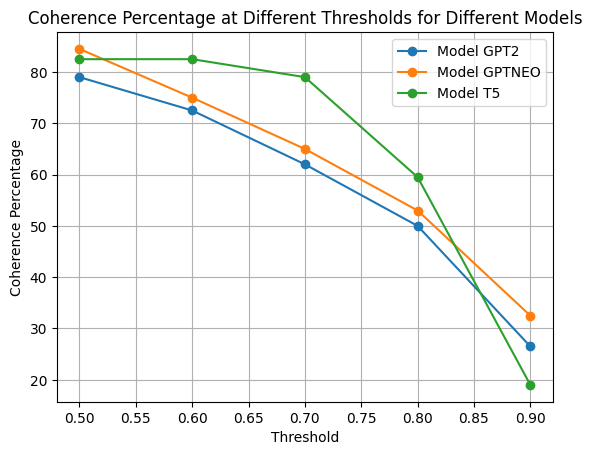

In [ ]:
import matplotlib.pyplot as plt

thresholds = [0.5, 0.6, 0.7, 0.8, 0.9]

plt.plot(thresholds, list(coherence_results_gpt2.values()), marker='o', label='Model GPT2')
plt.plot(thresholds, list(coherence_results_neo.values()), marker='o', label='Model GPTNEO')
plt.plot(thresholds, list(coherence_results_t5.values()), marker='o', label='Model T5')

plt.xlabel('Threshold')
plt.ylabel('Coherence Percentage')
plt.title('Coherence Percentage at Different Thresholds for Different Models')
plt.legend()
plt.grid(True)
plt.show()

Perplexities comparison

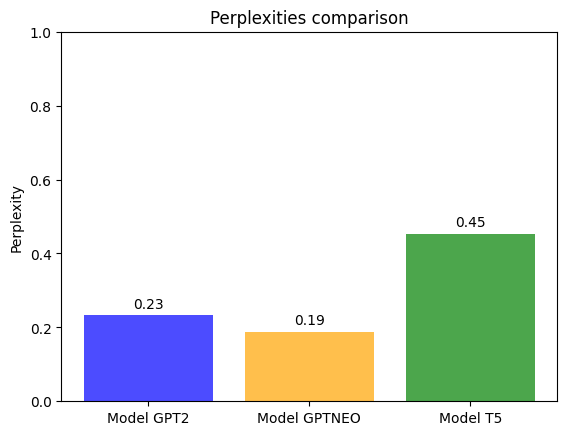

In [67]:
import numpy as np

models = ['Model GPT2', 'Model GPTNEO', 'Model T5']
perplexities = [perplexity_gpt2, perplexity_neo, perplexity_t5]

x_pos = np.arange(len(models))

plt.bar(x_pos, perplexities, align='center', alpha=0.7, color=['blue', 'orange', 'green'])
plt.xticks(x_pos, models)
plt.ylabel('Perplexity')
plt.ylim(0, 1)
plt.title('Perplexities comparison')

# Aggiunta dei valori di perplexity sulle colonne
for i in range(len(models)):
    plt.text(x=i, y=perplexities[i] + 0.02, s=f"{perplexities[i]:.2f}", ha='center')

plt.show()

BERT EMBEDDINGS VARIANT

Here, we add a variant in which the embeddings are computed with BERT and used to analyse the T5 fine tuned model. This approach could be used also with the other models.

In [ ]:
from transformers import BertModel, BertTokenizer

In [83]:
def load_model(model_path, model_type="T5"):
    if model_type == "T5":
        model = T5ForConditionalGeneration.from_pretrained(model_path)
    elif model_type == "BERT":
        model = BertModel.from_pretrained(model_path)
    else:
        raise ValueError("Unsupported model type")
    return model

def load_tokenizer(tokenizer_path, tokenizer_type="T5"):
    if tokenizer_type == "T5":
        tokenizer = T5Tokenizer.from_pretrained(tokenizer_path)
    elif tokenizer_type == "BERT":
        tokenizer = BertTokenizer.from_pretrained(tokenizer_path)
    else:
        raise ValueError("Unsupported tokenizer type")
    return tokenizer

#BERT embeddings generation function
def generate_representations_bert(answers, tokenizer, model):
    inputs_tokenized = tokenizer(answers, return_tensors='pt', padding=True, truncation=True)
    with torch.no_grad():
        outputs = model(**inputs_tokenized)
    return outputs.last_hidden_state.mean(dim=1)

bert_model_path = "bert-base-uncased"
bert_tokenizer_path = "bert-base-uncased"
bert_model = load_model(bert_model_path, model_type="BERT")
bert_tokenizer = load_tokenizer(bert_tokenizer_path, tokenizer_type="BERT")

thresholds = [0.5, 0.6, 0.7, 0.8, 0.9]

coherence_results_bert = {}

predicted_embeddings_bert = generate_representations_bert(predicted_answers_t5, bert_tokenizer, bert_model)
truth_embeddings_bert = generate_representations_bert(truth_answers_t5, bert_tokenizer, bert_model)


for threshold in thresholds:
    coherence_percentage_bert = compute_metrics(predicted_embeddings_bert, truth_embeddings_bert, threshold)
    coherence_results_bert[threshold] = {
        'bert': coherence_percentage_bert
    }

    print(f"Percentage of coherent answers at threshold {threshold}:")
    print(f"BERT: {coherence_percentage_bert:.2f}%")
    print("="*50)

print("Coherence results:", coherence_results_bert)

Percentage of coherent answers at threshold 0.5:
BERT: 90.00%
Percentage of coherent answers at threshold 0.6:
BERT: 85.00%
Percentage of coherent answers at threshold 0.7:
BERT: 77.50%
Percentage of coherent answers at threshold 0.8:
BERT: 58.50%
Percentage of coherent answers at threshold 0.9:
BERT: 33.50%
Coherence results: {0.5: {'bert': 90.0}, 0.6: {'bert': 85.0}, 0.7: {'bert': 77.5}, 0.8: {'bert': 58.5}, 0.9: {'bert': 33.5}}
